# Project
### "Using Machine Learning to Identify Cellular Infection of Malaria"

    Students:
    Joseph Rinberg     317156677
    Daniel Fensterheim 302547880

* [Goal](#Goal)

* [Motivation](#Motivation)

* [Motivation summary - How does all this relate to malria?](#Motivation-summary---How-does-all-this-relate-to-malria?)

* [The Datasets](#The-Datasets)
    * [Cell Culture](#Cell-Culture)
    * [Single Cell](#Single-Cell)

* [Algorithms and Frameworks](#Algorithms-and-Frameworks)

* [Detecting Malaria With Computer Vision](#Detecting-Malaria-With-Computer-Vision)
    * [Extracting cells with MaskRCNN](#Extracting-cells-with-MaskRCNN)
    * [Extracting cells using OpenCV](#Extracting-cells-using-OpenCV)
    * [Extracting cells using Level Set Active Contours: Failed attempt](#Extracting-cells-using-Level-Set-Active-Contours:-Failed-attempt)
    * [Getting a list of cells](#Getting-a-list-of-cells)

## Goal

Early detection of malaria is paramount for the successful treatment of malaria - more so when medical treatment is both difficult to come by and lower quality.<br>
This is the situation in Africa at the moment - with the highest rates in Burkina Faso with a 20% mortality rate of malaria in children under the age of 5.

## Motivation

Public health has always been an important factor for the development of a country. In addition childhood mortality rates have been shown to act inversly to the development of countries' GDP<sup>1</sup>.<br>
In general, being able to provide effective and accurate treatment to illnesses is an important goal regardless of the positive knockon effect it may have on the economy. 


<font size=1><sup>1</sup> O'Hare, B., Makuta, I., Chiwaula, L., & Bar-Zeev, N. (2013). <i>Income and child mortality in developing countries: a systematic review and meta-analysis. Journal of the Royal Society of Medicine</i>, 106(10), 408-414.</font>

### Percentage of deaths caused by malaria in Africa within children under 5 years of age
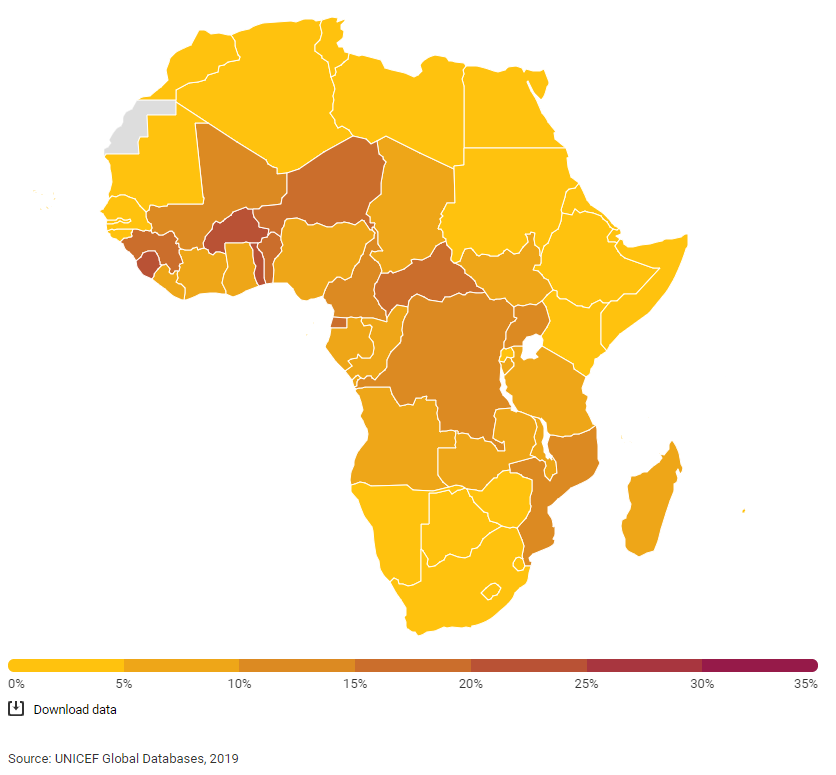

Looking at the number of children born per woman over the last 40 years or so show the world trending to a stabilization point, approximately two children per parents, i.e a 1:1 ratio - thus keeping the population static at an estimated 11 billion humans.

Looking at the data from OECD countries, we can see that most of them sit at the 2c/w mark, with Israel as an outlier - probably because of a cultral decision to have many children, as opposed to a <i>need</i> to have many children to assure that at least two survive to adulthood (the average in Sub-Saharan Africa)

### Fertility rates, Children/woman, 1970 – 2017
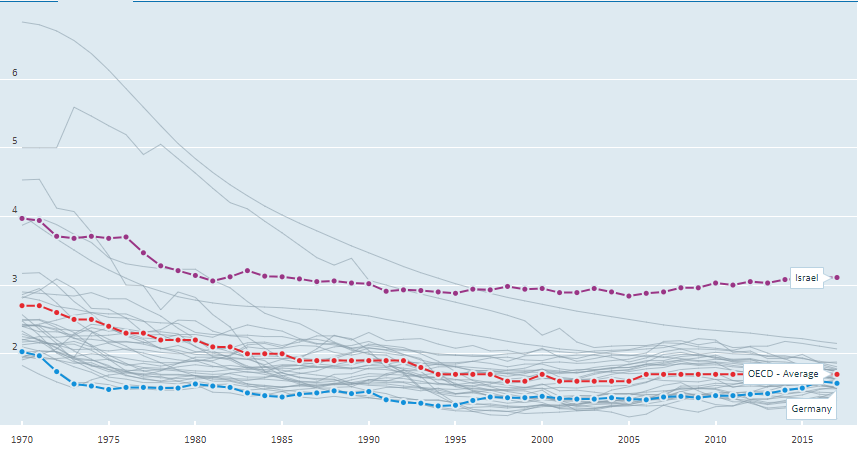
<font size=2>https://data.oecd.org/pop/fertility-rates.htm</font>

In the following graph we can see how fertility have fallen over the last decade, <b>this is in major part because of access to clean water and medical facilities causing a lower childhood mortatlity</b>, therefore requiring fewer children.

### Sub-Saharan Africa: Fertility rate from 2007 to 2017
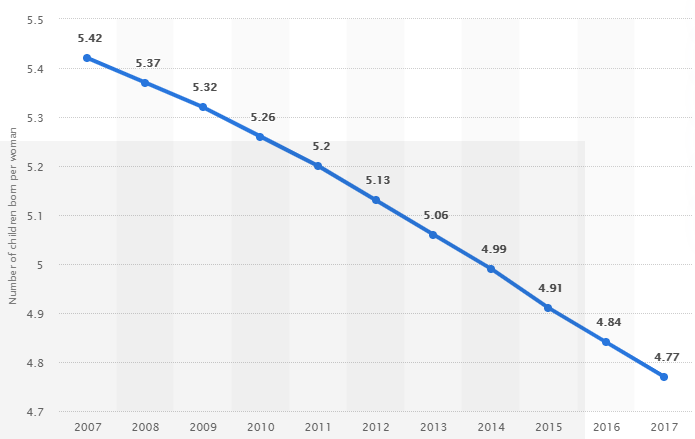
<font size=2>https://www.statista.com/statistics/805638/fertility-rate-in-sub-saharan-africa/</font>

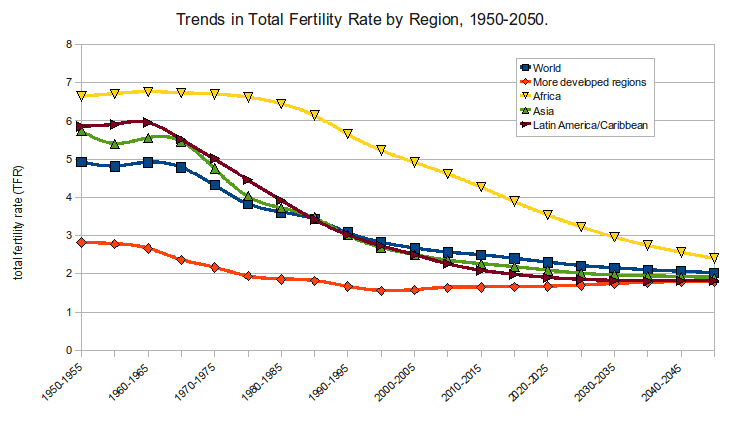
<font size=2>https://www.populationconnection.org/africa-globaldev/</font>

### Motivation summary - How does all this relate to malria?
Let's look at some facts:
* Subsaharan Africans have more children than other countries.
* Approximately 20% of those children die of malaria by the age of 5.
* There is a link between decreased childhood mortality and an increase in general quality of life.

<b>Eliminating malaria as a childhood disease will save a large number of lives.</b><br>
<b>Eliminating malaria as a childhood disease will increase the general quality of life.</b><br>
<b>Eliminating malaria as a childhood disease may have a positive knock-on effects.</b><br>
<b>Early detection is paramount in effectivly treating malaria.</b>

Conclusion: Detecting malaria easily is very important.

# Detecting Malaria With Computer Vision

## Extracting cells with MaskRCNN

We can use MaskRCNN to use transfer learning from a premade model called mask_rcnn_coco. We can load this weight model and retrain several layers only - this way we reduce the amount of time to run the training.

Let's setup the imports for MRCNN

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import Dataset
from matplotlib import pyplot
%matplotlib inline
from matplotlib.patches import Rectangle
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
import json

Using TensorFlow backend.


There are warning messages to let us know we're using an out-dated tensorflow package - this is known and intentional, so that we won't be overflowed with logs, we will lower the logging level to ERROR.

In [11]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

We can set the globals to the data.

In [3]:
BASE_DIR = 'Data\\malaria'

TRAINING_JSON = os.path.join(BASE_DIR, 'training.json')

TRAINING_IMG_COUNT = 100
TESTING_IMG_COUNT = 50

Here we can define the cell culture dataset that we use.
It loads the images as required and extracts the bounding box metadata from the training data if needed.
We can define how many images we want via the globals in the previous section.

In [4]:
class CellCultureDataset(Dataset):
    def load_json_data(self):
        self.data = json.load(open(TRAINING_JSON))
    def load_dataset(self, is_train=True):
        
        self.add_class("dataset", 1, "cellculture")
        count = -1
        for training_image in self.data:
            count += 1
            if is_train and count > TRAINING_IMG_COUNT:
                continue
            if not is_train and count <= TRAINING_IMG_COUNT:
                continue
            if count > TRAINING_IMG_COUNT + TESTING_IMG_COUNT:
                break
            img_id = training_image['image']['pathname'][8:-4]
            image_path = os.path.join(BASE_DIR, training_image['image']['pathname'][1:].replace('/', '\\'))
            self.add_image('dataset', image_id=img_id, path=image_path, annotation=training_image)

    def load_mask(self, image_id):
        boxes, w, h = self.extract_boxes(self.image_info[image_id]['annotation'])
        
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = []
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('cellculture'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def extract_boxes(self, bbox_data):
        bboxes = []
        for bbox in bbox_data['objects']:
            xmin = bbox['bounding_box']['minimum']['c']
            ymin = bbox['bounding_box']['minimum']['r']
            xmax = bbox['bounding_box']['maximum']['c']
            ymax = bbox['bounding_box']['maximum']['r']
            bboxes.append([xmin, ymin, xmax, ymax])
        img_width = bbox_data['image']['shape']['c']
        img_height = bbox_data['image']['shape']['r']
        return bboxes, img_width, img_height

Now we can setup the config classes needed for training the model.

In [5]:
class CellCultureConfig(Config):
    NAME = "cellculture_cfg"
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = TRAINING_IMG_COUNT + 1

Now we can actually train the model - this took several hours to run.

In [6]:
def train_model(train_set, test_set):
    print('Train: %d' % len(train_set.image_ids))
    print('Test: %d' % len(test_set.image_ids))
    config = CellCultureConfig()
    model = MaskRCNN(mode='training', model_dir='./', config=config)
    model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
    # train weights (output layers or 'heads')
    model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

Now that we have our model trained, 'mask_rcnn_cellculture_cfg_0005.h5', we can make predictions :)

Let's setup the required config.

In [7]:
class PredictionConfig(Config):
    NAME = "cellculture_cfg"
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

So we have our model trained - but can we somehow evalutate it's accuracy?

We can attempt to by calculating all the APs across the board and getting the mean AP. Let's do this for both the training set and the test set.

In [8]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

def eval_map(train_set, test_set):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model.load_weights('mask_rcnn_cellculture_cfg_0005.h5', by_name=True)
    # evaluate model on training dataset
    train_mAP = evaluate_model(train_set, model, cfg)
    print("Train mAP: %.3f" % train_mAP)
    # evaluate model on test dataset
    test_mAP = evaluate_model(test_set, model, cfg)
    print("Test mAP: %.3f" % test_mAP)

Creation of the train and test set.

In [9]:
train_set = CellCultureDataset()
train_set.load_json_data()
train_set.load_dataset()
train_set.prepare()

test_set = CellCultureDataset()
test_set.load_json_data()
test_set.load_dataset(is_train=False)
test_set.prepare()

Running this also takes some time...

In [12]:
eval_map(train_set, test_set)

Train mAP: 0.805
Test mAP: 0.765


Now that we've seen the evaluation of the model, we can finally make some predictions.

Let's create a function to take annotatted images and display them side by side with the predictions.

In [13]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=3):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        extracted_bboxes = dataset.extract_boxes(dataset.image_info[i]['annotation'])[0]
        pyplot.title('Actual - %d cells' % len(extracted_bboxes))
        bx = pyplot.gca()
        # plot each box
        for box in extracted_bboxes:
            # get coordinates
            x1, y1, x2, y2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            bx.add_patch(rect)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted - %d cells' % len(yhat['rois']))
        ax = pyplot.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()

Let's load 3 images from the training set and 3 images from the test set (that also have known annotations) and compare them.

In [14]:
def make_prediction(train_set, test_set):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model_path = 'mask_rcnn_cellculture_cfg_0005.h5'
    model.load_weights(model_path, by_name=True)
    # plot predictions for train dataset
    plot_actual_vs_predicted(train_set, model, cfg)
    # plot predictions for test dataset
    plot_actual_vs_predicted(test_set, model, cfg)

The upper 3 images are taken from the training set, the lower 3 are from the test set.

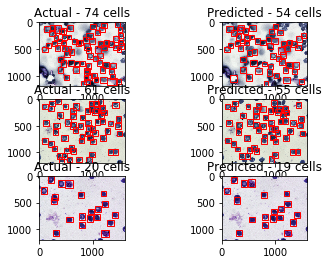

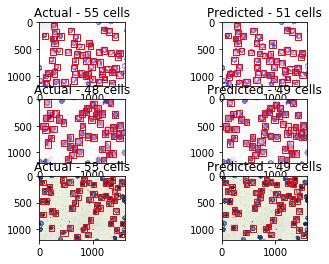

In [15]:
make_prediction(train_set, test_set)

Now we want to able to call the prediction on a given image, there is some code duplication, but this is unavoidable in this circumstance.

In [16]:
def plot_actual_vs_predited_given_image(model, cfg, image_path):
    # Add Image to dataset
    dataset = CellCultureDataset()
    dataset.load_json_data()
    dataset.add_class("dataset", 1, "cellculture")

    wanted_image = None
    for img in dataset.data:
        if img['image']['pathname'] == image_path:
            wanted_image = img
    if wanted_image == None:
        raise ValueError("Unknown image %s" % image_path)

    img_id = 0
    image_path = os.path.join(BASE_DIR, wanted_image['image']['pathname'][1:].replace('/', '\\'))
    dataset.add_image('dataset', image_id=img_id, path=image_path, annotation=wanted_image)
    dataset.prepare()

    # load the image and mask
    image = dataset.load_image(img_id)
    mask, _ = dataset.load_mask(img_id)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]
    # plot raw pixel data
    pyplot.imshow(image)
    pyplot.title('Predicted - %d cells' % len(yhat['rois']))
    ax = pyplot.gca()
    # plot each box
    for box in yhat['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the figure
    pyplot.show()
    
def make_prediction_single(image_path):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model_path = 'mask_rcnn_cellculture_cfg_0005.h5'
    model.load_weights(model_path, by_name=True)
    plot_actual_vs_predited_given_image(model, cfg, image_path)

Let's call some predictions on images.

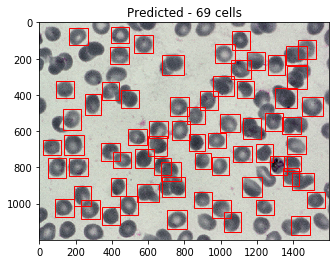

In [17]:
make_prediction_single(r"/images/9dc6ed5d-6698-48cf-aab3-fd156673729c.png")

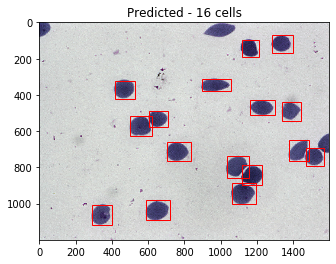

In [18]:
make_prediction_single(r"/images/2afe2750-c963-46f9-a1ad-9260e80679ca.png")

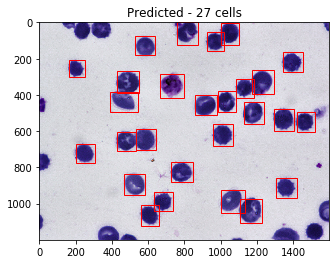

In [20]:
make_prediction_single(r"/images/6f4ffe7b-395f-41ea-ad61-df5e0cbd531c.png")

We can see the some images are better than others - but overall we have a good amount of cell detection.

## Extracting cells using OpenCV

We can attempt to use edge detection with opencv to detect cells.

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
def edge_detect_image(filepath):
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    thresh = cv2.threshold(gray,150,255,0)
    contours, _ = cv2.findContours(thresh[1], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create a bounding box for each contour
    for cont in contours:
           x, y, w, h = cv2.boundingRect(cont)
           cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    img = cv2.drawContours(img, contours, -1, (255,255,0), 3)
    plt.imshow(img)


For some images, this works well

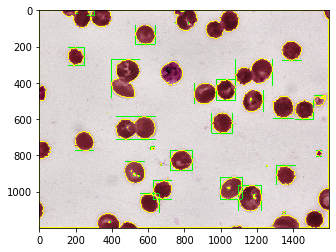

In [31]:
edge_detect_image(r"Data/malaria/images/6f4ffe7b-395f-41ea-ad61-df5e0cbd531c.png")

For others, not so much...

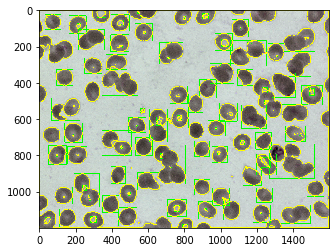

In [32]:
edge_detect_image(r"Data/malaria/images/9dc6ed5d-6698-48cf-aab3-fd156673729c.png")

This is due to two main factors:
1. The images are too different for a simple grayscale and edge threshold to handle equally.
2. Overlapping cells are taken as the same cell

For these reasons, we decided to not follow this path for cell detection.

## Extracting cells using Level Set Active Contours: Failed attempt

We would like to attempt another classical segmentation method for further comparison.<br>
The kaggle single cell dataset used in this project was created using C-EPAC - a modified version of level-set geodesic active contours [I. Estroy et al. "COUPLED EDGE PROFILE ACTIVE CONTOURS FOR RED BLOOD CELL FLOW ANALYSIS"](#http://cell.missouri.edu/media/publications/Ersoy_EPAC-red-blood-cells_ISBI-2011.pdf). 
Below we will attempt to implement the paper.


### Quick summary on the paper

The centers of the cells are found (in the paper they used iterative voting), those collection of coordinates are where the snakes start from. The snakes grow outwards till they reach the cell borders.
Conflicts in clusters of cells are resolved using methods borrowed from graph coloring, in which cells in a cluster are neighbors in the graph and two adjacent cells are to be drawn with different colors (this is done by adding a term to the velocity function which causes the snake to stop when reaches a neighbor.

### POC for active contours

Below we will use skimage for geodesic active contours (on which the paper is based).<br>
First, we will initialize some usefull functions and load the image.<br>
`store_evolution_in` will be used later to track the progress of the snake throughout the iterations.

In [1]:
%matplotlib inline
import numpy as np
from skimage import data, img_as_float
from skimage import io
from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient)
from skimage.color import rgb2gray


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


evolution = []
callback = store_evolution_in(evolution)


fpath = '../malaria_data/malaria_culture_data/images/9dc6ed5d-6698-48cf-aab3-fd156673729c.png'
image = io.imread(fpath)
image = rgb2gray(image)

image = img_as_float(image)
gimage = inverse_gaussian_gradient(image)


/home/daniel/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


#### Snake moving inwards

Here below, we will initialize the level-set and run the algorithm.
The snake starts out as a square located 10 pixels away from the edges, seen as `init_ls_inwards[10:-10, 10:-10] = 1` and the snake will move toward the center of the image defined by setting the parameter `baloon=-1`.

In [ ]:
init_ls_inwards = np.zeros(image.shape, dtype=np.int8)
init_ls_inwards[10:-10, 10:-10] = 1

evolution_inwards = []
callback_inwards = store_evolution_in(evolution_inwards)

ls_inwards = morphological_geodesic_active_contour(gimage, 1000, init_ls_inwards,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback_inwards)

After the training is completed, we will plot the results:

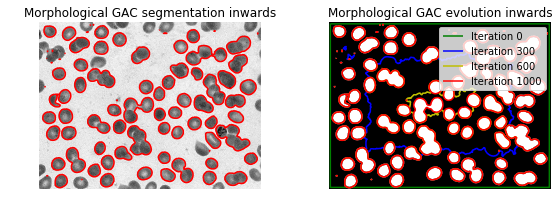

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
# ax[2].contour(ls.T[0], [0.5], colors='r')
ax[0].contour(ls_inwards, [0.5], colors='r')
ax[0].set_title("Morphological GAC segmentation inwards", fontsize=12)
ax[1].imshow(ls_inwards, cmap="gray")
ax[1].set_axis_off()

contour = ax[1].contour(evolution_inwards[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[1].contour(evolution_inwards[300], [0.5], colors='b')
contour.collections[0].set_label("Iteration 300")
contour = ax[1].contour(evolution_inwards[600], [0.5], colors='y')
contour.collections[0].set_label("Iteration 600")
contour = ax[1].contour(evolution_inwards[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 1000")
ax[1].legend(loc="upper right")
title = "Morphological GAC evolution inwards"
ax[1].set_title(title, fontsize=12)
fig.tight_layout()

#### Snake moving outwards

Here below we will attempt to provide a POC of the ability of the avtive contour algorithm to find a **single** cells contour from inside goint outwards, if this is possible and we can find the centers of the cells, we can attempt to segment all cells according to the paper.<br><br>
In this case, the snake starts out in the center of a predetermined cell for which the center was manually located `init_ls_outwards[56:72, 72:88] = 1`. Here, the parameter `baloon` is set to `1`, henve the snake will move outward. 

In [8]:
init_ls_outwards = np.zeros(image.shape, dtype=np.int8)
init_ls_outwards[56:72, 72:88] = 1
evolution_outwards = []
callback_ouotwards = store_evolution_in(evolution_outwards)

ls_outwards = morphological_geodesic_active_contour(gimage, 1000, init_ls_outwards,
                                           smoothing=1, balloon=1,
                                           threshold=0.5,
                                           iter_callback=callback_ouotwards)

Lets plot the results:

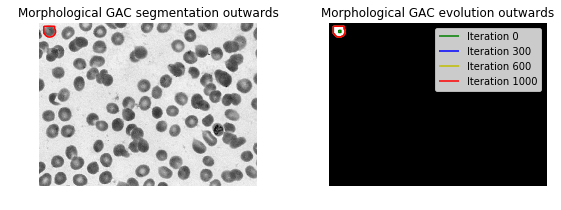

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
# ax[2].contour(ls.T[0], [0.5], colors='r')
ax[0].contour(ls_outwards, [0.5], colors='r')
ax[0].set_title("Morphological GAC segmentation outwards", fontsize=12)
ax[1].imshow(ls_outwards, cmap="gray")
ax[1].set_axis_off()

contour = ax[1].contour(evolution_outwards[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[1].contour(evolution_outwards[300], [0.5], colors='b')
contour.collections[0].set_label("Iteration 300")
contour = ax[1].contour(evolution_outwards[600], [0.5], colors='y')
contour.collections[0].set_label("Iteration 600")
contour = ax[1].contour(evolution_outwards[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 1000")
ax[1].legend(loc="upper right")
title = "Morphological GAC evolution outwards"
ax[1].set_title(title, fontsize=12)

fig.tight_layout()

As we can see, this is possible.

### Finding the centers

Attempting itarive voting as described in a reference in the paper did not seem feasable at the moment so we decided to attempt a different approach which we saw in one of the class lectures: **Hough Circles**<br><br>
To accomplish this we had to test many filters and hyper parameters and presented the best results we got to below.<br><br>
We took the following steps to produce the circles:
 1. Loaded the image in grayscale
 2. Applied Median Blur to that image
 3. On top of that, applied a contrast stretch with the function `pixelVal`
 4. On the resulting image, which now has a clear and high contrast, we applied canny
 5. We then applied Hough Circles transformation and found all the candidate circles.

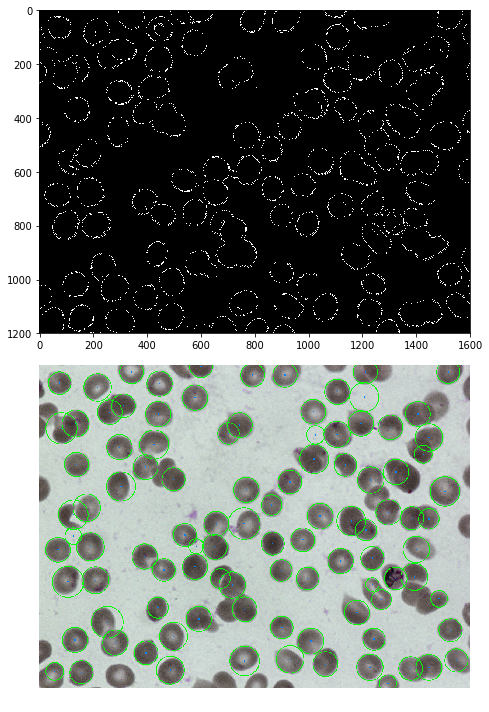

In [1]:
%matplotlib inline

import numpy as np 
import cv2 
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
ax = axes.flatten()

def draw_circles(inp_img, ax):
    
    # Initialize the list 
    Cell_count, x_count, y_count = [], [], [] 
    
    # read original image, to display the circle and center detection 
    display = cv2.imread("/home/daniel/repos/malaria_data/malaria_culture_data/images/9dc6ed5d-6698-48cf-aab3-fd156673729c.png") 
    
    # hough transform with modified circular parameters 
    
    circles = cv2.HoughCircles(inp_img, cv2.HOUGH_GRADIENT, 1.2, 50, 
                               param1 = 50, param2 = 28, minRadius = 20, maxRadius = 60) 
    
    # circle detection and labeling using hough transformation 
    if circles is not None: 
        # convert the (x, y) coordinates and radius of the circles to integers 
        circles = np.round(circles[0, :]).astype("int") 
    
            # loop over the (x, y) coordinates and radius of the circles 
        for (x, y, r) in circles: 
    
            cv2.circle(display, (x, y), r, (0, 255, 0), 2) 
            cv2.rectangle(display, (x - 2, y - 2), (x + 2, y + 2), (0, 128, 255), -1) 
            Cell_count.append(r) 
            x_count.append(x) 
            y_count.append(y) 
    
    ax.imshow(display)
    ax.set_axis_off()

        
img = cv2.imread("/home/daniel/repos/malaria_data/malaria_culture_data/images/9dc6ed5d-6698-48cf-aab3-fd156673729c.png", 0) 


def pixelVal(pix, r1, s1, r2, s2):
    if (0 <= pix and pix <= r1): 
        res = (s1 / r1) * pix 
    elif (r1 < pix and pix <= r2): 
        res = ((s2 - s1) / (r2 - r1)) * (pix - r1) + s1 
    else: 
        res = ((255 - s2) / (255 - r2)) * (pix - r2) + s2
    res_im = np.array(res, dtype = np.uint8)
    return res_im
  
  
  
r1 = 70
s1 = 0
r2 = 200
s2 = 255
  
# Vectorize the function to apply it to each value in the Numpy array.  
pixelVal_vec = np.vectorize(pixelVal) 
  
blurM = cv2.medianBlur(img, 7)
contrast_stretched_blurM = pixelVal_vec(blurM, r1, s1, r2, s2)
canny = cv2.Canny(contrast_stretched_blurM, 100, 200)

selected_image = canny
ax[0].imshow(selected_image, cmap='gray')
draw_circles(selected_image, ax[1])


fig.tight_layout() 


Above, we plotted two images: 
 1. the canny image on which the hough circles was applied
 2. The resulting images with circles around all the detected cells
 <br><br>
These results are quite impressive, but not good enough  for our case since there are still some False Negatives and False Positives.

### Why we decided to abandon this approach

Given enough time we would eventually be able to come up with sufficient results. Unfortunately we do not have enough time to complete this path. The deep learning approach is simple to implement and provides excellent results, hence we will proceed with it for cell segmentation.

## Getting a list of cells

In [33]:
def get_predicted_cells(model, cfg, image_path):
    # Add Image to dataset
    dataset = CellCultureDataset()
    dataset.load_json_data()
    dataset.add_class("dataset", 1, "cellculture")

    wanted_image = None
    for img in dataset.data:
        if img['image']['pathname'] == image_path:
            wanted_image = img
    if wanted_image == None:
        raise ValueError("Unknown image %s" % image_path)

    img_id = 0
    image_path = os.path.join(BASE_DIR, wanted_image['image']['pathname'][1:].replace('/', '\\'))
    dataset.add_image('dataset', image_id=img_id, path=image_path, annotation=wanted_image)
    dataset.prepare()

    # load the image and mask
    image = dataset.load_image(img_id)
    mask, _ = dataset.load_mask(img_id)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]
    detected_cells = []
    for box in yhat['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        detected_cells.append(image[y1:y1+height, x1:x1+width])
    return detected_cells
    
def get_predicted_cells_from_image(image_path):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model_path = 'mask_rcnn_cellculture_cfg_0005.h5'
    model.load_weights(model_path, by_name=True)
    return get_predicted_cells(model, cfg, image_path)


16 cells:


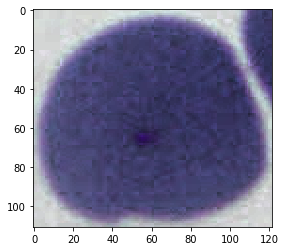

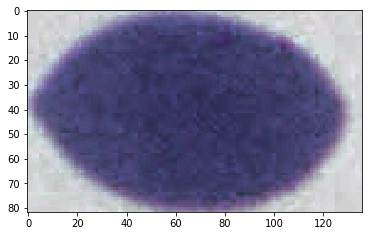

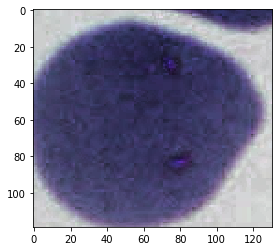

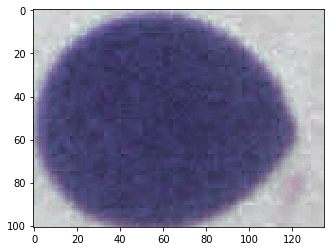

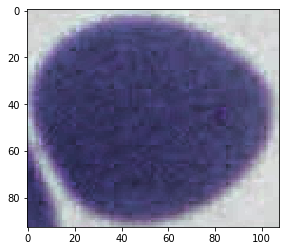

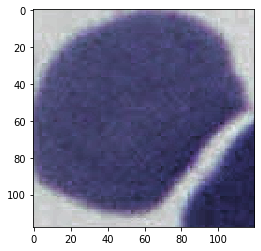

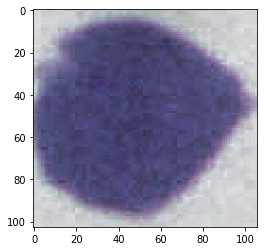

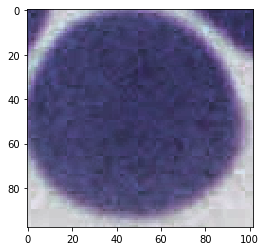

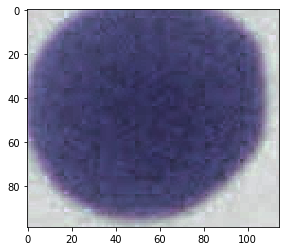

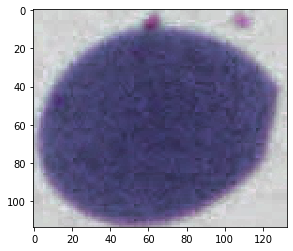

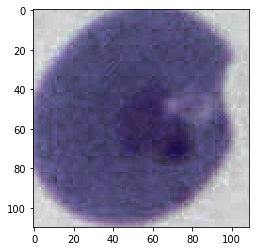

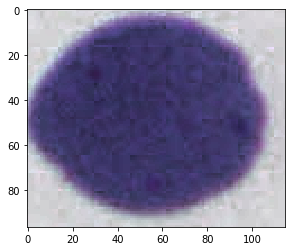

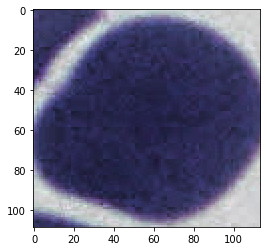

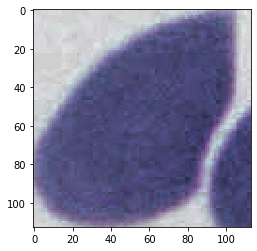

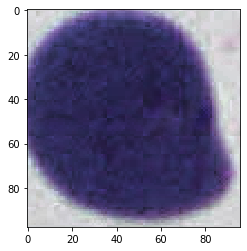

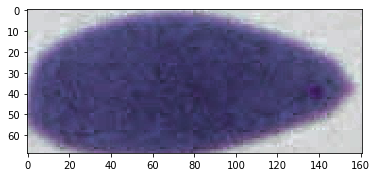

In [37]:
cells = get_predicted_cells_from_image(r"/images/2afe2750-c963-46f9-a1ad-9260e80679ca.png")
print("%d cells:" % len(cells))
for cell in cells:
    pyplot.imshow(cell)
    pyplot.show()

## Single cell classification using fastai's RESNET CNN

fastai is an opensource deep learning package developed by Jeremy Howard.
The purpouse of this framework is to ease the ability of developing deep learning while focusing on some key training methods (such as transfer learning, learning rate annealing and others).
<br><br>
We will use fastai's Resnet: a CNN architecture that attempts to overcome the 'vanishing gradient' problem by creating 'identity shortcuts' which adds outputs from layers to inputs to later layers activation functions.
<br><br>
Resnets are impirically shown to greatly improve performance over 'plain networks' (those without the shortcuts).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai2.data.all import *
from fastai2.vision.data import *
from fastai2.vision.all import *

from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report

import os
print(os.listdir("../cell_images/"))

['Parasitized', 'Uninfected']


In [2]:
path=Path('../cell_images/')
path.ls()

(#2) [Path('../cell_images/Parasitized'),Path('../cell_images/Uninfected')]

In [3]:
splitter = RandomSplitter()
item_tfms = [Resize(224)]
batch_tfms=[*aug_transforms(flip_vert=True,max_zoom=1.2, max_warp=0), Normalize.from_stats(*imagenet_stats)]

In [4]:
data_block = DataBlock(blocks=[ImageBlock, CategoryBlock],
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=splitter,
                  item_tfms=item_tfms,
                  batch_tfdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAhoAAAIYCAYAAAArcUUtAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzsvXvsLVl21/dZe1ed83vce/t5p3u6e3o8b2bGNh4bMzYE20A82GAbEyPGBgGG8EoUgyJAxFESQBFSkJw4CuShIEAgRREkQSQyOCCDSDKRrPCWE/xCfmF7GPfM9PTj3t/vVNXeK3+stXbt87u3e6Z7pqdv367V+vXvd8+pU6dq195rf9d3vURV2WSTTTbZZJNNNnktJL3eF7DJJptssskmm9y/sgGNTTbZZJNNNtnkNZMNaGyyySabbLLJJq+ZbEBjk0022WSTTTZ5zWQDGptssskmm2yyyWsmG9DYZJNNNtlkk01eM9mAxhtAROR3iMjffZn3f42I/Phr8L0qIu/+Qp93kzefbHN4k/tBtnn86kS2OhqfXUTkZ4DHgALcAv428D2q+uLrdD0KvEdV/+X98D2bvPayzeFtDt8Pss3jN+Y83hiNz12+VVWvAV8JfDXwH72SD4vI8Jpc1SabfO6yzeFN7gfZ5vEbTDag8QpFVX8B+EHgS0Xk94jIj4rICyLyUyLyB+M4EfkGEfl5EfkTIvKvgb8sIg+JyA+IyDMi8qz//VT3me/287wgIj8tIr+je/1j/vf/6Yf/cxF5UUQ+Gt/l73/UX4+fg4j8A39vLyLfJyI/JyKfEJH/TkROu+//4yLycRH5RRH5va/xUG7yOsk2hze5H2Sbx28c2YDGKxQReRvwG4F/CvwS8C3ADeD3AN8vIl/ZHf448DDwduAPYOP9l/3fTwMXwJ/3854D/xXwzap6HfhVwD+7+v2q+nX+5y9X1Wuq+teuvP/X/PVrwBPATwH/o7/9Z4H3Al8BvBt4EvhP/Pu/CfhjwDcC7wH+zVcxPJu8AWSbw5vcD7LN4zeQqOr281l+gJ8BXgQ+A/ws8N8Ap3c57m8Cf8T//gZgAk5e5rxfATzrf5/7+b/j6rmB7wY+1v1bgXd3//4G4OevfCYBPwD8t/5vwXya7+qO+Vrgp/3vvwT8Z9177736PdvPG/dnm8Ov/zPYfj7/n20ev/7P4NX8bL6qz12+XVV/qH9BRL4Z+JPYREjAGfAj3SHPqOpld/wZ8P3ANwEP+cvXRSSr6i0R+SiGZP+iiPzfwB9V1R97ldf7Z4DrwB/2f9/06/vHItIuCcj+9xPAP+4+/7Ov8ns3uXdlm8Ob3A+yzeM3mGyuk1cpIrIH/hfg+4DHVPVBLAJausOupvT8UeB9wIdV9QYQ1JsAqOrfUdVvBN4K/BjwF17ltX0n8F3Ab1XV2V/+JEYPflBVH/SfB9RoPYCPA2/rTvP0q/nuTd44ss3hTe4H2ebxvS8b0Hj1sgP2wDPA4oj6I5/lM9exCfYZEXkYQ+AAiMhjIvJt7h88YPRgeYnzfAJ4593eEJEPAX8OQ/3PxOuqWrHF8v0i8hY/9kkR+Q1+yF8HvltEPuBo/0+yyf0u2xze5H6QbR7f47IBjVcpqvoCRoX9deBZ4LcD/9tn+dh/CZxiiPaHgf+9ey9hKPsXgU8DXw/8uy9xnj8F/BUR+YyI/LYr7/1mjAr8WBft/IP+3p8A/iXwwyLyPPBDGKpHVX/Qr+/v+zF//7PcyyZvcNnm8Cb3g2zz+N6XrWDXJptssskmm2zymsnGaGyyySabbLLJJq+ZbEBjk0022WSTTTZ5zWQDGptssskmm2yyyWsmG9DYZJNNNtlkk01eM9mAxiabbLLJJpts8prJPVEZVKwF7hteRIRv/4Zv5Cvf90EefeAhUAVRRIScU6sYIyIgkCQhgGYQBEkgSRGBYRD8MAT4z//q/8A//JH/9/W7uXtYVFU++1GvrbyR5/DNhx/kX/xffwvWkscgYvMzQV+8UFSpVUESICjq8xyoSlnm9nkRsXPGzO8z3NpJBb3y+nPPPcf7vu7bXrP7vRflXpjD8NrO4+unp/yzv/hfc7Lfo6Wg1XQjCHUplKmAQl0KWqCWCih1rpRSWKYFXapdZxGUSlnsclPKaK2ICMNuR0qJeZroKm8ikux8tZJSau9pVUotrqczd8vETMmPBbRWENr12zS3tSNi36OqoJVa1u9KydZEKX4PAiCUpVBLsXP4WolriPOLJFJOR2XHUk5+T6xrkIQgQPL1piBC1UKthSRCHnIMCIJQtVJrRYZESomUs51KhDRkRIRaZ7uPIYFAHmz9Iz42SUg58eTv/u67zuN7AmjcL2KTKZNE2oNqSMHf73/bxMImTxzTvR+nAKi1vvY3sMmbUnJ2pSsCtQJpralYoaqCglINGFdTaiKCaihFAxxaaQoMWOc3YHtpKND1+0WOyzbWLeX+vpSTcTSQodXAqs8jVTVQUf3vRdFSqcXm1TIXyrJQ5gVUEAWqAYZSqm3Coq5vJUp7tu+VAL1ADXCQEklsnqtUlrJgH9N2vPp5bH4bIK7V5y/SjrNT65UfUNuF29xef2tbHwBJMgYz63qU1vV4hVq9XpjQPltrXb9bw4BVvzptn23joQoOdux1WS/Mx9RWeUW1ImndlKoWt5srJPHrML1RVZHueu8mG9D4AkoSYczZHrPqChh8subUKXRsohgSNh9Wm7z0CtkmzYc+8D4eeehB5nnm2eef5+PPfJJPfPJTr8+NbvKGk//iP/73+Y5v/WbmZaLUQpmrWTJFSSlRFkVSAs0kElpdqaopc62+GWh1oOGWk8RsNSUlKJrtNVNUV9SP+HFVVjDToQ5FyTnx27/1IyxloRRlKTOlVA7Twmeef55/+COvtuXEJq+nPHTtHGIOlWrsRbVNrc6FOqvNs1mptVCWYizZXM3iX9SZBd8oJZN9M6wdQCjFNuVeD6vauVWVlN1yTzaHi67HAkege/183EWAbkVkZUXs9wpKHJETK8PYP2nvhW0pIkhODcC0LxIDVA0g4ayDrOtGixLgRHGGPClydA34mGgDFzXZtcWYqV+3VAdTpRjQkITmxQwBUarOSBJ7fVYki48jSErUHBXW75QNaHwBRUTY73ZGv/lUypKdblMWjLpKKTVqWZJAMiUv0qNhdSbMjvuWr/taUkqMQ+Kf/+RP8wP/4GMb0Njkc5az/QknJ3v2sm/KTCS5Lqws04xpwGRztiplLtRSKYuBC1N8ad0gnEKWJKQhWBBFKc1qdA+LuRBT8u8NAOJKNa0MCQjnp2d835/+D9ZjXdmWUvjxn/hJfv13/aEv2rht8oWTR65foxafN8XcBGUpxl7MBn61YhtegTLZvEtAToPtVrEPZ9ehtTjTUJ1RTszz3IAEPmdrLaaTg0GptQGGWmpz/Tl5Z9fkLMIKNHQ1INUdhwqxo/dApbmFFKoaG11rkC62DkqpCEqSla0W1o2/1koiN5dOSiMAGgCmX8eoMTQqDlq0uWbCoG2szOLsg5hhYGRkXdlIiSsx95W0pb0awYpChUUXY0RTfdmIzw1ofJ5iqBiKT/QxD2Sn5UJJdo+GwKDSIXA3DBsN5lOis/SUiiJUBFs04efbZJPPRSQJqoKQWlyFqilEKtRFqUuBKqhAXSrLwYBGne14MebVlbXTsqIwiNHeYrNcRZEEaXArqrkPHUR3ZAbiCjOY79RRujjgDvNP1TapTd4QkpJtTKVWckqc7fc235qnTdFFqUWpBWccjAgI9gGconeQWiO+wSdiMBFJ0h1xF6QO1IarIOIpaqXKuqGv3xdrY2UQ4jpUtZ0jpJmFNeIuzFUiyUCGiq73WtUZgXAr+qdrnGllIbSq34PtE7afpKPPOR4wZuUq0GkACH/N/h3shN9QO1NjdNwl0t+bAQzakQCi0saxAFIh5buGZwAb0Pi85NrZOW9/4kk+/MFfzjwbbfT2x5/k7OTUrDk/Luy39ooq2qw6yCmt9NXKrtEmSvuYKfLLw8Tl4fDFuMVN7hMZ8ujKBAMYxS2jAlpgvr1weP6ScqjUS6Ovl1sLdVGkuJVTTQVJSuRkZk7aJfI+M54NaFbYC7Izlq6qAQ51F4q4T37dAIzRW5V8Nd95ik1Kwxttx4qy2428821vpVZlXhZ+4ROffL2GdJPPIt/+tV/NH/mt38bHP/Esn3z2Mzz5yCMWd1EVXSxQcpkKFBDNpMXA6zzNjXEIM61Wn6tH8TvmBonNO35ySkdxx6raWIU+viECOONcsiLiNbaB9Tu1VlSEpKkZiAEw1k3egEVKyY71a2ouoqqrizz53VVt19sMzySrsRrXUW0dxHqJ70xpZWpSkgZyBBq7gX9n1WLMpDMnEqi/249acGtdB0EREGN/RIRaFnBGRz1odxgzLyUb0Pg8ZBgGHji/znuf+pL22vnJSWM5gA41dpOoCwaldm4S6ZWrhEePFbvbZ5ZSWMpLNRPcZJM7JXkAF9UCNmupaDGLUguUi8r0YmG5vTA/P6ELzC/M6FxIOphiVHFGQ0gZyDDsM3mf0bpHdkKWwazPIbEywsZyOF7wCwqSIzW2AkmIZCL2Y2XyTGGnnLj56KP84d/zXdRSePb5F/hP/9xf+iKP5Cafqzzx8MO8/YknedeTb2/xFnUuxlgUj9MI9qK4O6XiLEe3gee22zV3hzpVZht56oLmI9YoNlfWOItaWyxDsHotaNn1ckoOXBxUvKzYydeMEyTIE9zTsrLaIuDXtcbixZLsjEzX9MFShBwDLOHqpWmNW17HysbpLgygkRSEKyX2nvVtpyz7jzQcoj7O63lrsSDxKi/tO9mAxuchY86cn5xx/ew6Ih7qE5PPj5ErMyLSnMLHZbSbNnQb9J9EWqwvppx8USEcponLafri3uwmb2jJaaAWQYtSFjX/96IsL1bKVJg+M3P4dGG5tXD7mUuYlOX5iTotJAZyTiSEYRBSFnbne/I+k88TabJUwrQX0gIsA4wKNSNZ0GTMhkc8o0khm/LKDsolD10Ev9Plpr4AjQQFHnzoEb7zO74dgGc/9ewGNO5heefjj6HF2AQDGBbYqaVaCquqp7FaCqvOBSGxzAvzNLEsC8MwsNvv13nRguXDYq9uyaejmAVJFpxve6MBmqJqOtQtflK4I9ZMFAO/2r5HsXNDU9erfu8zW+J/DSOHe2IFMEAXPyGBhagJriYVR9Br7/7QbqMPhqJ9vxi7YIGwvsdE7ApWOsHP7IBImjPf4klAUm5nb+audCns8e11dXWiAmruorq8tPG7AY3PQyK3OQBGAxrHB4Ej8EDTzZciTnk5p5EcVa+50+L+ORoFF3nY5WUe6iZvTnnoxjXOT0+ZloVSa7MKqyr7cWf6dgFdoE6gs7BcFpaLhen5wvJ8odxW9LbABHobdLLUNpLTxmNGxozuFE0VFvMjpwqpijEmxV6ri9HMpmXWmCNRoQWWVc9yFAPbcYz6BhCxICQH8h7hjp9yk3tXHjy/ttL87bcFg9ZSbDOra4p01J7QyPaIE4VbIa2bX7AY4eLoXQktCFI9+tLPFDo0FPAaF9env3YMgOvpeC+CS9e5vLobGmsRlxzBSe1QcQBDu9/e3cPVz97BWnTfdTfxt1pcSU0tlmNl0f0e1YNAJWK2wjWZ7XUNgA8RUKXt024gRA0oQMQDa+/GnrhsQOPzkJwT+3EHmAUGHAXqGEr2g4tbZapkBxtCagvEisg0c675Hc3nRltYSWCa543R2OQO+bPf+z1822/8COrKW/z3shQoiXJRqReVMlUOLyzUqXLxyUvmWzOXz0xMn5qoh0q9tSBFKYeKzpVaZ5vrZyeQLe8/50xE16PKuNsjA6aFqqIL6Fw8jdELf2n4pS1jICVBSkZUKaVQ0+pbscAyt8hS53tGqamQUiLnkW/6NV9DrZVpXii1MM0LtVaee+FFfuETn+TWxcXr+ETevDLmzLve+labg1WhWromi4HdMgNURBNSFEptWU6qyjAM5P0eSYlhGI4CMnvxvdz/Xq34BjpScoABeRg7Vwp+vjDYPJuqVJ+bxnakZH9bVocxJGvgp1DrChQsBmpNiQWrf2FshrRCYRH83IC3CDUKgql2wdJ9EGZcL1zZ9o8yYkIiJuXqeKmnp0dqrzrgsCJ8xdxKWlf8lI9ZlXZ+v7oWZ6IKbDEar4kkSeRkg6sNWjvIaIVRmseuUWpadY38dWmTz+XlvIOl1JYrvskmIUJqEfvmpzCrI2N59HWpLLcL5VCYX5hZLmam5yd77dZCuVgol4Vye7b4ilLRUkxBZiGPGdlnZJdhFBhAB7F4jDHD4PPa40G0egZVsUiLVNSZjKCoO2ZjKVS1HH5QUjaGQ1HykCydMUC5KJorJ/tT/vgf+n2ArYeqhVIrqvBTP/tz/NX/+Qf4R//fVnPj9ZDR49csBoM1cEF7XSdQjHnrMz9EEnnIRwADuAI2gu06zra4I0ukKuTUAEZ8JtwX4dLoN39Ljc1rcS+PlwjXyqrRV7Zjjbtj/X2k06+wEb5/x6vH1xExH6vE6YIiidTZcA1FNk+cx16Oezo+Udxry4Nsr4lljnkciTbWZz1B7Z+Bj3VzRb0M4bIBjc9Dhpw52e19EnR+KyyV0JBiJaLps6PZoqVNkuSxF21x4Ol8V6iz9f3EtMwcNkZjE+Da2SkQ7pE9WmRlPb0ewTIVlotCPVQOn5ool4XDcwcL/HxhQQ8KtxW5UOSyUm9NnV+3IqOQTjLD9ROGs5G8z8j1hOwSuxs7hv1APs1UqZAracy2h2ixgNNqFlYSbezEqhCt4mCkN06Xk5VtzgvjfrSNY1TqCHknqIhlsWRI+8Qve+e7kZxIWRrIEeDG9ev8rb/3sdfhibw55Sqxf/30hNPd3mIxPIVVa1T9pNWsWKa1MJeC1YvIZryVZUGxuIMoxJWcoYi/A2hcdUX0gCM2dAO+KxKQnMjDeNfzqEJqLgUBSS2I1FLFLYukCx5pQMWAvi3ClFNzZ8Q1rX/fyTjgWzzOnlQHHKlVqA904sBHhcJaEj15lHWt1dmKeDp+2/4N4cOp7s4yFj0h4TpqrvsESZo7C+0ZlNKYnzYGLyEb0HgFcrLbs9/tzP9dC7txx8nOXCcNyh7VzxB3h6yFipLYxGhoEfcd5gzSl5l1aiqwZZugcHmYNqCxCacne/7Xv/j9vPtd7wSFQQYDsBULwptmalGmy5lyu1APar8vK8vzs7EXLyzUg6K3K7kKOQ/IOFr40ChoFtI+M5wMDGd7djdOSfvM7uGB4TSzv7FHBkFy9Y3eYjdqrTAbmq6LUissixUoEiy9UT21VrCAwGWeufXciyzzTJaBsxvnDPuBYZ+RMTGcZGQU8mmiDpBnoe6ENFR0FMiCDKAizMuWmfXFlC957C38+T/0BzhMEz/3r3+Ja/sTpBpIKHOlzrVlPBngsKDQMlkPDhSG0Tf9SD2F1R3R+Uhicw6wcRTrgFBrcd3rLEG3eUbKaFnWkuO1WJVcYc1SSVqNcPNgZKtfVFtgZNPHLV5Im3uldjERUcejVSftgEy4WXrWoQEPv3+N4NE8ILqmyapadAXCUSBs7d0e4drogI2Nl4MKLLum+AcsKYFWUDLnbECkrK6oHpDZC2vM1Mu1DtiAxiuQxx65yTuffBsnuz2lVh44v8ZjDz8KrPTRWmjLkZ9TZOLooaUtKQ04BAAJn1z8pEAi3etgPvdlCwZ904sIjOOu1cigGINRZ4/mn5wpuIByoRbYOQnLoTJfGsOBMyC1VGtYVSGNgzledpammk4y+WQg7ex33mfG0x3DaSbtswdoGsuAeK8EK47gm4sFiOpkCpKqLIfF4j+KkhDKXJgPMxfPXVDmxZTgIuxOdnBtD0NCl0raCUomjVbEKWermVA964vswMV7YWzyxZGz3Z73Pv004zDw5e94l22kxZ97uEW8OByezlo9vgdd9WDbyOgpe7O+U07kHFvW3Te1PlskdGwcLmnVotb4DHfVGZgJNkAJ17YYavdAZCMwnA1ogZ7xfbWBh+ZuaG4Vv4fY0K0EZ6sVEtfd/z5yGWH9RCLWxAgIZyLCbdGPQViqMR5h+LbtRLrvYx0vug1LHRBGQb2XYtglmPaXlw1ovAJ522Nv5es/9GFuPvhwe+3oIcTDddRb3Z8czIaIeKCPHdhqG0j8OzXwkcXSCSOUI2ejDJPC5eFA2ZTom1LGYWib6+n+hESizF6PYMFAwySWWXJZ0VlZbhXKrUo9KIfPzMwXC/OLMxRIJZOwFhTTNKFV2Z+dksaB3floG/pptsJc1waG64l8mhluGODI+9QVTbJAtkqFeaFOXh7a2QsWrPjXlCjPzcyXM9OtBV1genFGqlIvFZ2h1MLts9sc9gemBxeG05HTh89IO6FeFNJOyXWw4L2s5CrI6BldCcq0bGD8iyT7YeDha+eWOq3GXlidFtuca1Xmw+wxE6bTSjEdmYZM1jDCfJN1Wh9W48rczMnBSKW3/KuutSlS7ipcOuOgpXS0vvXwSdm7D6sHkSiUuuDhnla/xete5JTQhLvleqbCGATtwIKkvLLbDi6iI+x6yWuw6Jo8cJy1EvEPKSfEAUxtKd/h8lj7kwQDYqXKM83Q7UfRXTux/9RS1+8XIeXsPY7M1VNqofpHY/9yGH90rY0x2hiNL4zknBjycWRtpLV2s83cIj5xpFswFlHcI1dp7/lHG+o8QuICCY+e1vqKFOiXveddvOWRh4wFKYXDNPvvicM0U0rhMM/tPfv3tJU4v0flg+9+B08+ftMAwX7P6e7ErUaFxRX7jG3WU6FOUA4LZaoWBHoxUafqwZ64rzxSSwGxwlhpSORxIO2SsRZjIu8GhpORvBtcoYXiN0tVsm0i0btimYq1/56t+iMFKxDmfS3qogaEpsJyMZOqoJNVJZ2nGV0qMiYUYbfA/twsy2q6jnowVw1DJY/J6nWUUKJlYzS+SDIOAw+cnrV266UUc41VR32V6KV3FPTeSoY7o9EqUXbGtYWruZFW1ZmDrrNpVJVNxwzxEUIhcMZxAKk0ksH0ajuv4kyLB0UGe6EeQ8d6Dx1NEPs4d9xEEzl6zWI+1gyWuN6IJAm2JNiU6AFg2S7OFAUzggXRkuXoGuJ+RWOLUhADL/E5uu8K4BGMUM9+rON45Vg9/n032YDGy8g4jDz8wAMWyV6VG+c3ON2fxLxq/j6buGujm3XCddPsCM36e+4rC7SYpbbPVFUv9yzNd2ifS1wePvf4jI987VfzDR/6Mq6dnh69vrrYlGleWErh9mFiLoXL+D1NXB4mlqVwMR1YlsKlg5DLaWIphWma+dTzL/BjP/XT/NzHP/EKR3iTVyr/3u/+Tn7tr/lVllZdLQNJJ9vodfIeJbcX6lyZX7AMk8MLB5bbhTpDvVAogmjqguKFPA7sTvdoraRdsriLfSKfjOSzERkS49mO8fyEvBuo1RgLS+8DdT+7ZYAslKUw3zpQl0otGGU+iwGcmpE8kgehJCGpIGVBF6XMynSxcOu52wy7jOwSh8PM/tbEuN8xno6ks0TeVeZ9IqMWrDpircKzZRqcn5zxKz7wfnJOPPfCi/z8J57hU5957vV7cPexXDvZ84633ETUXCV1qcZiVQ9sVGE37Ki1snhzs0jll5xtS3TrOkpiC+JBitLqV7TGaOESkV7Pri4Hr0pExMa1wGOxDbcsERuR7AgVD0am4QPxnj8piyHbBOop1xr/l/YVrujdkOxiNyQZM22xFosFxXZBqnYva6aINXJbYyvsRfvGo8yWiOHQyrLMHn+RURVKTs6iRKdlA3MBDFIYwknMHdTFcRhb6mDoilfmCFD4tUeMSw/+7iYb0HgJSSlx7eyMr/xlX2YBTbXw1M3H2A1jN8l9QtXaFPZKWekREgQaKFljL8zFZkBjReSAzaYekax+mVcU5JZSolSl1LrmgSst0hgse2YcMvsIbL2CxGNx92VySykORmZ+8ud/kU8/99wGNL4IkpC1KJYHfWoBilImpU6F5dKAxnJZKJcL88XMclkcYNiST0M29k2shwSDknYZLclDlS3gudSE1Iy4BdViLsTmkFqPbW/IZhlWqtaVszpr0YDGYnZfJpGHAalWyjxnSGlEpaJ1tviSRakZUoE62b1MtyZQGPNo1qAzIiL4eEjbKJ54/HG+81u/ld/0kV/Lz/3CL/I//e2/y9/52A+/bs/tfpbdMPLQ+Tk2KUx3RCyOhqXtZWGvxiAEp9unmlIgjLYrWqgZeT3gkPVErX5Er79asGQEZrq+TVhwapRBp0/DraZz1UEGgtX7SAGEoBJMCgZiwMqli8fXsbpEJGFZYD1D4GzKegOdzo+7cHd7AJg4UsSSxKt2n6XLNtEYQ/tYdSAkIt4e3sFZB4oawLMHZM8wLrULAF2f3fq+cHzdV2UDGi8hKSUeuvEAv/Frvr5F6oK0CYQDhJSCWjO/WHvQLrFYkkB2H3aSddGIRzunmJASE8m4rhQV8PAUQYSbDz3Ie55+G9M8U6qyFCtSNC/xu7B4dcj9OFKr1xkQaWg4JqjElUiXI91N0GPcE4FFdv1Dzlw/zYw5r+OyyWsqWcRat2MAoUzF3A1LMdZiqpSLii4CMyTN7IYd+QQLFs1ONxdBqlDmxVwuSRmyUIsXz6JyeTiQtTDojAxC1QWkmOvkZLCc+1JsPlUDGhb4h71WXLkWrxxYTB2lLOS8I+0qZRBqFtJgtLvWSq0ZSaP9kCgHO/+tZ25RrhVzIZZMGWaYhbq3nisk0J0p2dP9OU+/7RqaK+en5zz64P/zOj+5+1cePDvjXY897v02xHviJGpyMNBARkJkLSQV7G/Mm4gtyB4r0FvIIomcA1QItI1PvKWw4RwDK4pSqNWLI6bBgKm7H7LYOgJhvpw8lsT1V8Q5eR+gYia/MwAeyJ/w7AyxLCtARndpJAe+QzQULMiQm1Ea3EUwL5HhEXEOjb3RtbS6JLE6MjQcZwABG88UnZll7XDbinKlQEIBepLHUbEat4MdU4vFqyjOrIgxn0fPy1kmcRfrHdVQX0I2oPESIkBOmVadM9DbS4xlvGUIu/fhxQNdjwu0Kc5NeSVye98/35AwRi3jwUSalK96//t48uaj3L48sJTCxeHAUhZzc7jr4zDPqFZrVpJqAAAgAElEQVQefeCGV3vrUKnS0GpDrzhCp12g023dRXf3HotcgXlZtpiOL5KIJNcSljKq1WsUeKqoNUoL/7hNvDwMNv+qULD329MSm1MMpoRSVpijuqKVii6LUdrLITHdFvK8MNRxpY2DIVMrja9L1B/wks2LxBc1JZqGAUnZlHAqkBMkv64kpGG091OiqrEjl7esY/HubEBrJu8U2WVSMsDFCGkRZBBS9cmajF7e4jW+cJJE+Kav+HLGPPDzn/40Tz/yKDcfeMA3ItdTwTj4Z1Z3gW96PbOhYRFH7ESysva9wgkL3D+7aip3B3SFqlZZXdp9Kmo0FUTXTBhre47HLQGLUKZlLX6nieQt2/Fy+ePgNT/E4yWSZT8hkIoi2T6KmgvFNOYxO70Gla73oXigZxzke0G4bOp6d84Yxbj4/9pQxx5i55HomtyzEJ19qMGoqDmf4tv750VfECyYjSvP9G6yAQ2XnDInux0nJ6egSs6Jh2482O2xerTXClDcB9Zjb6O0UgMYJI5cJVZ4xnK4JXftjJ3KC2YjdX4zCErM3HVf9b73wntXGquVMdeVPiuuXEcvFT0vPk1DAbNWy2vnuTJPWhPEo/vzgLzOPXS6P+GdTz3J4hX+5qVQPWi11srldOCZTz+7Zcp8ASRLsmBLNYurztWyTZyhkCqgFpRpAZ6mtKlu0VGoCXBXQyVBVVLx96vCbrA5tMwoUOaCFHXgsVimwIW5XnIL6PN0Uk9ZlJTMPQNQswNq77+Qxa1XkCEh+0zaJ4uq32eGvKemTC0zmgQhU5YDt56/ZJ4nhhNhVweG62cMCKVW5klht0Pq2KLxsT2BshSmeX5dntf9KOcne/7U7/wdPHTtBkmE6XJGMHZMozuws1phgoXeaTUyuqwRsMOi2rF4ql3OGbDMkKMCXOClxQ14K2sbeLP0qwU7hvXnQabjOAJQJqHU2bqOloxUqAfQRZlvW6xRnYRlwt0pXnSRREqQx0wSZcmeFSJKTW6mDbZZl0HQrKQhkfaQUrW5noUkg/cOgsaCh9sidLm7uvsdR6tVz/WF3AKew8izZAXb0o97tqz7SRPHT21ctQMKYs08++yY9VTSnmOrTu30993BnskGNFwevH6DL333+/j6D/3K9rD3u71bVNqsfvCl48xDlRWnIt5hNXZoWdsQQ7+pR4U7r5Io2hqnZa9sOKTsi8bXStdoqEVw09GPDQQZpZZFyCm3yRBzoIbFUcvqDmo9VuL6/HrrCq58enUTTZ1Cg3e+9Qm+5LG3tkCvdTzsXD//zCf4M3/hr/DsCy/cMe5f8uRb+RUffD/veduTXE4zSy380qef5Sd+5l/xT3/0x1/t47xvZL8bOTs5IaLuT0/2NrqtLkEE4Jn7RGtt9QKMShUDGQWk+DzIFsicJDEksU2hyLG/WpV5SsZo1NlSteeFqtU2gLKDzroCU0L7s1MSls5X5trccHXtM01K2uI7qgdwiMAwZvbX9tRFQQ5cXMyoKLv9QFZB8p7xJLO/vmO8NpDPMrID9kI+HUj7hORgBVciriwL87R88R7afS7n+z2Dl+Oui7l+LS2SBjRs8Zu1paUzhkppG1jLOrnClh4Xu8KAc7/xibTsi4g7a2me4plPohZkHLrNW9SjUKZqmVlVbN0cCtOLE2WqXLxwyWEq1IMwyJ6cBkYGY5ipSBqoOYpeVXb7YDgc0++sXH60mcgnpsfxniGqQt5lyFBZ7J4SJF0rQkPE8YnV+QidG+PjLibUzu1hp7beY0zc8BRVUs7es0Q9WwWPFYyOstHhdc0mCSO3HqUG9yxGMjeLrumwV+NLetmAhkvOmetn5zz+0KPNB2WW+zFbsf7tfyi+Qa/00UpzHTMGju1bGd3+Jz4XRVlWiuvYX9Nq0jewAcWjkjVe7D5li14pR26PABPuPomgn7A6muuku/4r969Bf/jizikxDGaBNODish93RxRdL+enp7zjicf52i/9QHMx/cy//iWmeeaf/diP0w3/m1Le8/RTfPjLPsDZySllKdx86BFTEH3KYARqBuiMfiOBAhKW7ZG6KHpsrM3CcuAc5ys0X7ukhBRjPWq1AltQkcNMRKkLeMtt+0zr1OksroYbUBK1KqVUcrLy5CIeszFkNCl1AbSQB+t3QYJhPyIyMJ5khpPEcLpjOMnkvYOLE7G/x7UOTazfAOMbm/aFk90wmFsZGsWv4MW4+iPliBHt96G1iJQ0o6nVEeqDN3vGVdcN0F9s5QLCKAsJUJMkmodBdTCyzAt6sIJhy+Sl+S8XyqyUWaiLxSpNtZCTfTZpsHcV9RRSyUpuXYWFnIWMxVMIBiYoYjU4EE89lWZ8xv6QoodKG0tBNa/3vG4vJpGJmKq5xRuwzqu7JF4LMBd6PtH0vHRjpu6uj+yRABy2b8md+ltiH7nyTF5C3lRA447B6FiKnBP73d6GO2hnum1eunRWWZvOoHpESwVSr674i9bWtdLYKivtmlxJW1dKowGHnFur+PjioqUDFZY/LXUFFaqRErWCAuKaI66DhiwcW/TjsFJnza19l8UbBWe0pyqC7RBXFOGOcWUT9N3hsFgVwLvIfrfj+tk5Z/sTJK2czLyUNz3IAPjVH/py/u3v/A5uPnITvG+IdM9MFCRAbCiUI6CKgRJXdnlnfUHKUqPEoD3L4v7h6go6JcadAJlaEmUpXN6+tA6btRorJ4nqG8MwjDBkLp8/WCBadtdJnD+ZC0dUYanMDpSkWit5wQKZa10gw3CeOTs9RXJidzogWUl7GE4Su4d3jGeZ4cGR/UN78j6TTtTa1icDWSoWJ4Iq52dn/IoPvp+lerD0bAxNgI9/8i9+govD4XV4um88SSJc35+QSqLMSi2yxgg5u2bsg6ejqhrIDUs4ieuJldFQ1CrGOUjsLCEg9FeXKcUKPBKrcbcCE2P8lnmBquRUyCmT04gWmC4WSwGvlTIlWJTpQigzzFOiLIlMZpoK0zJze7kgIZzuThEppDyQHFiUw4EhW/ZUEliSGa3jCVaLpgykU4FRbH4CabEiXykDOZPHxFIKtRTbC/zWqwfJRufuUkpjHlAr2Q6rPg9WJ8YiqQXWSkqQu/GsujKTxHljrP27g61QRaiteWhUM5UccYtRP2RjNJo89shN8ynOs7eUnpnmCVVlzAPjMNrAaTPUw+gHAh124E4jPkOaQjV/YYTp9H5D2oMJRkMk0bwWR6iwyw7pNujjYM4e6cPKaJhEDMXKSgZLYdfaAqp0zYDR8P0R9xnIW9d1H+eN6+7GNxDuVVediHB2emqLyV1AxX8POTPkfASGlrKVWA9JAfb6uQYYVdov8Bg/xeJoPGPJ44XQZADZn39WS5tbMWPXqTH6IHiVQ0mGaMb9wCLFgEsLVoPwkYtnnEREffUIdUSsmVr2+4h5raCLWJpq9Xx8UWNeBkFkIA3W24SkMC7IiTBcHxhOE3IqyB4rSy7F7k9gdQHa/d585FF+8zd9Ix/5+l/dMhirx5uoKr/ve/80P/0LH//iPdQ3sOSUONnt3F1S0Zq8l40HggbSdUs8eKUW7CjJAx47Y6iaCy3l7EypNr0WgERZ01R75rYZi01hR+yC9zApHgsxgDB4IKiyFEUXUC/Xb+5FpXgDuDIrL966oCwLWYUxDYxiLr5UCjlZeX4timRBk1IoLAI5W9xEHhP7LMi4I6VExq+/2noyw0p80zYJsJ+GjGi2onViurmBMlamDjB9rsesQmM1ImulY5lVQDR5toq7Mpu/3M7Xxx4em6Xdd7vRKRocyAY0GIaBP/jt38UjNx6wLAlV5mW2v6uZfNdPz2yups5rAc2XFSXDtfmkQqfVptBrLa0+vEALlsteuKVRWiJrCXLtNhBXzFqt0Y+xAmvZ3VK8qmMn4QZZsUUAlHUCxSQMt0aNipAE2xI0JwRTEl+k4FXoVqostQ2uv47q4+PUnk/2p27e5Hs++tuYl4W5LJ4pc8lSCo8+cIOnH3uL0+l2nTfOznjP00/y/Ie+3CqVTlMrFjbPxo488+yzr6hw2b0sT7/1Mb70Pe9gP46UUh0IV6Z54d1vf5rduFtpVCQ4V3tmPl9JINmZ0WoAw6aWUVUtWC5wR15pVFEhDWu/nQCMJAtWllJJVchnmflgLg/m6mmmweQZOLH6FkZLHy4njIezDo/hA65dW2shY65AhaTkfXKgkZC9XddwmpFcGc727M9Hrt08gwGWNFFkQrXY3PE0wGDYRKxq4m634+YjjyDpkbY+RMT85qrsxjeNGnzFItjmF52nHzg74x0332JsVvG06mlygIH3A0k+r7S5RpKzcHWx1GkDD6HX6hFQWDuCquvUeqflrJ5Gqmop1oROzaDW1ZSq1GWhLAtlqCxq4GO6qOhsjIwehLrAfJmsQu1lYlkKt29fcPvikrIsnOYdDAOT4CC+kpOSWEALOYf2NRibfP4NY+bk2oFrD11jd7bnWjpHRqEOCzpULpcZ1YVBRsaTHWlZqItRfZINmJAsxmUpMyRjE0ge9B29UtSAgbHfZnCYEWF1QLJYQHWr09S5nvB/Vgd70tRL7Z7FGiNzZHm7BKstV1zmvbxpVtiQzHJOKXOyH1ZXB46NJd2xKffSp2MdHSfra73LIxreiKwPKqds1GFaH6AlBqSVPXEgUtzqq1W7iWCRvqJBWx1fYwOlDTDceR/9MQ3fBEIJvOoHVa4yJ50vox+P+CaR1pulz8Q52e1571NPWUChR04v1QDeOGSune7NIlYLbHrkxjW+6n3v5ksef6x9ZimFi2ni4mCl0//G3/s/+MVf+uQd9/dGlA+9/z383t/27Tz0wAOUsmbrLMvCww88yOnJ6cpp+kbZs1ErSxAR/Q4mSf1kIJ6KAppWy6rNOwl7xbJHgh7VhIEFhZqwLJfs87Da6wE0BPcZL0pKC9V7XVBLCxrrC/7kHEFsgCgpiwGmvSAn2Qp6nYr1Xrk2sjsbSCcZUvWNDJDqqbDBwK33Gy4+ZB0X//ImW/zGS8vpfse7Hn+M9771rXzmxdvMy8K73vKWxmgEkwGAruzbyqPqkRZqLJinaGtXdyjOU6ndfIwP+JyJINQuOB6JMtzBqGaUau489fT7pXhLemU+VFhGq5R7MBZjuvQeLTVTCyyLusGUSQwe4Gwg3Bqa+YZeF5JUIirPtgBFtZKnTKl2PWVWTk9PyScJ2SWvNTJQKVZnJnU6U7DOtlqN1dBjdpwY3WYYaGPGVY91g3WljfodVj8pxecD24kQmT4riAsD4spzaPtF91Jzsd/jQOM3fM3XcZitBsS8zCzFNqFnnv00zzz7aab587dcd+PIyW7vFr0cMRYA0Q44pby2F+6Ut1XYNOQcAUKhyIxGsqcWAz6OVkE0e1GTIVmfFPEiX6mlZxnbEoxFbCI1GA01yyCuwyaCeCbM3e+1gQhsA2hUNRDRWgaMpd2jHXs8UcLlqVrN1YEDpIZJPBAodDlBy9HYHtsMdA169cIzInv7nUAkOjlaHYX9OPDEIw/z1M1HAHPvGyizsTzMMz/0w/+IX+T+ABo3H36Idzz9dh588AFnH7Q9xFpijmEZIRoMFyuz0VgsD9b0cTfCzDbyABZVS3N1KBEtn5DBYjcUi2EDc7VY5pQxG6UU8l6QCnoYrRbBAhH1WVFPgzWObzizDBmdg8bWltVS1QLZ0mDh+kmsYFMdII+JdGo/kiGdeGzJKXCilDx5wSQMDOWOXIux8pWkUpGCK1Px33gmhFnK3/M7P8onP/UsVZW/8UP/gJ/82X+1ue5cHr52jX/rwx/md33kI2hRDrcvKaVSZrOe50NpfTRybLe12xSDHYv5Gq+57ox0TbUTNJdyH/AZol6IKsQ2zHVDVDdKRM19Mu727MYTDnLgcJi4PFwyTQu3n59ZLqAsynIhlKJoyeZO4ISyVGoVhry32CbJFM1Mi7Mo4SbSyrIcUF3MbUgUA0skyUBBb13w7LPPs9sNHF685PyBc86fOiMVIZ/v0DJRpmVlG6JkuVZ35Xg7e4ldKwAXhvph1QttrFfXhojFzdTQoWl1S/ku0MazrQ9VM7zRoz0hmOxo6NZs3cZu3+Pprd/yq38dl9OBeVm4nA9MDjr+4Y/+CM/fevFVAY3z0zNuPvSILYZl4drZGcMw0EAGHFP/4RrgqhWPP7i6WmT2ZvtbHBEGyxDgoTEW4TpxX1lK6Qho9P7IcHnUzlVxhGJfAly8Ygnk293vOizruBgqtgXtQ2F0pn+kd6G44XjEcIQWWv2Jd/HkqaVWWqlduvRdjhC0eg0P1fvLCg0ARQ1AERZep6QjADgqGPaPrGMkJJliIcCvHyyx8V75D8F8xQPWYj1JA9sxxlU8SHTxCswqVm1xqZTZXHm6dGslr2BXABl97merb1FqgeLzPye7zmy+6rQTO34v5kYZDGikAWRQNFUK3jLb3T/rdO1iiWSdcysu9iJKMRrOiHzLR369FRoDfvSnfoaf+YWPb0DDZcwDD1271gLQU8pWf6U4sK3FN1WaZWLjujLEMRmCenfytrEdljVxHHjeS3MZ1ignwFo2O9SKg13pem5YJc5EHkbyUsnDwFCERKHUhVKVy2mhLCA6khkQnfE4/rCCqFVYAKoFY0aKKKosldYjxdJElSzKmJMbaDOVmfGQOT+9xTCM7C/3lqG3d8CVrfw/WRDqypbga/hqgSO7O2MCfZ1H3ZIAGvgYH4+sHy7rwKnWpnf7fc10xl2+N1z7zkCrhJNW7nhuvdwTQEPEij6d7eHBdN1eVPiJf/WzL3vxLyfveOJt/P7f/NEjKybKr8Z3hjsgJryxHbVtog0dopS6TngzhAJJ08BDQ6VY1TjCihdhCJAh0nW+xKz4cFW4nwxVlsVZBmyD7djIBoh66pz1aF/X2liFq/RlyFHq7RVwcfS330Mf4b1aECsbkmSt5R+Wish64ULnZoxiMXW1SrRpoBhHB18+maMBkKotdgsifWPK9/7B38Wv/HKLQXnLo49y7ex8fbCdfo5/+3A2tBmlgcGUSUoJhgEp1j0zwDEBjKU7mSjkas9zTOScyLtshYhyYjgdGHJmmhdTRNXSvNOslKicWAStmXSw4LoyVbRUZFE0W7EiKVA1QalotlofFCz9f/T1MApkQQdzmwxnowXu7UD2yaL591gr+J2AmEuSDrjj862B2xg8XwMaqNWWN1UiJkChphYIHtlfr1bn3I/y8LVz3vnY4yyzl5f34nB1qdHaxg0ALyTh805YjQILgAx95oZJWOiJtlERbO4S9SXCIPNCb7Aqp2aI9S92AYzJOWoBzZm827M7S+Sdorpj3BWmy4Xp8hZLmQ2cE3EliSGPVj5foaCUqswO+ktZGY1SZqoWqGrgpVSvYVSotTCX25R6YJcHTsdzTnZn7D5zIM+JrIrmypAHM0SHxLJYKf7qTQrDjlOEO1pc9fsUrKy4xr2Iue9VkIhz8dpNYfAZnhK0lG7skhX003XttABQ7RhXZ6eqW5hyNXiwk3sCaDQfHXj0LCBwcHbj1cg4jg31riXEpW3OLbIgNtAUtFBU+6QNpvhkHgbLjkjiPU66Fr+R4jrkwYPe8GJcpgwHXzRxn6WU1S/mUr1LrNbV1dH8kPZFRku39FbfoI9Os1JbPfBZT7Eu6HX8bdFnietbgU+cs+9lcry44zWlgEcgr0Auxj8k1orW8Gfa5UXhHeizYdZNIxoBVYRxSPyJ3/1Rbl9ecljemIWYfvkH3s+Hv/qrzM8dvUCiqqaPdU7J4yxMiVSp3bOO578Oooop2nCrJSpW9rv6IZYRZMrF+iDkXbZKn7tMGrOl5O0tV293MthcK/Z8a8nW+dI7dGoVdCdosdTAWgQWQReoi9NeFbRY8ydZDJSIWjq55LV4Ed4bYneaLSZkVGS0a7YqihXJVko9D6k1xpKwpBxLpG58DPCWtYCed7C0sVhLPaPec0IrH3jXO3jx1gUX0yWq8LF/8iNv6vLlb3v4ER44P6csi2ds0OqkAMZmuOFVi7ufDd11Wp31r0DP0QIhdKzPYQHLdnKUomrxXL0RY6fRo99HLHXgSjcuo75VHi3T4+Q8Mw7Cflcoc+LyYuJwe0F0YODEQNNiheyqM+JLqa3w2OJu7WVZmBcD40uZvVpmDa3MUguH8iKFidO04/yFW6hkDsMFp9d3PJCvM14bLFX4cqYuQpEVKPgNEW4miY1Rj8c0NHr1ysyWUWVzdmAkZXWAYf1iwsWxlkIyEJKyZ5mBBYJXMx7aMwLMzaltzbWrUCs69lJyTwCNfuzUG4eBuT8ee/Qmh4OloBbPyy61WHvseK06Cuwo+sFLbwPN5xcILlBa2zvdGk8peUGidcD6egQR3xFsRDARfRZGAI44JlwnUTjlCBXW6ouhY1f0eBH1jMFKLfaL+G5cRT9NjyFBkGJXp4RlMIRFEt/z8pbd1ZiOvhGSSM+S+P3116zajmnBSXF9QQf6pA+gbIHoNr7vfuqtZjXJ3e//XpeEtDz5Vp6ZK3OPeLrS6GU9GiloLAUR965tfluNLsVpI/vWGK9w4Q1iRbwy7UeTWWvGvJnFulZnNOxiG4tXd27gxb5TkpAHrwhZjYnKaj5xy8M3Vo9sjIZkwK/DUlXV/PVW/62lrQo+rwg35eoCifV8x5S9sgDsHMG6raOnaqP7m379N/B1X/PVTZ/8ln/nj9032U2vRh48P2uxXKayoqJr1ClZjw1XlP2DY9UkkQa5xhTFZ5tlHfq6D+oNVjn0X1Mfx0AjztQH+bf/rwupXZyI6fNxyJQhMycPRhdB1GKWWv0Pz4ypCotWJp2s8WCFyeMJi/eZL94kU9T2hwUQBpTM5Tzz3O0Xyc/PkM64Ua5ZDRkVlmkxIDzI8b3FHnOXBIC484bd2h4Sz8eMAxXLUlFAU7IA0W5QYghbl1sHFopvYBoEwMpEtTTd5qDRo7lwVe4JoNFSmXwzig38az74FXzFez5AKYtnH5jCDNQWaZKlWGGVpRYupwO1Vh57+ObdvsiUTLgVGj+/bljRTa+6cpbUp7dGoRn/mKcM5ZzJRyAkAIc9gjDoS1RvDFalNi68rcvqVR4t+HNlLwK4qHbxCT170P07/raNpzt59+8+0EcxJqI6N9f3TGnpuF1xDPFndlWp95UV2nfE+ToQGFuqAbR4FqtCUB/36mCkubuqWM8AEaA0kPZGkK/+svfzLb/u3zDWbKm8/aknW68C2/Fk3SiPFA2+0G18paHlGNNqJY+XgkqxA72Zk9bKouZDj66WZvabZZOSVdXEu1BavQz3cQttE1epxn54A6lSKlXFqir7MUkAFdJJMkWNeBEnO5kCea5U7Q0Ai9vAU1PT6N0xpdq6G6StU5v/CtlZilrJafDulGE0KFqPSzabe24tBtVYjLCgjyxk4YnHn7DzRYGjl8fa950kEc5PTojYtve85Ql2svNqmZVlLo11FQ96jGBziSaMplBsY+x0FL1B1RlQVT32Iyxsj1OLlOjgk8LNfRXc+Inc8Bi8OF3EkCgi2dyDYwIWVGeqZHSAPFj8T8x7TZUkFhiaGYn6FSkPLIfZvIY5s2jlYp64NV/a9btinesC6xKkMnIimTHtuDUvTDqRPnMw17o3QaxLYaoTzKA7dUbc0bsX6EPyGg8nYUiYDrAg8GI1Q3x+l2IBplaMy8Z8GLK7G22uh4F7hzvc3SiSQTS3hAQD8x4bQkJTFFW059wH6l6VewRoxE4ioZlQhdPdntP9yUol+U0F0FBVllJoKFntQYuIlb0mUJ6h76gKz5Fy8Q2eNe87AlwUGtOxXittQQjxgGhpV21nUO/WJ74B19pQZuz7QYmt2y9rIaPYY3T9We+n/eNoHI/+1e6RNm5x1fYF3Y0E8OkAQiDkOG/qv7PLytH+zF7BLhiMFWrcKf09x33aGlKrNll985I1uDosGk/weUPJB971JfyWb/4IwzBQl8rZ6Slgc2htlGTWQxTLad1PY470m6MhckQ8g6Sl+zlb4Mq+DyA1Zs1/BjlSMFGLow8cb99ZfU6IWHxcDWXl1qcqMtjDMveblaeuJeaPZ8kMOAjxBlopIYN/k3iKn9h1p5xWP0iwGl05ZVOKde3zgI9ZPzdVzdccdXGQozXfQK0bBOtNq8dhsdYfeZPIg+fnfOtXfRWX04Gf/aVP8dTDjzLI0LoDV3eHHVvYvsoj/VNWXRE6LhbsEeERG6cft6bG49VlrdpwVFru3bFc1T0NNPZWem1GiyRjzLSIzy/1EJ1CFfsBhaReVdaq36pCGrPVQyrGQOdqqePlcmLBY8bCqOpYR8/ropBBRlRg0ZnDUpgXc2tqhbJUSq4oFRZ3cQypMT1xn5I6VlHXce+zI4/VrTSDwSH2OvHdKO4ZIa+z5u0IQnd3ZRuIR+ljXT3PyLdtvRIK0Ms9ATTa4hcQUvPH9+91c9U65rmZO46juTS0t1bCleEDXKuVZ04ere6ap9GBrMpnTINNFTH6K2VhyGv5VQuksc8JQSdapbhG+an5xHLKLbahVk8RrdWChwidtj4cEWn+8MZ69L9V2yQLIBL/szW77hLHGGS1AmLy9oPaQM0VRKodGFlrENhYl1LadYXryMigqAjlRaJ8U2yAJ5ijWIza1BTilmaqBjji61Ob3Pb94kZ4D4budTk9PeXGjRvknFqKpzgASE5T1hbE6R+SalULu2dt95saUxTWYdV1k20ncACchp5ByO01EYHRf+eoYZFIOXpNrIrH1pGxBZKFjLkWbMonsq4bScoWVFqL/Xspah1nR0DMD5xVKKV2c8bTcZMB/TxkjnYeWEFSZ5i0QlFEzFQwQ/EhD4oLRct6X8LKOsa1t4la7fzf+/t/F8tSmEvhv//rf5PPvPDiF2hG3Jvyzsfewn/4Xd/Jbhw43J4pUzEA4fOQaptQA/tdG/YoEdCsMXe5xeYUW2YwvnFsz3bE5ijJmKiCHj3zBikDEEJciH1P9WJgirEbzjirWgGtJLA/HVmmykKFPJLLtowAACAASURBVMOwMJxabMkur/Foxa97lB1LUcotRebMsD9lWAqXFXIV5mJFBAUD4FoLS51RCovOzFqYS+WajAxSmTRzuRSWBfT2Qim30bOFfOr9fmoBspUPzwIqHJmxuoIPBWqpVpSs6WRbBzlnch48MysdFd9qxrKPvQDF15sF3ivR32g9zveoWC+tVIRQpdLH8V2VewJorMNGQ7iN8ozJedfPxKa7TjQcJK97rqyIMM4v3YRGV6Ah6QiNm/JLXTCjdNXPlAjUDEt+pfKd6u2vuoEHbe6QlvHiDyin2H5XENJTg21B1XXCxaairC6a9jk59mvGn0fn7BiVq3LklmhgcLUYtI2BrOlR/fcd7xNHFsj6RHqXij2aKmsUiROiBrdZ76vDTm8ISeL30F10H28hDojDBFsfpXb3amxeuCnutFRoyiD+7v8dAaBHG7aXwzfXScdw0M+T+F/ndhDnB/MKgsFjNrAS0BIdiKsFc2pSoGC9nVK3Rv2R+gaTuutrzzsOit+xHPrJVtUCR+82MQKpvbQuPD7WH9Vv/U3fhBEjyl/7wR+674HGjdNTA75VGfJgG1/pLOYwGLgT5PcxWfZo+sFeN8oVMLt7xZ91rWpgJbL6pD3qFYgEfjleSKz29zoXjzZWXE8nGMaBsngtljExlkyWkSQDmRFIqGarfoogKZNKZVcyJGVS60uiGWoSI81kILmRrEBR66czU50tnzkle/ZhZq6VF2/dYqwJ5MCwh+wVfTt+uc35PvjyyH2kUNViFmspzShoT8L3jZTcOkviJQTuovf1yt+yrkFl3TZj38qSjxill95J7hGgUas3dUk+0G3ztDuL1usrtQ8QSBmiCFVs9GvgpxD1LRptbCcmHoaKd6/0gJ+CF4byKHRFGwNhmSn+3e38VsArZ+/I6iHO4VeujcXoGAni4UUWiY2DFq4o+RU9WhCxQaI+6HU9lub6aR1nw8rtKMd+U5DuNRs/6X6vY626tgN39+eKrBXvoWFj2IJAfTM0ZbGev48L6f+IQDJp4Kd6fwDM8peGiwxpx+c/l43jHpAxDx4rsHZljEHUsgLdVYUGKOkYDtZF3j7rYDfn7KWYFY0ALlcKxnaIpRJG/EbyGSzYugsgWqt9Xo5dhvFeRNeLM37xbCO1DqybsEglZ/O95/1gQW8leqG4AaHH4Fy1WkCo++vFfdFHgMcLjLUhip2Lle2L9WcS+kR9PcjKrvWNpppiaZoDEXjwgQcA0zD5ZUos3y/y9kdvgiplmakltXgMyzrRVphKOzPKivil1mwynks0ljR9HOMe7Ie4l7y2VO3mEmyp2L2rYHVhBYsKx3pEWYPvwZlvZ1ijLlHKmWE3UEpl2CWG3UhdQEuygnHF2Jt5gaKJokqpgmqGceTiAm7NLzDlwpQOHNKBqS6cpHOqs3W2MEYSmRMyqLnzd2enXDvZc359x3CSeGG6ZBBhHGbO6kAqlSGYjORbc61YZPS6Fqv3lFGxsuMXF5dc3r7FNM2cnJ4wDiPjbscwDM4MSnOJhr5oCz55XIYbESIeE5PXMANRZyTberdqoxY0TssgfDm5J4AG9Gg4Ljom6NUNqhE3nUXTnYere48f55P9ypc2Yy0WTtskA1DoasX1lK34RtoDG/Hcfo2Vpp1h322od930Lcn2GGDoerd9RHEoxdgIWrDOlXvvH/4dVuodI7fKVRBz7Me783riXIGSbfj8KekKyDi6wnAJ+d9Kw/LSDVxPAqgXiEHXJk2fbYLfKxL1GVaQcbyJulr1uRKKNoIWLH8EuufrczBYCZvnUX+A5p5pPKuu339UEK1W9xIISR3KehdJ8XS3kF5JmYKJPhUcHbMqewmCBiRZ5cgsqGeN2bm0mxIBftoTb3ZSv+5py7Dz2bdZt87PtvbCLPCNTPz9VpcFmttQurUfkzCs5LsyJfeZPHTtnFiPPYvR9GCT0G+9VnW6Id7vJsbxJ/1ZRNkB+hLid67pcAX0Onh1d3XzoxmaPu3deLE11enslNjtRpBkMVMVqOZaKMUYnDQrS0lUFUqx9VXVAvFTrpCKBY5mIWtuV1JVPabMCpfvhx0JZUjCtWvXONklhpORvBeqqBWfw1z7wdxGluSqTWn/jtRiBVqwrFduLjW6u1rgdsoRwO1Ao9/DiL1Ojp7xVWmulQbiu9fbZ1bD56XkngAaLb7BRs9iwHzGrQGX3QYO64Yb0zw2nrR+BuKUerQcQkKp2EZ41f3RVAyCrg3RGuhxf7ZE1knqFoF9r+UzG40cqbnBcABdqd71s+vGu97ner1ytOBr50PR2MgCzXdBcT1QC2mbjsRAxKl0PW/3vVfZiN79Ek+hFU0KbdHecwXvGxSop0w63GiWcJflIoJGcS6CMdHuuirraN/7Mg621Cw4U5ulCOv4tGfbbjOcel7+slsTIQqWqhoNmGJ8kgEzi1pf4xNKrRbMWddnmhzQiuSmQOpiPRhW6vRY09R5Od58/dnUWs2vDJQqCJU0aFOeyd031NkL0bXUFLsbrazLogfieJU3rugA2vtCRK+s87P6OR2Zr+OmahVNI2unAdfQJ92JzSRemcL7WN712GPEo66L9VZqrowENhbaWKl+7ta6zpHm+iLAbafP1Ma91mIxS9LNbwc5ba44kA5wHq40xbsTp9yYO6uNImt/KGfQJGWia7FirEZUMM6xLv2Bj5i7ZK8ZGFCEshgAGF+YGHbK5bTn9DCy2+0ZxwumqbDM4iClopqgCrucOduNJKkMSTg537HfCdceucbJiZBPFvIIwylWtA7X4+4CbKXYxVwfRbE14/cx5IGcM9dvPMBu3DFNE/v9jpQzeRw9fT0Cw22Y85CPwHhT3j61FW3dcoGmj1O2xo6RKRc6IWLE7Nh7vAR5joXe8/IBPJpNYhMrXm9GYUxgR7KtSJZYCdhOld+x2TbxamnrZmoLScQmaYvROErFXAFG9mDR/5+9d4u1dUvOg74a459rrb3P6Yvdtrs7RnbnAeIkBDASjgkWxFEkoygCAgK/EJAiggQSL0iISPDEG+IBKTygSDyAhCwsGUVEKFYsRwQQUsiFKEFODA9gJ8Zxt2/dfc7Ze681/zGKh6qvqsY/51rndNvps7p3j+591lpz/pdxqVH11WVUGbjw/ngBtDEcYPiCxFFPIHS0dhCWeoWpBXIEkgAJtQIsmFBYo4ldq0Qy5fW5Ph7wGeY/D/yGqnCmulGDiC5AkQunsHCIZw319aTrx+ZQIrujZeLTkBpDbdPqsLEy427MQ+nbc2vf+9nvxr/xL/0R/L7f9Q9jjIkv/EPfGxUwQ2YTXGCdvxVcJhMOmY6M0Jdg0Ii09rS0zd2ArpW+3tFhDHcCdmqgNfTZoF7ECsO0zOl9EB4pJYN3ATOnYpx3509MhkVIKZjnCc+nGP5+Zs9VceDtidYse7X3v4DZ8NGXOXW7zcEKVDCB1LnzI+k6ze0o4sKm3uHzOWZuBH4Wp4D8qC4rY36Lty987rOl5LsLa69fU+c+VkYkUuVPatQVrHGRqKxQ2XL+qoCfnsprcmE1REC8VzVM9bMBwsSEBLAUxkoQOwDZoYo45i1dMNHB/BgA3KWmkeDt7oWdWjS+7cezbze8eOcW2t/F/ZuBd98faG3H+68m3n/1AJkNW7tFk4bbfsJN33B7c8Kp7egN+MSnNrx4ecL3fPaT2G4EKveADGC7B9oDhiiauz9Pp56g3GVTbx1NFW2oOS9aQ28dfdtw9+5LnO8fQklURutyHzUqjJ4de5IBGd+YrNQ91VCBAlYawm2JDvon3DU7ud8p80qM4JX2LIAGiepIyMu2VhhDDFOSo9/yiDSd0VSfTDgm/CjUkfEUx04Z0JAMAC2a/aKdAaHlh7XBUR99g1AtcRoUlOn6sGx6WW/lWsuhpO+Su1LKNUX5rdMXGI4ArU5Nvbi6WR6lncdAW7lPy5ytGnnOT8x70VbYX057uEmmxdxw3ALPw/EM26fefRf/+O/5Xfj9P/iDfoqKoKxclHvdQRNjf1Lw2rw5TCz3LgKZaYZbQwavwIF3w2wWYGd7jGXUfZ69vkpza1gAeCj8uH1ok7zeUyZ6XzM3DPdM1GwRhbZmp1U0Y4f2fTfhLn4c1vdqBKgGzfg0HYVbTIWDUuOsj+yb65+ubpdC61cAPuOe3gagsfXNE3LR+uo5MgAswZ2u4dDSLPB8Q3Kp0FWrNPmwet4JIZ0caJtC0SjM6C+r/JLfr3wqFM8A8rRItwSxzlikA9BmdMhniX0GeHwJh9HtmpuXJ7Rtw8s3J3Q/yfXygw60zYxlU9DFgkhfbBtO24bbm45TN4XqU99xh5fv3uKTn3kHbQMUHcCOIQ1jusXh1CMmUbq7L62DdhoMJpMaxyowyzo2NJ0AEwB6/g+lTGx0KTl3IeZGKjuroiNIi2o54cZFYgLKqWgsQf+E2vc8gEYwDCwTwMPsVQkxOkni7gdmFI+hVk2Gwklsq/AMzckJOBTqQJEt6nKQuJl/n0e0RvgX80TJLJaMuotEJJJxtTgmCzu7fUV45+JTTq9aX2WY+TPjRmhdyHTi3s8y5dREjzaP68/WBZQdYzjqfQRYNj6b3NZargXSh8rnNL9W1FLiqgfiQujHdbOpH2XUZxqgd3vquD2dsN1YqWp4ISbxFPduB3XTc86trR0DijOPBqu4Wm3HpGmLiTCG3Js4U7Y+BENRoINHtHM+RRt4bHk4P8ubAG2mCc5px+Z4TFCZ0RQwEAGxXB1aY2eMWU6dmHsGU+sE9v3sAW/NCrAJaUY8MZCCKZCjr3VyCQq4d02qgKbbFczPYILNrZw1N0aNO/GXLc9oUKuz0hr+gz/xr+PLX/0qHvaBX//yl/Ff/nd/9uugjOfdXp5uYOsJjPPAfrbU4715vI4fewRqwK3d0jwbM+eOeSiYAp7iy05zsHQA3XYFCFCI9rRoJBDNZ1kmZ8+AORUQSybm3NFzGyWMR/krrb52dev23Emr3b5jBO8xXt83wc0t8J2fucG+b7j/1MTdC3gw6cnA9G6px9scaM2s9TdbR98aPvkdL3D3zi1u3wWkucUQJ6AD+948o67FVNCd7+EfDuI49uZ7b9opAbfIb+1kLk8t8TUMyHKQQk5NJVlVw+oewI0WozkD7CmBl/J+t/R7Ui9AUAN2j+2ZAI3UXpgfwwCzJJNpJB/kz2tadUW5Qu90qu5lrpJ5Sf1DA6lX60gGfVZtq/ipYAtEJsZ3CiQUgVb6VduxP9X0qBdXFVB10Mrq94+6ifKimCuCrMV3V/qyMO4DgHtMy+OnFXCsowByRVNoEpBQk878HWm6A7DkG3uOrXn8DkLDKj8B1+oe0ZB5TZ1b1bpk0S7+RqUnCSZkzCdBq8D8yU0zs6buWoC+AAGaSdPiGu6MCHXzMGgICNF4AWpQLyAeua5WP0F4vLW4NUlPHFSA5fjPYezO3Fxe6GG+cLgtNbLlw0jvbg/xzz2RKvvfWsMf+pF/2lJPq+KX/v4XvyWBRpeeGTUBeNCAx/pwjkvclyYdEydQK4odzzVd+Ir/eeC11UUcQCDFQ+yjXO+yV9SFr7Aydl3Tolbxc5R+ao6hCCNXKsXioNwdcXvXcdKGm5Mpi2OfGKPDLCSWORdj93lSbG2gd8Xty4bTrQBtt+RAzTL5ygZszYC3eIVxJo2cjXuyBQ+gYlgtxRoWRos9opUotsFVeVChhwH1ladr7m3O55XnhKVpHr0C2Z4F0JBOzQ4xbmM+uGCunOAaD5AbgB8VdwcSvCAfvxB4FX+8Mo+rMkjUjrCKCwiFYqe27oiPrpLlSXy8bxoG24g6GPUNw8x30U9efxhXbdXKYD5195GXZ1VgsE56febjEvsxQHe0dFz2PZ9vuR8kMzvGdYiaNQAsgnpOdLeY7GMkg+EN8DAdAspnijZO2xYBzgu4Ctq1DC71yzglQvdb2jYDJBA8o857icpvPaPI0RqmB/JNT9nObKFzH5g6MKdpa00Fg1a1qNdjzxpnY5rTkwJBgd5PgAgausUUebKgONI9FOpmX3FUqN73xT7hoCRgp4j7l91NKp7y3wgABQlZYxbVBWLhgmYtxiTTq/tFbhGy/mVafZr0V+D9qU982oNsJz744IMnVv+bt93d3maWWbcwmfVqh7YOJleDA1cBrQBJm7S4ZbInMnGNUxO9bxU9FGBSShbA+b3zcivDTkyRYKd5bMZUixGhy/FCCfL+TCcVZpeuLntx60XrzQpkimS+Fye9vtkH4wbot3cu2MUKzBFtebY665/ReDs1y/Myz1A432tA2zpOpxvLOwMLaFXmAOEs+D63GlmSOGmSxyiwN4gfSRZaGAdPbvmuc3BmadMln11SAmd8lOeCshvtswa3DKbcmHDeRWvplfYsgEZzAYNiPQCMyGagVjnyjjB7VuYRE1MEadM0qfqHEOTJDJR3xneSBdJWiwb8xERqX4oU9vwsunqB7tOlEYF2y5iWEV7M1YVv+fD9xd+PWBwCEcc1zgiKAhJzeQAqtQ/XfN31uvLH0kfOwSzaEHtmWkgNfszvyBiYcXA+T5xhyWyCQ11ZA060Ey9pKE7XHK/FR7BSATGRxM/iiF2kuZZOdwQCAFfNhyDFaL1HEDMBcms99odtnKplHYCnA/ylrDRyL60Al0RXxsl9dJ2EV2vZJXPgU/P5h191yS2wAvLAP6qe4EhCwAKrK/Jbqd2cTpH1M6pTo1gdKFw8diMD5fOHFBoMF1TzPSupFAEIIalJgAsTNIuVCzzGsFU+6+n2w1bV2JcENdLobnR3a+HVi5UaztuddFf+789tiJOEClj9FEUopd2T1DU5+YRQfinQh+W+GDA5wDxDzU/P9A5acKX7Ka0ie1SbZU+e3LMKulMIyGR3y+WAAysfc5xmY3+yVZdHBYtkxTZ35TZ+5QqCBmB7vD0LoEFUWjVbfi4MLLPVBGATo0CUxea1tSksBbgtlmVoICLmtQli/BlcLO+DWTESYBBwNG2B2MNnLQB9jRkDIREMSmGei7YywksZYpLgmqWAAGl4EbQat2HzV4+2+sgO2tk1oRXEy/eXe48JcxZA0ZIBXWvT0wLz98rQ0/piu5vupegrmRUS1AykvGyHTfNc2mnb0CXLLgdo8rljnI59SN6YTDDdZ2XNuc6aQtK0Gj8+KHnqiPf2vmHuw4CGCmbzPrSONjNzCUE+St/Mx26lr60PgtPNCYAzSTWWpAC6uAY1S9Celv2qHn/SxKvC+pF2l2oV0PMEGSFp7H/uwxx6Ae3pokzrB0FE/l1bc03U+MC09Nq9uzKgATKiUU9pgs9//nP46f/qT0NV8etf/k38Dz/7l/BTf+EvfRhZPPt26hvGPpznTfTWzc3lGiytdNIEmyuIrXsdds6PVLeqgYoxMmjY+H13nmKuDoGfcKk8iLEginBlHZUjEQnLBN+dcRwagpIAAw5qaj0h6X6U3gtamiyaGLvJnL65S2G4q0MU062RlhBRIdsGaRPSN5+n5gkeJcZk5NbQPWkfEUzvDe108pgJkxfiRQ+HZ8eWboXhAHhV5CI/iqK4P5wNCO3mqmzd+e0YnlIcYNyFRHbhPJ7KWCm2qdPKCewZNDt12tFiv94AJ57U+p4H0GhyiJZfhSJbHDkLAioCUyRzxfBvcqWq3UHyOIOXhHcyPFgu+Lf/QxHoRNPl3TR7q3oaZl/7gDKxCcu4qHbC+1XH45/xfY+d4a8gg2ZgkYzAX/yfNB0/0i6tH3Ll9wPIeETLpkuKwbH1HallXL0xBEjOLzV9BD/LIkbPs/WDmygtB6vGBsTKJ9jk3BwsQvwsmQvleQbyVu2M9yEy4lq+jWBS7XItCVjYZ0hzQeKaF9OjuzaGBgcd3kfxzJEu7On+CEDgx1xbHNtDak7UhGPOsJLgcd8sfyM0uwCl5fb0L/s+LXMvhVGnAuA8xscmvYIWwd3tDX7v7/4BiAh+48u/gb/xc38H3wrtqJm2ZomqWMYkAUSqtVQU9LAbq/sWmrTGoM4lBmvhhdGbUDb47gCxdb+Erqi5tai8UlkjvZZn5z0SAcX5OMt9JJ6Hw3j4tOzLPIHQyIkUqha7w+O2UxtkGohB9/EPKxpvcl6CJqMkQBPM4e4gB+MsdCbNwAeVVFZ4NYC2WmjsPqtdNKkkzmn94JqpxrwF8IjM3Bln6PaeoI2Yuub1wwr0f8ri+iyARvM8CtSkUpjbJNAnXVhiMK+VqZZnVq3ICzaFWYp8icFoktfHCargXRpMyyVFbjb/F9rPVIxR+urocLqmx+PHERHs/WdimmopWEzLInEagy3MfgVo8FlNWgSlprlT/ajhaiar7egeiZ+L9WVlCFUgrlqFk2hHJt4pc6eLpefwfl2fmcFGBWii8Jdn2E6nzTUQjpnkUgRkXUNIVk2sQKSuCZikLT+jVY55AOInEOmFW+8hBEyT1DVzaLFaqSIKpIWk37rfW+g0GLjGZWY97Mb4pkXDS2vYxI+00Eq4sby7RD3thZYDOBXrTtkfhNGqnrSNApCTVObrMbCM5dOkO68DFn/rwJK/RYFEt/7yfd/xcD4fSeCbtxVabc1Tx/vfcwynyRbKWyhwIZBshmlZY9wOkHt8jD0sC+GSDnIs/IR8Q+A0Y+BPRCLmS0UjLX6TGlDq1g0AkAlpnr57FuuXa5GBWbuiNUXfOvRsyanmnin6p99DwC2b54FTBWRg6A6BWb1NaEuWUKjFDcvr+9Ygp5K0ETOAxdY3m3exY+FUWEQEW/fMwWL5QGYEoDJWy9fAs6KGhd0tRQ3FMh5gW+IzWnyiOCY0kjIqVb1iWv3mKBMvHmRCBiVIIlFDy9eUelnNGMlWhGzBdRwRPwaY2k4XgSCP3glqXIbEvFtCI5NzSiSsxXw102fJKHjbbBkcYwy6MEfJtLtjjEWwcxSLSPcNZ2lyRzKBwoAzJfm6qQnRpls8mGlvH74pyBAkYwWAcgSM81G0mbQ25OxXl8cRAIWbicKip/CKxxQwuYAujj+EbpmjJ1D0x9lOW3czM91loRLmT2rdamsUFidntjblCUpmmf+Y+KNF4up8KJbYB3WGHEnxOI/cf/XZpK+M7aC1SuF1gJrvVQfE0jb0UwqberyRtUpCSLDcPIG+IJTP434PkBbXFsAVBemcLo55cXzPIhQOTdo9zJvktPhawfN+UOC44ODx9n3g4WHHt0KzhGzTCql5Zk1rqxISa6P1GCTBwuTi23z5wsrymMpPjJrstAsr+tpVrAhKHlBdMurp8+N5/h6eoK98UaOf5raZqul6FzNyC8x6o2q1XkSA3sViIgShwetwGm3AxtIAG2wjT3evdFommN0TCaACWLkyzZOrU/335jhuxl6z4XnheYKePeff3LGWxTWAVqFVgopwWRXy3zbbrOqK/oQFcxPwm0VFoNMt/SBPM3AVcmc1GS3tmQCNFCizSd3/WGNmc/t/5f338JX3P8A+bKAnNzWdTiec+oZPvfsOgERyC/8tKcmFC1E0KhJG3uIMF2mJQCFkaCsaa95hY6gv1kD7qyZfrqB2WLTEKmRCW33MGlGEdYCDeHZqCGVYF20BCrrGRxzHVMFAvSYGc0XwLUydcyVpNargScBwpnx+tbY+F6DRmmDrPVKNv/vOS2x9A53Ly9wcBSiFGelJJE9qKCPtM7bDIuP95gIOF2BYAES1YqX5urn1RKJ/dn2/vBbut6V1QTmsDOpjwB2gURRtYrWCUNDDGStlgw8jBRJJ9LAxklbyY362coffYntkXyQfYECyA/hp5utvhRbxC3EU2mkg5Fbhm3DanYD5GFYFgSpEFNxTXe6jVWxRssozLpIohnKnhVbsXgtKTbBqvxtY4smrtIxxPxQLleeryHflyb3pTFsOSqjCLB4NBigiilYkgAizHqe6B7/Xf2kC9LTMhKWmrseVNar9N7nkiozY5/weZbqyFeDnVgtALB+I58to7h5i7iL7v2YCMBFXaGXhx4+1ZwE0WrjdmmUoLAxuCdg0jgsA+Bs//3fwv/+t/xO//KUvLQCh947PfPpT+Hd//Mfx6U98wlEpQQsZvRFhamdkiAjNLKtSrj8BZARvAA3NYjeLGpYbiM+4JrAJdoi6r7lVFm01iAQXwOMig6ETKp/bXV24jMfAAmbmQTjRKhEjI1rmNfF5lQI57qNbpbY6Pxc/RbB5n8NsOzXmS+V5RGn8wBe+H//Wv/ov4p//Q38Qt7e3gLpFaFL7coZsqhEARasZPx1hCuBHNgdC1/NLzDpigXnkK8GyCqBw6JDxFoKyVJL/DbCRf5O27ZnWrTwumHNNVjhnZgXkOu7ns9GaV880Jnw4qeQMMTJEVpCx9JR/SJYqUA0LUByZ9rEEt7tC3wGgfawAvBYGonDiPFhUmS3V+kPBpJbnwK2gOqeZtb8Fmiqi1HkIE1WotsgpoYDFLTBzqOfZaGV9cvUIXDKpYf3Zty15iQBtCvb94YI/pcBN2VBbnizRFI4Q6yfXL9KMp5vF3j3NSkE+DFiMg1cntWDHht5vVqsLJPJXGMBmHgy+PuOF6MYEXIirofXWO5q7Epu41V4U4ZrIh8WGDJ6PtDAoxK0O3GM+VU0txbt/2BbFPeeO66VTDHM5P5HSb3TxCuH2J60kYYV/ghc/E6DhTFaQ/jMSRwANgGBDAbx5eMAHr1/jvXKeXQCcTifcnOyMdrhBmNq4IEEgETSIPgE/M00Nr2wYLjD3kZZehaZawIgaY/IXIU3el8cUKS+kMtorjJJj/HDdyTWvKyCpwk4K/YvrilbBqyvIyO4l0R2tGcHQC+Ov7OejjGmZJt5/6OvzgBkGYlkxcdu29TiZ08xCynljjC0v4neFtcbSSN535VHpScxnSt1Px5sWkwKCny107+tsp7eChzqNS2E0Lsw73ZAte6IJJjgnIoBSWDeJo71a+0YLDT+CREG+nKKCjKLPh2FeTtfCVhRaTq9Ot6XXo7Z8tJY/JT6X1rAxc6o+Hrz93FuuvZYYBl/L5AAAIABJREFUngob/Cf5A9eeX2osma/z5cybOd5pqiUKbtIwZeWPWviireuqvF08O+a9XudUGwpPPcZsf6dLGHHtqAYVBar7U9XlS8sM0WG1CSvGOrHhnu+rKzGColuDjhGZOQFEXN5BT1ixHLhVHuGkBA1AxsRKzqE46JcGNBVI734tlYmZpwM115TrH++/uiLWngXQ+PWvftVSeoul/H735UtHxzNmRXVizGR4D/sZ+1gThBjPNoZ/e7Nh20zb6SzaFcypBlKu5jkpC6vlZ3lBEGxUK9QWWgBbDX5igFKDRNrXCJAE4vggGXjkJzoCElVHvrbgUZzsaGIM5u9aCVLw019Os/bRegFQoOSzBYXBHqwP15q6cKIwCSsRuJwLgoh1I/MhSOIaRVXXYlV56v0fRxtj4nTagrFR4NPvCZ5KKhJSCTIOABhAbvSDhrjMfxHAvKe60PihciFc6zm86tLCZB/a9fEcexeTqZGpNqQ7y+jL3D6qCIYb43O3aGqBpT9YT8etMRM+ZgabSeyQAt6uobh4gN/WEjxPTTpUBB+Q0BzhxcJG0J5lh8znmR8b+O7v+gz+nT/+4/jxP/pjeO/9D/C//pW/jj/9Ez91vS/PvIl2X3qF6u5JuTje6k7YC69MwGXNrXAz16TGj/H6he6UVUONf4tIxKLVvb5YnpHxaP5WCJobPBUR2UsaDGKRUATJ51LZcp7pLnn2U6eGawPi5eCnH01tHQws4SsYm8GTI7VMe/PgasZDqRf+U9Xg1SpmjYntSrp1t6ldO8g9YeBJ3eogYfWNZJUtXdOKSxwEEbOsdOtXm26dcjfaGCMsd02SvXC7MOblsfYsgMb/9Ff+Gu5ubrD1jk+++w7+yd/zu/Hy9ha0SigU+8PAr33lKyGkP3j1Gvu4NFeKmK/cCGC1aJDWRBDMI3zOQNHmEDPJYJiKWPUoJBah5wxaRgKbK33E4Y6qjdVrjj7M9Wla/h3ewXubuaNCM5Q89tcKCAmzXrsCvPSoAdRRJahZxqq81gVv0ZzXUawC5QKTFwAn5Tr25bkAjqlXfMrRXGsK0wYZ3dNNgEc145Um/C1XLxWEyV9SSwGBINb5rPEUtEAcR3LtZzAwXKHTCjIPnU2GdTSG10v1+MGVwT4ChMv+wSN9uOS6yyPtV0HNxgwUZnt7OuHzn/0sfsfnPocPXr3C//crX3pkJN8ETRHAorWGieknDZw/wN1kcMoq/Gq1nKJYsphXpYCSxnsQ9Cm5weMhciQcAr0g4wuJ6SDc9xk0AkrzATHU5T3qwfyqV3iLuptPxAtsZawGaSwsdq3QHtPaiiArqFL4M/vnKrg5n9XiTOVtAUV+tDZkgOTaXZzmDTlX+HAtYghgqLiCpNEfhVr2Um0ZcwUYkGmy7rcnWPGzABp/9md+Nn7/jk99El/43s/jnc9+TyzCwz7wi1/8Iv7MT/4U3tzfo/eO16/f4PX9/cWzWmu4vbnB3e0JWxdHgPTHqmemkwAbrWhUdeMEIy3AQpU+SSO66USZgMOf4pYSviNiIxa6pU5HhUxXjZR9OjDKqYc0r4fMfIBHBZesdrkpJIAWALNWlGRafJ/N1Yyqo+wfn2/4oQTUVlDk9y5wqGyO2ED2x4W2orr6c5fKp1dA1zPBGRhjYGubjYubtXzvZGK/5y/rBtXy3ROCtzKUS2RWryuM8HBZUHkBngQLtZgZHGimWbiAKX5enl/vZUZQxmRU4B1MNLRixLv47JirA/h+ElzW5/nfRyvQakXCMtc0pQcwR54Wo0YaAqbB588Flad//2aO18hkbQmoBH5iL4o1ChgyPMJyS2CMFP5FWWtIl7jODFxWBslAse/DBXryHjnsA50z4mv43kwwZZ1oRWNc7s2ryn6Q0NAt7kdDmbVvzZoxodChVsMo0nVXsGGdab1Z4c5mhxPa1kNYV0BS3Q4A3HUvuUeTkWTvHajVzNRaQGBYhIVTJAGe7B3CzWfr1ViB3C0sfsx1OE+yHDJ5OqzN5nFn005Kau6Piz11aM8CaNTW3DTUN8l51onz/oDf/MpX8frNmyfvp0XjtPWInCWoZI77FJJc7OJn5CvJcPKTRQsLAfHI3B5dMODPIwOVFv6vyoAPnfGNc/A9E8iU94FXEVgUYUIMXEZ0tS1+8utX+P+rj668/4qQPLpnFqFS38vNQySPkoQJR7lKIPXxN7NoILSOq7QSwMxvCuk2OaV+jwawylZRaon01otvs8nxj/JBAdQiiii7UtbEYpJWeqWvd7mGfdWs2XO8hswtehJBzmuXj324HIuWf3VMRxXua2xlj0E1LBgEY0A5aUKAvGIiC5SD4J2XL/D57/oMpk68fnOPD968Cffoc2+RsVbXfc18DEEHfn3d/2HeL+o5hTctp7SiRTMW6Mdpxxp8+Fir7/dnBNgtAjzAa9xWQHxcz6zOyPVHBcK4GGsFAyE/PEumtFQwGWQp5RnHeDgBwjJgommVOanfaTA/WoJwkEFXyZ9KSdl8F64uguhGEGgoOmP0xPhDgCGBaMsAucK7HmvPDmj03nE6bZaMxCfl9YPi4fxwKayutNYEd3c3eHF3cjNPTqpMm6RYGBHw9El3agi3CJz/F20u1rVaOYD4LlXD3Hg0fQ8/BgXNsvIWwb3GHBw3hzE9WQpCrTEm160CjOUY9JNqDVITz/jn57JBQJ5R2+uGYAVQu7eCijCllUZ3y5H4rjGQqm0eT7rEnDAtfLG2HO//uNsYA33rWJ0EAgkQUYSVFKDpRLT6iQ9gK5inwmzOiMJrFdStNHQI1CWUzg+NdwV5JI2Q4ZHW4euuhY7CRMt1DrkvUYpeDpYyFoqqR8mz9koBniG8/L3LvrcOu2ypOuDFHOTeXK+5RjG8lhqhHK5OkCt5wzBAMuHa4VS8fPECf+QP/yh+7Ef/OUCAv/o3/yb+0z/zX+P/+Nv/95W3Pr82h7oA4TyalmblDqScNkqBzFwpY9/NGkHFyY+1WsVed+Py5IqnJJ+qwGAOFgIRzrkEXdW6QeoEx/VIGawgFrSA3rbwDSD52Ui57fsCFoNz2hJAUrETXPAZWsObB4OadaD7CSvYeJqlIecJK+9AJL16Ghwf6db6LT4XU4FIGEK04a6dg0phez3imxIEhdUbYqnWBZjTXT/D+Vbz/BxFeWIROzTyqhn9eqw9O6Dx3gfv47/9cz+Nly/ucHu68cAg4Ne//JWPZJIUCLoIHu7v8c6LF+hOBGbRSGbJq826YUxNQf6tnonT95wfzzKZUAGHFCFij+NRQAYyQYsmFFpcWlKABA26EGGiREuCdGklOG6gOAqLko2zWEvSfZGoODaZo95rYIBg4sMsHUe0zt+r/5Ib/xjPMGmO8+9qMC1/b1BkPv4Pw9Df2DbGxBY1H0INyQu0/HL8+DBfR8DB9rWCquMcWc0KLQy2BK1WYMf3exKsmvFPy/3HvnsvXVhLHBmtGmYFO4t/GdXVV/uu8TwE/cqV9x7mi0nCClBbNNKD5TA1cy5PjNC7l4nl6BoUChAPvvO4Q/RmlT8hwNbbR1KQnktj5V2oAkODT9QCZQR/Yb06nQIwSmumtPn8zjkB59viz5+qy0lAupYVZY6BiInR3RBxBGf6Vcq5h9MlTzCl/cCuDOtEc4BUwWpb117ts5r7I8AEQahXd+3bZvKptwAV6VZzgd0qvSRITdonnSIVkGjFVcxQD8hC+iICdN8O5RjxXJ4Sr7ExOt02YT2W5rIvTRRt634seXDlUPdig0TuGAmA98yPt9b2+s09/urf+jn03nFz2tBbx7Z1jDHDEvBUezif8ctf+jX8xE//RQsw3Ta8uL3FtvUIOP2B3/l9+Px3fcYFLorVI/QgAEYMcQ01Sgpnv7xaSK41Lf/lb4EiYffX51t8RVvui3gEfymZdY1dgKZlIrRczU0GMK/DdGuHnyxxGuKz6vXpIy0mbl3Hc/nXdcBBpnL0uwbkk3xfaNWH55l7tphnn4k1A0igp2Feji/i71Bs9Ehp1q5Zgq5d9/X0DYUmACyWjAChRWthrIyqhvXEhxMLs1hbgolOYFndItCvrlcgHQ9ge2RNrwFL1YN76R9gC0L1OUqEjiBWCgwgrDFTL091PffGvBh0BYXw9LHESSMg/PVNr2uzValI3pL748hvgELvkif2kjc4mOuntJZA8zRL3EtQXJUciTojwU8JHkJZdN6o5g4VKnDMVupAI60CzZPPXXfjXihn4lCIW61UBMYF7VeFND6K8V0yEMR4j7zTXx2W7lhTn7tjP218BpZMpoy1e7GOGn8+pfs9O6AB2OTs+/51BVU9nM/4pV/5In7pV7746DX/9o//MfwLf/AP4NQ31NS5/IUEzLTikwGgOs2K4dQZetqRDkKz0kCvTVKzocZe3Q5GUKymiQPxHxbRCaWJZWBskkyfQIaWkU4NhNEZ27YUXtOpGHFMyp+Lkv8AvuGIp+RA6VrGvIwlx1D3RLVu1ImfWhhNteoULZbxD3Ey8RlZNcacuOkndGFCLatJwkh13X0c1LpcA2tzYhbtGyKrn5ZMI+ZmQlALtlFNqVNKbSkZjgmNg7sPzHroVouIuPfU0yXY2R7izw/Tuqzv8+/DGtXbheWqtqP7RVTD3G1DXr9fLBootJEzsVp9iiXlolUwWyxkx7FkXy+VhhjFwvRXwTDGwHk/BHA/42Y1M4YDDUH3kxJNBFMm5r67sJcyd7MAbNJxCr3tdIp933rHHCPqdqBl5e50lVpaqcV6GXLNVi0sDkC8S8mM/NpI0OWpvTH9BEqXOmAAEsese9vA2iBaXcuR9ROWb6I19G7jkab+D5YgSzwpV9FBK03nZ5qB8wRDAcrYvUJvWtTNILNF+sd7bT4QlijaOJqHCqhmwC3Ij6QHgNJpCQOluwzRbllW94kafFr3nDz3463f6LZt3dGdi8GygMZmdNk0i4YalPy4rplMKxkXXS7r90WIUrgWNHqtrdYGBLKszBZIGjwyx+XZPpTFhAzx3MEJkgpwLX32S1hwJ4BR+uzDblOsGfUZh0lLpvLYmFEYxyMaxMfVmD0whWeZa5qNFMCkaXfVNOYi0BNsHAvp+dvgC1cYWKVhY4qLkNdicnUgbWqbM+yBMCsfLTD52niA005h7AUUH0HO1SYoifnIFuPpl+0xUEmrRpm7ql4tIC17Gfutfsa3K/Kkk91egHF0/8NArl1viso3kUWjRD8eLQQAVl4Y1ogEGUDyDJT9fnRTUeAuPIHmCnvIujDBS/1PL/Ou5Xp1cNKorRflhNVn7ULJoFORZZy21i1JWi0/RdJA3buVb9b7JXPITL6YlmvO0+Nu6MuYEkqbMr/+G608y7tjKypUGLy9gquYF97n8x2yya8jj7Ejym7h97EEfP4IfPitBBov727Rm1fvBYxnzyQABNNnoR8NAQfhcbcCQrASxvpdCsi0nqwbr7bFGuAMk0RxcY8Ai9jyv5lU6LBPY6MYI/AaHMgkTDkGe1hou2VLxFHhulloLq9ST4AKcOt9NdPcVQb0CBA7ztEzMmhgzBGZIVkhMWpG0L9NYBYIz2hjRmKiiebaI7XsYG1lLpaYlyJUWc6dLg8mBIrgLSDBM68Zlu9FveJqnLQAmTk8JTpBiI+hHBEnc6ONoPXmjDazLixrLYw3VKjyfqe1Epujpb/+ofP+svAHEBugvQCOY+VQAJm6HFfoCwlQakBrare2c4zs1Y9dqxWdKrQpIlbZ9ZvouGudhahfo1iOSZK3NQ/uDL4SNNqSbpfCZ5d7utLpAubq95X2/evhyRplM4stk301HtV03iUA5mTsV09A4wNlLNtSXqFZ8ffWM/jVrDoNigmr60KaRhxdJcCQ1iC9hYY/I9Mn90/y88RJl5C3rkpgpApPBIgYQwikX8ojUxxJ3wTRHpBLsKYa810Wyvd+WjkJbATwWi7Oe9xtpuNxy91bCTR+9Td+E//XL/wS3nlxh5cvX+DdFy/w4vb2WrZcLPERh++fAhnHpuql6vlcVN5fGCkXuGhhRz/bsStHXSv+K1mRFZOg5ALfPv2kA/0v/Y7+178OFVmvvYX0WcHTIxc/BsieW7P1TYGuw5jK3AfL/toQCWhFIB6ENfYR6zplojtgEbGEakdmWxsF4iWdrEAklqjSaDB6zcylwYT5mb8/BoYEQIrM9unn9sXHZa8vke1c9NovFKphX8AHr7QW1/DX8tm1eVnmKGjscSvL8i4C9XJ99uMJgaBlz3i7Pd3guz/9aXz1vQ8wdOK9D16HkHyOjUILZc74RVi6FkBAhShUmEJv9rM52BAgjrlaWffHlYXjd9UKYo/W4G+h5Oh1JUUYtD/nQnu2zBmgX+dgaw1ACfoV8ZwYGScSClXpXz6P7ymxI9fGGtN7aSM7ypfjA+TKL+xLBexpjTrMpcwyyYe3E1CAiksCjVjf0vcK9q+1txJo/MT/+DP4yT//sxAA3/c7Po8//Af+KfyxH/0Rl36TUrD4opOYVFeCOArZKhScDwPwI33ui18Yb7kn4ibgpwHKYoeP059HBYDsurXsV4sQZUFvvSB2XTZvfS//BhI1E6xU9hxmUazPYVtcO+X7IEIl2Fm1UAvAWueRiJ/aob/BP3uEQ31M7Yd/3+/Fuy9eWsyLDug+oBMY54F5PkPHiABM0/B9vH78zZL7PHKixrW+qoVXGos08aGVSRy3SwuLWSsmYzH8M91nvAPug1V1y8bUpG9xS0tvaNKNlkUi22EUToNbVqqm1yQClC8sWLQYrKg1r+FXZHBlz7Tecw/hcP/hPajPObznaPav/HKd52LF8c6FIk7mfdhP/8zv/yH8yA//EKTbhf/ef/Sf4L//mf8Zz7W13iCnDXDaHTrt2Gaz48lTNIMJAT8p5lq1BxpOF0zkL1MkijkCBK62D1goz0rTD+dZDTXN/Cq4C29gfAecv6kuBwY6T+H1bn0Cg+3zqD4cRDdmL4VbbqaA6efNlTwwMfOEiV8rvgea1zkSph7nMde5YarFwE3n7mwKBJ+3rqQFpbbF0nuNbnm/SAZ5x70r6ALSuiEOzrI/c7mOzyEfFtj+N15iMWaYZvWyeI9vouOt34h2Pu84w+jg/nzGGLkpjosZCxIEUHxgXBAgUN6yGUD9Z12Ex3EfkuERRPgCB2o+BMvZNf69X2+R2kkgANC7g6Rg1Nm3o9q29O/Q2Wvy/QLJxkVPqCwfsVUUvlaPfV5HXP/DP/kn8N3f/V1osNos06u1zn3H+f4B4+FsINOZSd82Axi9o53M3FsZ6sKSDkIzxq16SI5WJSST+iCA84xj2lY+m0QginT1jBkmVURNEmdYYvw/ou2dyYJ0KcXvTkWTkljVmJQz6EhoGyCAguWQlRTZ/4t2DZA9olldpZTfCv3E3rP/SOxSrFaZwrQFahauZ9ykMQ9ECmIgwXGTGTVj9OD+TGVIoGiZihsHC4OkBlxdKFP9gOtjmrEgj9m69SDAAomd72krHxZBuLrsC781pSno4tbIfTPQW3NA60C+AeJB+Kn7ZExG0rtvPYJQVgyH7aHVtZ6kSDAUQz48Mzv/xDxVu5+u7jzA93nszeNt1Z1NC3tB1JEp0F1Dkq97Sq69lUCDzSwOgrvbU1n4Qoj+M+J3nEmuWfOM0Gni5uexuDNNZzUDqM655OCvGw7gOzXqtTQn5t4O98AiiXlMFvDCk4wHcZGVMRIZICXTGHzEeTghHS0L9XcdVMuTAWnpu/pcCIBr+HaBcAdGf9xk9B0uOOgZgYvafuf3fz8mhfSuwHlijImHV2/w8OYe5zdvLP4C5k7oY8N2ewvRCWkZlU+rF4p2LADghaYqkLW4D/U4U3I2fpdxAbRogEDCgYaQkSgwx8B82O1sfGEewZEdFEnvptlvtGh4n2rMAzU+JwDxY9WVMeZeK+mc/WcVGPX6OvZwz0XSoitgYjXfPSHAKnNVQFlDotyOlL3rffxVoutSmS/X1W95OD/veA1RnlgjPXrMAwporOsjq9XViojJwgvHOLvwbqGQwRUHWiIEyNNwVVNH8s0unvic1iw/vafB39QLe/lzSjp8c1NaLFS6KlvmiKErJ4ofugXYT5cYr7Xspb13TA/ubpAsXAa3jvA35uxwgZynyVZwpr5n4ZadVoA8U64LZQ/XobTq7oxdRIwYtK1hZUrrsvPc0pfaPxWNdO4ilshsDoU2AbyfihnW8m9bNJ5ovTcDGqFDCiB2VElmLhKgmOlVcUVxDe45Bi05yYcQcFqItrCyoAws2pwUAFHQjl/CPB+r7znOfMPN3UrAwWsd7HR2wv6ec4LBRfDxZWpqvtTfwfuovEq1lqz+dsUaDHoBMMKSRMK3TTbmSNMiqgbwFHb+mBrHwODPqcCYaGi4vb3F7c0tWhOc+slABJz51NTFnCN/JF0DBMT87sgYDODMqLAIEKi6ZuZHbUURQMNoqaWWc55enpoCRkK75e+tNwMYDeYKaNUf3YI+4rhiTI0leooqvGbjszG2BFQX+6MKM+4PyWDZiD9CARwzXUEEqq0eH75Cf4s7B6aNR2dI78c+lc9M16gg+QioENrgcw8MpUthApb0bJIv2VyoZxQGOG953FxVl/gT4wkWTCgw+p61DhLnTDWP0IdVyjRms3RMc2042I5iXkESLWhwyS4McrYCgFuNZ8oYpbnvYdVrYi4dwGKmzm13kO1HWNWOimMoxvlsWU8BYBM0dGhvHmCfoMc6gAAf1SW3WCuctvn91ImmcFeO0S/BH9fLuaM/P5/DPRO1TgRorYe1Zw77ThbzTDaBRCnxplx3D2bXqpB8+CnAbwON1nDatshJJ7DFuwAVofcDRA0X2n7VQKvboAhQIBF6bUS7RyFCLT8jG4oP+erKEt4AQT+CTFmNAkycWBy3ridKqFWLLqcYF393iovo88LECa6+3pY8InhdzMmihT6DVrtSaKGfOoAtMrS2rYPxGRG53VoIT8hKA2UKkkH6taRVZmlkCmjANC1qixgUguJBqgQaK1MmUwzg0z0ZkZ8ukC6QnkAjYkYcMH0tU/S1rFwd/wJqWwtgcenyLLQa+1CLkFkBxlXwcaFFll4X7dTAtpa1UqTvk+82BeajJB38OJsNk/SncQRZBKa5O2CS3IwRp2MC9OpTI77F4gice1AJchoOAA6Bl1ZxNpQWBSB5MpWfozV4XTNnHLltkKtlgn/OkSfF9uFKTgtgMkcCK+Ys4nPI40IpGw6ketmfF6qRg43yd1ITgrYWoB5g5ZCvJBYNYYWwtbIHTFVTHp1+pWTKlmZpP55k0stka/InzjkIJNcRHdtbDzRub054eXubRxFdoqWfPIlSmE3Tk52MkqKXSN3zwjhTWyWt5YRP5kfNoEkLlE76rY2EbBa6GUx98Y3GfZKgIRAnUlsmkufOQ9GWSzrfIGT6E5f6LFjcJUHE/rqolXKd63g3D4AqtKIEMStfv3xWCN3n1sSC6tAQQZIEejFX4rUSCBpEssJjW1MgA9zr6xyorOvVxAP2zjvGVIsLAdDRENaLmcdvTcOx/rUmQDMQZBkBLY5EuqBtQmlijKqLBa4iwRAXb041s7LkOjdYUGqYvm0GglZ8EI8Ie7n8jsJlegI9Easpw/5oiZcqtMv7woR9oMGY15j3pEFqjvGBEPiU/zq+APdEKCOu7anFhz3nJr2jUcuf6xzQusWaJFSgnEFhFqFDC1OCLymuBITLYtKVx3T3bhXZTid0P67N43qMLdBmcVAKZEBodc2phkDVg4KlFLYzaWOM4UnKFHOfGG4FuLk5WSzVvmPfgT46ZOvQNu2UVRc0mNUSnW4UGH73WCbVAYj6oS4tdBR6hWcgLUACiPgXG07hs5rW8zhFw8XTktpAkmZDCXAL09wR+9PqpnC/CopYKP2p8kKjT3P3WDSNil2P0tVbDzRY6ZWTaTxI/H/WIlbAvwuJCEWWKC4tGMyHtFAKjNBo0qpMOgKsWofQpXNgkKGElL/zFMqClWPz++NRXTM8ZGPIWCK6uL6rMvBkIVIINfF7ALQyZAFCS+Jzc66EkxfPDUFW+hDTVzbtc2omjB3YRb2PNKXaNbQGrKbVqL2g5v+ssT5Vs6nrQQtPuFqGnxzxd+qA1SxQwLKKNg9IK5pa66mJNQO+6AYqxK0wYUnpzqztZovzCNlT+knG5PRS4ynA3hdrw0eb3Bz/YPyTah6zPVgvpNwnT7xntcSFvrvcX74OIQEkg0Y70qhi7QS+CSwa1RrqNCYo82GgUyNGq+RWYPEtCkQUZSDWJRUnIDPTLr+L0ztzXAyL+uo9lacLqyaFtu+TBjvFpQ7s2YLXcjQOOkzgZzyTzoG5dTQFdJK/Nf9XVr6c27UcG22Nm0oUEP/IOgUetI+D+5DrUOetDrICZcqmolUKP+MeXGiXFk0iDT/Eq+U0UQC2R4jEP590zR4sMNfaWw80br0eSliGhG52jeqtWLQTNhKwpnkPKTiPQKPm+z823rOPPbJLZiIcFGJCEDl9YsQXddO11rAVX6Q6IVED0PKcIERFaIWpEXohOpVI3CKNzNMFjAoCMAPIky0msCojkfKufL1EN9img7jIbKnqDCPfzdn9SIDuG9DMrNqA7pvY5ynjSpC8BgkgTU5yQkqcgjO2WDtu5jJe/k6aYYxI7x6TscHn3pPOgYKhoTu4ps+7924AsDvtOViS1tBv6BvnsWl4HTEFwvKSeyUShwUDGpAumDpCiPgFQds9kp3lZyiJnJZ9o1l80Pz4CEtY3YPLTqtWDluwdR4XiwkZebnOaZBgRuqxMIKdhT2wNyt9PneLRtWGjQjrPJqtXaZieEru3liPxICr8Zgs7njV6sijr9NLw4sYrx32/iZbzpp4hVQ/Vrp7oG6TVly9rBI7vVCYAekR4Nyf5TxsyozTFAQlRsoD+26nwxoaHt484Hze8eLlS9ycTjjdnND7ZsUTm/M9aQZq1EoPNG1o6MAwmuh+0sr6NyCwgpus6mqn/nh6xgEmxuMYAAAgAElEQVS579Gge9tmBvBF7Jgtks5jWitgo7xYLNmcUklyV7UiePkU7wuSN/k+CPlTQCifTQvjY+2tBxq9W2nvFAcJKtR/kl0ckZsEo8nGhXjKX/WRW3mf1IUHgY0cAWsIsOXtFG6AM44auEPT9wE8Y+Wz9HfmfQrGi6TrhWidmo+gTbeUkF9zzq4AhAAdZYwk9LQmcWr0OhP7mBrBJiDonW44hICD0t/t27URWFyjk0Ak0S7iDep3lQbFmEvvki48BWRLYUiLC7VRNPGaE+IM1IBG4wmToumoC3kOegHVBQzVOJ+L2B8bUDCnAOeMKUHuOzy2xv65zVQR8qGRfw10scwp5369//KTfEcwWK9rEyd1kRYotudu0dBlTZPmLBkdBZRAhNawFlk5VbvlV+DaVgUjX4C6/4OnzgLgohYJFacEmlxbVkuNcvUE2oxBQAZB5lhSm680IzD+IurvUkHvm2UUJY/bOrqXgW+lku9wxWqOaWCjC1gtynE4XKAs+DV4gxi/szi4CnYLVo2PaD1K8FsmNniN6WkO0gkCDnyDYPKa4kvFId6h+dkCWMCYEPnQ/fbWA4272xv05uekAdPenTmXopUWbEd/36QWXtITe/bHiXVB4/srGqk9o2wi+uzr9byOWtvU8F3WECJVxdaEMuOwkQ0hG/NmMJBG0iXmTWClxNiWIrZhhNtUAD8iZtafPCURIAPwcunGBNSyRBXRKfEu9huwDV7nRAHs1HZ0xkSQqfG6LG388bZ/5Mf+KP7yT/w3+M7v/IxvvLTGCBDxP6EXUOvWDMkk8w4lAlV+rvPDpvHMZMLbzcm0xd7MBy4C6T5nitSUIGBMBjzRkIpGgKqdLJE4Os+o82BEVShJAY8UMAdtigxpzhk0wZGMfU8wxWdcuFoO7fC++Nj7UpOEXQCFR5/rmqWk+sG+S/nd1XUH6UeTM0F40jhN+mM8D3p9rI2xu6BCADnA9rpFJEyoKHrfQpCTUK0oF7Bk2SRP4UP9R7Kootg5j5VpCa8m40FKUi/xEx0GMgbmHH6SwsrTi1vddk/+1TxhIRUW5uGIY63++xRgO3Xc3GwQEfTtFOO7vbvD6eYG2+nW6He4xq8DUMEUQNqEtgmcgbZNj7dS6DYhW0PrEvyyqfNcpVI6k+YreBUJy4YBoBpHWIC7A/Y584ig+twb/xbo8DgMWgivrP2F+5AZg5EyL76LvYc4vj7nY3vq20ADW99SwB60IpHiZ0TRHAMMAImS/d6iCXyUdoEojxoZUaesWlX21xniNXOE5h/2TC1flY2P6otOxC3lmxrkJkJNomyKECYt/P3HAL1lzBXdc0z5REdVScxLCx6hl999TI0WjeozBsrMNmpNfrRTbFVmzFt91mHDYwUcR5o5sg1Wv4SDC1urEngMjcC61jStGQg5AIaAWTIvpNq3vKgAHHxtSxEWiyva1rV3HCYorXbXNLYKQA59/EjtMe3s0IfYTWUClCt+5RHXXKrPrTFQGNqsEvHFXNBl5dYNF0irdjyxLsflPg7XrzCo2IhMyLf82VUZESCVo7CEGKMyGV74srri1iQ+t6Ravg5MsKWwqq5NAB2W66Z1nE43sdzbdovulb7tZIq7IvdhURuSwdF6nphtAh1AB/RG0U7A3Brapv5OifpZMTBoJVf7W8QzyiLm4UhDiwIbNJlzx99XC04qD0+2QtfLHg9e1+DJmD5077/1QOPF7S22rYdgXkzD3iKynSZRmt58ho3pJRFcExoECxdCobodhsZmyqCsql1RG+LGdS1SihwogEDFywIDsOBAhImR5kVq3ABcGErpUwU0xkLtDLf5ERk8FSjZdzh9tT45CZ7qRhB4lP7KvCEWqU0teXrq7TqXQA0c+5pEyD+w1puZVEOxD6Es65oLQlNmFL5cZIJaGUhoO0hGG2BtXgpahTNVNTOuQIGzP88/n+Lr1nvk8AghGQkXnUHRXFsAXo05OrpOoh+HkwAoY5FyTR3rMYaitRb1Mer4EoAfgkDL9/E7p/4j0so1U/Pxu2vqRBUcTbp9P5NLR4KqZ9ymekIrTPQTT3T4sVzyNwCiLASoVkeJ2klY7FbeFnPq9DqGxSt0t7S21qA9FR/LPNnR2lZcISvdTK+/YWce+rogki5kGkt796Dm2EsC5jEY00ujq9Ua2m429LbZ6Sx0YArGeUJ3xX5/ttMpDwMYA026n+xSyDTLQd8E2ATbiw14CaBP6F1H2wRyY9aXKR5bggIeevI64+Eu0L1ejJZrpe6tC0vFpUKSe8I1h2sgHUjXNcjp3RKucFAJLIzcl6w9AaLfeqBxd3uDzeM0SMxGxMDUNL3CtWcTIhIbQv37vm1h3ntUa6HGc43hiR/1c+vXRsLxlOME+s01AAPkadWI46zHx5IRoxCmIPyMQbhuZkMOzTeA/cFHh37YTNu1ubENPbwK6dTdH2Kbr4mBN5UEZkw1HAmm+LealmMBXnQlZHQzI9FZfO55wAxEqmKB2NG3sCrnRgSqdnfUbvP3UOoO164uANf+hDEwAolTnCUQTMgqqsZDF5oFhRKp0kNlAlyX1K5ax1L7hmSKjwloAoGLYDEHklrAZL0nNNdAb/HCFWwss4eLa+v7PkpL4JPgCqUAlQk8gtyyIoGR7GQPwLFJHAd/zLX6XNrp5gTdM8BWvLiYhAZu4zUXkH/WXckobszK45jAjZ8vv4PxXBnU7F+ib1vWFeHzxnS6sfohrfeoaWJ7QQGPsYg4KZ6QqmK4xkgVdyGmQLqZI8buqfrPCkzBfIABjVcDGICegf3NhO5nwINI5wAgakCjK27eOeHFp+7QbhpO727odx2nT954Zl2jh+Z7ON2QBPluhfR10J5zG6BcGNDqfMf3yjH+grzDdKAQZGEJqU0vfoGNza+l0uEqDIafNnrqDOBbDzS27hH74OaiZWJlbmT8NYX3YtKjQHfur19j7EAAGmB9tjNa42luppNVTxZhAFR92AXAD+YtC9pNLSyfmIKJ3zMYNAzGLBMO8c1NgYJI8HWg1Csj5ldk2nDh4e+b9nMpVx/zkadqnkNb5h9ItPC1PgdFdBFYIWkiqvtGoncknUoCYy1zKq1ZbgTXCNXPF7diHQkrVyilaVFb6ql8xPnmvU9ORdB50r1dXzThK/cuay7pQvnQ9lFphcDmuEeUqgUBB8rgDgqEC4x6e2oqz7c1FkarMF7c3ce979dm3EXlEbgYoxBQVnDNgEqCkKHL9ZHgy/mygBaJ5L8GTsjL6K4hAJdl/nX9xZfX+XgskBdEkw6oYH/YMfYJ7ALdgfkA4AyM1wN6ntjfDIw3u5Vl2HezOjBhl0wr236euN3uILtgtAkMRTttaDcCnLwjW+mn87+l7+xjBHMhDaaBCH3f+BrQclZrY4Wiu+w3WehzBewFO86Uj6G6ar7/w/jwWw807m5u0JtYOtbpmjdy00w3GzKAyI5EHfxlrS0l4I+s8VL7csHsG9BQe4usc6qZQbCDR2Ndi1qe6sL+wpiR7hvzxfsRNMYoEQWLQKVBxXL/i0eVR1BPTUkthzHzGKsAotMTNSESxihKMK1NKETVTki61hEaIjju8pNrQOuFyGWIwMVMf3ytt2ZmzyZLFHEExtEaUcZJzZxAolVGzY172MDDA2RJM0fApsBiORCBHS0F589A8NgnpmtvgprgTRegqsJAR5e/c6W1ZRwEFgQ8fs1RyER8xQTETd5hkuU8OTMdnp2SY74AsMxWidWS+Jib5MNAydF1c3l3OXlBjbCZkGONCqjVjuEJHnMZTIx9PHvXSWsN/WZDGynYWrPjnGFlDEsO8/owB8Pq4syfaZ2kQJQuxkOaWbrOTE1OJaMZbUvwuLL+BMXejeHViKV39O3kIzGgyHeLWAAmgldq9McEqo3rtN2gtQ3zYeLNBwP7w8B4AOb9xHgNzLPi4b176K44f3DGeGOJvjYmrhrDDg3MB4hMfPBiw/krEzcvNtx9+gbtruHmvR3trqF/sqPddPQXPYK1FcPiJxo3HIDhQKNngDkEJVBzxv5r7vdsyGBzOG8H1N27tjtpTUyaPABE5XOcJc3pwMP3MyxAPPb3t4+3Xm8CuNsEYWYzYS+BJFH/AY7eEhDEZgK/vsbEinYAIs/yrSbRH5k1UGIehJs22XgcbnAiWsfHoB8NLfYISbAYvI59X080hBVBSjCo5nHZ5M3KUTpGrqj62vwUbUkydXZE919h+s8FYLAZUDRNrGnFGnUuKFB9TQ9R2sfYIOCSno6AUrVYNq4JR6k/JS1FjWoRac9rS9RHVNMrPE6o2f5YtaLs68XJkXJNBRqMIVq147yH79ZrJPsNbxlzcLFCDs4Ilpm8LNByMHqNtX/OLYKNJXOVwNNaB6ZzGEmrw0Jjh+EdTfOZkM5oythIs3wTTIwV+x6eMTmVo/Igv66BeTkEiGygKQgtT4S4NkbLrBXOS2CvnoOjuZtljIn9YWJ/UOyvzXrx8MHAeJh4eP8MHYqH9x8w73cHGs7lfJ1NIg/oVLze3mC/71AMnF6c0E8e+3FjkEBP1Kw0jvam2DHlrC+arKw/I0/8gV9MBc3LFg6gnpPE3KVBq1j3Z10nfl04RdnPFtMCp/un2lsNNHrvuLs5oYtE4SmAYFHjeA8j72kpFGciRJEWmzEWjTxPZ5ggqJVaw9dVQIW9V4K3Z/yDoUZmBJ1zQIRlxe0umtaWQM7p/j/u2Cq4kZUSAYcaNM9xg2vGccA1Ft/KDnoGJjJwtrnGyYC3yBxZJFckPAKCamvgqZSNUt1ItUhXWFY86KodfPsfV+st69ikWKaWna64BKgJVkX1sMklGSlyLvyPtDIBqd0ACNDY1vtUESZUW7se9BilnjE8DVC5Lx4bDjNkhlNrsTYHMFHvn87kIhuqP5OmcQBo3WmLim9N+lTAJk8rcFwx7tLnWmyNc557DHH89bEmUdynAK3jXhUKWh6/NpqkBSjLrbPPDaqZ9+G5ttY6mgzsMAuMNlhCKumAZJA380VcIAtBWHqqtevYaOZv3Xhcay2LtbmCpBUQUPGL+W9h1dNp8QmChnketSteONUov0mP9Rs8JqpeyVgsVkLc8vTm1Y7Xr+4xHibevDdx/2rHr//qezi/ecDDqwEdwP7mHuNhR1PBy36D23ZCZ7DpPEMxcPfQ0fGA7STYzzu2u45939FfCl6MO2wvz9jGBtx26KYmkVvD8ERpvW/Bd6XuMQI+AaSYjukICnmEEiMTNM85dEDRNPYJlLLHELIBaF9zMGU84mixWWJN+VgTf63trQYaIoJT3xYmFevhf6TS56bdwmy5zWimSuSXJiopTC1Q+QVTDjZOvTG+Y/XVoBoh402tcQr82GTmafCdGQg+tRHkc0msetDUAjDrBR/xjkdPq0uljtOOrdlszABNGkw+BU5538JIrgQWxlQ8P2bNeU47VDaaMJd5OlgClr/BpclnXXMFaLnmo/UPBZx8yH31+6NV5Wt5p1qcSTsKe15zfF8FoAVUrA+Ojl3/invuAN64X3JYTq8LWKX/38UT9+rEkkLd3CGIgNkAMPW5F53X41Q+u6YsaQ7mqDGAOqHL3ssgc00QEEK9NMnAbS6caoKP4JPQSNvd0OIkBt+5uG9BIFqrBLuy6EGeVXmzl8IWUdOloPG5hvt5jIH9PPFw/4DzeWCcJ+7vd7x+c8ZvvvceHl6f8fDqbIB4V8gwZU6GYHTB5nxP/ERMbxa+Ia1BRwN2wXgw98j51QMgCrkVc524fEFT85mTV7rwn0F7Pg5okDqAUq4egB5XogJ0A8Z2xHZSaK3birLMq+/qrqUeGAxUR1xNiYt5pL3VQKP3ZjEaUpK60G0SHM9+aFClFGZWZGQkgHHAUDRPtms+ZIUtuIi7Jf1lucFYiIqbVMKfqP6vebebKGazDHUGBpBgAJYCtzfTZruf+7YXOehwADHVqtc+MLBJEaCDeAdY9HYvzCNhKVHf+DbmgbCx+pyZJZA+1JUB90MKa/7O2JUsOPQhORi+ga27b94YryxjOm55ru0CMA5aNv36TFoVAZkHa0MyfFwAghSSeQQ5mHYRroKDsD0yjAMNV7rOPCArrfMzA+IrmKpX1XEAMAbLmwrYDMBcrCeP7a1rNPEUldR5Xfooh2sIQCq4HkoVsLwsg1yrEjNnFlJ8vk3sJJKipJIvQM0uWQS5OJNg4r/laTEvVIA8j4sy6NGVkgZguHWYoMUByFF8iVjW2t57lKVPhU4wxr4k6rJcG3aSECNjjsyaYTWAxr1iYMc4n7Gfd7z/5Td49YFiPCjee2/He++9wi//2pew74o+TmjY0OcJfRrQGGOgn9/g1Do2NGwyQynczhN30vFi3EDmhjY2yD4x3ggUO3ACttagJz8S7anGW1QnFitj3xFzxzktXnTI7A4SCeDgCp9gYIRsm4NHlWco1ZZPJKAjuPBzNyAyzuYGEndvzYdpJQVgwbMxz4+0txpoNGm42TY7HgXzUZMGBc7cXRqLSKLgqpJ5S+b34ab8yiCP8RqP3BHMq2r6qT9TTqkng5lxMqW+x4ydzasMmjlf6N+UtIXwkFmXPBJFik5NQ8M1yDFRGEwWFCqgK4SgaxAqZMSXc8kxsk+T47aJjgEftsXH2loJTrsq1p5A+xeuCm9H4ay4QipcI10Z8pOC9woo0PLzo9grHpv1VSDJo77boIkLcOId4JwcAFigXeQ1F2YCWk9EMs9L+UzrNfU5yHcbti5ziHVeVnCX/Vm6Vr6CFHD5jFvrlmocU9DanktUwB1jkSjYyR+vuc+ACiaB1NzIG5DrTTDJExPX9gzfjStzuVyeFK1H+uFvM8G+eqIyHmnd94nzeWCegX0fOJ8HaL6a6BA0QLZApKqKKYKhVotkOpBqY+DhbNlLx4TFoUyBzA4dCt3VhPYwF4YO72Nvbm0YZhHupN0KtO3dhHxHYEyeL4azjFd6SFdsv+UOTf7Mnx4AGhWfVdxy4m5OVWhjQOjjnOOtBhq9t8ijAcARX3iqQ2MX8SqRzIIWi2ELzqjbqtWRqdR4jEUTgh8l87gGKVqCIjVVYNXm7IVu5+u5sESUUy1FefdjasFkASv4MxSKiX2HJaiZgI4BwM6kMzOeiOC2bRjIoKrp1g6tfewenF7ABSeJI2h+nw1vunXFx+9h4BkMWE2ECSMiLoPzoc8FYljrUdgsY31szeynOM08CSoOrQrtx74HMuZHsTLn6hoI2iQwKXNJgbn4wGvfeF3twyMC8/ispwAJuV2NoQgLSXlW3rSC5+WdxzEv4EESiJV9dR1UJfJ9bI2y74z2z9M/ccLBiliEcsI6Gj/8j/2j+Nx3fQZjTvzt/+cX8P6r14/M0MfUGCszrBCelAzAFijZ7RSKKOauhaY1zPuMSwKIJQNN5O+tIDCQh8683jU648CKORTAQN82o5Ex3RJs7+4lY2j3YEeA5KwmFJklNKyzyc/HmF4eRCDSoQo83J8xzsCb+zPOY2Lb7ox3TpsH9BvoFD8xY5lUAUDHjgc9Q3Ti/rxj6sTLuaOfGl6ME3B7hxvZcKcbmgpEO2Q2YCjGeQBDTaUT8XwcYp9PK9BmVWxb4mxP/Ad1y3EB6lH+gTyCeE5kdbUgC4ka0LTnmiXDYzOmWTgUBoiIG8dwa0dY3y/b2w00Wot/tlQU5MWnDoCadxPLnsh6BZXx1qBEESwpZo8gQ6+yOG7GylgL0xcBUzY2MksXYmRkNKMNGRalTNiq65jmnNh3y24HALqb+XHbNrvFg9xONycwxT3dNCdPL77LjDE2adDG7IHX57paKYzZ03WToIKxL4/FAEyfOwaS8bnPofUoLFXtTAhBSrNimJzdLFqF/lFTry6Oa1YJft7kkOsCV4Sk3yNuZYiMrLQMOTB4dDYLCHkK9FQAXoHL0uc6xkdfp2kVi2es++MIquRK/2qc1NHqc/XdBPzHvh+BrWvzPNIqACbrAAFWtK70WwG8ePEC/9l//Kd8Dyj+zX//T+Fn//Jfe2QGPp6mYkdzJ9SVoAHY4WhESYYxshCYAwIbYz0mma4+kTwiyTOzCXyNg/F4s9F8B5xPBXgWcRftyGdDAPHK28y7oWuCsAjCBhmkujui0piiyQZsgoaO3oCb2x0Tr7DPiX0Oq+9y2nCeZ7zRB0DPeDMVJ2wQCO7kBmgWZDrFZESH4CSCN1OB88DN6zeYc+DuZUfvgoY7nE4n3N5uQJ+YMjD2HdgAGbanp889VIHZIvmbxRqXPQcDA8LU6s04pc0fkvdryeQstCj7+ozkRTrseQYmfdmmL+2CEYWayNVTc2xvNdDgkcQmgkGBEP8QP4PhHHDAtUbf7Lxi/lv8y+Xv1eSYDDGQqOfpSAhLJnjZGV3eo/Ehg3hkKnRYwhndLaPb9NTnYxpMnWD2PY0KnnbGqjAP72FqLI5rDgGk14I6xe83DKQfOqdxn/83fKzx2cffFMDr169dmei4u7kNbevYwlpVhD0OV1ZmcLX5M+gaqM97NBjxCSvQ4s77MK3/KIQ/7JmPXCvlunJId30P7z8mUbl82fL7RySpR/t09fkEKgeSJb+N0vGSbki4Vk5rjIEvAPpMC6xpAWqFnmZYI5JnmZXuuMZXFIUyWTW+IG6L1yX4zNIEzJ9hVlCjx+xfWJeQPBvOW6K/B2pYwAdfL+LywNzo23bC1jv2ZidsWmeRQcXAcDfIa1jycUvGdYMbbCqYOnDWHbfS8aLfxIm0MRX7nBjDEnthIt0Q0UW1UzSerkSZNjSqah7WCL5NFICXu7cPbezC76si4I+Dp5enRbnGlU0tsmkiXEt1rfiGyIb9BE94q4FG7y2yIxLJZXKhTA6DmRaEx/yQGZ+wpiFPk/AME3dzU3YNbqTZT7joB4ACaZHylXTXAEsFXhkrTZ3Tg0WnWuW+BwMVOBuR7+cdug+LHHZt+yxn29Ae3LbdDty+vDXt7GS1G9EtWs8ikFeXERlq81wLBFvNBQlAy49tajsKi2C8cw5n4orD9JZ7n2f7e1/8En7oX/vjkCZ498VL/Ln/4j/HF77v+0oQZ1rHoBqWCvHfTdkrVRy91fnld8lc4YAwswAuExfMIOnwwhpBBkHheGAWeWKgfvg4Q0mvUVnDK4up5b0Zc1QEPfsuLliuIQdaYajKsv+abrbmcyKucWUgcRnO4ZGGyP1nEbplRy7v5FOadBdaFLaHeQpeb5Jh3/crg/p4m2fhdlpwDdn3uk2Lpc5mTGvrLUz3dBsFzxtmfdBYYy2L7Bt/RgS8XavTY6CbVVCF88gKLljlWrxomgjGzqqzF7AiaZ4lDUzzWnnmtKq0WzdX7u3dCe9+4h307QzVgdObHa/OZl/YzhPYBx528VoogMiAYmJKwxkT74973IiYdbhvUGmYW8cQwVkVD3PizcMD5uuJcdshUGi3gmyy+fg60KIeUqMmZ5ajBk/q5eORotSV7ZJzkWlFScnGv+FzocBAbmB3laiXxTD3SOUPbXHZPqkU4S0HGk0E9+cdP/+Lfw8/9//+IqQEh96cbtFbw/d/7vP41DufDCaflo5cwmTih+/KvF8zNx+FyvJdYZyBKpnmmlqTkFdLMnZVCLx2i4oRz4C5SaZCzzvGrnbEah++yYxYdydGbYD0UuRIE1DPyRiLBFOzmCKTIWtoK9WsTwZcg0fLoANkVEsJn32Mf3luzfas4uF8vuhjKn4ugDhINa1GQACpYZVarB5sFWRwo+s1wbdaJnDle2Cls3WNrtPstVZ7mC5CBwhSglUfs7B8iDb0qIWmPAdYschCL4c+PtUCZxzn61ofD3/H1ep7j7EAACpMOcajPKvWJPKD0MVD0BVOQQr4Yt04zH4o3wRrswC/CsLyXjfj00WjGgDT3jGjGqvAcwshXSTx+rLPzPUDOIPzAHSEG5PrIgCGDgukbxugA60Jbu9uAelWir7vuHt1j30qXj4MnPvE1sVqm6hgkxO2fsImJ+je0PbXUCgeZOIB04qutQbZOlQahgLnfQAPAO4V/eTK26aw1CLNYl4mAJ3mCmdqFufHJK7IkmoTCoQ7Y1kSTgwyg6vNzXH9DKxI8H77l1Yju2YW6zZc7jze3m6g0Rree/UKP/8Lfxc/+Rf+4lXG+if/5X8F/+w/8YNRwdBiHOjranEOnIIxkzRZ43E2Vd8krSwyGahnfauC9xhcOua0FN5iJoNYVA/cqTZIBTCGWTJkV+g+sd8PC+S5P2PsA/v9DuwTXQUyBbtOPOAMEcHp9gTZBP3U0aeVR7ZAJA/Kkkz4NQWL6UwAT8MtkZa9asU5JkGThoHYNeCUHJMaHV1M1Ew/DEV/XI2xFaldOL0AgLTlusONqzWrCMq4BIWnHJ5zARDKvC+0Xeatfn8VYIhkATsRHLlJxjElww/fN2myZfT74eZH+wOsFppjn+LaCjI+BLDUWKlrbf2cM22cNgA95/rQD6aWB6dICbx5Wa4R793H87NoSGvY+glDd4zdtZSYVsXEYJ1SG++cmGPYbDWAMWBJDpJCSBLApPadQIZFGeN4u/MBK8DY4vgsY9HId+lnMP2r7JCyUY5Al0XhxF0l08c4vZyCbIqXnzjh9sWGm5uJ+/uBtnW8fr3jk598wH5WvH49cf9mx8M+cP8wMAHcq8VYvHz50vl1h26C0Rv2DRinDfdi1u2+i9VSeVD0B0U7CdommBPYH3Zz2dAa5/PQekPbOhi0CpjQpzWUpSua0gLi8w5zP1k1XkRwOkD2K2C8SuTIUAWUYM4OCYQyPQdUGjAVc+4GPr9t0bjemogHRo5Hr9l6TyGniegOOgoSQhYt3YVMXlOQfGGpEtwJKL+Amj9QmKBvUAPqrmNE7ER+P7wCbd8ndLegnnmegAOPeR6Qs50BwbTkPOpCAZtl7Guwo270I9orElYziW/1rQoKvw8BiCgOV+dFyzzVRmWymtQ5B/Xf84MY1gQom44bVn1t0oRZ1L6L+8NycRSKsh7zPQrOi9/lkWDPr1ubPssfBAsAACAASURBVGpPSfnsV6wXVmD0yNOuggN+QpfRckXZC/E3x3cAXXzWsW/1/jqfVUNbryn7tQCOjKeqPCAVy8UCVbuMS0D9LBq12wNLamCcxMBQhcws3ZBxZzl2Ax4S5G/zWvOiuILmQO5omagksVgy/bMG1vpZG3MSCYXs4wONHwpzXzKJoZUREGwnC6q8mYK2NUw03N4NtG3Dwxk4bWe82s64eRi4OZlr4WEfUBVg3kBUcZKOm96wNUC7QDswxKpzqwd2ToEpfBEg7+OA2nFjuNV4OkCbatYZuqyi9kiJ7+MyyjpkrlcEmMZal/lSurDopq2WDLMuBUiEgTYRlERQl+2tBhoiDW/OO17d3z+q5dzenJxBrYzGPey2uHOGCa5Jw3QAY5p/EspUTdP4nBZghBSqUna2bZZSNMs5toLgQDHUT4toQ+sNJ0e6OjywcwLzrHYUzAGHnifmeWLeD+xvrPyzwI5NaQPQAbkRyGyQ2TDOEyIW8sRYEcCvM8qFeDyLzCywQyRtbRVyS6ARnIk/Ajbsgrw+4hEIwp4hr4ZIVJqs8TrGDCrQwJVxr0J3Ma9TkJa5q/cc44eOrqfyRzCF5Rp+d3xuvc+Z0rHry70uZQk/ryXyqTEnT43/AlQc3+OCvFoK9MrYL6w09f4rez+FJ//D4RMwFuXD37/EEDnP6NIiHblpoQ2METg/yxgNwZBM799Pnu/hbPlxxjB3a0fOO0AgZlZbar4AXBu/dJ0sgNsbLUArbfMajftJg3OMdV41LZ3q9zFodckloQmcGGOxnU4ABNvWXesfGMNcF6dbO6589wng4WHgxbsnPNwPfOWl4sUrYOwbdDTjg0qhzfcINrcAnESxdUE7NWx3J/QXN2g3DbIJtHmMxwSkA6yWOnexgnZR6NJPP45pqcNhwfsEbLSmQsXzjUgUXYOqyQUg0oWzv+bpc540FPt5xxgj5FcAf3tL0LClgre4vacKBr7VQOPNwwN+/hf+Ln75V3/t0Wu6H+esG4c/CRDsFDUZmm+JYiL0Gy41KkWcuAqw0QqD9p8APDUwE7Z4BROxICL7KR7FRTSikTJWJjIWw06rYQ5LRKNjoosda5VNvGgWUgiqonHzQKxGgNkyQ9ATOCwgA5U9lCH7HIU2FxJLr14XOIumUeTfjQT/zJqBeweJtCjUbw+Wmq8JLX2dlojfFhdTAR4hZB+5LmtMXB9dtdBd62P9/pj0S+vPA6iqmtZvX6vP8/0ll19fjUO50oJZ/7b387fefvHv/zK+9zu/x2i4N6h2qE7s2FdNtkieGnfFL4jfjAc6LZSpmVTO2spTqUBkrE+N3chnkOfY6QmAcRi2PM7r+FkNAPaumzU7ecwcwxU7y8FBQNMUaFuDQiAb0E/Wj/PDhHTg9uaMfZ+Ye4tTR0161MmCCtqcBgzmQG/A7U3D6e6E7XZDP8HSj0uhZwdGIbxVgI1ZTi2YX7S5oPcwT59j8eSTOdnqJ0vUciY5FpiSFmG6jez1mrxXk9TF+ZkCFsAOHmedBQx+26Jxtf3Gl7+MP/+//G9PBmXd3dy4tpJBbgxYrAzG3AjiEdKp3RClt4OJO7SfCmAoTMumMLOUQLYisEgZ/s/8oGJlv+FLruY/03231L5nAc7/P3tvHm5ZdtWH/dbe5973auqubvXcLbW6kSyEpEgMghCCLUAMEuCQfLYZBAkIbGKMwY7igB2DMAaR5IMP2zERDpYZzGBhCIQgCTEIGSRAn41AaARLjaRuST2rW1Vdw3v37JU/1rjPve/VQFV3VfVZUtd7794z7LPP3mv/1m+vgYCdAqwK2smG3ZMrreEgVFzhgoEJZSzC742MAdMkLIGMbMEZLVrE8kIg2u+DVZ+pqadzsBmxGAkiZlcArnjUCdY836W/klV8iQkRSQIvipj+YgtiXpRwZojhWyPZekwWegay0yWu8ynI2wxZzKrf8Lsv6BtYjrX7pONtpE79jKZt9/O1/dPPY7uS4/ny9RJgc1p9D1DS9ePk+TeCg3Q/6RMZzH51BeEMw/ZmNejhusBicm2O2SHOgJeYfOdr/g1+/H/6X7CsC6DtgpvoFZEmfmZaMbUBqAzUakBj/XpGv9eheq4MT5RFAghQ0I2VABrRfcZajFpDBHYdNXZYF2ZZAJu2cR14MkvacfOVq5YJFbKMsm0514o6FDARlnUIloQL2lHxVdvdPSKZRFeMcbegjQ07OzuAXkcSXrFExLSGcXeFSoSDB7awXFQMC4B5RMMKqAQmTVbRWBOlNYE9RVgDXkmQzogGUAPVilKLpIwnCKvj+IIkEADwtOGWUK21Jttf5utHAugsCqWNzY0l2aYhBz4EAKXIqkCWylx6T5iNzfKkBhoMYDXuP9m3l1sI28wWRUMZnCxyTFCpfNgUXXfAI8uGBaJTxmrR1RVceXnq7xLHNwIsaxdxQykLEDesQDJwVgweGW01Yvf0Cru7jAFLUCXUUjHyiHFkgBpaI5QmdKFUPFZ0nryVLfpk1PAn6wsCYBn+Rk4+HBzRBxlotBZ/u3MXeoSdOsupZ+awai45IfPKT4u9b/nAPzerbuMCq9fxa6zdYm/LeeN3mwAGECm+OUJu873z8fKOKjYM2DiNXffv277OlwTJ/rJ2TZkJZo9e8naqhZfBAlvbrb12LdvasOfFdGz1z53fk/4G2/bKFnfuCgu1JJ+nyYp21GbrGp9R9zwRcuTgAQwDABphzulkhtMwiOHCmgeCAM6RH0jsBGxZSu9aXkZ3nCz8zbdUsrN4DzJEfxSK/DuSQBEwtsM+t62LZiXMtW1tHL26tAF/FKsJIkeNWslVXlSJ8VAK6jCgDISyrdvhLJmY28ji1MkFvNpSfwpZNdoIjDuSUfP0qV2JZtnaQikFuzuPYdxN28jMKE2MqxErMLOAnUYYd5r6zgmgoAKUwuqMq31WRAc3ZgUPBibC8VYAkFR2rSCf/8JIx/f+wsJWkb+5BxuKt/Uee4+rJzXQOJPUUiU9ufFrOvjdKkU/acwCR7JkKGtR2Ocb3kiykOIDPykYFKEr0jU1Ra+9ccjkHfT7NkpiIGose2+jJIxhBqqWC1enZb2tWQgCMhoDhRnNPw+nI6l7IqmDiSOr8NQ9Lj8bczxZBh5Z9vI5kPXCyp2bVbPelU+0OLhKf08XMIYxMtZp04GC9YfTxfZ8pAOuZz7Yj7U2d5lHE9MwdYnu7jX5PcteQCkv4N2zTq65J9A6z/7ZT7xNHUOhYKJjSZSB83ZwzGkH4fEc++1pP1Fy9NAhryXiiq4jdbQIJBQYJKOjAwo+rzn1X/RS1p3T/xypygrmAMLaAmRwKr8ZKLLU72yO8gQFDske9Pv0M07Gnd2TYT4IzOKXIiRD1ayvBbVW2TIfgDKshEFesGbRVJDVGOMSAgYWylbQKAYdGGzPpynYSy06nuKnFZkzJ1DWuiJEsi1Olr/EdkwUyMrxBgjDqLEhaPPX1xa7T5qy8V4kKMK3rBKzSN7O2UfjvKQUwjve/59x9/33Y6gV1x+9FtddfQ0OLrc0ojQxHBxZGkFRxRRQ5DuO8dKc+oBPSPa3bSLnWnr+pmnsSyGPAiGfYHlhFpOJAXAThD6uRvDOiLazws5jO1jt7AI7sWe3u9oFV2C5vUQdKsZG4JFRGmMAgal2mVMBATAGOHLlWpm8aUvDEDYCpDhg4VASeW9wzanRFA2vW8Lr5vUTI5/x7Gfhx171vSilYNzdxdGrr86I1IWBWJh80cpqk/qZPpX9vqMN5+a+VHZsDTTomD2Tf0MO2QXivWzaHtnc9HVgvukcW9MCqIZyy8f7dgm6Lva+KBvu07EvG0CJp4NP72gz87HppvnLuF2wc/n+lyajceeNN8o2cWMx6L16sCxaUdepJsBQUIo5QAPjuEp9Rj7PvborAbUOAAy0IPSYjmGzrvUSgntqGDuS3I/1PaPv5MyEIFmGJgZm5LIoWYcYu0G6ZUtWcVf8LJhHgAYApBlDJXPyYNWb1aei0ABmYFyNoDJqWgDZZtndOaHlH0bUhWXzFN8KS5XETdPaN5KtJTBWq1Gqvq4aqABtHLQvqy4OEqVCWvOemxmC8qSeLHGIhJHZUTTWIEFgEoVTHSBP/ysats4sYcG8D3CegcY+MraGt/7xH2ExDChU8Ml33InPfu7zsf2U65Oi407hdJassxph/SmQ7hWpihuS8pf8q0jd8nV0YpOTEdVQZSWLBUGR8Lga0XZH7O7uYndnF7TD2NXMdqtxhTIUDMuFHDs2Te9prbFtj9xeDisjPYfVXDErbg04JDDBfqJ9v2GR8musf7fPkvu4y70PP4xf+Y3fxGIYcGhrCy/5/M/HcqkUf37RGVvkD0yZdr2KjoHYi5VgpHG3AWz4Ip0BTj7G3k/6PTfVlTJzP2Y3AZtzFH+mCYuS2+MAJbc3M0QZDKQ2GSOyp3/K9HOitTmZ78WcrpcW0kmL/XMf1/modL1LkdG49qrDvbXv2aH0P4JXbjXgJE6Ze1DnDkbhRggReXSImhCuG7MRYv5txkxYb2ZwaWA3M609s2JDogfRdn0i8b0wsNHNLAUdbBdxg05zIzUBIrK1JEyHFzgjG7fiT8GmL6UeO4gYZaGBBi2NZWcVpK2jVuK2sF0mBsamW9myJd9y22BbP/Gc4GCV7D6xXTN9YcKUhH6ODKr5vZB8ZYOkNy43yAw09pHWGu6+917/++ojV2F3teos+ynIKJSsPnWEImjpdR3QvuAaRegLraYnt0/yzDVqwxgBCIAQB2PyvXH4eQJOtoYl6lCwU4FVkQG7Wq1w6sQplJVUHFwsFqhUAZZIlLazg0UBtnAAIEHczZLljFBXbFOWiG0by7hHBgwMaJnS14RmsG2UnsVwxTtZA5sicyCYIobRo5eG3HPfA3jl//VjAICjhw/hC/7y52LrwFaqkmrv2DK9poXKlYAqgrSwwyZ8ssKAAKr+90SJTMUs01ykLbME6/qmZw/82mlx5jhgApj754hL2gKlSj8Vv5oCHxnfRgkXn0e5X9qUfdirL4y6twRg6fjsUGy/u8LPfe6WMnXP15MlejbFu/HFMM1P0utciozGs572VNShSkGtcVSqXIubFUniF1U8gYKKMliYfvPX6H5Z2tcbHYJT/5lfhFnfoik07TnVWOepoFbCuEIYeRRp+JlZkk1Br6NZd6fjy5KDDUMyBoxR0bdXqPhHVMQ/Qs5veogWnWtAK03ARtHtCIzChFQDpU0qtdYaustzkJSoe6PjWt0tky6wviWgyDshKqDKCi5UVwJaoTVFzljRP3G4c6M0z3pbhmRuhb8L86oH4g7gdM63BiqDFHvbZzjPQOMcpJbiCbwAdIraZOpfACjeKx1BF+fnc89wf1a6QMGsAxqdykBL+212zSJ7ibVWcG1Cb5YiCb1aA5UFhjqIVzig2U8bKuv+YbLKnMMw1G2WhDMV8jxetTg9p6t++06Pt7XCgIyAfgMlhqhY9XxGU/B2XXIy2UrYJIzwb9hrq6E/Id6DWfHT7wB4Tgc7Ng5JjpGpnWv3mGzrZCDAtvVif7tFSF0b/Hi/TbYSSbIYCoLs2of0bLkNm+aUXyuDdiASw03Az9nInn2Tn+XMV9Gj9jjSgfKlmbDr2qNXS4i9FYhDYhaKFBdjsIe4Fw5fDbfgTWzrAtN3SAiWJMBG98bIlkK5JqeU2F7OHZQMnskqx9DwfgtbRTceywTkis9DvLN+aiTkmGYuiQXpqzS3hjKo746GlErkhiQAQy1gFrDWRkmeaLSAO1FblGElv7UM6T4nj92jWT0aEna6qY6kWtyAA3Hk1GBxvg3Wx6ZuGH2hdtPWCuB1mTYZPGfSYTPQOAfZXm5hMQw+IC1VLhAL5+5q5S+RmT2yONOC8gHEeQiBzMOhaf3enqjK5qkib2okybMISdkW8amAOgJVAIuCwgO2Dm+jFeCxk6ewM+7KudsLYKgYa0OjhqEC48DYxQqVV5KnX+nUPtlWpGWXPkD306a2DXhmcyaCVChkQ+oTGs+UiIEZ7V/zETirhfkJFAK8YmNsYcVSRURKaASbY+dNnyw/63TrxEDFXotfxwBMrXMkAMDshe+y9dkBhQ2LN+VrRiPF0p0wJ33DNmwHbWr/9PpTUL8BAHTXS2AoQvk2A4iNVht03rn1zWnuxXOYNSjUpYZBkozrUkunD+z9E5054u2JkH/60z+LZ996G645eAif85xPwe3X3ayJnFjWxAWDiy5cXFC0KFqwi8X7vXiUWkTrADY2sk9AjJM1h1IHKnBQIbpA9Idn4KWS3odca6WsRVH9au0oRZOoCUaVWiYyOGDFy6gUr/nSskElDRDWoEAZE7vrCMbgzyURtk3SmhtDA4CqMNuaCAHU4CzSyJGxmrzvTGf2o30cRy9KWbg4k4FStOKtHMtaokL0gCU2UwBic701jdKRvuzmiul3QsciFu2nKK6597iagcY5yFBrV9sECKPKxIvN2N/ply47nlns+h2vndDbRXmrxvYe7Zg8IQV8s08OAkuNksJolcCLCtpaYNhe4OSpHayoYRcNlQhcAK4FNEhJ+JGaxmyTAyZmvZ5mPmX27cLc2tQfydHTJ2zQzx2+2LBkri0k2oa8IF5yohMwJC+25weSpguyrWvn1Kx8927xQyz+WaFuYmamTIovwgFO1tq1F5joFurJMQoCpsm6ujZsYlL2kbPps/3GlLdnCvA4j9KYtTZPWX+3aZu3Cy81edMf/wne/CfvwoHlElcd2MYdN90ioHgUFkJYBABsCaoYGKGR72o1NxZQxvbcUS9D1sHsYCsjoLU+xNV0jm+pUv9uDDt7DiQlHQRANL83jL2IFDwCUEqE2ztTYteVloLzgGG5ieAQBUpIJyC2dB1Mol+Y3YiUgZTKHqWF3QCWPSAChHG6V3xuxKCCL5Ls02MKPhC2IyptFwMH6I3DCBoJ/4zpjLGKrUQErrXT+/txiDPQOAfZWi5T9UF7SZZOV9E6VVfghvKMKmWQh4LJBci/F/Qa6B6Q8WgMgA1oIkJpOrFtMtmWhJ40giWxDUsKZC5AWxSh2XiB5aLgAF+NXU1qs7NkDEvCcntAWRQsDi+xWA7AVsWqNkk4yiUqBoI95MroPDZrALEOtJZYjLyH6k+XBzElCwjRD6wpd2vYDWDpF9qD/XmiJTMarizUR8Mo5qQy187PkGRqoZtl4ufr2Jpa5N056EFGzkNh4pa7XQNI43zztRlIPijkSixTvLkPcpv87WewMT2WN6suyj8tlTomfeWX23C9jSBh2kSO8x3YIPpl8kxsjVCgzzpXqGQnbllEms7ff/3934Wd3V2sxoZLRRiyfXr81CkcOLCNuliASKNAVg2tSlRFJS2wNcYcLEKr6ljnLj+l+Vm1ZtF5ES48dcH1BXIYOuOsLhYOLGKMBUoYeUS1hZSABYvhJz4UDHL2RbOEIZxUGzdhJ6pVvoYajUVBSYAoJvOJKN6Goos880qYbp3n4ziCSXRbWQyyvTGyb+uoUsfYRtFtem1nxM2YGzWEWNcbVpYp15PhpuBOUw6AijNqZag+74kIqMULqxkrbdErAZDI5wvUUDQWX/KRjCAUxyP7RLfOQONcZGu5jAUEgCBxTb0NmVTDINTZqFkux9Y0eZNmugP53qyhwS5DmzlUmjK2Y9V4sAE4NgbrZLe0GrbQFyIshkEW5DKiFSHpeCxgTQCzXG7j8AESJ6TGoKFicXAbw2KBrcNLDENFXUoefalLqDUD0OdOyJL3D6OHsL5gOHjKZkZW3uHTYR7wBUJx2t9QS2dTYaUnWoyqh75vUGQIdSvPNAg2LJDZzOgvPDnMNEywEKays4VkizC31jMtmZazMUyTrLaYWpLxmdG0+bumdLUv5lNwssezeYRWZkaMcdmjnzq/pwkw8JFkfcNnSA8+BVV2vQwUslVtFme+l34egC4uH9ao/t0YP/ivfxKPnTqFxTDga17xv+7dtidAhlrxjKfeilIHWW4W4g+w4lEZC/JEffYWfOG3wmZQgwucfChEZ9qwcfp9HAFnPBOlz+LnYFsBMlQFtIBl+7q1Uc8p6iexBABQqUBr2N1dSS4rO66U8FPIbTcVRKqB9H23UZ7LVBQpG4Jx1IRfytogGVNqZJk+b6yl4gm+IlviNstIahSKJFEkcNOK29qH5pxqydKGYfAQU5lrBZ5ZlAJUEJXwoaHJdqC+AzbfQ/PJsPmIfh66EWyGI5rmDNl7XQBmoHFOMuQUq9zTnx3VNeHimAmGicUibTamAMBzG2S705UV7CWqkvOXrY49ml0y08iSspYUsUqGTxoIpQCtEDACBQMWhVHGhrYaUWtBOVBRFwV1qaFaRQGBUcXyAHIPpQKdRuRotUWbuOJNC0QYIRO/DKS+1L4zBG+Lddcx2jv7lSZ+ouSxk6fwmp97LYYqCd+e88xPwqc9//luwaWhAiDjq3XrOvfdRkfjtf6NENR9e2aDQs8L917nnm1vn81xZ2yjfm/OpmfaKstbQZt5ivOQDJI3AL+9+8n8DPSDogtvOuHt7/0znDy9c6FaesHlLe98Fx566DgObW3hadffiENbB7QWk4IMY3ASq8Zs+k8jw5hd3wku06RYSX9hyoCp+OJGpBmWhQFobVQfg5SAygF1w0qL1VWiyDlG1h4zv7XtroSRdIzODQvZ1YXe3p/rQWbNaAjd4gtgZUsA2bYNNzcufI75/TV0FaKjoe1uXMAYwx4wH5WusWHAyvi36xGg6eLz+4kf8Xv2kwv/GL989y4yAHEh0flzwq4LJMvFAgASSo8B2FldHMf4ZIDBiAjL84JBpfmAz2m1icJxCghnSBNuDaNOmpJosWKTDzLQjU4EGIs2CAuzbGjjllKfMgm2FguUquFqBI0vV6ciDivTgIXNMz/ABrhNOLV8mqMqgtF8MjFYtnV8+0Wfy38R5ZD3ujtWwJiDS0xO7ezgVa/5Sf/7G7/iy/HpL3gBAMX9BE9RLnMzrBY5RiQ7oGVQkGXT5xu3ECy8VQ6Qz5KlQiSgzfs49W3O92DMTGYacpv9PnuAAlN6zrisP1D8VMag2LEToLUfE7TGfnQ0G6ex3Ldj6gibGRlbOH3sIQGh/qwJCIlMmj4NmC+pLZOprMYR3/faX/C/v/2lL8Xf+tIvR6saxWEUayMviSDhkxxjRM8VVgIASFgGDh24Wkn4pEVFTJ0TDURIwizStq2E5fDaJ6mIIQpWq13JB+RaVbd1WX+3h2paDtOYCqeNIZY6F6kQa6JsxLiKcUKlACNrWKklSjSm1Vg/RqXB6BBlV+RcYxp4FGVq9ULGcQVjQsU5NHS/VP3W9cLYI1J9yrJVPcSjqA2q33nESdGkX6NU5NVZSbWASkWzysIUTvsANCtqBjrwObJB7bjMQOMcpNbsSW+Kx2ocyKsyZxljHSTZiqWB1SxqaTtErkfd350kdLlmqeoCb4tDa00Gpe6TA1ALpKDUuGetANcmlKAW7yGK0uYRSZYXkp4as/vZnmnGuRZ3b/1EVGIQEiE289ITqfOYP1a6j02wPhzQFNIFs10vmtj4MJ8cAPGyTcEhPXeesaawJ7O4Wygn0n2eqH6x+AJkdN/lxba7UQIUZ8ke9VEW+x83PWbjGXvdd5/rd0yNPesZ2uPHp/NtPiSCOq7XXXcdZBjt378OMpS1rwV4qcnB7W3ZvwyvcM0WKgsbeQGmDNIAFKmy7Ezu2nw1/UE+F8TyJ6k6reAODbCSjTKW9XiQXyFuq33cAlBOt64AXeyN8uh8aXLTWNtVwhBIOi+Hf6IATP37ji2Z8HfIPlLCOosjbEttZAUgUj2cAYxYrWQLO3zZHMqpblTmJ4nmB+t1Oatvik9rCsAC6h2wOW1ngbLnv7dTH2tfmYHGOcjWYulUvVN2bt1BP2/xUsyqITPQMggxYVl3i6HUAARGe8l1BZDkzJF5v9gXdiLwauXp0GuVeiaDOjlVtaQLBh8l3d4iWlRZhFnZtq9KWu0wOWP5NfIiVmF0abZs/InZjmXALL1s0RsrZK3Ta/UAbbI4X6JCAD72wIN457vfAyLCoe0DuPGG63Hw4GF55iZUsnuDJ6s8EpitMxs2Ujztvd2Peh8LS3qV348LpzwYgHuqw9JOt4i3B4nner5fBiumjOwc7ME0dXu9NgY2vcQEVqapjbOlvH7axBk2tXMj8JkwHdC+yvNcTMu1B/FQ1rRUdgAHrBl2/TOxkkutEoJ+CTMaU3nmbbehLgZUVIBJQuabOp0jEnUZYwkgEq1xVd8d7QNS3wxK4zmNKWNuLfuFLcDGIdWh+jj3MZJ0UdUUBLy7UoMobROq3m6rEcwxvhclnCMB40ZUiDURlw1ZGRNMcL8PoIp+1mKwGYOSGpmxvYF4Vr0b1YpCyjiAsVgMGMeC1e6udas1xg1XY7LNH2McR82jAZQmOZ+MkWFljcjSy3sAA/n/3HhMc9zntemfDBQ5PR9tno8mM9A4S7FB0iVNAXREwQeQLZ+EsNfP/iYUIWMdfyDSLcTU13LIL9k9tYkkPS0V8brORixp9b5kjDUWhsKK/ZDfN34acJBnzS00y1t/1++Nbk6HdQuBgYduIexQcsTl+yUMtK310KUnDOAP3vkePPToa1BKwXPvvANf9aUvxR23H4LtX+etIGDKVNjW2bhxIm/y4dh0zH7+DZnp0BO69vtn3eKLHmSk6JO8eE+3WILJsQGmzzd5xz530uedI+Y+z3hBR4bfS2Z03tbMFuGGE+VfA8d5a4BxWbEZRISRG06eOo1Dy21wM6CrWyJVMFUr4fzYg2O4Nc9EniU5X7/TYXnM6PHm25JBYJ4zwqKyoe9ef3kGTvIIOKvsqraO3k786XRCro3HjrSyawOi5cy4TIjL9STb1qSiEBNmTKeHAW/2aUJ+WwdVDs4p2p2fFYxWR3g5mNKDCQaLj40iqWZRKkgRbZN3kmy73NJ4Usa+7PIMNM5WCPj1P/g9/N6f/BEObG1jf+4kYQAAIABJREFUqAM++3kvwO033oxD2wf0GFEivWVjL1BTxpbYgoFOuEKSHMa2PYg1JBTowkJNgzLUyUnBRr8IJ8DBDB5HqeCnVnMoYULJ1Rkx8ZUgA1YyE8Tnk4W+mwzAzmI2JcqsTqliuVlqdmNIYvsJPkFj3xM+ccPHIwMq25IBLsWok6k8+MgjePCRRwAAO6d38WWf/yJnI6BFmCR5TvjZWO9SKRooXzvLwhV1Ush7bVl0CmMPwLGJpViTvHjYvSkrV72Wfj+NXumOZUlj7UpQx/2oHvFn43uyCWRlRdkpS6utMZkrfmx6RgCdJYhCqChrfSTUe3MWxIpw5euwmX1aHAtsnv4Fv/UT/woowDjNanmJCTPjW179ahxYLnH9katw27XX4dXf+u0Y6gBaFJBa4p7eWnWTlWXP77FoZIhF5TlzpN9P67/41og6g5nzufT/iFIH/V22qRqaJ7uyrRMTK/y1pi9Z9fSoMXVk0SGqZwCEI6mfCVHGYsg5+8zWvIkfExGaMyOyHSLRHwbUkeYWe4LVouGkvFolvxX2NYNTG0n7HACokYTzEmvZCFkPVuMqGCPTN8qotKb9QyQl4NmAI3f+WnnOmP4We3ZveD8DjbMUZsa9Dz2A+nFZPIda8azb78Ct193gx0wZgA0XcfZDjldlaJ7cMKyi+2TMWiU2X0TpP0qL/GQRmdLH5iCUMykCkIFvV3W0vG4N2mcGJmLPDl0lUF8gJ9ZvSQo+gIIh/jA9vP0B2F2JW98Eis89fvlItUyRSH1q2mli3shxHH2s/Zif2ha9TVsG/v3k2I2SmYYs+V0iWTEpRG56HxsD+/poWHvdwlJGxO7Tmm4npjbZGNpwz/2es7tGXtg2ARr7PidaIntbqUvyo+z5jP1/+R01ZnzsvvvEse8SdGieyu5qxO7qJD5x4iQeOXECy+UgQSAFWCu8pnotGff2T1qsqfvh48V0kPUVJX3AENjBck9JbjkCZqwRgbgApCyhRXkUkpBPHoWFpRhnBgzz1kArTTJt2n2bjtOSDB7AdbQ8xrrTsD2XG2Y2f9NC4WCEERFkBj5S5dXcaOmbrJMtqmei/yfg20gcVaPJAEAwHog22LPk1yTvR+Ef5/vtP35moHEOcnonQtGGOrjysPoghNiPbayRJBwvtOkLt3jokqxxU66uAP0LsXgt9DD2NO28DbQ49dYaA+pZjNjvJBnYBLU8J4OSiDDq3wxIuWK7uLc5TTRST2YwRjcebZAWR+LZKtcb6o+856qoWRchB1Q6tVxJANh3MbsE5SMPPIBfeOOv4+3vei8Obm3hBc/+ZNz5tNsBJCYI+n5KAY+xJWHsVfRrOJa5k+EmKx/pczt3w+K2kUFIWVzFMldF6BFXqkDt1BKKm6x89YZ3JGuvFKVqat2CNMJElSwx0EAoRRStLwYUz+AtngCdc4KgaTHwPkg/NylSZlYn3z3AG0FTWGu/5q0TAk6fOoWv/Y7v9sO/6u//w3Np8RMqRw8dlHdQxEGz0YhGDSNbAirVVQUoLH5iNm7Nv6BoSXlSH4dxko69G+NqjLXk02I0/ajREYPmDaooaL49odY4xGmVSJzi81aflG8HxtGYF31HLZJxmbVuYaVkwCobeIUlQs+AgrbAtitEVY7qLNq8DcYaEKfjYH2lYEN/5ozSpI9HYGd7mMhzjsT8jmgU16vZZ8XYOTTBjBb1on5+zZgiDeoZVy3hbmFyjAXZb3t2BhrnKaWQVEYtFaQhoIklQ7ENMJLJFoPbBkqJxXIS3inXiJfWmEEp2VJ2pBJnwskCpNn5qBCKUr59QR5KMdkpKx6Fk2Hsr6aFwyzxQDmpzWk7hFXVs031FtsyDBmcXv8ggwY4+8KWQTUvdMiT+PICGCZ33/cAfuJX3gAAuObIEXzXN70cdz796bp4t0iGlBa+ziJHslzS3+Szv18szWIiIAqO2e96rhescqtTLyzoN3V1ooM5vYVs4rPcVzzUrZEJiLjVRmAe1SkvbrhSQAoiSEFh1oUjjTRbvDkcWe3rdJvugwxI3HLeBLr03l0dIwPuZ2CNPMdCGHuJcYpMsUSE3XG1dp3LRZiBd9/1fhzePojrjhzFoiwl+gRCcQgAKygs0W/juIK5uttWoFvNZkxkoDjRPfZdqckwa5zGDRysMld9V+ivx2YYwQFPa4xxFIfRgQePuiuitG0o6NYta9ZnvZ4VgdT2lXHE2A26mEsWhScsC2PM7Uq/B4sh7SxMaI1cL7BempsBLfPFKz7Oag1nWkskyWAxWMgcWqV9nPUGRagsoJlImSViJTM3vqVT0JpkY7XIKl6fGi4z0DhPIQh6rFqKl9jiQUTL+H6VDVYgxdvLF6wTrXHTl2wAYv1+UR5dJwzi+rH0BujI3xlwaMwbHUhZJ2FZm+wbLFw9wa5J9lyOxLM1Iv81jnwatjB1itssyvSdtdcWN++b3HeXKdgwKVoNM166/Rd/Z6tj48DIMlHQ9hkzo3pm0jI5RZUO5/P9WweHMAsoOXxRfyE9IwMj6o7yiCmOPWnxU8kgWxcQYjQDvhaRZYu34ZoNY2DaQ75J5Qik78f9rLC9pTMJor8d+fV9Q+lz+9nv919ecv+jj+LVr3s9Dm8fwG3XPAUv+/wvwoHFUgEmPC22omcFAZIPAsQerSH9FEBY5ExzmtaOEcPJPBsnh3dTIbMZtv0QTIIc09CaFGnv/EfsGAOSUP8FW5gbo3AT5oqila0FkBadG+++Ww2sXENrgdvtPjBMFu33LWmErl4bycya48RAmUaeSGP6Q409MTSjVwxySBpljFynrhpkUu6zAzgDjfMUKuSZHyW6ox/+a2hc/uiYD0OwPricukv3MWCgiVvGPClsQCiVXDSRjg/IkdGMZqYARwBSzZXQihJa5XdOa1sogoZYIIwWtkgZc/yyei9Gh4ZTqVzXwZKCEgY034iGwHnBnxQ25/0KnzRnWncvdRlq7WqiONNk1i8zqPb+Gb7XazIBb/LrhoWUlc42qOap7tXaMguRN4zjpMi6fd0NVigRNiscBjyCqLEAlgZgzKHS6LRvG0fQUHTXIULG+4tmZbsOHGI7pFv65Xk8cskcDEvgd3Me9YeK+2xyqYgtvlTjphhbEn5YpNbf2C5foHH81Cm88R3vAABcdfAgXv6SL0OhimEBGUct5i0VLZFu/hGwBYkV9NnWXwK1zhSkImsI1iJ/Rj5vJOyeC6EPrQ/mwRkUZYGpFHCtst1QK0qprtN4HDGS1iixpIkjlHEEwOGASoWAlWwjUYUsxDBjqcV2kSU60/ZUC+AdG0ZNnDiOo25v5DkeP4ktaV4Alsxkm2O96YmC5FhO8O1pILPc2tZRx3ctfrxpaweRVRa6xuIgKumZ1HWg9XMvyww0zlMo/a9paFV28hT2oVf+ZvGb4u6ul3VaspIMIPjRaUEJI822NAK8+HrkoJu8zLJexh1N7ermV5Kdh5vt66XFD/Z8bDe1OxRtuy5pSWkI+I/FyiwJK85GtXiEC2Odpp4anpc7yADSpNeHsTwakhwISjGnE9Kxrq7OhumYCodSt/Ba24aT77tDuw+cLmZ0VKkttAxo8iboAQFkDbOwWkGsY6KgoLHlPDALVccUp9FvDIf2wBRynLukhpFdj/1f32riGP5+HqHrd3dc9IkMByjhvxTfXw6J5s5GDiwW2N7eRtsdJczVtlBG+Z1AWo9Eu7kDhCl3EBPg+XwQRgyZPllPkx1zhZRpS+OE4OybWOa2LUDde3FGOvkaFII4fjLQSkNVYGoRGGG8WUQTBDBxAjDmk2YGll0T0cwGKwVvBufEWLDhpwZaHlo2AfOWuZxo/dkbJMX1aTJEu/Omb1bNUAd0qeFEALf+/DPIDDTOU4oyGpQUjlue9jJhGdtEPGeEalsbRMFmyFXspZL/C1+UR833T2BX6EMZ9Hx2Ss/3uS0rJcRKG9NEtaxzbAu8oVvbc+Pme3WlsKfDNSUR4bBmBofncrOkXwww1DFWM5ZaUR8GPEnoahwdZMQcCWc6p/70/pHG/fJV2IthwNZyGVYvIZIGMWv4GvzZAWjob3OHt87hcw+hlCnWmAsJR4Rbn9zMF4P1naRtLZWcats/JTK0qopJLNZNWxIePqd7zmgAVk338QWs10GrZVIC2w6Vjd1B+jwrwv1FHm/iDwADvogFCmYYmEWHboHDlPZZE3Iskv1tVq1hXO2iDgWndk6fucGXgVx75AiGrQpeFIynRhlXu7KojjyKHmjmyAi1ellCLkHud9FapBgPEQagjSs5JzEVHdgAYdTS9MEoARYKK0RVeo8g1zs2po0tKVSddbbKp+NqdB3nTtcgBSOirzTDuo6bVfg4WFCADghuo7BahcC1eMmJpgEF5vBaIHO/K8CpeqFNdJ44HcsEtIJrsj6wON0Cvi4Fs6wb7a4/LPRW388k/4ud08zwYLg/GZlT9D4yA43zForU0kgK2V9ioEaHEFlR+wIyFYaVAM4vzxRfYoszo+bN8AqvGzThlFLPPhdI1/D72X/pWXI461rbIBaLD14/XxZHcis63WgSXuYs52RBiHZH+y93qUrZejInxGIIAF1HT8eKZ/aLQ/0ddEyQXLfLAMChII0ZxWghcIyInY9y1wCc9s9AIyx9mQumnMXSa7p4KxiwiBWGO+03TgwcSKy0Sdv1lrG+p/E/HQXduM7PvKkPFUj5wjW5Tn8BdlDFMENhjzGY1IJddLVa4e6PfARv+v23Ybkc8PCjj24+9zKTh48fx79/02/iqgOHcMvR63D90aO46qAko/NcbA5CIawqkxof8JfovkguavQ0AwdyYN/lsX0aPmW2tdFfB8jvtESuHmeYonqx+cJlXZSv79cdbcxKdVoqhFHBhgB5Gdu2JWMgoaqO5xRFYwUwJZRXjcU0In38csoYnJpjrA0mzfRIxgQorNPKBCBwfuj+w3jqtC4F6PIZi71kBhrnKVaKvSgtKlsAPTAI0AH0L6GbCRMAYt/xRsPJ0WuiwMZxhUbqbAUClSr7otIQuIWVwgFj7z0mXA5Ds/1Fi1wBEGyENBoA+2AjNr8P+Y7sHulpZa9SQ7SMcfGeSIyKTjaLhInv+gX0cmYzAODjx47hl97023j/hz+EUgo+83n/BZ71SXdia2srFMNooZ96kq13RShjs5ptYc+UaAc4FDBY/gsDFGzMxsgYV6vodxAajR3QAMagoAupt3tNC0ViHyiPP+gAcHShShNwClZBLDNEgQ9SAtzYnjx9jMkTACvtsfypGei6NEU2uaR9OpZqDbBdaihP60uyZa5P8GX7/8W5R5kIZuVZRWYixu5qB+983/vw3f/iR89+gFwGct8jj+A7f+qnAEh16//2Mz8L/+TrXi5JAj00krR4o2yDSJ/LZw0SgUeAgpB4v1OjIthUtdzd2CNUSsX+0mRxMMHQscRYpeqvpvPG1UoVlWqjJlsbIEoRLpt1tln3mg/AdSc3AQWLRYAVYSkrJMRVb1n69QBMGLU0vaVCEOZR1hpYuCspuECRujO2fcQRbcisfnLmdwF4OyiFy2YfrWCR0Tl/g0hDeBUo+loUSSn3khlonKf4/h4McaOjBCTEFOtIIR3WF1Pj9cFLQLLv9N/YszZFa+Ck6dIj1lmwGjb1bFEy4aRI83dWLI2bOgYRIrzKEK0BFfNiTtfMT5p1PgNdhVAbot3CyIa6/ZERt53asP3kv9zkE4+dwO/84dvxn979HhAI28MSt992K7a3t5Pxzd5vSO/Ul3Q2S482sk3wox33hgJpDTyqQhwb2kqVkpug69fhIuO0UFEXDPU/SNbNxtLUSG/KcIaxKtpAUqDiWxTTa0/a49Yf4GMyj1EHBd42hDWW2oYNx/k47owAFqCcsJO9n7jqhraSHDXNenmlyXIxYLlY6AJIaAUgFEjkCWDGEQB5r8UsKQ35T/qHgKDpab1DBeAmo8uNEWw4Fs5WAPB6H0if9UYPnH31pFyml4CYSHYrjq0Y207uHC3HYIZFr7OzD6x90V02TRbzkbMUBLJuKFj3irgUJytYkhxJU3Ym6foc0p7TsadH61UrweK3fVNfC8jJs/Pk+F5moHGeQkWK+zgVRXuVxw4VlN8fZYVHmqSKIuGLTCI9gl2dBtWHUIZhEcrxNeXoMIcr5miFOacZZd3UCcoUgYF3Jz3YcsLkkSRftnEUS0P/11JbijpqFRLLo+j5WeFmC1GmMiVwlToMFucdCaxkvl2+QKO1hk88dgKfeOwEAOCxkyeTsjTiVBJD+eLtFhd7SmLy8dKzCX4ltlRD8H9Z96/bqCzVyOKg2Rp2d3Zlj1mjhoblAqVWDItFAIBSUaps/YDIAalUx+7foPvTIG3BtajxAhTUKtctRbeSSnFFhjWAaT0E1632j9ew0HaWTMlbo7K3s2Jmij8TmEt9aRYpp29pv7Fn/kXyOzfG7uryzZ1xNnLNocN42vXXi170yAiW7Vxl0kZNDIUmeokKabIqinGaWFJhB3S+C2IDQcmp9G5aCyBXq8yXUqov8P7GGRjqAqd3TwIARt2mHmoCLgoUKlVtV0HeqgwfMw0xFWvJ/dKg+taiUkZOTp+k4MXCYAtFrgpoglzWRGKiUeGFOhXcS4E69dUohEJDOJbbQmNTwFxZ1QgwJgfMaljoiOfIoSHvzQIKJkaDGzMB7Ddt009lBhrnKYUKlsNCJwoAGRLIxWlMs9nkcec6WzCyvstu7WRWXQaa+d9YUEgXcfiiy77YI407y8xJ0CqhGB03yATQRFmu/FlBSICD7DSXhfNQS4uhMCFNw8R6hZ20sACLBITsGU1JFF1wsmOtQ5IrxHsfAO6+/z6880/fh6dcfQ1KIdxx21OxXC61z7mf0ASNCWZIVr8CWLSK9r9FEZo3e3aiK4sKroM4vym70VbCcNRae18NEpp1WC5ASwldhqVSz2yBiQNgacDUNwimt0Gw0hVuLZXeuUysN3l+snBAU4jqWAqiLrTO2C8uocDBHNl17Tj7R8e/QNw+pNI62yliSppc54g5XBso0hmjzyrXGduIHa3EeaXKJ06ewK/90dvx6GOP4ejBQ/j0O5+Jp15/Aw5tSSE2jECpBpJXABEGyVgh4KTZnE9ZQn2rALENoODUKH7LxQFE5BY0p0WpFeNqN1V+VvYk+UU1tchlLRZg00YGoWn2Zrn/qAu86WZqxVnrcTU6sCiFgKZjicWZ1LIvE0hAxGggAZraJSVtZIA8eVYAnYZgHxkCtgoToI6nNAz6jKn7pnoXkZE6piX5OmMOnszicF9sDilTgia8uTHZ0hcB6PaSGWich3jURqpbAVWDqpoBJEVr5+nPgCBT2fwpEfnWhVlvecEX5kDKKhtQ6K7EsdCw/x25OxTseop0gzQCUOwz7pS2PZHQkjLZLb255W/hVFiILX+H/t1bkGmxYlMqCtqYIizM+4gQnXHlyG//p7fjTz/4IRzcPoDlMOCVf+dv49abbwqIqYuiSMq/4d2zx/hJ38RWmbyDUosu/AXEDa1EBlq/rYJnqlUyZhZRNN04Npq4YbJI93/7KFZGimwM2fl6T2JMQkoRFlQCME1orS4RkdPzTbtpwnpt9O3Ra5M3L9P8NtjIO9SxtBsFPim7+zjQx+WdO+Ns5NjJk3jnhz6Eux98ANvLJT7x2Al86Qs/E0cOHEQrykQamNBIEDblk7rXLSxjSouFYIcB5CWSbFq4sSLCBgJ9zCSL3bMOsxZ+JAFCrnfgjRkt4ZZ+F+3SjMucnFqtPc5sQC1FdgBDCnKIyTM4Q3Vo+JOkyBJK8yzp8NhA13soi11UlzLETwQK6D0sBvmnGQTsHWngLcC1Giju86HnNXafGmh79tPHM9A4D7GUr+JIFHtgRv95EiToS2N3wBeZKj4YYAznSmMfHJFSQpDeDrOk9Bhd8mspOkHyehyjgGD+eLqAlJrVY5euvG+lJJkx9OqMQ6kKSjT8LC0mbt0Czkr4wtOin6xfLNyrc6ZN0Qs2sYlorTLk5S4ffeBBfPSBBwFIRMo/OHnCUUJ2rBUJXwn7Ha5k9AhzukzCOhijtpUqc03EU5iAqg6epcoZmgGxlAKu5PezdVWUdiqWlcao3KJffM03U6xCWzgC3prFaE/ril4XB3uiYOkglTeVdRCGzgCA1n0geJ6EaXrwjMRaG0GwJE3wL6R7jRGxEEI5v1ARC2/ixb9a7eLYI4+ASsGx44/hE489tvfLv0Jk1UY8eOwYAOCRk4/h8OHDKFtLVNoBj9KXpaj/RnKeb8SesdOZTvs5mg8HnPmVyA7TQ0gJ6OweujXIzVlf851oLeqG+EjVMNvdnR2P1NjdsQRh1Q2gggJeSX2XQlVMLGYtZa8gIelPCSGtwoisVtoWATeSTTpP2KIMmCSFY0i0koNg6Y0oIKeMiLHDsu6kSrJEznKbc6izhma8cuhjYy5kblcQFY2miSAC0eFiADatD+Omdt1bF89A4zyESDzia6n+ktxWyXqdEE6h6jUsH3tUtytsR6quwPQIz5I5jf9XBIpJKOvau1b8a8qboQsU6W6pKu/EzHi+fRUfZmlO2C+OcHO7VFqzPUCgsD5/ZlYUGIWF6PAY5nC0wfbs5EoCGlOxoly5z0MpbDoB/fjDOtCw/pfPwwFOPNEBWIIsVYiZIUAhse6tHTqmxONdm7C27YCNwEOcgkkdAtnZQFiBvw6c9M/TPVJo4PjbolIUsPeQYYNswNQWveBWsN3GAJ09V+qHWCDlkAcfehj/8id/FrUUnN7dxXvv+uBeLbgi5epDB3H1VUcUWIgPW6EmURaOFmPuSx9z6BkyQKqWNQQ4uqUEYwmwhzWtF3IiIg4qlH3Xsv5MBhJB54MwxgJUTfGRj8OAAcGeAFbPyQAQNv50sO5gAxqZorrStqwpOXtTeoZkbJrxR8wowyCF6LLRaEaFAXgE0AinWLiB20oDmm35W7sZTid1zw+fd5tkBhrnIcyMnZ0dvOWP347trW1sLZe485an4rqrr9FIlNiOsFLFKMUXbBvD09lh6FgAhw4cOSNRy8nRUxCKD3MDHburlVv98LCvyO8vLEQBtxEWbgaEY2UMfvXp0E+NrTCnKyK4o6KABi0mp6h3tRqTFVISBc3eB4aCjbI0qyEvNmT0InNk2kOg7ytRGjN+7ldfj9tuuhGVCC/+rz8HN994o2YdhDjXgWULY1KuWYaKgEfY9pV+b3Rn3rwikChUU2RmjelrKFTToIhwW/PdAKQuiVHRUKbLcWMCGg6mazUkoG2VLZwuBDUjiswUckIXOmZUxceCXwIEBFCyH6FUo7y5HqvXkfHJ3k/dMLN04rkPqD+IADz88UfxE7/8+rN53VekPHT8GP7sng/i9utvwtWHjkj5dQzC7u6uwGzbrOp3oACN3GpTlggN4IKSjS3DArbQrunU8JOzbRPReQArgC9UZDvLgXf4eDDgvm9h/xDQZDvFkx363CoR0srmhGwJCsW3pGplVBnDZnhqMj0dw1SkGB2RsIlUSspQyw5ubdzJOiF9lys5l1JQ1Xm7tRGrcVcfRbfMGZpUrKFWSfhoTHJrDaWWVMslpxIglJqc0pmT3tnbLJyBxnlIY8aJUyfxtne9A1Vz5eMzGEcPH0YtW2uGpTsP6WJNjorjR1iW9j11Fqy9SCaN26dwsGzMPUgwxoBMj3J/E0CS7imbYIPYi/3oYmE0dEvtsLbob/1Cn6wDQsS9O4ZO88UOch6FTLnbNSf3s4GcLIIrFWQA8qy//ObfwWJYgAh49jOegRtvuMHcIePAji1IZhEkUyKnPgYg0RwGBCZgw8GAvx+zLm0bL92Z1gwb96T3AxwmT2SyIDMUkHskgWXU5bXziFN2QsSYMMu06HW8Wmi6E9k1jBUKJNT3ZcfKsJ/rnxku0Xk4uVH0z2VcOO1CyFve+178+X334fojV+NFz3keXviXno2br7kOoAZuRRwiYdulLQYU6ZYXbHykbToOnzEZ49mxkXzLRLBDKBoi++nQ0d+zgV/RKQVFwmS8Pbbd6/X4eMMLt/FQFBC5XjMDK52iakxKsIfhZDoyD/tawsHbDNC4drq53quj+xioQxVdz6Maaki9F/yz+/BxDsO2udX79MX8SOsH2WKzWWagcR7CzNjZ3cVHH7jfPzt+4qSkJMckQ5uO4EKa7IQYkflTX7khVVA3TuxegC7amco2cJGQKKd9ciLq8wzAv5K/zVeCJeGXsykMlBJV/HxSc98eR9VqWrjPBpvvABQpp8UA5pOUlIGmzI0FLBbLTMlZ3HclLZ5kCn7vsX3Zy8ePHfffV5qGGfZvokOhf090jCtnyknSgjZyhSuOl8XHqofvsWk93QKjIomYmCH+ClLXwnMSKAeQrS9rTbCq9n2DRWhwp6A0skAjU9hSOBtQB+I5iLRktvPvaMZXEEcYK4VCJIp6VT5+KXWjA/sEwkrqH30GW1TWHFYNaxFJWv0nsdzz0EO456GHAAAjNzzj1ltxy403oIxAa9LpFQxqhEZFoifA7jNGjTFaZFEa724z2XsF4BFXhVL6bun/rpAkJwf3tG1gIaO1SCTWLu860+BC5phewFW3ggwOqT6PrWCZj3UoWNACzBxFJtVx2ZKNGQvcGQTSQNg2I4i0pD28L9iisVJoOJPM1QYG2oiKIYw3hjIa+lCadG8KJiRt/OigX/pOtnHqMKBAwtrZ9AhRPnSjzEDjAkmtRWKxAU+sAo610MN/KPC4odSOxegsTROjgUOHO2vhYgsNB3ti33RsB/z+FuJlA9YQf7eGqWf0XrRYgAH/J7U5Jo8nqDGqHNZWpf6dwo7HXwtdbYraKRYC3gdFX2nSGqNZfQVjjpL1NJUAb0BmxxwD65dupUCNOEq+MabU0jlmAW64k9yn0PTTuE6aBzETNrefCoDm3hvxuQNTGTO2zZhWnb6BHHOLp/fafOt0r9RnhtwyOHHgH4adMUCXc46XCy1HDh3EoUPbQJXxS7WjyrbZAAAgAElEQVQI0BQ7A4WtH3WEsTENxfs0azzZUojrm42ullKQB26hh0HmIJWneY/8BXokn31sIBWAL64MTUDoei23JYwxSScQhlhXM6qbB3YzBHCWlV+qy1JkAHUjwrau/XpFK8pKH7RxhPv7+fqDrn0CQGL+iKNoCyNR28P6nTNBnPPz7C8z0LhAsrVYYBgGjKNGSKTKegwNNaJ+SWhe5jcAuw0EYxR8qfbQLo5BrajXP5MLCP1nlFs3gIBETsDocPPINjqstVEpSVLLV/cLEXjArp0j9jqLmpW5mcIhTiqDDdWnSTrRzcLSVEH1pd8bDHB15cv/9pqfwHVXX42l7rvWUlCoYKgF3/k3vwk3XHdDYhZEZAjZwig/beuFGb2GcKtGLSQmzYroVwqZbH3Y3x7FsQaC+2MI8NwIxqrZXfL1AMm7YIWiDJWTLeTjmIo+yXUkD4cp4Ays0ng0Ns7AO8TSk1tPKIp0eeuHYjVfrMJs14/hJ7Ian9xbJ1lue8q1uOG6a8UwKEBdDhr1sCupyskyeEu5ciqMCq25bgxYWmBtgOW6H3II+3YxMzQtQCywPJqeS7rD2Ahn4tRHwbYS9Jhm0UbGuBgbIBku/FpZNw11cD+LFs4nCjwgLIEmC8tYWRKQGfCKOcUAUBXALKR/ZNpJpApKdd8NMGO12gVIcoAICLP5Rt38z07NRISV+pvk7cVKETFjzxAPtL8inoHGBRJZANhpum571iYFm8NkOO3JoI9y4FXjmhqzv3SfXDBv5FSESjPHtcYyYBGWlutGh/6xqCfbD+7M2Zup3b3dJTRNTgZjZUls0uw3MNCF9Jo6N3alyJ6nhcTmCqbNSpcropFJKeAnwsa4m5hXurzz/Xft+d3f/bqvBYglggMAOJzCBIuaskUAD4/1T1Yb4GOg95NhByIOQLJMgIcp5gnt0V0/QkESEJ4eqweVdA/mBl6pVWyOo9x74HubiLxSZs+CGciIBHRUbO7YfTg/ffJrAZgGn0qy8Ij1OLYVPvDnH8bYRgzLBf787nvWnv/JKv/3G38dr33LW3H04EEcWC7xPV/9dXj2HZ+Eog6TvAJQVijK2hHg4dmtCPOx4hHLupC+ZqX2zXlTM14ygJU6OfIomViLvluonpGy9WrkWVRHCWahQQqhlaHK1t1owNxCR4NNaaNUdqUaY7GNo9Z1gkdR2ehhsI9ViwgZHTADFppKxWpXmQezIytPamdMBgBJFjk22VpuTZytSUsFMDvz0lYCoiRrauvmEcPCixHtUj0wDMWzj3JjjLyClap3dmO6jZhkBhoXSMw/w1c/0fD6rbys0IG0ZiSGBBhwXU3pbKUbncVQEFC6LYQE+fXvrDRhFDKbdafH+M+U2dRzB6Tm2S8KlJxdQzpw2gUbrGJblIzO9Psy911n7EjOjtmvj09q8SrCuc9c8ovI74DXxqgv1FNWKZO7jA5AxOsNPwxCWszz9wgQ6iBo3ycLUBrPYQ58KcKFLXupHMdplBsjkUP4unsmCtvatenpe/ZHN0co5boh4OTJ0/iRf/uzePjRYxiGivse+vi+T/dkkuOnTuH4qVP4iPpsHDt5AqWSOMyoEyO3oluhqv/aSsdMCzxKmOiUDHJFJ5VC6gNiafFT8jX075rz+/bPxfAqlaRNbFVXkdgChF7yLJ4AJ3+yiA4heI4Mq1eCCROtOt38MaiWMBQhLJAEA8j3pcT1Izl6rAneQ5qczHxHLHiBiLAauQMP4ZNFqveDhSeYD6Ey9E2ABSnjYnWP9pIZaFwgWS4WSZGaggQKLNdGWIi27Neq7MWaRWeLfp9nw7+liDiJz9jpX58A9juSAu3YrpZYB5uMBjQk/Koo0o96FfokTrUVSCVC9mQiXYQKUj0Sinv5tSjYHb8HIyYHp57h6DtOYOzJLq/77Tfjxqdci6EMqKVgGGQ/t9YKoirbLIVw9KqrcMuNN+Kj996Lk6d3UHwLhlwBWTXiUsiVkOSLkc+qjkk79sCBA9ja2oowblPuALrBRvBCVSLGYJGP0TWxcUSJYSACDQWw3ZTWPNzUQYX+Hn5NMvDYjEOfjprGuqybYhFGSb4n7ze1cWwARSMLVrsr/Nbb3o6HHrkySsBfTLn2miOgQauMjoxGWj5dmQBZL6vXOwEYizIowBPjyvwIZByVji2QjLcWlg2wsgzigzaisSRm8/cI+KJatdKp10qxgmlaG0Q+VzaDgDbGlgMA2RoyB80q40ZCRgGgCusAAmgUxoSsKqqGiUMdWAlevVUYF1ZA0EBVnzEzbxZ63iCMg3yqj6bXrQVW50rO0dBiZkQwQekAiRkEBmhySKvNBYK2Zw+ZgcYFkhOnT+GRY8ckfrlUbC0WKOYrYdSVj/pA122DirW12LZWDFEb8HCUmS6XF1zWD2WA2PZDfCfX1T3CZGG2xq4799uWWP/KtljCKU+u4xk4rCX2bWbM5Yg08OHHWNtsomy4894g+kkjr/6FX/JKwq5QiLAYpNjSYqgY6oBP/+RPxl//ohfjZ1/3enzo3vtQSsHSjxmwGBSoVAEncf5C/65YlOLHFyJ81vOeh+c+61nY3t4+y9by5Of0dwUM3dfKcpnFKQ+qh6vFqPvJfSRJAryB8xEshvw+dXSmdJ/um5TmvAvv8/G9t9P0LCGFCAe2tgBWh8MCWcU05L4UBaQFkcuhZL1BzmyBSLY20ssyPsvYh3Fcqb2igBPB0kX4leouK1UP8vdMBnQNkOo7z9EbmTEr+TPVY6UQmm1puo9PhdQxiQgZXbXXNJ2ovxizpcTa4mwwSLeCLMlXyvrZjc9U0JAovkOeIgmYoJ8jbPyGgXqYwTgDjYsuP/26X8FyWGC5WKDWiq/8wpfgk2+/A1sLwBSRvSJXUIUklpyEhp1wugDgSLNPkgVlNTRsy2eYJpHRDHb9Ipyvp05O6jxosedmXUpqX8jvmt2zZz2CpXAnUgrKMN/RWIvwrQg2MPHucL8CaBgawvqtJe9v2iKwvpg8WeX4yZNnddwN1xzFo8eO4U8+8AHc9dGPXZB7f+s44pl33okDBw6EMpqyaCaJneM8AKg7pP8AMWb9GwfapCGmpcugaIqYdTuHLYzQw139RkC6dgAIBce2yETrsLO7ix/4kVfj2GMnsFgKMFsulqiVcHp3F8dPnN27eDJLKQXf+9M/g+uOHMEdN9yAaw4fxp033YKn33QzFmWBRRmUlSA0kvBXYTcJpdmCmRJtJYOpsRQHBIBhGGSUTUrC23aXbDOYIWa6UPSzFMgcfduFweDSeuBS1aEZQC0DSLcUCmzRjTFG+hPM0LJknvbfQYyDKKDxCKvzRIDUYkn9J34WyoLk6sjU/FkY8YxmVEra8Ehhrh0jpewhjGTRtgRoz4Bdq4NzQxm0VEElTZm+t/PzDDQukJw6fRqnd3b8753dnRighhcNMuaMc7ZYsiVwMXbCgEKeJBb/Lffg9IehbvhWQ6ap4zrZI9qoRvvenC3NMmSGsxxxDUrXkXvlCZzvdzbGXSj5rpnroCsTGhnMzDjjrMXZsQsYDVFrjW08t55EpjlXOmt/OjioHzvxniPU1j9K55YqW5OxT52uR/nsfSQzJemzngWRw1preMNbfx8PPvJoZ82ZXOkVWi+ErMYRv/e+92FRK44cOICtYYGrDh7EzUeP4rojV+HlL/4S3PSU63wYSCZKKOsh7BU0eoVH89GBgEku7s9gTuVm4GXfHdOn5hhqmZNN2O7RSkrjrefbYQXqGE1AaZJIjjhFPMlC7ZWvaX3Y+9jLY9C3GNnHsZ9ojIc9H6RP2DIFT8Sy6dqWqIzhCfCyexhLUQisFWK9rLzxGOajguJ1WaTIIu9bSXsGGhdQsiLdXm6FBbV2oFl1AEjCSXsEaQi0V9Y6wvxerVnRn0i6IseaB3TsfTelIFNCcd0rjDaJaKakxF7kcFozBrv9b+4HbiR+iQVtk5Odfb7JAbR3mDWnu+JMRvT55i6eZV3ef89H8NOvewPuf+SRC3bNe+6/H3/yp3+Kq48cQdFtl0EX/0G3XmqxffPqjEZew4GURVbPO3z4MCyWWva5ZXvNktDFHrGM61qNElehsFwBOcfmQMkZFIk0IakgCbu2Odj6kNSw2VIKjp84hdM7M6D4i8iJ06cBAI+eOOGf/REk6u6lL3whbr35RkmONRK4hA8YtcjU2dooi2hRv4lRSqlHCSdlHJxYmBaLFMY2PmMvFAZAUhVg7NZvyzMjh1iOl+RrZN8rGqm1oO2OWptFx24al4YlDL2Yb4a0v8W1IdEwVACmhlWzSCtrl+hQdxC1Z3X2L67bGZ0kJR8KFU/8RRRGbFPdb06qUIxRh+rJJxnah3PUyeMrRKSOeMnad8uIwhLqTPNsPE0KpaXzPf08YiCaF+Ymqrp33kgn5xsbEZJakJPxOaJ2QiMmSfc3YnJP0fUUD5ghYMBFkvBZKwJpM9hj40vxmTJvmZyHPPToo3jbe95zQa3ut77znfjgxz6G5XIZzqWloAA+B6r6fCyTD4j7gajTmfuHDAOefvPNeMnnfV6qoGqS3z/M/AOAPnpAPokxovPg0WOfwKlTp9wqI8DLhBd1HNzaXuLQwUN49PjxAMBK45dScHrndAegZ7nwcvDgtm8rENRRssm2gG1vEQCMqkMZ+p40GgIAYJFJtKYGbWxEtW1jbRMA0LHFudp0OtfEE4oZYEg6CraVzGGYlbXVuKGWwRlvWc8jRQIDHk1VEmiyLRYBxpEDybfGrTJr+MMqONPU6rb6cNK7Bib8+SN7qWQPtmMV1CvIl4ravLdhjRloXBQhAL/2+7+L333HQWwvt7EYBnz28z4Vt99wC2wwsw5CiVfWcru5KE6zpC3m6Wye0M2ZDnEySgNyD9Ygy5Q2yxMnMxh2D2MWerwig9uoNmAzuPD47EQ7GsJmVw6IiaiHGCVYSKJrxg20xcxknLs0Zpy+wNT+vQ8/jHsffviCXvNznvtcfMmLXuR/bwTQ6XMZetx9t0n++U/9W/y73/gNnN7ZgUXOGHshrEvBV3/xF+Lbv/5/wF/9lm/FscdOROSNZv5lMI6fPLHnPWb5i8lQK7aWS5w8fVpKGFSt98FAG6Hx8CTOllXyQnBjjKuGVsS/zDCoMVBE8GJnBkKK5qCI8vKR+AuAl32nqr4MLEmvPOqNWQtKZj0q2U7B6sNGpmtVVxbd1tGtlJxszPwtzMnSEucZa7HSXBuUG2kgywxafU4A4X+RoAEzNFJHDAAmLSLAAm5K0arKZMYex724QeNZJT3Z2NwhtWo48LoRm97rOY6DWc5CGjPe/YH3+9/LxQLPfOrtuOPmWwHY4GZY1v6w3MK5KBzgLMTUlCqJkxIlL19nQyYswtpiHGjbQQQCYOT2Oyjn6TWlgfJDh3ACPkZNr4MemyKZ4VHQlTODgj1RqE5P9QGIEDKfpHqvWa4sqaWIEsxjKFuR+TPuuT/qfmGngqkQVuNKHY2hvirrtUhOn94BlYJ7H3oYJ5Xen+Xxk93VCt/wwz+MrcUCRw4cxFXb27j9+utx9NBhPOPGm/F5L/g0HNw+CCqM1gpGSObY1giVqicAU6gBJtI03AAN0FBVAplvjy32XjHNFlZL4hVAo/PjSEOTdZG1re+m0TSmq7gAkmQxtqQluqb6NdwRv3P6rxgWcoz5ebCRDizpDCJaMGgbboxaJTP0OK7ieQGgJpBFAOv2D7N0QYu8Y8lA1LWmEGiwyCsoSGmoAwFUImHgBpmBxuMgtu9sAwS+wNv3eqAv7vnzABkmrAzApp2R/drQX2PvgwkIh6dNh6UtFXbqbbL5MsEZfR4Qu4gCn34HCZz+tcZYX8xExpUvDz36KP7jO97h6dYtzLYQ4ejVV+OmG27wY3d2d/GJ48cxjiOKzzPCsCg+74Y6gGqRjI1noMJKFY9+d7Sb5XGVxoyPKkM26Dbbu++5G8s64PqrrsKznnYbnvnUpwMQ8Egs+rE0ARZtZMmMacaXA1ZTqqKrmEfZOvFkmOT+FYD5tFH8Z6BVrTo73pII2ucS+cG+JWw2GwNao0S0ZYFlsLeG5iBTxPV0sXfCVwEQ9HqcgHahPrpP2qCJv5puASpzpzeBXlL7hD1jcC7Qaay3sH/w/hiN6ta1SHypNssMNB4HKVRQCDi1c1pBQ0W1TWYCqiWGsXWXDUXqC6SoWpnzTUwZib0YChGe/ISekz71rwLaTH1F1oTiaNLZVbw667qyNiYiqDm9iP3giM8ummZ3pFHHM+s2UUTxnLF9s1x28u4PfQgv++7v3vjdV3/BF+BVr3iFD5k/u+suvPJHfxR//P73bzz+XOXnf+O38Jtv+4+zs+clIKvWsGoNp3S77xMnT0iww0Bg3UagWjDujrCqpLUCVKou/loLpAI8NoyjBJaatQ9A2NQG2aZACkm1VN8UodJWZq0ktk2xhvssGKvR+eE18XUYubmPHQMY1TekoGBswhDQUH37xLYoAHV4BaJaMTgKp7UW+lqZ5dXuyrc27HOCOZsq09KsMrJFGlZfYzxyRtGSnWfMDZOmOyfJi1YKoQxzHo0nVMbW8IF77sZqHDGUisMHj+C6q6/B4e2DscfmRwc/QJC9QnHGsS0PK4K2N4PhHtCTz6fHG0tg/3ZOQf2Ze98LwWWssyabzuivFcjbKL2M4vvMdGvt39ykWa5gKZW6mgoSTXLh2IeTp0/jIw88cMGuN8uFk1IKDm5vq++XcP3mNNrGUSz8Zg6QBRZh12zrVUkKYRwilbg5jbro/oRZ8ZbqnlTpRm0QCMpoPbWcI0oYUCdKOL1BVs21sS/0sgak/BZCgWBsuoVTi9LMTYFGMCLBwjQ01fulyFYHR1PipzmMGrUSDw73K6lh6Eqb9Vn9eix+TUUSrFEpGNv6VqTJDDQeB9nZ3cHrfvfN/vftt9yGL3jhZ+O//JTnI7YOtAAOIJX+OFI9A8n2N8cfcAcU5Lu4p29MrC32iatQGqOLp04SrElmH+K7ACmGdDe3x3wtRCK0kCYTZb31uX08AUab2zzLlS3DUPMQw8gjVht8LWa58oQAfPC+ewEibC+XGErFsm7pVlmV6JSxoYy2dSK6cxwJ3Ah1kK0ZcYg09ldBiP7bLMX3AM/gadVaMRb19yDV0fJ7qZLwyoyjUopUSyVZ8JuCCqv+6vWjdByPrQl7W6qzuCBgHBljWwlzwNX9NGxPuVn5d/OrMP8TEgDGzJrMUZ8VLAeZStf/bDc/En5ZCkhNKVBIU6pDCtxZlE5l3QMSgHJqtbdPE80pc2eZZZZZZplllosls8v+LLPMMssss8xy0WQGGrPMMssss8wyy0WTGWjMMssss8wyyywXTWagMcsss8wyyyyzXDSZgcYss8wyyyyzzHLRZAYas8wyyyyzzDLLRZMZaMwyyyyzzDLLLBdNZqAxyyyzzDLLLLNcNJmBxiyzzDLLLLPMctFkBhqzzDLLLLPMMstFkxlozDLLLLPMMsssF01moDHLLLPMMssss1w0mYHGLLPMMssss8xy0WQGGpeBENHLiOjX9/n+c4noTy/CfZmInnGhrzvL5SlE9KNE9F1neewBIvr/iOhRIvr3F7tt+7Tj6TqOhyeqDbNcOjKP4SdGLtuGP55CRB8EcCOAEcBjAF4P4O8y8/HH4/7M/DMAfia1hwE8k5nfr9//LoBnPR5tmeXylem40c++B8AzmPlrz3Q+M/+P53C7vwaZM09h5tW5ttXkXNo3y5Uv8xi+PGVmNM5evpyZDwP4NAAvBPCPz+XkyxmNzjLLecjtAP7sL6KgZ5nlCZZ5DF8gmYHGOQozfwTAGwA8l4i+gYjeS0THiOguIvpmO46IXkRE9xDRdxDRvQB+nIiuIaJfJaIHiOjj+vtt6Zyv1+scI6I/J6KXpc/for//jh7+DiI6TkRfaffS779SP7f/ThPRm/W7LSL6QSL6MBHdpzTigXT/f0BEHyOijxLRyy9yV85yiUkas68govt1LHxD+v4niOj7znQsEf0TAN8NwMbiN+rnL9f58nEieiMR3Z6u/Rwi+g0ieljH5j8ioi8B8I/Sdd6hx15NRK/Re36EiL6PiKp+V3WMP0hEdwH40sep+2a5BGQew5emzEDjHIWIngrgpQD+CMD9AL4MwFUAvgHADxPRp6XDbwJwLQQZ/y1If/+4/v00ACcB/Eu97iEA/wLAS5j5CID/CsAfT+/PzH9Zf30+Mx9m5tdOvn+tfn4YwC0A7gLwc/r1/w7gLwF4AYBnALgVMpmgE+J/BvCFAJ4J4MXn0T2zXP5yE4CrIWPjGwH8CBFdcy7HMvMrAbwKgI3F1xDRV0AU7n8H4HoAvwsdl0R0BMBvAvg1yJh9BoDfYuZfm1zn+XrfnwSw0uM+FcAXAfgm/e5vQubkpwL4DAj9PcuTS+YxfInJDDTOXn6ZiB4B8BYA/wHAq5j5dcz8ARb5DwB+HcDnpnMagFcy82lmPsnMDzHzLzLzCWY+BuD7AfyVyfHPJaIDzPwxZn73+TaWiAqAnwXwZmb+V0REkAH895n5Yb3/qwB8lZ7yNwD8ODO/i5kfA/A953vvWS5r2QXwvcy8y8yvB3Ace/v/nMux3wzgB5j5vUpFvwrAC9Qi/DIA9zLzDzHzKWY+xsxv23QRIroRwEsA/D1mfoyZ7wfww+jH8T9j5ruZ+WEAP3CuHTDLZS/zGL7EZPYbOHv5Cmb+zfwBEb0EwCshLEEBcBDAO9MhDzDzqXT8QciA+hIAhrCPEFFl5seI6CshrMJriOitAF7BzO87z/Z+P4AjAL5N/75e2/eHgjmkSQCq/n4LgD9M53/oPO87y6UrI4DF5LMFRNmaPDTZkz4B4PAe1zuXY28H8M+J6IfSZwSxJJ8K4ANnaHu+zgLAx9I4LgDu1t9vSb8D8zi+0mQew5ehzIzGeQoRbQH4RQA/COBGZj4KiUahdBhPTnsFBC1/FjNfBcC2QQgAmPmNzPyFAG4G8D4AP3aebfsqAF8N4K8xs03AByFbNc9h5qP639W6xQIAH4NMFpOnnc+9Z7mk5cMAnj757A48PorsbgDfnMbeUWY+wMy/p9990h7nTefQ3QBOA7guXecqZn6Ofj+P4ytb5jF8GcoMNM5flgC2ADwAYKXsxhed4ZwjkMX+ESK6FsKGABA6jYj+qvpqnIZQeOMe17kPwJ2bviCiTwXwf0IYmAfsc2ZuEODyw0R0gx57KxF9sR7y8wC+nog+RZmXV2KWK01eC+AfE9FtRFSI6MUAvhzALzwO9/5RAP+QiJ4DuDPcX9fvfhXATUT090gclo8Q0Wfpd/cBeLpuBYKZPwbZovwhIrpKn+OTiMi2IH8ewLfpM14D4Dsfh2eb5fGTeQxfhjIDjfMU9XH4Nsig+DiArwHwK2c47Z8BOABhF/4A4jhkUiCMx0cBPAzx3fiWPa7zPQB+kogeIaK/Mfnuv4Fsy7yFIvLkDfrddwB4P4A/IKJPQJyXnqXP8wZt35v0mDed4VlmufzkewH8HsTP6OMA/g8AL2Pmd13sGzPzL0Gckf+djr13QfapbS59IWTBuBfAfwbweXqqJUp6iIjerr//9xCg/x59jl+AsICAgOk3AngHgLcD+H8u3lPN8gTIPIYvQyHmKaszyyyzzDLLLLPMcmFkZjRmmWWWWWaZZZaLJjPQmGWWWWaZZZZZLprMQGOWWWaZZZZZZrloMgONWWaZZZZZZpnlosklkbCLpCLfk17uuOkWvOpb/g6e9dTbJbEGESShC+MHf+5n8IbffyuOnTiBoRQQEWqtKER42Re/FC/6tE/HM2+7DWCAwWjNupRBLKk9mBmWIIb82ulz+T+aOghTKWBukK8IsOQyDFCxdCGEhhVKKSi1gEBgZuzs7uKf/pvX4M1/+If4+LFjF7XfmJnOfNTFlYs1hmsdcMcdd+DZz342Tp48gYcefhgA8DVf/TV42tNuRykFY5N3yMxgyO+AJXQhEMX3Mi4YGmkXr9Ra7+8aYB1D2WFcjicdP3GuHSLHTrti+vfkXKQLbDyOtO0S7V1K9SOYG1prYJa2lWLPVfS+hFKkvcxNr9P8WCICgXHXXR/Ahz/8Ydxzzz04ceIEHn74Yezu7uL48ePY2dnBsWPHcPLkyc0v6QLIpTCGgUtLF/+/v/jLeOptt4luYgYxe5aiv/1t34rff9vGxJuzPIGy1zi+JIDGk0mICIMCBAMKVRVeqYTd1aiKkFLmL8bnPv9T8fSbbsaBrW1cdegglosFjhw8iOWwwLVXXY3D29tojWVRadwtNgz2awmoQLqyfd4ApvibAG6jAgf5m1SbUz7RFiZBOApyGmop/z97b/qraXLdh/1Ovdtde++ehcN9ZiiSMneKoiiJEqUoNmhJiGPEtqzEjoRAMQIjCRIECfzZyB+gIDbkOPmSCHGEwJFlwAgiC4bsKHESLTRjSZRkyaLDZaZnODPdfW/f7amTD3XWep73dpOc6b7dfWum7/u+z1N7nTrnd06dqsJ3vOtdBmi2NjZwcHSIX/jlf/hWde1jGZbLBT74wQ/iz/+FnxBZzDKGM1Sm1ufMLqeZHSAAE2CA7VOfU08QiVWwCfscQpk6/lKeCn2jPgMhOW0EQJaT1cXBjIIXnRc9cCEqWCcfvR4k8TTv0FwiPP/8C3j+hRcAACcnJzg4uIvh5AR3D+7i5PgEt269gZdfvon9/X3cfKV9/v7v/R6+8Y3XcHh4NFn2efj2wt7eno85M0jpF8DO9u5Drt15+GbCOdB4QIEAbG9tYTWf4+rFi9je2MSVixexuVzh0u4uVsslrl64iCu7F1BrNc1MmeoH3vkuvO/tb8f2xiYKjUGjTkauEVg0pqyQJTLjyPT9d3gfv/W8PZRPIb0KDJZnf+L55/GOZ57B5nKFrc0VXt+7g1/61X+Mg6Nzxny/YXt7G1tbWyhU2kInNXDRLBNk/Z7HL6BA+9WEdT/uMMEdaCqRF1naZhWQ1FZeBhn+ztP78ynLSABAM6AAACAASURBVPtda5XnFMAGh/axvYtAhsjBzbjyLW4pCGlZ5pYAHAZYMxHLyWw2x87OLkohXJHs7u7v47nnnsMwnODg4AAnwwl+4X/ax/7+3XOg8RaFg4MDnJw0pUXZENDGcrVcAQC2t7axWC7a53yBra0tbG9tYr5Y4Mtf/jK+8rWvPrwGnAcL50DjAYXlYoH/6M/9BXzuYx/HzuYm5rM5bOowhw83V6spnEDYWq6SOXukOSaG7JqhmqajkCAxSUTGn4WDlMuEKnJE5FvTLKBLJ2LLIAYmNMrvfPd7mqWmFDAxXr31Bp65dhV/9NWvfZu9+eSEa9eu4+rVq47zqghfAOC2ZKBCmhMdNWDZrM2UrR4ItMNGcb5MUbPVy4Iul8jygwpxeTkV3QQ4ABRUo3EKz1vc6SW9CCDyuwicIzgZh9YvVSwaZEA4pmmApsr8aUBkqIwiS4Sbm1vY3t42eq51QCmz6RWfJzw0ILDE9vY2Fosltja3sLW5hcVigc3NTSzm7XM+X2BjYwPz+Rybm5vY2ZL4W1uYL+a4fvUp1BMGqEJ5jRLtf/6f/hf4a//ZX8N80a49YWYQuFle5d/P/e3/Bj/3335Ltzichzc5nAONBxQGsVJsrDawmC0as6sygdRELHHdOiCMVoCDCvjeDO4aXQ8cqv12nw3AGfyYS2rZxpBlXVSX3ogIHJZ1GC7YRN6ZQIjLNQBQUHDlwkUDGov5HMv5HAdHRxiq1/U8eLh2/RquXb8BdX3I4JCbP00HMGLI8lcyaW/QgwMHATkvK7MqXbT0Gezm9A6i5asQcgMHXnZf5ekDBNXyUQy8UIrrFpm4NBitGECbA6WEtDqnJpZrVKANQ20WxFJSeW+8cQuvvvoq9vf3J+r7ZIf/7m/8Lbz4wotYLJYAqIHSGumNnDwqrK8dMHs0HkTZCePbfi1QK+P4qALU/HAKEYbhRHgPYWO1OVm/SBPn4cGEc6DxgEJlxuHRMY6Oj7G5WIY3bgLXXwCMoRvPa08tTWSo0ZzdwEFY61CtVSfoxBq31SQBnGxOH1UhBHuk1g5qBo4ISMDArBS869lnUZmxuVphPpvhzt27+Jdf/Sq+cevWZJ2e9LC11ZZOgDA+ukzGbVmM14ynh+wnEZcyMhBxa0FO3Q372uKCb5CCU2pr65zeK+CAtKPLZU3+BiDCXwfbcfkmL594uRW1BvqPnSFx1RoYHVRlRqT6nZyc2Od5yOHw4BjDSUUhB8CsSx8CAnSZqoGL9rLWoDSpIkV53BMdMUAzGd8BQCGAyfjgC8+/iH/7J/4SLu7uYrFcYWdnB4vlAjdvvoSf/a9/9sF2yhMezoHGAwqbqxWOT06wf3iIi1vbAgZaYK46rxKjJOgOkAwO4pq1/YY7AcK0RjM4QsWFO9gh5xnyjZpbwyWugRA30YbIsHvmXgEmBtUGNlgYztZqhb/yZ/8samVsbaywmM/w61/6Ev7ur/wK/rd/+n99C736aIf5fN6WlYThtuUIH5NSCq5dvYarV6+H55S+uxTX8cjLDc0nwXdvlDIhX7HGGuGlhGcRiEZrwHhpBrIuw/YuggJK8Xp6nF4KyQDA0ytAzssr8XmfjxQiH+4kqkC7/SyK3lG5zSWt+oULF/HTP/WX8dprr+HmzZvY29/HKzdfweuvv4GDwwPcunULt27dxu23eMfVWQxv3LqNg4NjlLJEs1QwCs1kdMVqIX19cjIAzCizmSzD+vhVcWq33WwIltlgAqZCKAJUDEgS8LGPfgIf+9gnndYFRP7u7/22LH+dW1EfVDgHGm9RWC0WuH75Mj76wotYLpbY2drCu595Fsv5fKQRjpc1ookbcKuHqgXK7FWAsFstBBiM+bRqEvIe6jLaa5RTQiS8DcDH/Ta8BJb60Ii5A4UKnrp02c3TADYWS2ysVqO4T0J4+9vfjqvXruGN19/A/v4eXnvtNTAzhmGwMdjc2sLW1jba5bstGMSjsDgWBnEaRGgqd6C09116zSP7R2he2bfn9KAa7RoQkmjk3lYZ+0hg2etldcQYYMeyqfhcyD4f6Oqk/cBevJRb5nO8813vxHPPPYujo2PUWnHnzh5eeukl7O3dwde+/hL+8A//EF/4whcfK4H29ufejqtXruLSxUtYLVe4sLuL7a0dLJcr7O5cxHKxwHve/TwWi5UstxLAFVXBm4TKDYAMgzgBB0dnD7JFWcCq+s6wLW9JXg0FtjyYbYzMdYzikh8wKwvMZnPM5w3MHx0dPVZjdBbDOdB4i8L2xiY+9N7n8Z/8xE9iMZtjPp9jXmYCCJpvBjC2IvQaWYsDREbrZxUoAAnPxPpgeETilAbnDW4wCMTslhQrgcZCSLRIBlBAYBBK2wKR6shiJm8mTPmtJnKNWtyUzQC2NzZwaefJ3Kr2Az/4OXzuc5/DarWBw8ND3Lz5Mvb39/Hqq9/A3f27+MY3XsWLL75PgEHzulShnXZwqGVDfkXaip8NHAb1zr65icMdiX15I6a3UiaWXFxQa7pM39kBtBfoUfD7+TGRthWgelwHMNo/Us2UvdZLz36hINC0P++9bi+7XUAYTto5HBsbmyDaaqceEuGppxjPP/8eEAFf//pL+JVf+Uf4whe+eEqej174qz/zH+CTn/gkVqtN4yUnJ7VZHyqJ86yMXQ10UKs/l230zfVFLXpslGPKkzypVYFgdeupAsRawVxxwowTcDsyQNMNjLZZi1r9hCbe/tw78b/8wt8DEeGfffEL+B/+x/8eX/x//9kD68MnMZwDjbcoHA8nGGrFxnKJVXCKgixzANnsrCGucZ8a1OS87rWChwA2yGFD+owiJ75RH4CcpjldZYHloEfLFicNqDd44ypuhmfZMbGYz7GRfFaenKC7GABgtVrhbW97DgDw4osNxL3yyk1sbm6dmofiOrV45SWQ8QiPf6+hIBKKCXnqi7zFdE1i/TYVZzLdNAAZ14/Sdwp+APcbVFaZocLARsw3xB8txcS6kVXJFQDC/n7b+vq4acoHh4c4OalYzhuDYRSIKJflVwd2cRdU7BtVMiC8pEKASClOv3DfI7XmVRQUKsEy2ywj6gPSlgnbqq6NEzernxfPmM0WuHjxMgDGhQsXsbkx7TR6Ht68cA403qJwe38fe3fv4uDwCKvFMmh2tVkQCpr1IWigLZzOOJOGWFs+6mWtJ8oTx5xgPhymDarXvkRSPtqqRGCUzl/A1/iVS7t5WlhGKZYP2xZMMYuimatRuZlQg4l6Z3MbF3Yff4vGarXCctkAVa0Vx8fHuHHjhmyRNLU8ADHgypWrqFV3lgCJNtQkzJFWdEmhJvqJ/R0ZfvbViadwwpDqNB2SbftUq4OHdRI/wtnej8KtE+0k2vGc8PMv8qmi2ZqS29qXq6GaEMrAjM0aGE0icVt4BOKh3bbHt23jZgCvfOM1vHzz5pq+eLTCjes38P73vR/L5QpXLl0DYQY5pBXqI8QcLBORDxhoiFY3INhKbclX0wrmwDBUo1EiOBBhoNbBLCUMiDtNs1xE5+NWpIC90nxsyqw0JQiMzc0dXL/+NN71zne3Je6dHSyWSyzmc/yTX/vHb3XXPjHhHGi8hWEYKk6GOiEk2NYOFWhQMn3Hzz6wTTaW9ctgZWzvJya1VyH6Z4T4HrXViAiEkhk3hUjBQdSaEi0itkwjXEI1yFrtSGiAsFgssLFcJg3mcQzPPvss3vHOd6LWiv39fbzx+hu4cOFiXiZjwA3IASAamPBdGzb2ZrZaL1w1BTQqMPJxANTnx/PqLRn9kt20D0/ML9Z5XC+v3cTTDuHksryP/L3H68GRgYlvgrx6P5Jp640DIgP/pQnLu3fvYm9v7/4LPMPhIx/6CP7qv/8fAkzY3NzAcrFsyx+mpOSD1XSZrAFk5UWy9Foa4VUFs80sAsaYhpXWq1hWiWU5hnzpteo41ZI4CLNyNlGEqCk6TADJUQMMxtWr1/DDn/sRfOqTn8JiscDOzg6WiwVqHc6BxpsYzoHGtxgWsxk+9MKL7UjwnS1c3tnFxnKFC9vb2FgucWF7G5d2L2BztWrmPbMQRIavVgbA7rezpRXVFIDIVNtSRHtSaxXtECbY49kXRR2gRgAku8qJS70H0azzEom+cgdUdWKNPlzkDZK47lsgMZpAAwBi7GxsYHdrG6vl4rE+MfT9H/gAPv/5z+PatRsAgMPDQyyXCxCVsDwRNXJn2m34en+FFvm+hKfk4f4IrYxowbjnUp1VS+go1BmAWTiyY3OkWy8j+ZeQggPXZq196Okm5jneFuugHZZfNuFnwENEzbIoJnytp+Uf2sDsN1AWtQhKfXR1hBngoZX76quv4uZjYtEAF1y6cMXoR684aGNKdhpxi9s+ag1HxpeZzPnmN6GgQuFHFcWlCX/AIUIxWKsenmxLsuFUWFudKuAB4OJjVtEsYcobuTLAvsNrd3sXH/vIx43PzWYFhQgHh2/dvTZPYjgHGt9i2N3ewX/8F38S73nmGWwsl83RExBCdmQ9DBVcq11mpR5JEfmr4xtxYIbKHMO9JWopSO+5+XOTCgB4HlyoHV2N4IinAoKiY2DQUFXTJT3MaNz2kVneHLMaN7YL2gyUKPYhs5hUAUSL2Rw7m5t4+upVbKxW2FguMZyc4KXXXsPLr732zQ7LmQ3Xr9/AYrGyPt+Qu2kaWeRlBEa1TjbdXftSBLFGVmDHgXam/HxUMERrkgOOaK1YjzgoZdpZTQJw7sGx30USrQMKphDecUczbsHJlpYwHyzEi6gVOK+zRnh5auUzo12eXilUTvYmKIjxg+pgwPrll27i7t2DcSZnPHz0Qx/D5UuXMZ8vsLmxhc3NLbzrHe/CUJuQVoDFal2woDSnx7vXdthZkbFX65zQauUBIPJtrbWi2g4UMt+WWuXANB0zBipXVFliK4o2yOeJnbFBBYXabrcGSNp9Tr68Q3ZBn6apaDxsPl/iZ37qr2C5WmJ39wL+0a/+Cn7t//zfH8QQPJbhHGh8i4EI2Fgusbu1ZeACgPMu+8zAITJznbBkfM61Ns+D3UzeYiBu1dKMKtwpECRCvwq6J+e7vUk4ZtSbyk3btMecE1itw1PWKtjMb5Oag8c4nPEAjKeuXMHnP/O92NraxMZigZuvvY7/+7f/+WMFNLa3tjGbxVtH9UuMJcIWcIY5GVxIS9QuuEYXAaQvnwTgmUxbTo9aTq7BaWaPLHQyGI2gI35KO0L+EXTkvKdByjpoRKf8slytAwGe3BI+HdzW0c5viE6Ps1nr7/39/UfSEfTf+jN/Ds8+8zaUMsNyscLGahPL5apZIlisAxGj6TgwDES3380vowKYGUsp4rzpfht1qK6oqLWOC8Ll03b+IAk/rNxASSmEqrcQI4yfLskI72JlRcFSSKlMASvKkeT9n/78j6GUguVyia985SvnQOPbCOdA41sMJ8OA2/t7goTd6sABdaszFAh2QMx4+aSlEr0taaXkr525MUaXqlkatULYaqWDlIqs84GR6hKDGyk0N4x4taZNspB06SbofaJFRy6u66dax/c88wze86M/isW8keM//6M/wq29O/j13/3dccc/gmE2m+HGjRvWvhYiHSgnjd0chG2QprpFMwK/jEemRS8p41VgS1qEm8HjmFGWJvcMazGR5ec0pcssQc4DnY+Sm8bdghKtHQ6U3SrS74TK3kexT/L8o0CNnhopZcKFknA4GVCJ7EA0d5BtFqunn37afHIeFdDx/HtfwNM3nsVQB9TBD9qquj2VFbgySuGwVBZ8ctD4g1EiAUBJtMYK0KJiJdbdCmUhbU4MVemcMFPCLQUoDoTlyEMUBkDFraaAHC4I2fYKWepp5XHVbc9aW5KVZMalS1eFFxIuX7rypvf1kxTOgca3EJShHR0ft8kVrBkamnkwPI9aJIDoqJQS2Xc4bxwpeFG4UH4efwLtanfASzM5lYWIWkq0fY7vXZNkjhUJ2qgqBfI966inyCpJXKjYHS5AWyd9nA7x2tzcxM7ODkqwaKgJOQI2l1PU9bePlWliEjNbDrJ5gmPELpivT7fcEmLYst43c0DXaXFtxxORgYNJOka20ihQCW+7uDwdL5H4+Mj+nElKNvl6GpJHINWWCWqt+OhHP4LnnnsOL730Evb39/Gl3/0Svv7SSzg+Pp7I/ewENc4aLrK1MF2miBBZLZ7tfQRjlUh2oundSI33qYOzMyMHKPEMofaGAhhucTSZjYf8qVJ5RgP2HBUbqZluc2Vq30mATMsiWjicPxIapnn66afxfZ/5fsznc3zp934XL998+fz4+W8inAON+wzXL17CD37ik7i4s4OLOzvYWK7wzJVrsu4nTnDMZhqsw4Csn3YamSn+kRUicTObgMG+rdpFgACNFyADCy1AUT0xYyAYs6CgCbf0XgrJTK61gkq1SZ+3JTYNQ7UOAmTNlvURSLb9NQc5VcnVSim1T6pie79aLnF5dxfXLl3Ccj7H5moDBOBffv1rOBl0X92jEy5duoTtnW3M5/MkiH1VLWvzrqzXEMeF6Gk3lfp7d7hNS3TBSqAm75w2VKDFQgaXuc79EeRTwCfXOwLXXGZ8ZvQFt1aYozHzKK3Xta+/P+eAwmM6knkxBjTe79bekDZu8R0G0ajFB+YTn/iEvKogYvyNv/m38Mqrr555oHH9WrvAz7aoi6P4MFSwKASlkFFFtATpHavm7knFEAFT21ZKzELXtRsmddYMTwL9KDgdZP6T0AHJgCjtNDZc03J2UcCjyzZEKDMBR8zx7skAblo+Wrfv+e7vxWe+53tRCuHn/vbfxC/+/b+L119//U3t+8c5nAON+wzXL1/GD3/Xd+PpK1ews7mFxXyGnY3N5gfRqNKWUUaWCcDVffTMfWSuSOW6ruCo3s5VoH5NOx7JZTBEDCrh5L1mv3ABZ3NLHFJ9I3prl+YmWnZeZ4/Mmf2DYpr2UJkDh7r1PQEAm8sVnrp6FZ/50IexsVrh0u4OmIH/+R/+Ml59BC5f29zctLMyaq1YrTaSfwYwLeQjsFQMBwNl/fKGO0r2IfU3CPkETZpIo6BhKp8MciJ93o9PQwQR7QGMHkfxiAIA9nkxdVpuSJny6I8UXwfUzLqR6rDOT6MbKANFce5Nv6dSMCvA3bsH34Rl6OGF+XyB4bgG+nSfCmAMclOTxFqRrA+hf+ogAANjutUl1+j0G4MDhQwSnb0qw5Hy2S3KSvEsimA7qbydyWJLLmE5r2VPiYYoMLvlaiVnupyH+w3nQOM+w2I2x7PXruEdN54Cc7XtW07YnNkNERC8sp15Ai6QgwCAMK5oZRBNVBmz+W2kpZNmOVDnS5VF7gAYyiQypp1YZDBnMoACddByrTLVG+G22SD8ktUCBL2sauAq10GzdUFizwxQZbBcbXDt4iV87mOfwI988lOmIb6xv4ff+J3feSSAxp/8U38K73zHO7C3t4eXb97ElStXsVptGKPs6cBZq4IIP3slanjZGqJ5xbX/aDVTfbM9j/4DlldkzDLyUVjrPRQGT40mp1rt5UarhD/vAM46mavaaVWgpHl4D2XQlJImoKHP/L0LSwMhYX5pH2i6KWDgSgVC/YIgk11BfrhYy//mzZumjZ/lcHxSrZ7NQjmgDrUBZYJvWYX3WVx+Y4b5o1BpVx+ocsJ6/gVHxUd3t5ENllrfenDcPsP1DdADwtIgW9kzNHBvvJX0KgZYOSeMBm7ELFxZti8XmI8dCz8r82ah+dQnPo3r165jNiv4B//rP8D/8+tP3oWQ32w4Bxr3GY5OTprZnh1YuGSXIEDBHUTtxRiFB43BDr8KJnQTE1GiS1RlYBpXrRs996aOQVN618Vm2C2r7pzoKeI2Q9d0+l4i+5vmPgiM2hiO9kGvPYe+LNS2nZEBmsaONlaPxlHlzz//XnzgAx/E4eEhbt++g8ViicViASAKrwlLBAJTnHwb07WxqDX2dQR85EtsZaI8FbKjsqaAZf9+HUrI7zMIlXeJEE/LJ+Roc2d9fDKim46XrG/dHFLBp3XKSziajkbZZo2/hdlslgQfAzg8OsLe3v4jYdEwh/UgjCNuZG1vsDDEcQZ6y1G2qGq/9zvnRjvpQnArRo7hI8Yw5UoiRwtWcvMltY7ERoXfDAxglKrnErUK+PmEhOeffwHPP/88lssF/uAPfv8caNxHOAca9xn27t7F3YMDDGbFCJogB01LmLcfZkXG3YzgA6oHEBw2W8j+EwV6CVsRgTHyySRy9spduUR6B6KFyOsTvjFg71ssdXJxaHO+X4JFYwn1CyZlO7kvFBABhAsltm0xVjfhFAUF8zLD5d0La8fnrIRLly7hxlNPYXtnG9u7O7hy9bqsd+cr4EdMM2h43n8EXSceLwuods6JcWZZpmPAifkDQDXtUs4jEA0cgTk7iUVrxLQ46H01cnlZU9V6ZTP4OmuHW2mm5HTsF++fDIhNRJSgPVu8piX72FTr32wxcfpWIatCWZcyGQCo2kF3avF46aWX8eqrrz4SFo16InOUCShtZw3ZHSSwKSt2IAyA8ScdauosY0r/QNvhoX1DkN15rLQxDVK1YOOZpDe5hjqF2KwWlX4djMR+osWQ70QZhmrvWLbozYtyTt1xAzkbZGY0sL29g8V8gdm8WU8ODh69s1MeRDgHGgDmsxm+6wMfxDPXrmNnawsbiwUubO9gtVjiws42dre2sLFc4bnr18M2Nc6cz27uAZSSfSUhM62mMHCaR6zpGNlJlAhAEebVBBFU42BLNRn6bbCtbNdIpnRXCn/caKKAIDuDagrdvqrMoZlXY6meRo9ej0CjMZ+ZpwkalbigYl5muLCzs6alZyfs7u5itVrBlsGkv4O+N0qTdXAdnzGjDAqbfdfbLyWlgUVQ8PNAR5oIGiTJ6YtGX7oYQ6BZyVqsCmzKFerBTdxq2vuERDDe8FQ7i8K1T5jWqQm8fV2/abxAy/0uGgMzMX+lf6tWiBDiRUtFa2rwzTAgIUKZvKMZvsRQANx8uYGMR8OiwZjNhCaqt9PoSEED6Zz3Lfv5KgOn6spiWbMhZeiaYBVn+sgwkhMx6aGDQIa/oSiof1ygOQqgWYGgLLMUFJsrZmcRIiSW3V9U0Nz5SYCT3ADLFTSfQS20P/ajfwY/8Nkfwmq5wN2Du/h3fuovfjvd/9iGc6CB5n/xyQ98EB998Tuwu7WF5XyO+WyOUgiL+RyL2RyFCKvFAooElBH1wfi5CusJFJAES/jhDk2u6xf45InMNxRi33O+a0BGSM/ohBk3ZqHOoiMgM4VMVDNlhKWXzoeEYnpRJViYhlS6aaARkAThhMYgVsvFqE1nLaxWq87x01TAFOKhQTFmFNz5nBOxOMDHnuDAEYggMQbvU8F4+Y0Os4Ehp0GohsleN/XVUyHLAVA7+J0GGQlOsSfxuNYJKU5KOSWrvchRH6a2ToCt6cz8m2Ztywmp3rmQaKVUoEHUDu96FEAG0GR1lW2ierW71ly3pmqfyCij15jU2mHQVAAXSOkelloVDudenp93uQKWDDM0b79Esr0vdu0BnM+w16hyGFmxcigYKaWI4iPjCWBWItjKTqKXLl7G5UuXUApw9BhfofDthnOgIeHZazfwofe+txEp8+j6j6jZRYScGHnSnjKzTezWhKtlLXEBuYbQI/cm3AgSUv1ES+vAgTmTiiUmLn/occGQdOox3jQ56QAxEeqeeC1Lt/Fa291WbhPbGUZff80z+JCwii1JF/kXNTPmhe2zbdEopWD3wgVsbGzYM0795IzVtGLAPu2Yengc30bqzyNtZc3dHS/tvAIAep+KCwGYRipDDGWgruN5aQaYzRIw1j5VKFDwxp+SrT0IhVrJxJyiuw7cT6AHA7kfWNBT1LhjvTJoySAi7hvI1g3/pnSucyb2R1ttEgdDxL70Uo6OjrG/v4flcolSCoZhwMnJyZkFHrW6YK5cMZPbhTnwP8Dve6FC4KFZCHjwMWsCuh0vblvumcE8SF/GBV2l20g7atnTLaywOSMxWt9TczblOohlSWkfIwJs220bY1Gfm1pZLGqN+wxyf1QpBahV5ssMlRhFrBt6tHopUk/S5eM5nn/vC2KlYXzt61/D3YPzO1OAc6ABABhqxdHxEY6OT7CxWCACXgAu3OV5EhYaEoOh8DEGCT4BOm1gTYgsMwofSxlMx5NaWg9crO7tnvkCtFP2Bm2XrrnGuufsbCsvVDT13t8xTWyvyrjg/NVpKt5lUagWbCzOtjPoamMDq9UKcz0BdM3QateRqUZjoaxxsnVDAQWsz6Jxi4Oky3LV+zdZP8IYx/gxTwL5dmfqyDzmRD6umlX0NdK4JKaFYPjwXEhBadwKnenf2mN1DDEmp9WU1WLq2XSIWRkQI5+LrQ6xIQo42rthGPDMM8/ie7/3M9jb28Mrr7yCP/7jL2N/f/++6/Agg+5eqwIuqpJoAFwggGvz83HlQ3qKIcqRAwNzHoXzjlJ8eTAugQGwszuAjg1P0B+JVUKJ05eLM+0x2KzDcV6az5Isi8zKDKpEak61Di1eKbI1VkAXxLldFC+A8JN//icxm81x6/Yb+MW//4v4vd//0rczHI9NOAcaAIY6YO/uAe7s38XqwsKEqB4n3hB+tx4pEyYC7IQfepBif4LwMM0fVo6BADE3GjonksvZ/LCuqfVpjlIiacQqWmATPqWtbHUksWB0NnFnrsyy3mn6IoiDPYKzedRBCKXP2NYoLwJsgrIaAvDstev43Mc/jtVyid3tbVAh/PI/PTse3xd2L+Da1WtYLTcQt9VEy4P0PjoWCgWujfFmawaQhZoDXc1fbr0kdrNwv2zRY1zoGBUDEJG229jaIprEKWaBsVzCDb5eJndlxRDARshqErzD6by3SGifxJ0GoQQkX8EO8E6umKwJTq8R6PXu1WR96I6OzWl8uVzixRdfwPve9yLU6fav//X/Er/xG79x/5V4gKHRkgrZcLMwB54HFbSB1ZH2iwptlgvLnJZLA4UoygAAIABJREFUoeb/YSiThacS5vMCFqtCNWDbOtWOErd+llIZqLq9OyDCOkV4Nt1Yk1rdlcfakktl1CLbeNn5VOWKSk0OzGiGWSlmoVEe96/90I+glIKvfPVf4Qtf/K1zoCHhiQQai/kcu1tbeNu169hcbWA2K7iwvR0sBhB6VO4chXZkhn4eRR9cKQ9Aw8IkBxZB78I6aU2Cmi1O5KRWlwjhWSZuro/t5CjOFFXs5WrlljHgt8sG8DXWcgND7vmxNa9zlJ3sjZimZfKOp5/C57/v+7CxWuLizg7KrOCLf/AH90j94MJqtcL29jaUhWWw0Ovl+V6bBFongoMKgpmRLbeoqYUn5LuFYtn3LWiV38sZHO24AbdY3CtkENG/I8FDKsgjAA9A2j45nSmigiXiahVCybKihGuJInA5PUyBG1idUkwXjJCx6eZFdMI+Ojq8d+EPKUQekgCejYGDBPsMN0TnPmtxemucAW8df0nHyAeFjThDApSMvihT3MLc6KA8wLrcokBXLClixdUlXQB2jsasyHwOimEbzwis/RDEVs0ZVsvH5xqFbzc8kUDj8s4uPvXB78TP/Bv/JrY2NjAvM2wuV+LBDyjjUAuePWIgso94K6VPpuyUabsPAGOm2ckvxnWtwJB2YFC2JpmrEawV7V4B6CTisN5OnfMgUbNasG/Ti9ojM4mVQvYgCK7QSaw7aVTwpbaEo3u9fzJzjr/NBKkgRdsfJjYAvOfZZ/He555BKQWzWUEpBc/duIGzEnYv7OL69VafsUWiF1DtnV1ZbZJW18MDQzaAEJzUJOsKzudk9GDR6M23ieZxqSGNa+9tfDLY7C1cni6A897xIUn0aIWB1cXaZP0G0ZD7LaaaXn1bHARZqwoZ2GiWMjbnRnseLBRe/hTy0PK0QvY0jUvc3ZXmbJETJ4PwOzk5wcsv35wo62yEk6E2X4QICMLvotfAS/zW1nAsOPRwOAddNOofwOhf+700nzEiRqlAT3dmRTHm0C3LUbBwGNl6HkUPNWy5mMKWLL5iNfaTeGX+UPHr6E2DItGz2s4sO1kUFUNlXLt2A//eT/8M/vJf+nfx/33lX+Hv/MLfwa/9H7/2rQ7LIx+eSKDBaPdpPH35it0/wXVstgWiRjTBiMKjhL7DZPI1cZpOGN8Eme0aWYjLLB5onstIFiDOs7G1wI7lNRNoV2bHFFLGsQTVIE3DZX9LbnI3dk6EOFdjk9TxtNf+W99H/xNnZhpnc+PsaA2r5Qrb21sT1qH2INJEJrXWX7Xv7tDn66zBqqXZ6YbApHBXC1ZM6+BZmW3s346wwtMAjUNx4XsEB0IL+q4HSlPBmxGEwKjl+pVSP6nQVyGZSJj80/A/5zZMleUaNtIcjTXpQRHHNocUd+7cPrP+GRoyiOh4VY8d0Y/PBN2EsdBr5v0mayBaorSD49jE3Iw6FUArX7F6Sx2TIqeLgEikA1kGUaXJTWqar/M2hixlj/hj5HxKJYzFYokb15/GbEE4GY5x4RE4A+itDE8k0Li1dwev376F/cND7JSSpwVnx0SGmgtFywtx1ArQsx59l/ihoWgI83UNt0Vl8c7Owp6omJBgyATVrXNFr17WuDT+DILa/CtE8lS1YpRiEzh3BYeH7lXPIDlNvNc4Wyjs/i3tbQmapDICZRZyYiihsxCRuTkQIfVXNItf3r04Kv9hhStXruDqtWvOIIk6Rh1BRg821oBLOECLgINJaVP7zce5cs4jbTNV2uDIjN0CMAIZET9XNytHMA2KpbuG3+FGe5bGWYCSwia9Q4LZLyg7rX+iJc4UzgRaPW61+arXf7W3I4AXystl9gdB6ZzwA6q050iWW19//XUcHx1huVxiPp/hK1/5Cvb29nBWQ23+4SBwuwwR2qGA0my0kLVPGbOkeWVE0u8CahZVwqyEi9cUK9tACo8p2bLS5oH4VUBherD8ogNJzKDCaGf1cKhCq3+jgWplgZu/xlCHdrM0CJWbpcJ4Xmmd5VfPR7jRrDrEhOGEsVwssbm5+aaMz6MangigQdQIej6fgyBENFQcHR0Dqw2fHhyQsjyoZukIXNPUQdfwemWSEFmcx/e3Gl+FhKpKmZnqxNOkpRRH1aeohQYyurgkntMRhJhg0HghDaffLrBcg5blFXbnsNR6ESwqlIYhqh/r6u93umi5TOJwKgy/1ta2i2foEK9r1651W1vzZwz30uij1h+HoEXQTGSZA0iCQOPE5SgHEpqngyGkV0E4dPejxMonS4gwaBf4etZARhoMOQxpDGlHFgU1v0cLS3vFKX0EA9HUH9/nEn1u23LWqOVjUNN+uy9CfBf73ZY4S0GtFT//8z+PP/wX/wKbm5vY2Ng401tbAQFu3GYgo015X8xtn24Zylaj6NsA5nS/jvsUkVFDZU6neEbfDSnJ0zJs2ZiAtnSqDuxg1KHKzbLi3MzF8nbn0Io6sN/mKiBqJiYRs2yDgXD5dnTA17OCDFgbRnZAxsw4GSoqE+YgbGxsYfuMb81/q8MTATQ2l0s8c/Ua3veud2NzucSF7R287dp1LBZzOBNk+SufEX0kM9yYTQKZScX03L0ZsVgG2qEx7a2tJvfCHzBgYBNcrRXRJjzKHAmokOZR/LyOCEasfSNLxdRvTQezYCSDjFmH8t0CKSdrQ8iWYRcwuXLTn8/REpylQ7y2t7dta2se12lIRV2bwxsTqmtlEqk3fNd/8j2Vy3lM7h2CMDkl2QgA5epZal8+1HeZtlVYZJAfteCYZ6ag6Ew6XY/soNjXuYEfEWChjRlvtxcl+ML0Do76LC83Er7x6jdw8+ZNO8xJ77w5q8FOyCQCSLkh7K8vhMGeRoyqlrbGDpwQba+KXA/v7ECdMnWslAfKgoezGFvmiANIGAN6tW5VA5KxljyaHAYXwwVtlRkzuebewWYZsUGtu+tVbO2r3JZDZ2WO+fxsj/tbHZ4IoHH90mX8+Gd/ED/xI3+yEaYce5v9KkSL7CwYtTJQ45HQnbezpY/TcTqo1cIxvZTDsCOgIeUriDAnpZSRLEF0psLIyGuYfa4TIt3DEJ34te4GSNaZIUXyq5CoUr/4LBlRJoRpNOVH7Sh0lFWI23WKLV/REkFAobZ8dGFr65Qef3BhPl/gxo0b2FipRYP1fwQlrQvKCE1thFsLpuNaYBVySlMezU9V5QwysB5n6FKFjWXU0rT0yNWdUvznGmE/LsuPwK+xveTvouUqpktyfPRlDE6yNbJtOa2pD8IYRKQhwKfa4LkFhLXzYx7k3ETnysHdu3jllXxr6/Hx8dp+OQtBgQIJH1JgYcuYUXUS3uLO6gVQSyfBVsT0PpMWRYGxAxfjc40ibMzaoWDm4SPXP5A52Mal2zKbNX5Uqx0xXvWeIInHAGimTqEyN4NFhSHTMPAz22mnvDsgH7Wi6BwrBAiOaiorMQYQFqsNvOtd78EPfe6HsVzM8Zu/+Rv4+ssvv9lDd6bDEwE09g8PcHx83ExuhVC5E9wAGiNRphQkwwQDJfgkQog2RiATnFfy41hGiN0Lf0CIOzI2mbV2CmOnRSXbO2U8r4KD4ZMmMo6Yf643jwCF5Rfs/LYzJaoi1PUEw3YnJHwRzPhJS9E7FxDBYfs8K1vINjZW2N7ewUwP60pmCl/E6AW9LQd0z+9tePAI5BkhjqheLrYOAYwBYYzHaYg1Iq/Ja7wckK0MJu4nLBYeL+926H1VMPFLAbb19Mi0MQZGU7NfLTBq/Vi3C8XKTuUEy2JIt7e390gdPw4g1J/SR3q9hq3pshhHwKbAt/hyKBuoGBO98mBfStZCGUXOiyEiO9RL6SryZPPXEFikfnYtLRwchDSxqT5X2/KHIo7kd6cNZlcowAySTS9soIQwXyzw4Q9/BC+89z1YbSzws//VPm4+IpfsvVnhiQAaN19/HW/s7+Hk5ARFd5konhDnIOZqp8Nl+g+EJEEAO6LiGAlcn6WdAOjBRcdEuRP+MiHVAuGaJqffFldzCkAgao5TTnUxz2TeNo0yzCtF+LFrKHgBUNQT1OckCCthHD3TVa2899qPfFzXVAsRuETnSGD3jFg0XnjxfdjZ3cFyqaeXBsEW+lOZHKDtxkhTd6AwfqZ55tAjYQUdsrSiznTxcC39ksY9lEQU/Cm8Pg5cKDFt943wSaH1rwGIRjBBRGlLeaSDMdDwupM5F08BnP55Tf1DsaHWjjhGme41ml5qCOQ1+xa35jNGZN69+sorOD4+Dhcxnv1Q1eGXBJLZskHHP5Rmi2yxhlyQZuBR/CWYUfU8Hd02jSDMoXeNINpK2nNxCC/iuD7UATP1r7AD1KpY44ooMK3OhYoBgVprc+YcBrtKoZTSAJBfzDoCOUqXOtCVGTT478IFupu29Yff6VJohhmJ7xID167dQLlxA/MZ4akbN7Barc787qM3MzwRQAMADo+OMNQBlWfmIQwYWHaiSp/xqyLbzKYkin+JAppVe2rTaoolZhHh7MvAhC6bKHAofjrj5Al4KXPKnzFfdE5tOvMjMOq0TwMbI62x0/JYfV0a2CAzkLY2Jocvq4vvTMnlulBqYCafOrpcnA0S/vSnP30Phy/zMsFIhYrPEGgxvmXHBQbsqAcoE2WSEPdIU3VY2PLXXU+IZGh0QSP65RTBSU1ofaINXqyMJZG1S19GZ9Jxet91YJYgZEA2CTxsznazLUzce8ykUJ/x/NBdYAqIVZPdv/uIWTMmQlD42+/x1Dd7nVmDwmxvfLM2BQ6upGlgASCKXwsVDNycyyvYwK5xD+bO7KtWO2Sa5gnbmwFwd77Pjr3O4OOljj5z5X0gA+7mre62llnhlhm2RSKsVhuYz84G33pQ4bFs7WI2ww9/8rvwgXe/tx1XvbWNp65cwYyaJ3INgq4F1eqRL0ozZhYJWBm9JTXti5EZP1OccjQm/JC7r7WTSRS1RljZQJI4ll8S8EEw92ncBt7KUUBAZNsd6zAYw9f8vBgV9hMaDsJk5cxqtG+caQWP/9QpOilTobmzoHKzcZutsMvjYYbv/+xnobdnOz1AOanE6rRmWRLi0C75NgkglClrXtEiBUwAQBXqyWLC/goCMBAwcsgijjdAoOKC3c5FQLyzYmL8ugpF60FNdQ9r5zaXcka+3TUIF8Q+9zb6MeHZoqT5e3/1nd8+wy5ee+7TyJdKojUx9hnXisODA1y+fBkHB4e4e3f/kbBuZGuTnJTJfZ/BhXqt7RR7W9aA8RJNUwPNF2o3GxspG0iAfeox5cqPTzCAgLYVFi1vv6G1Ck+uTtns7qQ6OCWdP5SXUVTx8bETfkUBKFQHFba7pleYSOiYCENtPiIzFJE3alkjbG5vY7laAre/vbF6lMJjCTRmszk++r7vwGc+9GEUKljM5ljM582L2Dhq1oQ0uNBUIKpC+B6hY7DJRLtOo4IfAtQ+FAwEQg4TOwkH6hioxI3goyCYrcnrou9ZTMDeH5npjrSxAEDaz6nVbm9dEqzRL4aA6DvQYb7M1IQZmbZkFy61OIv52SBhHbbW3dQEnTK8JOSjAJ2Cnu151NiBTKvKJNOT8cO19cwgNGhl1I4lohJpwecCwtjHrZ1Or4COslunvB1pToTUEjO10wW5zxOLe2ozc71Oizvepnpanr01xYNCGgWYhHaZ2vUbN/Dhj3wEd+7cwSs3X8HR0SHuHhzg4O5dHB8fn0n/jQ5r+hzveGYTtgK+ZI5S4DHJpkEAyM8rMpuHzm/E+JFTcrMQCG2TnjjKNQGEWC/u6Js7HyXz16CsDMWy2ca5lRcPc+RgRSwJZORxtDOKuAJyHonqeqvlCrNzi8ajH4Y6YLVY4tkr1xNj7C9Fy0HWy8285pofB2pmyJqk3fMRJ0YjOAZc6Ks5GGQe18Y8ZStXtEC4g2Y/9bxuEtHO7Ne10X7asOanmqMAjgZUOqfOkK/GVxmRitU4vcWky6t9DccBk+cN8sfmtCUHd0UQodlVOZSq+Rs48yMAO2fkIBz3UdBdEyp+qr13zOiC2Z+TjYljwRLynhCIGWOeEsQC0Gni95LcakEhnS+h+KQhGqFkctLx1aqa8JiQrWPHT/VFCjxc1uMRAK5X3f1dNL8IbHqrxr1C77Nh973oX0KYb7qk58BlPp/j+edfxAsvvAhmxu3bb+Dw6BD7e3vYu7OHo6NDvPzyTezt7eHmK2dnBwJ1v8xXhhRMyc6PKGQF6FJxawCoLYPYsmzMnOGC3pMbfRDIhb3EBXOzGJbIcwm6rJEUL4I9N6RPwGw2M37JVS5I0wqR83lSkGGWYghtc1KETPECQDLfa1hGAwPD0GioEGxTzjPPPIvv/OCfwDve8Q4cHR3hC1/4rTdp9M5ueCyBxvHJCW7t7cEFVs/EVD9yynfmPjaH5rAOEZMj96BdFjOpkZ+XrwfazJojXK2DTSy1X1NL7N8nQo0Eb9WLAAk+Yczuq2/vHQiAOV1b9iKwmMc+IsJ06hBOUBSAEb8784cJvWFQZtH1pwkmNZerY2jz6TgzB3ZxFLICnDDGcfoeQGifHm5URDgrOIFvB1QLURJwPfAQINkdddm6mRLQsGqY/55Aaq6Qg3BB6l8jfV2HweaSn+DJrpiqs2nxGmu1lFEnK13ojaSFSmc6uboA1/6CpYl5tcOYJgE0MkBdNwemlwRh2yCbgzZMOCrAnPJbUt0dAHZ2d7CDHVy/dl0cGuMY3T8AeqtD3L451MGWenTZSs/G0BoXIrOaqpDVq9Zrbbsqaq3G78qsAHYScKPViopah5auVQIF7TTOKnVhMIZhQKmlHczFct8I2Otnu/DaR7MqsMUxi9OEJctAhiqGAZh2nlWJlyUyU6sthThpaNs5Id///T+Ez372c1gsCm6+chM/9uN/+rHfgfLYAI1ZKVgtl9je2MBiNm+TGSNWLCEw+mDSV9fNU0NHOPlT8hgxDhr91LLURyJlHoWx/J7SBmOq2FZLo0sscP+pLALWB0PqIX9ALRAw60p8Fx+o7IqOV1PMPbpItvbpRMcE85a8tAwirBZLnI1ABhDc1JBjrLM8uFMkd3EZ8br5XBo69qdPu6ADFLQvqHUrJlFUKUI+gqaYrbbBMa7Q6qnWAt9ZYKA+0Jf7XXid2e4XcgqkNTSk2fXLLuFtqIcCcHTv19dfdYOpknsajYJMHmStfirtGQIaOpaMdipyZbkuHcWEqEazZVTuHUBDPIRrDgSRkvAFQAR7mNNxjkTBblYO0jcRbELoW6uj88995yJcL2Hnl7UlwfcWX32IuhFGQlrkadrP9mDgCuLg68aMUgtA7ZTqdjEkYTGfrwGpj1d4LIDGxZ0d/PSP/jje87bnsL2xgflshmsXLhnSjpb9zCDZ/wlqrkkNDWJZNXgT3pTfa1CN3+kf6iRa5X0TpOJdjTYJo5m25eGgw5hxt7SgZK1GbJv4ksbqDZ98RDQ6fyPt8tBKd1aSBGa6pZJuzpm2qwDDPMVtHde5lQoPdf7y12Hy6TOK5lCAmbB1Ri5VcwHTtBbvlXVCJPaaOyMbOJNxdvDSfpNog9CDgXQJT/s5ymcoA+zGMvS1LduZMCyWOdcK5sEAqwIFXVKB5dwVmsoKZQiYiYAh1QGweeDwgi1ezD/RYYRd4Znzb6f93r+p13LXhdKl0fyS5tu9y34sMb6P6chx+yGHyn4tOkjv+gDYnBlbiO3TnXB6Q6pauZofBbUzNIo7+07aaNUsRjBrIBHEctnit6WPmmaUWUEluS9rZL4Wi4kZKD/JPBzg4vw4WUECqFaLDIPlwMWm3IEJGGB3ubDsolFwxkyolTGcVBS14jzm4bEAGoUK3v/ud+M73/1e7GxsNKE+VNnvroxc6SNDWT0SF1AgEq8ZBvrJZQI4aPQWeoGd3kElA0SaGCMsQoyNFhWWU5dJFPUqPDKqJ6Lsx8HdElDUaLv69pPX4neTNQqsvmaj9KlcjUXWDBYLRgZ/axgRIMKtv29iOuoDD11fmfbXn+ym74Pm1miKXdZ38UIh0xYRSDnKANWCIBWhQEqen9BQAKVJ+wtCGPJMzedZUMd8ecTIrW9AuhIYap0pJwrquBtmShDHOehtkZN8wZP3tEQ/mrxLJVY11geT/Z3zmwrTllFmdmvnabziLAQKfcE+HqPZ3vNJCsOvfRxwaNyNoncXqeOkgUCEJS6lGWcSVo9x93NXNVdMRlbmQDrrRrEdENaIgKhZOHQLeKYTAeIjUG8QE76IhnY5GwFN8SqT9P24hccCaNze38PJydAGtkaGQkHYOtNUhcy1IhWAbNuYdJurOuQBmbmNTGq9FUBC1AK1THXMa1u0lHHPvI42MYOmB4CRtduAuVsVmIzU1SFLiZ1sKclnlrV8gtDNeTQ0hKGgKGvEwHji2eE8KpSkXmbBkHqo97p3bdRatfw2jsSiMWg/82nM/gGHICT9mX5xC4W2L3U5xzjxnTrJIl1aJsWlNDEkKwWo9VuoZ0QHFOlEnTOK3kbaQF2JVjWj11y/3BU99GyNZO7b6HH08kL1z4iHYCn9lJ7GRvlbZxq99k6gbcumzxvvipxf2hnUY/5Ax1p2fs52b4Y7J2o7KxIGGmP5hxrUIgHV4hmoYuEyq1YErlUYm7SDZu3SxnYAom499V0Yc/WhEfDa/C1iD3LgK2xzXJ35rZZBaWIiW9tqgACj+ajjoeCBbFzDEjbGdNAvg7VQrE6JB0p72vfWRq7ad6VZkonarbCFQJWfmDtQHgugcTIMODw6xsnJAF4qMagTEBuyjssTkScZ4u20DI7fo8YqE9F3qNxHUKQvgKQxztIJCgcV0LjplWpjMU3vuOpaCFQgyCRXxmFgK5RhJ4qmnHM/AGEikreFTuWUjmoM8avZ3TRc65xpDVLq1pxw1TyplTs72oCecpmtBjF0EiYBrExesL7qR6D/3ZWQ1cD8MgHH8IzJz40Iki/uvNLlPo3F0DVxH89cDGdhIOPOQpdafiLxAIwDJgt5AGtpRGtPp/tZ9ev39w7sdbJqTc2MzF98qWl9HXxszw4NR75IYDtzyG5F1Yg2tgom2txkbjssNB9rnVqqtAclgp7gycPgbECBAPx3K4qdp51S99GMCVY4MXsFqy0caAdrWnIEDWCUtc0QJUmtMArCR5LDQ2UGasUszNEyO186eaTCrb07ODg6lEu23Awt4DZpx241UI95Bg9xIoxDBBu9T0O2CIy31SVtVa4yZjCKHHRT7WIfzZQwVQ3Pq72s6uWvJauVJcyhaGXp15AR3nOI403hvBSDbgrFvPp45IJKQd5YoFK41KjlHu/n0JqZVQiiRbBueYU7qJzxYD4KwIQk7TVjpHdjsOHpdUuh0l0aiwACMohxQNIMRK3ftVRVHG0ErL7BtwACMuM5BaSMN7QZTnexbCYFvyXVpw8MpR3voykBbuZrBuJWU+9L7wdSkJwsHf1WYoVTE2VNPUvCqZGlD4XzlihAa223kZ49y7nyF8ix3zPMZu3gqRF0JvJDyAiybVT4KI1FL3PbTJcsoWq1Cv03OjoecN8yy4sDTmBTRGY0A4nloMoyRTrgCx3Y0/kDtQSTpGu5q2W2yPkygxyTMIfe/q2MyP2sWK6zmM3aNtfKFVRm0CWWyozChPlsjs3NzTN/2d63Gx4boHF4dIyTsP2uw8KAMpgEOrpAuM/DuciQ8xSXUNZLhLRWbAwOAE0xVe4FwbqgfgrjalnOnVyLbV6XteljPI5rT7oKmhCIZkrLibIWFDQZBV9joaHvokDx+Jltnc0wWbuR3HM0aMA3tBPo+yY6iAYa1xtFeUwzEUxEoDeqr4ENyR95zGD5BLooKmRCvbvC4zJPFLhTYbx74/7HOfbTFGBROmtCwA6GTh2WLRA2EyZr0MCXQ+5Rv4e/lkfUkIk9DiNvRz5jIY5Laib3D6DNMWGuYBTgtnGbjHWmcbKr44X+9Hp2LUOvjh+Nmf4pZFurm+UrA03mtoVWgQSB5GZXXYLVNLG9mW+XUnzZjU8SkGq1DqCUkeaK816duw3ItKMDCBsbm7h169a6IXgswmMDNN64cxt3jw7haFyRLKHKSSl6RHQRX4aKaoy6iKcaE7er2hu1tEnQaTsNXTsj7deBIQRLkLMzQHr/sGk5mpNra3kNsg9xAqjncikVcd0bcKZmE0DQuNK6AR9m0xl0kSmrnPfP/CbXy8Nk527iZYFZ1hTXahbnffLQNzPmfVfzLQ3JfBo0MxPgkTGzM5z204FwBKN6QFV7rhpTThvpxq0SHVoNWrq8CDWPmv4kwjFwnsd5AFP1dgZLQ29NIGKj2cx2x7STSDAK694S11VQ3+dzNBzlNnDgPgNWuwQ2vA4RPK9z1lOfkgx0hAY6qWxmdwBFriErIf5ZCY3WZmAwZkSYcVsOHGqVnTd6EJ3GJ/Efkv+idawopIs+LWKVlGeVq2AFkqPMvT/aexlXIqT9JgpYZEmH5RlBf7dlGSrOi3RXzMnJCdQXpYZllMoVZTZr78hpblZmVhdzjqZQx8pigPH2Va7NikJk97hECx9aLmBmXLp0CS+//NKbOo5nLTxWQOPg8ChpJSTOlqVU1HBWPahhWyW25sQjR0YrD2cVdFnrARRJB6FHJECFjeJNYAQwEs2/YUFDcoxOdi40rDWd7GifKnxcIMlbt95wla1XiHy31SCYe42pSl2bg9X4Xobe+dNM9RzBSkY+rJXjKWHEorHUTif2fBQonRFMMRma+ZiAwIhNVinTsq5W5KEAwwemvcrC32hCyorad9xJEUFD1LVOC5pPyVtCghUkau4Tp2s2Dmz6v96PAQYGVKN7t2RZw0yrj5pkA01+/gtCnKkwtoRkQJvKRd9fnkecP5Pt7OpgALDvi75ewUSqbfLlojyXzkbwtle7CM3HvgEDXUZoTW53kJCBLuWPlmPRud8BBYnMgDhNNk2/lMZP25xiO2WzGT5kbonyV4fBQIRaRfTEZY7zgbkt1xFhPp9b205OhmDt08MadedVkxlDHZwdBf7u0qC1rbQA02nxAAAgAElEQVQ1oXZfFACaOc8vouANtaJUgro7cWVcuHDxzRi4Mx0eG6Bx9/CoLZ1MSqTgW6xEp68Ycn49O682aZiZgIm+jjEoaIEgYUgcY6UdQxqbkjkwRUI0ybX4Xp8cMnDqwYi0GKZMgIzxuVkztGyKk05YNiJoimDLa8VdVm3nwkRO0Ek7UqKtjwJQ61pObfBGuT6M4NYuBxmOHhTk+nhn03schywocyEhzy5ehxfhvhn3B8+U2U5ZGGI97HsHutOkM5Ar9eze9z5N3qa43BL9iTCy3MWQ1vdHVohYr6kFS69Hb3nLZfTpp31F+nlhLqw2Z1yoqdVzYmI/tNAvPafvCnyFV7RmKO/Qc23vI5BBYoxGhMMSRsDjlbPSF8EbhLfQmNQsT7VQVAG/gXWmvBoOjYd1+XgqiK568WZIrFkSw49irwyaNZlQazufpB3LXtPtsKvV2TgL6K0MjyzQ+Nc/9d14+1PP4NrFS1gtF3jHjafx9JWrMIcehElTBUSkratBs2SEC8acn1MSAug0MQlGbJnBmZOXaKSs6VtGwSQ+pdG40Le95c7hR5qB3rsSGXP8jMzcxBspo3PNwi+HkvsMiDDI8cGTWleHoKzlpNpNFroOrsjL1/7iqX7wujpauj/B+aDDOhO4Cltfimv94XeFONCyuKym3pk0uXfi7ftA8/C0rewMaHK9ekCRNU63BIQTPeN4oW1tVdOz38uiQtn7JNaYgLX1I9kmGeSapbEjsEd9EeBbqLNbkQLAaa1I/TcFLKaWadTxMMaesqZM5RfBeGw/FUI5g97M2oKw81zAhYArWeJoykN15awUWSrWm3krGO1ETG93Rq5OL8IfwsFeUOFe3WKgFhMqbRvrUCuIGTM5YTPdjsuq9GTAn/i/kEtbame7RBMslhoi1KG1g3jmyqD0SRWHU71HRZcxy6ydj2FWITiY11AHBgrwuR/8Ybz//R/AarXEL/3S38OXv/zH3+4QnrnwyAKNj73v/fjwCy/g0vYuSinYWCyx0R1HndG5ggpl+q5tSGSLmfJA4H0do0DH6AAH+DANKGpWUavrAcR0iGuBoZqWl8pf1/i4S6+xwjqp+KGglLQ11SekMoT7EO1RIZU8vM9ym1MZ3knhd2beLrs7cMcEkPjXnKnjm6dCsJalIGJvrNAFwFE7+tEBic8waRHytz0AXU9v0xp6ft5bOPrSfGligrY5usxlXxObUvIjbrPN+WLiWRbwRNONUUHnDqzxeR8vApe+GQqW4+91IQOdFD9cqniWgopRhDFpypLbX6LPSWBCtkxLnPNAVDJEGSxU/LRlBREkfKPmepjVuJvven/UyPmS/XOyjWK1MEVN/GYSf4f6nbT6DlWXWcjyrSpPtHkGZ6Wd6qSaeLTMc0ny6U9/D0oBFssFfuu3fvMcaJylsLmxwjNXr+HS9k44pIudUctIukkYMKo3sOGTJWtf0Wzm4lKZICwrZ+BRS1PzWYvPAuKdIN1hrPPkT0K2Z6p9D+S4RGwuFTmfEuqnmi/JDbS5bQa1hHHwqH9C+7VegF+mRRRO4HPBk7TwAJzU/4CR+y/1QQKEwVzNkL49O0yaQxNZHrD983ftFaPWsL4cgaBZElSgBauHOjnr8c5JOx9XSJcDdNzXyzSxKMQnNJNPHcsM3nVORfDr7RxbU1xwq2VH/TNy2mZ6nNpaGuhMFQPOfkS9taS3nDUt2dvCiDTa9UgAZhzG0po0Ccz6+aHzP9J3+9fOciKUcoasGuTQNlosEqhIbZQ5qPN4wuIEOEBVB1FmBgqBBu51FTCrfwj7LdlhJ4pZ2EIZ2ofxosfm1Dm95DLUwWATg0GyDdWuTyAKzp8wPhR9N5jdkVRpRett32XsjV0xoP53LQ/ChQsXMJ+3C+d2d8/IJZFvcnhkgcbh0fH49lAAkZE5qo2aA6eY8TulLCidAj7Nn52RpvfKoOyT0wSO2hCAbmKSKgdvSlAnv+hU6GAityRgp/UWCfsyBgZQwWipfKmgL2wMcbJQWheYXfCNyj8DwZjR2mB6LcZtVWHfO3sq4Ah0Qb7spUBmelllegzGFjKvm8vkMUCI+fbWjt76Ns4/timXmd/1gureNJFa0QH49A4Z2Koyom9j3dPSjP8Z1SiDizUIxGvrICkA6LMSvH9kHJn8MMOowFhk70f1l0DgZ7os20Av5YMB1aKQwGrgPSrcI69hGJ9pODeqg8J9elpXsOiqVLM0FI+vYCDSgoJ6KgXEhGEYpC+0+n7CKCuSOCXoPHWs7mn10eLMXBL55oZHFmjc2tvD0fExfP2+G8RA8HYgViEQ2pYnmEOP5ujmWt12pAScrQLQGWgWDnMigmpp7p+hebsA6Rwlu3YF/tc+J03AIT0Dfgw027PeKS1qxU0jdqauHtHq5U2gNgmre0ubEEL4yYy2bVjAHWTnjrxXy5DeyAr4+mjSdoDQf8AEr3AthpAY1lkxO1eWUw4TUFPfBd+9EYdzNnM/jfYugOSQC3PcFSL5CE3r3R4KJmMc1/YkN6Nhp8UpwBOtEvIkvk1tSPKHCmayW8A0WIo0P12OUE7Kvwc73j8+x+IzjxvnXCouzRFPo3GDECU9LyG2d+x/0fteRJCkbZlclpEh0GvRzxpYBjeex6okiSDU4/+ZuV0EWavzOYZbK3SsKfZl65saLlfULbNSqJ2sG08jdbEvq70KCORNYerKAAgFFdUtWsrD9DSDWpMVKS5PqhVRr7gHgHoymDUm8i9mmFWS5Rz1Vl5REdEsJyaj5EToEmWEAJDK4MLY3Nx804bxLIVHFmgcHh/hUE9TI0AvyDMmC5/QeSlEiBYw7dNNaKq4OMOPjDlbJULgDlGHz6wDZa2A/elkpknvCUAGYWKsD/GdOwveMxifFubL3fPwc3ymEqevExAJfrpksTyjFiW1TfXuS+ggz5kIoduCRs3jGHbUfRSWGme83LAOSGUrwzhOFPQa02pi9SPLI4Jlz2MMjvp3MG00LMXpfMjkHmsAmZWqIwgo0/q1OFNpp6wH02BB36/vwx6M69x3C5G1FmkZseuD9XM4gyOvdeNN6tw4TGwjf1iBwz9U5Zs+rg03C9AQAaqWBgOAHPgGA2l5i+JXCqw1jkW7RZtlEGx8Y6YRdHf1HxOyl92ympgvGI+TWcNlrswKoVJQXE2p1LqHNtu8EMClDZfpz6LQ6hzRtPP543kk+SMLNG7t7eH2/h6iOqwEqeY6ioMsS2e6PUmv9033jbB/JG2FHGSoY1AvQ8yipjhAtUgEIiSyNcwmh5xggR4I+MSLk0M1ete0okBwDcqOJ1dLilhrcqUhaCGyyqaRFIIwE8/b26yMN6D7iTGKgEDHJvFUuQhJ+7tf75zUBjkARCKUCabxsEIUWGt3IECZc88Pc1wi13wAGc9uy6rmkbtA/RIcjJD/MA1M02utYh3Gz/s2klnRSvHxbzRXQ05av5yPWjgIff2zg2Xsn5GvBTK9T9VzbIGYblNsraeIfiR9XuP2uFUDaJ6MGUyOPuH9PDtLPhrKn3QXHtgqy06CAo4qFosFuLbzNfRIdYh/jm7hJIi/AsGeRdhG9lfrEPglhbnEHJQboWcBuDAexHapGgItWZkdz2x+ZUCefoQyI/jR/i4j1DpRa5XzPsS/KvietLlBMoeLnK+hIMeBhfv7iEWmMjY2Hk+Lxhmi8G8uvHHnDm7t7QVNo2OSIgh9i5syfgclUXMea0RqAnPGYMwOYhIPIIT1UynJEIcHAizPyLwaMZYJZiR5EAWhM838nQnrrInOa2yMwhl4O9tCJ4G23wVAWEG2CSF6KPuk9blC439wINB8pKTMwDy4qS4oVE5tY6yHA0PO/OEhBt/eKSDWGFqMAztRVpmNf9fnSgt+QVsyPmj/j/o99KlPAtOY9XbUSJex/FhWrg/g9ISUzo9kVsc8H6Nibcl0mZdrMiDqwVZ06Iw00ZSFYBo/BWxofE8XgH4oYyL1mB94DUZKs/KH1t5w+dwo74LZbIHZfIFS2j1Hv/qr/2Sy/g8j6FgCsCWHOO4m0GXO1lrbIV5EspzXlIB4d8xQB5DwOLMuk5zUqfRh9Btvim3gpVZ2K4JWZD2bSPNM61C5mnK5NpADCaufXeNOGIZWn1mZYT5v95y0uVVN3ngFrLbShtZHs1Iwm/lx5lo/3Qq8vb31WJ6r8cgCjcOjIxwe6UU0nX+GPlUUHJVxUMdEW/pRIFpPy4YjnFlG4SHJO+0rJO2EixepaD9VwzH/qDL9A/cN8fZNtcC1iaRLjOJz+tlkTrZepC5kChaS0BeAaUr2RAbFJ2fMjSf+rWnFWUEaKfSWgfgqCntlmBTGLPefA8XpknqaUMGvfhKACn0g01ArJ4KTSL85z3X+CT1NUooftdLUlq4BSWvtyvByxoDiXkuB/Xtn6Aj1mAYqa7BLzG0iTST4DPxGdZW+GIYBv/3bv3Ovwh5YYOiWTbmIjIKIUDDBAIj9iHHOyojHh5C48BgjZVEY/E0Auqp8hBhZbuvsQOR39pxoPU8wXup5TUNMa64Bj1EcfadgAYGGp+gYerIqC3AKtCEmHAJhuVxiuXz8HEIfmaWTxXyOT3zH+7G7tYXLFy7g3c+8DdcvXxJFqWlLLYQBrP4JwAm/EIiL7adnmThTYWpZIBKrMVNk+nItzZ444y8Fam4Fu/nXnslUbE/jVfLtnWuB47LU8ZKBLt1YKJiGwgCpMKPo2Npr0wSicI+KNFo1nNBUtBx7tb4TFGLW74FVvBODUjo1Y+rkv4eG8kCDXJQUzDxUAiNiX/dv//SOF7c0RZBqX2JegKGr3pfDaqGCW+IqwChlZum0vFYvr5OGBBQC3I5+HdkSwlZdtdS1fAUglHxmJHN0Mg4zl4G4nh+X0qLlg8P7fikl+570IQitaNWx6wfc2heXZbJ/Rf4dgwuO6n2i94CEvEwBAuPk5ASvvvrKZH4PIxQinIiGDmpLqINZrKQNpQBcmzPobCZnYAg91SqbKeTgLdJZ2vhGZRYnUvJdH53qQnovlD6Xe0TinLEt9Z3VpX1XXpZyDXzaZUIqPSo+/XPpjziWyotbu0M6BmYzObRQHGZJ+arNdZIbZTlZkTY3t7C9vY3bt2/fz3A9MuGRARoXt7fx45/9AVy9eBE7m1u4uL2Li9vb7WUStEifUyyHIFtX5QIgwxnksaNvRDzUKuejuemPKavDOJjJFx0Tk/INF621SkST9rTm7Iw5mtZDrbW+kl/cyhsFu+WlP8Mr1yCatFLAcZroNyYfQFBm3OuEhAua6GNwVoCGXZce+si6ewIUZrDYjSNR6KegMjluMYCQ62DfoFDN8SynioRhC+CAJ/KKgCYuY+SGuYCW8kP7qKMJ00JHgKcTOCNB78Khb/w644bONU5tAdKUSm3PgsYxH/U5pLrGshrIVhTmmbR6yDMBcrVWHBwcTFf+IYQE3lisG5XBpV0Cx8q3ip5rEftUjhGAscNAsPAzLUhtGda7EkHBQ3FQEoQ8oGA0zHv2F9rVVfsYCGWMuWhPQ3F8IoCe6iNdAjK6Yqdro1a1VkCtihTy1vix6YzlcnFu0XiYYWO1wodfeBHvfOopXwNnMREHxh01Yg09Q45OQe29C33WA1uKH5vLnappa4oh77wU40QahaIz/BbUf6Emp9DAoeN6b+T3AFjv8IIeQERBflOOLN8pPjYGSLL9sYi53bWxtt6sd6vpGqkbPmP/pf61mRSfeh8mQZH6LQCbdjkB4m4EFWTMss3tjJ0K2k57BYB2mBZBDxCK9eTAaBK6c9owYR13gyjSGPsHhBqEMqJ2rmMcogVwno8Rz4Ajfp/NZpZ4ahnELWEZCKtjss+JYkDIwUnXEmPaGWTkOBGkBitCAnHeZDK/ASRAnAHWWvTm+dicdimq+9d0rd26WICcH1HNqDw0wYN2NsNrr70+7oCHFBh+2qZuMwVBnOZbx1ZmLOazRpuVAfHRmM2KbbvWQEQoM9/2XQo10EIlWPzaUkLkCwmaTliu9HZug5AKWBFBYWfx7Hi+xYfyeY9jp4YCvl174hj8yJcZ7b4XVRi1btp3ClDasknFbNbmpVqEagW2NrewtbV1v8P1yIRHBmjUWnF0cmy/E5SIP4hUn4CzwszQ15o7AhpNFge2XAIiR8izkasSmAEZ0nmjzFnidtYMFUqKv02TMyHr9ecqiIVCGZ0G6fWZcFpbAzayZaXvKrb2TsiXtSEtscT2jMryvjstOCsRVn62cMZkUJYTK6vaO0OGMWnTimB97Jxc19At3HKhEVTQJ5BiVMb51ENEARsZKXXvpsvMzp6xvFBNDu2YoMu+Hu58qYJkogbsToLrwVeOb3PpHuVzmPP3FUQwqRar/aKtUIVIQQ7QhNnR0dGZsmj0RGcmfnJ+WshpSbV6e0aqIPiuE82ng9u+090jgQh2W2vVQwiMB1HHykOeURk0p89+3kmbwnILsxyuMRsDSgeiLW0JhRtwmCQ8BSlh/pCraO2ZOsa68sBoB3Y9jod2PTJA4/jkBLf39m0rFWpgbEHLU2Ls1ZqoxNljkiN2K5u2U8wk6GXb4S5CzIr4iVQjC85qVq6aCTVpyJcU75JoCzphWn1sXZsI6oxlYiDez2yEzD5putAZY5JAIWUegWFHZ8QW4nZFdk1wQkiN+Ldmw4ZnEAVeDC6g4u/2zIcyWAP6Mh5yGDOcKKQdBbAdgqbaLRCFqQIQpOPCG9G0IgRIp2vdM1Dx/nJm6Ad7ebLIKCvrOjHZwUm9VW4YqvlWeHMzGBk5YNa+X8JYJwAj9agZnMc8c97azixI+p0o8bs5vLoG0NWLQ1naR2PaPC00q5BbBuPBUNGiAwKODg/x1a9+Fa+/fnYsGkDgARNCdCY7R2odbBdJHfQQIzaaanOUodYQU77UgbRyuq5ALSJAozMgjK1YNpm4WXJ1WylbsTDlT76DxVKHZokjIgN73s6WviY/Cpa5oNY92OV3ETj21shM/+KhUsjpEY3u2i4/sXzqHKMCKq2ftra3sb19btF4aGEY1KKhzjN+QpwyxagVm9CXOMqgR1OHXdjqfmwgs5XG94LWn5hUAxz9yY0wp0UT0Z2cVbZObfLZBDldchrjC4qZ/Z5knl6W11fzapmped811Jh2OqQJG/7qt2+CN1uOpwZC7pv7UWHPTHDao45M9D3QQEZ0gPTnUdHMJ8uOSkrvOD1zOncBPAyD1WAEQrsTZyNdnFaHewebDfkpA+luoFPvZnGH0ximfvea52n19/aaNmLfo4NoLCsDoFAOOKVRYac5DMOAO3f21jXwoQRmDktMAZhJqFyFVuSuZ5YzQ1Tu9tY5TPMls3DodlZQ2MKa/b0iL29lZr4erRw10KzS9NgHTMFmbLfWuaNMglgygo+FCw0v2+aGvIsMOpYDn2u6xNYybedxLBcLLBaLUX896uGRARpHJye4s7fnVgkZbA7bhIBI1I4kqw12GPkogIWga4O3qdwym6WJp5/rBEJzpVZGxYa03WoBq6daRqAMFjqBsxw19Nt+QbfoETVHVba6ZGYaoIhlFEFGXt+O6caBQza+hYtcsw7zVvSP1F4dgvaZtcYmNKaFijIkB3tIloBvS969ZaEXdqGtE0C2T2em1pE1YAR/7XsEAWPHT9WnADZ7dT4dNC+dxJMPnQmPd7r44XhGDwHUqNEiWgemAEYqIxwTbY6Vo7kd044dWWNwax1hLHS8z5Qyi+x48CUZnow7mY+eCij1mtHMyoxgQ/M9OjrCyy+/NFnvhxec7vQwNgLkTAnY0dw2lkFbj+yVehqx6DJekof5oBGaZcRVfQcXDcFAHfejH5lnHCjL0qrDpp/bwQDq4MeLE8mVFE36u+WD29kPzGrlDg7WYo0xHgwfV/3bdsZofeCVYwWgPm0sP2Zsbp37aDzUcHR8hNt397F3cIDN5TJwLwhD0wnsaZzfhu1XtiYmkjsyHw7CUZ5VtXSEoGYzT8YYhob+5/N5sraoRqCOT8m0axyWjQB9smhh+s6FiE/UlofoFg1wGIcPecQ8A39UZhoP18lmduoShw4ODCYJFxuSrgLkORqoAadhnNZGpd0ImAxtcoarRc5s8Lb6AycnShakqWDryVUF+b1b7ILbM/ZlNXHwFbCoAsNBRwWPiog+Gy5A7J34DTmQkLx7K9/ayiL1g9E2nCaN3mJnJQSXFYBchAv7Nj1ymtjO3GcOGkrS8ifADXXldOBIy57NZmARdHfv3sXNm2dnayvQ6CT6jrmQrz4PoboRJ1bjW1zbQ/XtgMUXnkPynR3A6DKT5SNj25Zm2u920FVxYa9lwf03dJnG3EA5A+UpC5ctg0i7y6wAA4l1xE88ZQr0CLdwGLCyn/GARQVGCsTY2mvxih4ORtjc3Hgs7zt5ZIDGyTDg8OgYRyfH2AonpxFRg552JkZmHKziu+N1SmyUHzoz0hyYRwysOToJeQdkkBU+LVMBRYsT62Y1DJYS13j1vIoeDrMXAdcKiBmVzEAvy0AZeHm5p0g274z0vVOSR0EZeJChuKeQWZuXM47AxpDQihZ6xnaejMPEch10mAWSdVYO6/nYTvQP7xUivU6Uy2NAQWZVk3Sj91G2p1xPqce68ZkAsfbT54G+7bfI3qvUdWXGqdnvkJhMMWkF6fxDpF/amRmezt4lzR/Wtr29fdy9e/ebbsVbHRIfY1OZxEjAAVRQGARGXtrU9BgPlCkOnp6Rx1zjJGUwAjjdsTJBBJE8qfhY+XgF7YXZdptQSOtwmqRpfn5QWsrRD/LGRqu6FAEi32XYLNmxvQ6AFudLJw83VGa8cecO7ty9iys7F+Dn6bexHjBmgIZeqyNunehqPTDCIv3S1uQ4TCDGgLZF0MnPkX6oJClp9eZS3+KXg0ziZIaBK4Wkh9xUq6iaqlv+ahJsLEw9uVOV/DRkREfPuKtAtV2thzv8iVe0CsMJ3FC5+v0FpiHDrB2sJszcTZKXZ9i607XAKGZcKE/13xkJnXY9CgYmPb566puGFfigJQNsvPNDL2tcbCcIOadnzoCwF/kU8mg0p3XMd/O07wXxZtrpscoSIdXL5lR2xGy34Y4Py1u3RGL1SrQDG5eWzoHF9HJr3OqbhYo6OLb+6tKZc18nLAE79tqsc/Bbe4+OjrC9vY3Lly+vbdPDCH44nC4/h/M/SK1w7TmhOP8A3OoUaFaXL6z/OsuPgg61stmgC68rRHaEuVlhUVDhy+YKVEro5zowfGVXxlEdP8ONruokWppHplixYfVQ6wOg+cBkyFiB9e+tKSECNTBvs0Gby94nm5ub5xaNhx0Oj45wfOLrawmFTgQjdDv0KIAQI4GRHpkZuzDOMRNzBimFmaYUvApSbJuICkbCs9NEpjoOtXqwIXwyQAMTJkzIfhspnz5f7RYOBJ9rrQdRkZkyQ4gaAWRSqa/FSAu0+WltV01JGUqM1wvAHLyXz8oZ+gLHsG4k7wODWFpb9lgHXnphflrmOREU3LplrHSx2ITtdHoVECEvbb1OGYppeojpaTJTFtCtJY15uOQ9AVisXn19OYCMdfGmQwJT1goXtjnO/QFeZr1fqJ0MfP36NXzkIx/BpUsX7yv9gwgG8ilPSLuzSPrA+zQqSWx8MPlswH+P+UfIRfhLEef4dj0SG0+jaFkOc0OHxPlZ8/cgwJdaOPvJeX0a7zFlqfb06ctk0QKjyzq6dNzAjTfQuyKfkGyWG3Y/DbWiMzNms7nco/J4hUeqRa/dvo3b+3tC7AHNTtj1XSs2H+ZuQ0d2YlIiYkDMbfGMfxeNkrlPJH1UihFyc+6pgsTdYU6nqiMDOZq5FFkBiL4XyIBHQ7iUTarmmhl6QQ6zKEAO+IJ/uCYAnah57ZnkZkJZnW4To2amAMTJCau/93rNY6CYQtum650KOKy/Q+d3IfCz09DIQwhj0GpP0hHi8lXHXIVsVH7sOmB7Mm7rfQGMLDNOE7pRuzotr2SA4ymLE4WyFDzkcqNVI/omTZWsQi7eohmtl5p/7j+vXxQU0cG0qgUP3uZsraGUR2yzFkLawiAwE87qGsVQ51TG9evXce3aNXz84x+eaPXDCwyYUDcBLgNvh63JbhEAozEp1E72VD+KMiIy6YfodBw+AT/oLlr7mGRHDOcx0PEzhaxy8qnRsanCew00yGC52oOOV7v1xhbh4xHKabCFi6nfGDvDNdlifFoRhqes4teyXC6wuXnuDPpQw8HhIY6OT9IzM2kCInXJCcVPilqjHulHWFcLTJPSd6coM3nbGf+cJqPVDTBH0qjlRZBiiDcABCs2AArN0CwYNrsn2hbLEkGud51Flwa9k2HM3B2ihZZ493JaeLIY0mBwSKmd7xiC+/k5KV0mrNDjcD+q6RkLupZrItjoN4OUHkNMAo9RPE5AQXlpH8xiggDayMczn6yrjHnsaGls85SxMjAV2h/LEqmTDlFy+lba6eeQz03dAZVgzD3oYgwHc5iymvQ02+RRGMeQJ3d5mCarM4MU1HECPGcltK6d6h0XyK7GBT5BeeZbn4Xh1r4qKN5rrcNMaXJHzoBkqC3TENO4v4VUzNpilOn805ZDwpjROgqwqRbLIQc7UBljoz2dntlvaWVrZgZwMZHQ/PmBXQ8xEBG+cetWs2gowu3MdwEXTGQAP6mui6MaOGzwfUmiZ6L6vpSCMivCLPorjI2ThCUMARdRkwuWCA7oup3LEQ760ThAuv5YE9tWPK2ffRlBAUPWlFhFe58mcBAIEcipbcKXh9p2XrIJrgLDNQOdtKpcyLFkqe91+mtVXePwM1M0X2v/2eLPQQOGfAZwIH3RxtVvV/W+EfbdCXTPS8sIeVvatTVSiZietTycHmL+7XtNQiIe0tXmg49Tbr/lYBn7MkuOp4JWK8EiLcJuR69PrNepY+4aqAoua1sA570gTVaMcAFc3OE13tHC5ndlW4YpL0QRXBHx/vZ+8Xzu7ZT6oIJr+8K7gjUBaG2y5R+TngDABh6MlxJv62UAACAASURBVP7/7L15zGXJdR/2O3Xft/T3dc/C6R7OkKIo0RJFCl4iWnJCWQodhokRw/9FMGRbEhRYCRxkNZAoiZIYiIQQieAgCODAthZLgOAEiGwlhmAlIkUasmiKorWSGsqUSA45M5wZzvSwt2997906+aPOWve+r3u4dD9SqkZ/771769at5dQ5v3Pq1KkgcCnOd5IQ5GA/3IzIj5Yw64kuWUvd5oBEUT8PJwyLZFrdklWCRTHSkS8ba9wN38rmx1uQ8yMFxWEeNvqQGhowbZ/NUBEteCpbpO0af7HA+vXKlctfkrHcprTVQKOUgsUw4GsefxyH+5fwxiefwGFylFGtBzCWnRiRM3oCXXg2hiLcyEi9rDnkGh1LyTK7DCR7Vk1lDX0Hgk+cmhs0L1KIaWyhdT0CNk1CGWgUOgFiGLMT4AAOj5JtnUQwEUdB4JNoIrOEx1C3LJVTXyftL3esgvNi8r6J5s2uxLmLW5UiI+vBX86oX5ypRpP9JPVrF92t6bXYuemOvb9VLSwPEJn2l5G200P2T8gv9jmkwgWT+7EJUbtTUKmUci/J6+LWvgAdAIG1BvkTIMzvICg40rayXbf6p+++Vt8nvkv923u2i45t3hOJrxcA+JKBU5MLfR7bFT2p1uCjApZIQqbEBUfQrg49r7Z4Mm0ldwb09QWon0lsmFNqAxPc8ayZmhBAHEOwO8CB9oEqSpM5yXYAnZaFQOeuWDr4UiXyjw5Vu8/pP/5Lfwnf/if/FL7x9a9vSFoO4zEhnaiJ82fVyTAbDzSlqDG1T90HjQYkEohwYtR1NchlRfPtMbnHLjB9eU8mUgJB8r03Twehq8hdip0xZ/uacTRnxntqtNQpXojAxZG9yzFhJ8pMBIToyYosRbc2pcYlpmv4vmMOxEGzIXf8MpCBxmCS+T/0vy0hbUly4aRMdF77Tv5EpEBPaUvbLzdj+aUb5+68ECKk9eto+Yg7jGL+yZiQbvmm1NfOoMkcRZPVBj43opCO9e16AQZcbf7kdfret+JecKVZM1K7kT6JCjQ4nO/WClwk5G1Wp/Zb4xykl0FhTBHg7ELazVXOl3oASSQHjm1R0j5KbVAhW2FnglQJE07F+0/nvS5TxB1FNpGZwRWopYa5YIwDat1UnjnW0Q5QGzCYBYC5ZoEPf1XeVSVgx3IKVApjQ/BRUrI3Xh7GaFyPxgunfNrHFAQMZQDID1TTeBx+1AMwqJWo5PKefPJ1eNe73oXd3V08/fTTePrpp7frPJwvIG010ACAg7097O3sQDVgJxQKmlj3UBCOc8n8EgK8nNOgzHEsXafAaMUzUqIJTjQwZTqqCSh9a5jloPH1CxmIebVkosRMVYBbM9VMCJ9HiuCTBqLfuQqTbG/WqIgumLSvlflKDU2zsUpCl09yI/qOT90Y/tPMGGxcAYW/nXCBkeq+J/UeF8J03Y7moBcAntKuW5LudVuv0wTJOOg747iZxYAiU3Qh59eb6NT26BzIYHEKWnQwbY29cve8t69/jrm7Mcm7eT29tz7Mf8fMvNE6O5jW8uK7szaeBUoTsgyqSJko5YMpLHrPaICBGE10G5Kdz2FXWj8W4WMGAOsIohj91OmfmH2JlwAeGeN6BJViW3sBp68IKJV2JEdTMOPQC08baxX8EiyBIFT1Owtj7UG+XC6o9RrhTc6QIHOzvYxrFYwkPjVUUbiE57o+RLSaZbDblnFaNFLtI4rzhoFv+ZZ/Bd/2bd8CIsLP/sOfxU/9/Z/Gc8999gsaz21JWw00zs6XWI2jabq26JfmZRRHKkxzHpvihgUcAKTnjEf7w40BB2aetKuAjiMzCn879jNb7V7+5hRKCIJH6+XXYzkzoGe2WBVGLoU6uBMYsl3Z3KovwsQwK045CBipb5JbShPblJSG9Kur7EhOkLPVJqdxRMGYy5/KZL/AQUJuwNnz1WatoyJnl7ABsyTgYXUO9TDnzGAb3gARJhXgmXLb3OtnyKsb837eTOp7Qb3ivE8CkSECkKxQ06RnOt6171x92txBDyRFy1z7DRgYDDShMpnBzpbNUTILz+icDGDS50kIU5HD04I1c3bII6j2fiQmC+fdBHqoi74HZEKdtGLGynXLans5V0YtcZzcu+2iFEGyUraCTpK4K2VBGBRsiAWcZbdK5YJCjN3dXQzDcNf3bXvaaqBx885tnJ2fm8bTCINBZj8DDOIGADLBE3YAkCBsE6fdprsOQLAg5mExGEFGxpAQsaH4WIbmcyuCTgoldiVuf2uYlFLl8BYTVrrVL5vJRSJE7UA6wpC1LPfMOlQKo/Tp2MzLlSFLHd0AXcTzGaYRJNwfBJDJXNaFHNsE2+GZyPhKqMeWgQxJzB7iG4APJjoGNFP9ZJWwZ1Pps+/L5XGwjDiD07yu8XGootex5c2njkbHzfwZ83j9TMudNnHynAKZCJ5j3XK5/qwLsLnlmpxvk6k7WSiIZJcAI52+Ogug23k7REjHC2hNKdQv1dUAlHY8b00sGKCdA1LKkHiK04/zP6LBrUQ2ULAB9yCDEAHKLTgW6kTwG08U/jqUAZX8ea65Xxn5qHpLylrEZ6xZXtjeF7PpSJiuYmdMCa8mYFgMbS7XFopcQxgYx6YQXyQqfYleCODqYQbifBMgVesIjDDXgLacWjEy45u/+a349/+DHwDA+Ge//AG85z3vvdeh3Kq01UDj7HyJ5WplQt55dzaLQgBIBg3kGmVAq0CnRSQGRcYgk+oc5V6i7cAJFX6TI+akuZDinMgpkfJE2crh72xmRPOggoBeK0wtE+7X6moMQhqVlmB8NkBbo/3CNjMlpzbbVA+EkYgQaiZFRDgnJ+4ipYL82aLkDKU3u7d0N48hLSPQsD/6RdYLiMsiWpsJlJGOjRqo+590pXYgqvcZupfkIKO9N07PvhxzVLxLmRfVw6hzpj+jQHJw0JerY9wVIBiREcENpz7rzfpcAd4ipOFjX6BLeKFHwl9hJ1AUEiwGFJbDSJY3o+AXy4WVOiEqpG2s0SIyBQxsVozss0E2BpVrONsnWG21TtJwaw8gUUcDSKciR7wLI5f2MiIQk3IZKbKCWby03gSY3xsRmGQXY7+jEMDrXv86XL16FaUQXnzhxT8CGl+OdHx6iqNjOUZZtXVAUKZc5uynYCCa5HhfeaByWPvrZbEh6vajTQRfX1ZzFox4FLy0QnTrlPJcXSc04KGWEMABSKQnnopmbVu71jN4svtxTdkmetzKhejcB4gjRqt+RDW5SUkbbp/Nh6PWGQYLJA9rCpYj6uup1QhaZuNJYYtwYBKRtfVlRPC4TSk5fL4KIRfTnCEjCcFOi56+IZQzo1lr3cIIwH02Yqjuvmbershc1TIRrQcRaEWrxARGUCfAY92t/EYjRJl2LkoagXOSlGfYezogg7xUYpaNrg/C7GzzQ9ysScsMfEXLq7VavbRuy9Xqrm25XykePwDAQZ11UbSSAlSmxxcU0chJGUoRK4XxDsJYRxDksDrpn3jI4zAUjLWCx8a7CWgucR0viXVT3qqW0QhUSmkhyatZgPsxl7ZSnKPuy6OOw26R9SUZfQdAdt5NVIjtdWbFkNgpMs2KzptC7Qd7fMWdnV3s7OygEOGRLQtV/2rSVgON1XqN89UqqK6uKbrFIDL1kHomnJ4JZBYsEfqzt2hM2GPP4zLvhi6NVNQ0KVJBCWw4gzX2JxpBRsw9sp9Zzujr1YEagwPK6FL3tbXC1G0bBGIWHP66uWbmPBQmXQREfj8ofM0K1DG5yMi3CWb0vdFbd3k+4z2Wl4HffEF57AwkzpVtGaeV6R3Z5sqP1rT+2aix53d6vXrtNJQwc+3ekmqmd50XXYWmDq4zQDrNCY/N0AOSKAgjLdvyjgiaCJDX8ViFB502dBwp2FNQWpTL+VKTfdflWRGaBP2M5VMCYwCMR6ulIPFqcprTvox8oFc6orDvgWRUKuPyNYHs+PdNyawc+iwYKcBd4KVqpovltfdqZwjzlaV9W86MDFFoaiyM173+dfi3/u13YW9vF4vFgP/n//75C2q6XWmrgcbJ2SluHR01bZcjsajA4nBYWWayGsLW8YiiaSCOIwBD7QZW8y3Y1k3jn0ZtBmiU4C0MOUKQGp2Qd3FczGZV2AsVK0QNT9eSI1Nl9mWOtPasbQuaWK3x9LWIRlxIxPXzaDFxQJLXWtWq4ROG2l58Rti+C+MCHN6fzNTGOJSRZGuTFvSFi6QvU7Lu6b1/nAbdo96yep4O4LX4K3OtnAr39kyNF52BS4dGa5Vq1rptU4VgG78iediseS5Qp2CHbQ40i1eR0PU99HTLhdep1y7TNt4OiLj/RhYcc5+aYtRNX09PfFwsFp0wmlhNRAsN86iOFSC2ZYD47tSv8K2yHPJp6Wdn23OC68iNLsByqJ3yJFah2f4NaL4rvgVYNYICkhDkCIHfYrhxAGYhasc15F1FGihLQUdLZL+ZGWUorrQoyFCeoQUZ73Grk4lyBSpSrh1fLzv0dNu9cFgt0IBC1ePpiZBC49urq4EEFN0H2NpU0YIMmE8fSXgDo4/arPFEYolvffyt3/an8a3f+jZ7y3t+8X04OTn5Eoz6lz9tNdBYrdc4Xy6NKCLKdQYnvwKzi8wgJ5r8zOt68OPfA8UqMfRKnAvBuPY3l4Q7c3fNCkIGuTMFmWlO5/NMe4xpR01AJ2hA3HGimUAIoCmuyYdZG8CK1oWtq9NEi7ICBKbqU1VNjp479UsLcR7ak4STX/eh2Dq40WluIlg2mYZiH2/M48m0NC3X32j3vX/m+yYKUWWUQE1xYRxQZKK32C0REcZ2hs+pFQ6prK5WcxWdrf+0fr7O3q43GvV+p674aT/PWQijZacfQ3N0ZjjvCAC/BzwX6clbZdEIyo22mWfGQYFUFUBqVmCWOBrk/cWR9wUlQgUvZiwC1l+RB3PXj5Fnye8IHlzqC9gQBaBhirxc7cvLPpYQXmTWjzC2DkYozIeYX2nEwa12QwGDZHmdBaQQAZUaqJBMKGGZWn3q9NgIZmBnZ6vFd0pbXdOjk1PcunMHTZtIeo+Z8eLgE9DOsoFfAwBdezaG0C66gEwgghKhuKdxZKqCyiWwDZG7YMZ6ZTMqUIYBYA85HBF5wlDWTNEqaCpUonaot3RLlrFebQvDNQ9FzbW1LWq+TeuQya+TuFbrb31frSpsMiBD7DeZnB5UjAKw8yWQuD4qTU5Os3NAIgqZC2TRA0qd8CdvZ5Q9xpjvpQy7op0drQjxt+RVMDIDBvz9OpYVvn00lwO4JcPqjKzpZ3lKRscU6toDIej8gG/7Mzrg4jVmDR7VbiUP/yibmAALkNa3QfoCvu6t84ThWyhVvGq/pjZB53QUIuruRGmHUTo6wGi7/dGdLDYPRDlZrZbYltTvlGFhaiwDpdabWpvyMI6jYDm1nFbUNSQIlQvIJHyRZLrxpEjbBIAKyXHwEiQOzRIAqDVJQEXPQwo2OJOqH83Y6l/U8iKPg1DKENquNJXnkCqVasEjGpGgC1FrP5yOjdaVEotbg8c6YrkarY9acOgBFWSWR4Bb7BA06xsB+G9+6AdRa8Xp6Sne+5734UMf+vCrGOn7m7YaaNw5OcHNoyOMowhc1cTJnamMEQbFxS15F0uhtMPEiBH2HYBNgr4oByjKeFmONu6DHSk6phAVrnMzT3SsmhWnckwDCMy0d3bT9yRHt9RWMgZh/Fs6ywGbC3cFTvLN7wuXaNbBfKS4Aq2opUzaCx/L2AXuABq0jTBJ228VftlxazuSC7loXXKQFsGGQ6ms7XaAJAo/QuiHOMLzvaDa/dRQogKboUKfUuTLeD/WvUOUoc6xZGuXTkRzLs1CzAGY0jxkfV8dsAFGNaduji+RPlUhryxgGgs/zE9ri4CbUB91OGy+F9FZM4DiWGqgvRLmnbUtzQn2LZIE6Ikoqghfv/4KtiUVagGyjDqNjt2SFfuIRPjpABAVcTnIQb7IChM+oueQRD8X2foq2MTAW1teCSBRSCrOmwhuY7C4yGdsyy25E6pjA3HkFN+TUgi1Ol3oPNV2qM8KpWIclDrO1pBsMn8HAEPbCVMGbtZeC6jY+P7ILGHdZSm+KmhhB/BE+Dff9U4QCNevX8ezz372noGGjt9isRDHW/ksA5bLcxyfHN9TOa8mbTXQOFstcXa+xHqs2NsZ/PAw1qWAjkHP6r/TlHWsAAbsCk3yzpWemT77s4q0O0Q9fbmbfONt1QBs0sV3Jgw01bya9qGqXicsEjihrv53Tw46dGoFYWcIj10DuqBYCn8htVHbiim3Sc/RccqjNyNFH2hyK0JHK6aNzzFHCJOOfSyXI2Dz0mAC0ACp5vdP9aOZTxHNUDce82XGa/eSnLZzeSmPMXoHG30hEXSqnNHyg+j6glFnzwui31G8rnVzB+88v+cUm3up0vHRl56xf6GJOPhPmMXMwVMCxYKoo18aAAu25QQU2J4I6coSiLEi+VBILZDnQAQqfp/CeJmvhNZDebDJCrE+QMGKgCBwapcrXCrS3c8G4W8EXejmrPaXgvikIWib0Fl5mAFyeeDgqCnWzYUo8FViOYm+1WWvOx9lGAYcHh7i8PAQRAIqqKAMC+zu7mJ/bw9XrjyM3b1dXDm4gt29Pezt7eOZZ57GL//K+/GlTlsNNG4fH2O1HrEa1y0MOZA0O45EECa/EY5ddmcbUzdlsMwq0bJZikyjqphTNAzJrFpZq5gRppWhjDMyoERzWudeNMX6RAr1iUYzdU1mafmuGrEhd5vQPrGi1aLnlXPasJpUnfG269GOQhDnV+uXri2hDrF5zO44pg4banlq74mOd9sDMhKTDMwnWjNaPqS+sx4jZ51xPHM7Xfuj1H+BciiOv/DTzuLkedGYM7lzsTq5tfsWzP6ueE5pINKEDWMHoqIAm095mUKveRvY5t6mciIT3yALWj7kehuD150TUOuiatoqZNzSYQWxl6FnwsQXmUMi2VsBYrz08ssX9MX9TWkZIoxTRbPYtvvVllSTE7d8DsPQuEk4lVYtnYWKchrhjTqGOjFg4JRQHBQApuxFyjd5oP3KWSFsoIYDARfzIdHzliBLLYAvCan1ghm2FTeGDNf6mrOv4gmtLjUaYvLrbckGEn6c0cwbsLYxGFQd6PoSjUwGO7oC0KUdpcvDywdpHN/whjfgu7/7L+Md7/hzICIMtCO9MTT/GusXoErbx3HEr334g384gMaf+oZvwFu/7uuxt7ODhw4v4/XXHsei6IAIiXH3U5kSq7iE5XEhh/CQ3OvlXpeN9Abla761yxOn5zKCTeuSznEbswxq2VT5JL/ZvU0FmE1S1Sk4dAzmBERYlqhTk/aFKXZFRjrOH7ra55rnDKm9HMY1SQXqqudCaNtOvtSk+HCTcO5Bhj/XOclKykI3a159uX6Z4dE9KVyLfTdfhpKF+iDcHWyQPZs14P4B912Kz7oVKF6bztxYh807cqCcOFQ4tz8CaxCl8Zj4VgUApct1cFEj5W22pd6LtfD4eLt2DjQdbArsAJZdU9yCjBGSLwQETKi2H0FAKgvwZZXKAkCaNFb69+VbNosJWMVxRMuAHr3u9efOR0MycqA/gkXat3qzvhNCJL4sb/fJ3+F0QgYm7GwqDpw2PhP7uVYwAbV6sK64W83ZYG1Oo3Khcm27VrQLqGBnJ1s0amXs7Ozg8uXLDUyM1IA/a0waX+bVNJRhUk6fLl06wGKxg0v7l7B/6QDHx3fwyit3B8pbBzT+4nd+J77rHf+Gbb9sZiMxYxGBNfw4HPwGXzYBw7qur643cdufCwK1OPSMTrFFKSSlBCO+CfaQmauBCBX+6kBqDmCRb0bkHZBG9I3IMiBqXIH5af5ALT1jFIicZThg9WJmcYAiKz++3Pl1qh0iqClhkltbQp/2jpC5JlZpB2SyfmoMYSZZP2wV1iD7X3XtGh7MqpSSTgTtn9VuDIogJsKxE65JaKZyotVrKrTt5FJ5niVgSVufbnUcxxq2fWYr2iaaa5/63+tMqU+CwCmevwcbff/0vh5W95mcOen8a749RvtQU3rNlobuu7VfBFOtYwtMFX2kyAWZPqfzq/ki5HK1Xsvzc1y/fn1S4weZuNpxwm49Uu26uKACYBq+Llc02tfvWThreQRqVoSgROiWVsBPPtUTYlPdhJdaaPjathi3AFh1AnLUst3GWwFBPw4CDOI2W/1NZM6Y2lbliTE4l/K4/iTWBp4YQAVItu0ygTQcOxFqadYbMBvw0m3wJcw7DX8O9lDuxG07+UNXLuPRRx/BwcEBdnZ28NrXPoHFsJA+9Kjabcs6bL5p/QW64xu/4Zvwv/4vP4ZLlw4xlIL9S/vYWexgf78BDF1WU6vzBz7wy/iffvS/uytNbR3QGMeKYSgYCmEcAwvhpqEJrvZLdt9/mwOQoF17YmqPDfKOHWEgMk9hOBGcquAmEuRPDlysYFKZqx8bUn9Xl03m6xy1xrsL2amAv6gu88qXm4xjuf45BRkquLQPk1PdvQCDDvzlpSEkbfeeyrsPyXonmxX8Psc2Te/P32O7Z5YqfxG0r3Upy8vKwNTHzueNMRoFA2DwhK9HppRaGV6GUE6kS85ZQhuj8+fdkpG6AucAqGBQYaZmkR+kPgv15bxUaHMaAhQmBapA8WXSiVDZZMGYYj0AzVy9bUeAK4BLfmvC65QM9eyBHKNCxsRorjG/uR0gqvGrVaCUAWNd27MKXjZZiqSmoc7sk4wRBj/UXy18zpq9DaxSwsFIrPOcomTnZHfT1vg2wrwxASL9E3I3AFBFZ5WlG7O8EIrMmRh92d9E2NnZwRu/7o34vu/7qzg8vIyd3V1cvnwFr3/yDVCrr3aPK+KAoD2f9wQ8/PCjePjh11j8DpOLqc4wALm7e7EFRNPWAY1bR0cNbJQCiRvTERsBKGLxYBPwY9UAKYpeW69q3Abj0YEADbESAUMDMW1d0FGvEhmb0FaJwfb+VitdcwyriKwsXKseGVNktCZZvW7yLgcbRXl6p/3FNzgoqOrVvRFWRGHUAwcV4hkAxe7zvMGyIZ7abQwqEMYtOllNayIsZaJRcu4jRABordjQvvubpLaB52h73boWrUVujoYJtmzt6JcY4hjHfp8K2TxGc98R6hL8eYr3ZqJ9DnWWOuTlQADwQ/6aVtbXI5tqqaPjRk2baNWBiQNYe3HMAu9Rfadb1yrXjlp8LioDbke/e+WrflcQwQxGRa0K1HwjLwi+myFSJkG4ufvXNH7BGMcRO+J/tg1JLQAAjF813MjGaULvWiubYGxtLEUtWJKPgl1Y+G4MJ+5W4AEVFeuxxRUZJPBbk3MMBOXFj5RwyzWEfqtsS52QSQCKulRjofwDoFW/JQ0mFum/BdqKW5gReHKYJ+z+GXpdz0phsbGTG45a24qDObeGtfga1owAavSMl52dBf7YH3sT3vSmN7nlYpT+r8KTqs7l6vNSAmEq8LEzacCoY+BiwV/JSaPxq9e85jF8+9vfgZ2dPVy+fGUjXW0d0DhfraDrfJFYfK0MCssABGJSxBYErwODOYHkiDMRZS51qpXLA+2yUCilRxwZb0iqECS1U5+IQsT5emDoyvcyKLB3m2DYxLRj3gCeJm1WUMD5mv0hb/9sC6Mw04m4SQhG0BQYlzGXANCCMEnWnS1IWbm9QLuF0pxL3bms/TUXxhT6kzcOdRTqLqhnc0Kgcsa7SvMcrwHxLJQeAEbgksuJ7+ofJxNkfbmmpLK2wYHY7KwVIW5AXUGUY/+ZulPXppBP5gilhztrDGu0RxFc9i5Oc3FOQ9/Z3cFb3/IWbE1iYLIbHZHvRrZE1k5A+lGAl1uUxakznM2joCM63lLYbhrgbnj3hMka43b7kgOlCDjneI4BJps/mTJUBlVWhTYCIrIgZg6qdYmMFa1oJRufJF+qU75mZ5xoXZk9KqrskIH4J3Jsh7Q9BkJzBbOVVSuDq84hBwgMoAylgZEqDxKAKgfPQZfCfIyZVPaGlxFAhfD6178Bf/Wv/DUUKhdaN7YOaNw+OsJ6zdhR7Yo82FQK35wVZmd0asUI6CzRkKI3Co9Pv8CYiXYqGsI1ClUAEp6KICQyKkXbhqLTULpAZuWocVAB6Dpho6+K6G3sbXfgoBacSOscmES/vm7PGfq+0A5iDSYBG+3ZdrGB/WZS9PkrgZdCHU0bT6BxZpmmE972X/jStuAMN68aC4N7hnvfRlaXhX6d75fIiOxd/js6V+Yw2rluaj1g1iiU1H3GOqn2qQJEyySpp79z6s+geWKp+idcE222dVe03qTZFBqBACBCyTO4JdOQsPcwBxSgcnyoVww4j4/PD21jFlr6JmmO8R0TfKT0Tb59FIz9/T38O3/hz2Nb0jCEU1UBAYCKnHSeusAhOdqcIYEIqwfqYtZ4IR6i21iSlDXWsdHBKDs7UIDC9hwkr9GjWowDsI39a3mb4PB6Ulue0R1BGQjCp61CAd1GIsJC/2kritKY8mzyYlz6A23XHKMJLA245VhE/zOPqJUxrkezuLTlqtYvAwYBIMAgI2CWDhL/DQbGsdV9HIEc/E5EC7tLgrHeGR4aHXBb0Dy3VJqYYODg4BBv/Nqv31SMpa0DGjfvHEm0OY+gmcy0ygSBzGSMIUvnaghcW6Nie06395Ae+5uLAYQAay0YhFiUWEHuMW3JquNk1uHvLjkKjs8lkCITwTRXr2ECFnNvaXMjekwrwwvtQNMioqNmFnKtJPcLI5sUgEcHna7fkyx5NTBVE4MOQtgOXIqNU0IuGzsvadz54Qea+u1mQDSTh+2SRIG23cpABtjasyDvn2wNch+HDCbkOfvttOEAyMfa+9Gv21hnOWrl9O/QdvdLedmaMO2nPkXgsuk9JsG757rSuzoIoIEKlQ116JCQm8odlMTnLPR+bJNo6m6CafeaEK45r1a1Ro6xLYmi/DbgRqrFB56jwrDWFh1UHQQL6TI02nJGUKA0RWEPj8yDqgAAIABJREFUFn5tLhSU8FxyqtV/ygMnfEjHA9C1d321WgssOFtsq7SxDAVgoPIISDDC5vQb6s5Vd5rC5jvXtsxC3mcoAAZYlNC2rNZAB0Mifcrc110+tY7gsQLDgEKEtXeL0TKUr+hwhLEb1wBQUGgAo4Bra3cVJbmRp0a0BuKSrTnqBg1VZR5kmYZHYRLhLB89T+gi6/LWAY2z5blVPDISF1GcCFST9AXSA3bDv0KRaWK0c8xP7+l7RFDIQERenEpIHKgr0wvOQCMAqc4e8iqSDrZOzCCIwjvDdOxaEOuoj8kENwQfTcZqsaBQngrMlq9GC1Q/WDGRf0kWk5Qv1j4I0b4btib1AEzpKBOpWwl0olJ+LJTnINiXEDa3nzAfFXSCrf1aX2UDKpzfpII1WpiEOU2tZXPviiDJhXq7x9bWuWenqZ+/qoE7MLvbo3Fetq8zPMFUT6+z0ane3/C66Q4WTLpzWxIVtwrk7Zxdvu5X81vxY96jxUg1f459ZwK6/apVtmyKYHOAGPlQ4PliZais5euSjNeMNZ+Vqf9ZcAhJ3VkEvnNFr1qMGaR1tsUiqOm8+Ve0t/rBgBXt5PdWMJUAYK2u5tTW6iURZHkEmApQgEqEUptfh0bI1nJSsm2+JD4ZTdHj0Oc+x3VM2PojSCbYbiIFalzB1UHaAoGuY39vSFsDNBbDgJ3Fwg9RI98+5ogrMr6cWDrUTWEuvBW9uTCE3TMnxIllw5mduyo4yADRdK/5TJ1sbE1rI5fN0Wxnek8PPnzi5eSoE9KGrIm1e2bVSO+SvjKLUeafkWQoaAWZqZMBvmzV8OUCrV+NY6FgAmz90CYe2tqw9leY2HOMODOtB5+KqDGJMcYxZw+ypRqGtk0Z9DB4AJ9Ir87oNPlcMBOnvHeT0IpLHVqG/83zo39m+ptCXX2Meu1K25HLkVkXBRh7vfI8zWB4zpE404EjB6XB5qCsbfey01KN0be+JwIr2drYvbex8znCdMau46H4pF9u0qMUtimpI6NOSlu+EB5soJJa1MrCjGExYOAWhqDKQWC11mbNka3EMj2gJz4TwpEMpViQLz8VFRihJ6oKfwv8XXmJAgeAMQySrwrtGGjNNJ9OCIbz2Ez/OkYKwmXJi31cSylmq6qjzHsNqjU0Htx8NqRoAUtRRmlZY21B0Lg2wDbWNYZhgQWpjwaavDEeEhxaZYzGCjkWggEewVzsd9tAwoAscyVornw8xN1RmauB58w/RXdoQC0l1cZm6y0ab/7ar8XhpUvY29nB1z35OiwGP9imT0EEItiv4tWZfMic2r7Plx8FXbvoa1MOXKLDTGBcm4s21q5OVH592o6ZGnluAxLtRbY2HyZdr4QCnSDiMGmFn2v9XLv0dlpRNG2aWVGsppFxh8Ip5nerUONbwhTgyGIWYCDM27nueqApgr8wDkkDmQGkCIxT/vY7S+I7GlPo6QLhHfmdCgKo67jNMo67Txf8U8GoAECB1aYy58ZTQfvcQz6R1LFw6jk0nRfzL+5ybgBdk7p1IDf2xr06Iad3kT+XfJPuraj7mlRJUnAR/bgoMAxmlqVoSKTJ0ZBVFX8gtWjYkgZcg07LHjbO7bpF9NRrYRQ55Nd39BZi0fDS6BKRHcxmd2ZwhosICnXPgFU5lnmFkEJS3SygFZfWyk89c4XE0XQcRyjD5nHEer3GQAVlJxIfW7+2+sguMQrL3wFYTLe1sgAwngAtSDvifNAlkcosh7wJ0AhgUfMMAna2Hmj8t3/tB/DWr3sjdoYF9soAVXWreMIW0w5l3b86Y9ZkaLlzRAPBnJUiYDArh6JW1eokQ4czALDtY46AQ7M5E/K1L002KTYwQgLMahL9NSCES8zQzc4ZDAiZJwNCIwzT4tABmf4Toa6xIlDikhtJk/BvtpQVGEhqG0H20VfkpRephAmBYsGAbLqGg9MojXhgO1vDpHPHWpcGZq13iQqGQYPndMbeFOCI4MsqQdAbEbvFJNbDhYIzG6fJHinG5yMggq1N65a4SNfRIqBLNPM+Q5tARGOspGYsq/tMdu0aue9Orwx3trVZCUCOLhcHbFJhqeUo6EJvzu8En7VP+kznQNiV4SCI0jWb89a/HN7pQFQDf21LWgztTCmuzU9OD9szHyQq7T8zgAYk6jgm/hdRrWrFBYQWk0qWLZpJALaLA2i8GHChLjScLEfGqztfPQLG2hwv25JKNTmisY7iElZbGrICre6R/tQfxMKmJyDErd3Ulk2GRQGjgLBuZRcNnSBB76gAvA5cQugfItDHtcztFk8DheyE2ZwcUDUePxqZNYtEQa1C/6iAOeS2/m9WED/vqslEF3QsPMgsWyFVWT7RYGmEtgXZTzi/gK4uvHuf0kOHh3jo4BBgRh011nwbUQoMsxE7gai6Z3dgyh7iRcVxz/YiJAiigYF8qJMwLQZ0WxImZc0nBS86EFKEOS5m4agCXOueqypTVerYJm+wnkFmYm6ItCwKBAJJUJqsB/cINPfOtF2Z7nyS86xG6lXqn2V/1D4TyO4GzkCGdJ7JSwNC25C0zwXazQC5RgscRponeeRXsghNQ3mHPjTaBe4ddV08Xm756n0lvL/dz2JzWf07k2+JCfuYNvuVbOrT+N3nrnfOnL/XxambEzS5NAFbs/0g4xxG3kG0CU8FaPdYtfuRAkCO7dSIkg62CHEp20+/BTwQVKfZx34iC3clOtXU8tA072h5DQPB4X+8KPEooCAi3g0drd9Lp91PVaXMrn0OsAnvVtemzFr4oAK0HSexsgpSVLBbVxhAY3Dz65A6thN/pacUzBe3MkEUcNYAaoG1GKDTzmfpd1L/EA7xSOABwSiMkQJvAvTwWz/RFg2IWlM2E/JWAI2j0xOIvgKgHRYcwwTH1ICwrMOZoPabrtPoX2pbS3XKK/NR8xVpoKGmWWlIZE26ZihjJBi0DZp1uDIOmWkJhXO1+VXIQ2srA2oKbKQOHWRvlqFp5c413o4rbuzEi/w8aSs4lGfdltihPT3FMP1atjXR85s2nQVUFACxDF1fTBYg272RBUgc02iN2oZUAuOtlVBF04jggyBrsWKhI1nzzRaBlvp2ZQsCXGvOXHDyjAtfByW9YJv1L0I8Or0YEOfIyex5/T03GBE8zPlZ1ZBvTuiqn0PpnItbUquLC0XfTuzvTCLMnAAjDRvv77aOixKb2tbiE7CB3Y1IgRs3Y27+Nyp01D9Ht0iqr8I2JFuHB4xOfZ6RWYkA0WwDf2NRfIYiB5cVjfUUrI+BofiSjAMJBiwEetvFEhwTwWHukLM7cupTZ9a4tG2AzoR92BGmvCUEstLl22bNoCBMPeAbk/hGkLBk4nafFHiorGIAVYxA6r8m/g9jBXFFHcdmdYMDNrWiGKVK/VUOmBVMZBhzC9nexBUBZZAdJ0KnIp+Y2XiQMXgii0iq16x8cquUSejgtwFmkND2NLKwp60AGufLVZ6rHARiujzFTZsxVCAYnSR8tycC0wwgXE1muqxQZa2rvaRjOvK4avnshSbpkQW4X7lonatn5f6b7ULP87UWE6dQOG7RpOLQnTl7jQCIfjHaLxFQGDhk5DHt2h2/TTRRKStZl7R9lGt28Wjez5T7Ki07IZIA5WdmNXhfGrMrMrD943BIa0w4OTqG5y8+Nn6amFTQKoNmG6apg2cEhbHOqbKzeaJQvyipTJ+C3gufMmCWrSA5V5yisyAv0F37HbS6zsIRr/kMdeLV+RWjFm9NEsETkwkguZ94CGBO8frdaJBlO6pGxDQlr1dEIlht73IW5jylULFlcAUexc5e8Qq5cupzr/ehs+Ww2fY3x8i4jEbhPs8c+McKiooqQdWsYYUGlAKMdd3AwKjKhjh/chX3gKpMFiBtry/XR0dYX/qItXNLKHGuoean+IiCSOlz63sDfoGn6BgZQPO+UZ+Ti5jxVgCNOyd6eqFXXM11YJjHc63aWQTjeWr2wdzG0AAyDDiQhXmdCgM1d3qAGX03GOABADOYx4Y6hyFoNGHXB3jq3xYGMM+wVN0Ng+UEJkUpAgp35N3iZKkTrtW/9VMWQoqEM0P0jg3vCveTs6kxTw73vF4RRGWrxAVtJLjWqy2L/dVCMAbtYztS0wT9d63NbFkzEgt+D8JopP8inWaQ5SABgDFqpfhkGr2wgl5eS/OApNVRHYAbw7Plh1Yzs+wJ5zHB0fpBNS0dz36EssCPwEHz++1oCXFLWdS4Y7n+fm8bczwwLfergxCn61gP7VdlsNYHJkBg5v3Yv9Fp1tqiABzuVBdqgW1J4zhapRnKX9WqFFBYIDkdhRS4C2Q71uo4WvnOEjLNmh9ZQCBtm6zvylIhr1aXFs+idaTG8EigkAC1TIB7YCo8OzTFwSgZnZlTNlQ+RNBRXZGjFkejNXkEaJSQ6Gq5ab4sLeZIFYHdChuiZad29Q8pA23YEkiLxyG+TkxiFWnWYusDsfSMxj9gp5CPozvtku4iCTKtTcEwLwLQqFUOdyO6cAl9K4DG7eMjANqJAYVWd05pg9+EpjYOANgiKoatV+0GgNrMnEViukMYNSnDDIBCBr51rAYUBqJFRJMhOkGUOhBKsARYiFq94PymN+W2TI6bZwaLY5Awn+gODTjVQwPrMNg9t732qQ3psjDyNnkDc+nq5YKvJE0xmh+z1iM7bXTUCIF4XcvOE4tlzGbKqYS2f2zy0ANMzoJav7X+IZNMkHvuwV/VBK99I7TmJywmttbe0gYIeraIAVgO5XtNJoJeaVy3r6lZGPA5AFvOQno/pb+NztpKQ7e+DvjWZaPt9is7bQKbfTIyAGmCq1EQx7YaoHBgIbUT4TK/7U5By92TW0TaO60pIoglGi4rOfr8mqjtViKMWW9bYm7KCZUi0YhrEsaoFdXqHsIQtIcDEvOgXLEfJhYcGWPtkzC4UEHnSMZBmQVzTMBQhSdEuDpQsXgb+gwDIMbAWncFsTQZmyYrGKOqqrrDgtiE61AkbAG1ZZJSBuEDIxT4EmDhy7lVDCilLRVxU07Nr18tCR3vti7iNrPUP4NQ2vZWbmCbxTFW57L5pBDpeXgOEILs7OXorG+TKZKN6PmCeaZpK4DG+XIFwBEjZHcJTOgJqjRnMlI51P5QICAoMbLSUuDlYnCT3QzOSF1zIhlAfU3rOgckKZEzUhl7xCsTTUXHzJBxB109wMZdekyBhU5CZ75sbdhQDDmB9UyftR9MUrgAtDyqMbwKE/xs/bUyiO3octm7cv29HduT+knWjoR3sOkav7YZUMbhZbRrucEc/lpOa3zHhvRu9zylXLEe+spJX1K4yPlyu6RzpJWva8s6B5PlbEIrd6PvkJN7h70p+NJ8xtC7LkxmY72/8X1zoPfid2va7Fyt7w+WjjQH770/vtwpmufJ/kirk2VLr7LwVeffyn/Bod1SviuC7Z5BVJ8glk+5qJa/qa6mgFDoc7O2ubVA8xFabE6VLWRNE56nIFJjYpQGDGLQQgP5pH4k+riCrzCf1Zql/RkAlSodCtomCqC1dQbksph3oTu3mhzQoF6T5SL7wmYJytY3BxeTOpCvBMQKpVwXzKutABq3j47agUREGDEaih3KYPTaGt88cJmrL6MUCDGN8M6WTjC07Cefwnyd2wUdc2fyCjzYBIR6QEfTWexiNS1Dr1P8lBRMUPNsxbWwOHlh9YahcAUZtk6HzOAZXudSZWsvsjbZo9Y4GQM1eX9GzUGx3gTtUsjnFSfoZJ96C+kE5+6ANobvROEwDoWKrIMqk9gOuJEnqTi5ktjFgiNlPKFVHUhTlM9oCTLhiTSJE68OgmHu/pzmTuQC1emsE7DGAB06t/tDALPuzKuhixIk0OfDuEfGZm3u6u13lKa7NoeQ3r1FIz6flwn1WqtPNJFnpsqSLyg1HXhSh3ENKKhRKWOd/N3NsbEorSoTZz0anFKgtgedlHc0/ueUEdvLyhiFRjzwnzgPF+3b9ry2E4CfV6XjIfxGgQqgRTNGeabtfGjXdIkk4XGClTOyjKegh6g8ETvfGJS+mQEqGAbx9Uj8jxR3AGAMZUApZEdkDMPQrOWA7TJpa2KMMoR5xQC4yDkwBZVHt2JogymcGg7lz/qpVgltls6h6vfkXX2MjHEcfQu1yiMiA1nMnJ1/4f0W+7dA0VUcp2xxvogXbwXQODs/Ny0knowHAFE9ma61zjPSPkWcnQRgkuRsuY04KDzP4ZLIazJwEIoh/25ENCHgjRWd/KRYpchMjQ93AEYnlbUqolUlFO+D3PbEVhOzja92YREZsAMZOyKe7GUXpIjgnWxj+ONkDdgOXDFJWYAqCGIjGBeICHl6wRxBGrr8SJkn68UpQx7T+frGJ/r8kaDhtE/6Xt4wrgG8iAbUshobDG3qa89hLudWGT3NDH7sz34+E3UElNrmz89tH3b6999R48yapzssEvp3ZTDs87DnOduRSmgXAcaLo2ndxxmp6kb/ldONpNRoX3d0bRp/e0ALlGcaqKnsFquCYhaHVB5xOglW3x/rF5dv0oFvxtO1iW0eV6H3gWDLHgJHXR5IBNAizjcKFLjKb0EJ5qRpIEfze5c6TySvr9afsuybip68o0b1QovwWYZmmYHLpWFoh82NdXRf/0SSZP4cTcmgROsGUC5IWwE0bty5Y5xsznSkmpkyoww0lEHJ4CtKVOEOdEsJ2VwdhYMJyvA3CgkdOXXCqWZ9sBISocQlHE9JlEv9xNSVIXob2HAstrbB2YC/l1Wo93xO/wem2PqRvRa25TL0qUwitRx5X00ZuiYP9RwCpKX+7eUT2ZqoCTMbN93d41uOjTbI44ncncTvVwpMB8pYgkOz9Z0PUNLsZwSmaWL2Bv90C5Sbpj2OFePu3TJjou0YmI5DHrPuoEMTRMXqRHKddO3eCuW0RbXfSnpRX0RaiwKeSg1CCEEjnA+CpQx40s/dO7KFhEXzG9Lpps1PgN1CEmUwRQ5CQK1gEBaLBewUz2HAtH8fbIpgPlp72Mxj0qYAzpz3NprhugZBDihL9wOHE2Kl6mXY7gVAX2J0o7xqKK75MxPGOhrv0HL0fmUJ+EilAxeAOmGbQ2n3rO2UgfOYkSsKA2UQ3wi0YFxUqJ3mTgCVMRhmyRxiSfgsWHlacApXpMHu/6FWBh0PouibNFg7apUgXdzkTfQRMmVQrDaA02yj/2bp12Pj3X/M5ZO+nyubI64r3jovPGzDprQVQOP07FzmeGYk2SEmLFtMBBb7R0B9LEeHNgHGyFEXuySQUJkQi9RLg4cs5E2uK8MyDUahSgAUFzITr38SnASbBMr0vbLxs2vKpP9iI4PwMGABI/rUHaFxcQzM5Gh5fOLOts5QXhaZxvDD3XvmuSpYNg7o/U26XMIMcZ/TSS5fEX0D5iwcykXsTwIM/YGBc/1kwPXCml4AzbS6lMun8NvBqN7kze+jFpSpasyD0RlTb72J4MEq01cv9ZVQSwTIuFvbrWLh0+HbZusGujz5mtyZAjeejmkphJp2at3tnfc32cm0QgvRotPu9+A08EZTGLjj52252zXG6RjHJQ6gOUYa0JZ3FNtyOsOvCO5WFviz1ke1+yYbChA2EYDkxFkV6tD4GeJ71CkHFnupqWJogALIDvTybgp0Wr0P27JpsQCV2oskiqzNkdAHU2XFn/TU2pMs2dRimwCwZZ9o7XMAky30xlt9ilh00PRGFuvGBWS8FUDjlVs3sR5HDGVwlMceyKZW3c3gTFIFqFs7FKG2ENzZbKGMmg3gIZRDBFtDdSENH2Q7WCkMMoslgDT6WvcuDtttk7DXakRAMc9czRlSbtn7w+T25/xXmvBRc5OpYX2ZXpeZrsxKc8SzHWaONFI5nK553gwyInP1von5vV39hPI8JPXjvh8fYBqKr6PyyIAE9ymUAbKebaQIhCj6+ATaAqBB6wCA1cSrtCRSgCYWAYI6R/d+A67JTVPfi9R92yj+mVG7+6QdMYYdC4GZWZlEZg3w+0ojPWzo6UToTWupfju1WRj8XRtaFbBcfMdEeKUMERI7E2e1WnVgo40Ny4F7qlEy1GHQLSvbAZYBb69wjgkdpHwc1vcBO8GUWC01AYSVAuIYnKzdqxyddx3dsFoX4Cb7uITt/jKi+ZdikdEnYyitKeT+eUQFpbAE/mLLq1ta1Srbxth31yjdWQj1oYIKowwFWrzWu4GntuPFrLGsVgEBX2LxsJNr2YOCteweSj0MDJqvRxsX583NZ6Mtc3j9i+wgqsyg2nhTA0eUHLWj/1h7v583Y/42Yz5cz7cAhyBfM2krgMbx6RnOVysc7DohZCevXgAHoIFpviif84MwJmw/DQHTRnXIELQgbUgnq/mvNyNPVasoxO8hsX9xEURikPHJH2BBQr+Ar6H55JOrsyCjw2XJDEd2v5VRN7YkapxRGHgtKVyn1E8c/io4CqDbemNbLBhzKQIlsjZkeg65Q59mgtFWxn0cvUeGaWdwukua/T2RHM9+TQp2GIdYft9mr1+mWfvNc4J/pkZh3rsZOL/L6xZ2M6gAkXncKxMt+7z2N9dP/RKuAbVQkcYP5suIyketPIk4rLXeIowBoG3L1DErqQ82Q3qP7YJglVDitk7Lz9v1/gykoEyp0Jb+rWq+d1XErBBlENA3VgEkvqRIxhvl1NOisVVg9TZBym1MS4Hzd6mEzjld7aUCsBxRsV6PIGLsLgajQYLvxipEWMhySa0St0L7WLaYG1CGxNsRVBWXQ0hlFUKMCwDpSwoL4ICPAAxDQbUTXoW3yOFhcYTiM3aVvC523kmQgxfx5q0AGifnp7hzcoqD3T0ACiIc/fYMJnl18/Qac8XIsmsldl7IT4Yrwvr/HCMnkrgGbW2rgjAsBkNzWk83RcHk67zy6MhciVHRr+JgqxzTBMwYQ5/h9pUrKESz4kAhDqjaxJ7sJLHKu3CMdfYkwiMAlgTyQsNnSHUW2MXlHSJn8nNyIcVs4FyzB5k+8YlP4ZFHHsH+/h729/c74BSYhTIh8nFt22BnQF0hcC1ODhzADDlDJvRAZkp4c0J+bl4B/XbSDtpytIrZVWmpxk1oIIn1rAd2eoFo+RFUTh2LkefTBFrHX03Qm4CgEmiyb5svX9k2RUSm7OCa4hhZ09mEZ6wfweepvqvKUoEKa99Z0rT7dsT2CKKC5XKJbUkU+rsMgwkjEW3WU0UtNBFdu6mt5ZeAhixxLFr5LjRbZIKmfDSBLP4Oxctm9lgv6guQFRG1dgSALBVu/NDnFXMsQ+oQtPPGvSoqNb8FGhzwNwNGWCIB8GM/9rfx1Ed/C5Ur1qsVLl26hHf/z+/Gax57DDYj6hpgARqLHTBXrNdsYdYBgNUqA1UmnRkOVNpcYga4CXc7PbWSCxlhs8mnBgIcSYNytUw5lD9LvCqP1RSPhs8Kv/ef8jGd/OZjsyFtBdBYrdY4PjsF6BE448lMJ2rIzjOdQShya1ENxYRHANREJQi7mZOKPafetKpxRK0cDIxjTScsRgCkiNmYcRi/5NikOaQ+Q1gHBclOGyZUNWlpewipL2xJhKOxWnpFULtGm/R18MjE/aV+NkcGJU3IRUGjYCKsaYZ8c1tWY8V6p7qoIbnPjIOK6IwWx8LBh4Oizfj5/qcf/pF349L+Pp583RP4r/+r/xIM7/8ErmQ82lCow1cJ93ycmDm4FVEcSqido+FRFY7+fAevvYzuuqasvYfnkqDv86ufTADtxedQv/zRL6/5ePr8nfo5eBEu+EUR8cq6dmdhnBUTuGAzkCFFuhm/A1aU60Zg1K4fssUl9yuZg0F27tPzIii0nYhw586dSf8+qFQWMq+I7BBGsO7kIFReO5AKINTM7OT9ZzyoRGASlk7Yx6UNBYMrMKKiUMFiZ0BbDnB/LD0fSJfT7fwRsXbY8gG14+BLoEetl5El+bk3Ss/Ka0opTVFVwElybgmxbbf97LOfwUc/8jvWdweHB1itVq2+EAUUSt2EYSCJ0aX9Im1hCelAgJ/DA5/bim8V7jELUFZFmIydalJ/i8pV/LeV/n3ZLvt8cHrWQFAbFahCbGfMMKexZ/DEdyOmrQAaY61YrtaIzBYIgly1pHB41zQ5oyXLYxyq01y0gxUA6OD6YHgYbP0emKAMkDnc6N9w0qubnlxwJobWj0loOvsX19oiMvcWw5yoem/BDkDEdgskbU931g0FEy5IlLAzaMjAJDcg93MGjPH5GPkyMWsW4g79Zjmj7PKBfuDp5Zdfxs7ODvb391EKYT3GNs/5w4RfRnOc7kdokuilb/Ikg/9mQMz72s9ydzNP8OcmvzJoDMUiDkoEPBMGhin4nK9PfPvU4VQFYAZFPj/m/Ct7QDCfVMuNNJrJzNsdwJF1T4B0CbA44ORQXyLCUgIWbkPSHXUmlO1kTyDyD9L2kII8EZRAABtx7sMsQlp2K1f6y1bNg6JVXTEsciiZCjVNygOL1UOXreJ78rKNndRtYEeAJ8ICZQDDZdCdLlXGtJ1jstjJ4rOOFTdu3MRiMeB8eY7VaoXTk1Msz8/w2iefwKOPPNLKI4LZF4QmDNwaIYVPIkRgy8YZHCTZPIePk1n3wLZbSpfxGD4e3o/wiWjA3S1NbbDz/HVLbT+/ctoKoLFar3F0epIQ19TvgYWo5SEbpXahOaU0rQGk62Gts4aJOTUINyletzm5k0t4rVUhau8cgEBD1giMycaLoBGjZ4V+DDvbmJwyqYQ8fAkl5tFU+6mE0N6YkxIxsD6MyLCp+17D71z/2B7fShXzZOGW69W+t/VSPUG3Lzc83zVlAjq2IK1WKzz88EPi+DaCoHQXJiT5VsA5BSD2Kbmq14+utbvlr5m2KEwP6NRx2m7aR3PqUktdKbpEKOWzivc5f5uepjCTZ649Kk0CKJ2hrWjlaJnCDi6TdcqUJeQ4u5kd1NbqdR5pbaeW0qnzms73KiGcPVJoXk7RkMPKsN1iab0CgCxGQdV1cA7HJ0g9zs7OJvV4UIlNmIn1QfrXXNBfAAAgAElEQVQ6Wn8YvpzBdQygTHLYuTxi+S1k51e162wBGtXni0xpCABBgxOy8wQewymrCiKE/xHp8eojdLnKrNwclkjESmBtVoBBmT9CqqRRPo+Pj/CrH/wV/MOf/T9wfn6OZ599JuU9OzvD93/P983269/8H/57vOtd70QBgamA1TmTARo0lkfmn2lJGWqBjnXXeQIB3SJTiIIlx+VpcjlAc2BnBsaxWYJKKWAijOu1LfW5/M18PCuNMju3HWiMdQwWjZxUM+g1nmYpmGME7gUd8Z0WZPSchK6DhnkNdLZW8ii7xiWFx90iBhocM8QWNO9qHaiJ1tiecHlKKqmtTUZAoVZzwieax1yg63pdr50mYNu1me1Zv8dd2+J7AV0Pv5sWffeka7Fkc2yLcAaAZj4FpL8DQ8zA2YUVodcQgLR0pV/7FSqj1zm0os/5mPvSAU8GItUpXpM2RKyv2n5vbrVXW5vjXJof+EiHCljyfa279mFr7yz0EgI2HCImXpsr8P7wctOsiaVZ/eZ8hUiiLvkciWMbx9J5TPaJyiDn/Px8tn8eROqtPskiAfgWTYiA7icgZRrQvPaNOusoAdkZOgBiDiAycsgA3LUsrgJ+AqAnCq9N1xW4+kku2feA7BTWNjPUGlVx48bn8bGnfvdV9+t6tRZg5XWwIF6maAlYRkfd6YfUiIP86qZXU2K0rJZfj4u375AzelRRCIBFFXCCy7LJltYg0NKc25C2Amicr1Y4Oj1pe3yhwICgYZzlZ9J4LfRxqa7lwLdjKuOxh8FORMbU4pD6ulUke70nb54gu1a8I2Ulpsi/nMV0iDV8urk2S3iW7yznvygwAOAns0q/xFDo0WoQGZu2m1VrTQha77OVEUGOjgEzQj2mPjXaJ7DJDelzFypRAOq7++d9/TR2iTKcRh90wZaq+5329vZw584RPvCBD+LR17wGB5cO8Nhjj+Hg4MA0KsBJYxDmLTYltC1pyniFGaBpPtHnC0hk5Ddm5bmauUkYRoULdmVaAPM4AZUECgdZZY2IZH624wD6d7JYBHIAoPZcPDco+mvop4OeSBsTYAFY6OuYF+wryrHO0SdiCnwi2JkBhKEv+zr05VhO8f2qVQ/ZEmZevRyt8kufe2lS0gNLFAQdVzGzs/mR6RHpzO24cwsPDrcKxyB8VMQ6VAoK1ClRgZovJzmwddCpslFHVHdikPCttmw8ogzhaAI064lud46AubIujrigVIdXIthBcu27nIxcuB3mV4D9S7t46KHLX1C3/vqv/wbG9QrnyyX+1T/zZ/Da1z4u4RwUILXD1arA6CI8uo5qbQHAAxhk9K00r9aifvlZH3TQH+QQgNot79pBi9JfZulJwM75r/bh2dkZbt++iZOTEwBvn23/VgCNcRxxtlzibLXG7jBYHwUIIHMzMixlNkgo0AFExhnxTImYxwsM39lXhaPgtQ+bIPFhZW4iGKO1BIpWN7zStJ0AaNJrZXIFs0AUzFGzysslymgJRO7Aqm3qmfxsmmiE4Zb+3Sjk+hS0auurKVCYapHOzKwaKjguQNH3O61WK3zyk59CrRVXr17F4eEhHn/8Gvb39/HII4/i0qVLePLJJ3H58hXfhUAESHRDIDBW1TJYnQf9Pdn6FMBLtG4oo4czEtsNlMYqsp5p6qZFJ/TdsuXaow9U79szby3swOlEuPu7jQdQY8OYAQ2snDERS4T0U/O4vz/01Vw9JsrJ5qTKjGrF+iSF80LaGUyE4+OTu5Z3X1NkpmE8W/Nbu8ZRiKuwCD/lgM4LqWgxMh7Rh85ArKsO3q0MSN84OG85CSSxi6RIAQeqlNgyVgSrpNcjzw0/glKk54e08poj6rPPPouj4yMc3bmFT37yE19Ql374Qx/GRz/yUaxXK7zha74GV68+hp2dHatjk3HFadcU4rwkwkzgGueKz1+f67504nPWky//wfpsU5qdKdr3Eln0+eefxXve+0/w1Md+B//Rf/K9s+VsBdA4Wy5x6+gYt0+OcfXKQ3JVhCqjoTwTomyd2TNBX1N1TT/I5lZqRND6HuT4DK5Vdj4NYSK4WbURqVpSfBBVZLQCndlbJYxv6S4ZfblOWquz9YeDiarmQtUoWI5Drj0I0roHZzTZlTIMZP1MEHPb/BBBd7MYWwiod5rUj0TIP9THzcnZrKwmOtVcegEUtWADGduDMQC0/r916xZ++7fdE31nZwelFCwWC5RS8M53vhPveMe/jje96esBiF8EYDtHYm9GTYK6/kj9aoSZOtqyUCXzOdBbuoXNnYF9bkyTgwntc7VY2H0TMVpQ03r7+aY+KuBAR8ZUwxs5vlPoROaKhy7v6Ad+4BnJpEhr85IsVkQAI7706hIo94dNTLvkcko7xsdoGNrhc09/6mm8+LkXsbe7g8PDyzg4PMDBwQF2dnZweHiAncUOXn7p5Zk+fzCpbYAKY1mVXhjgCvMRK3I0uvJBdmGuQt9255UmHCs3p0TmZnUYBHQRFIwqz20vJo20CcAVNj2zQ3imWr0VWCsvJvhSivIWKqbYVHKrB0gigxagDM36VBZCq8z4Wz/6P+I3f+PXv6h+vXnzJm7evAkAuHPnjlkPaq3poEgSmnV3QOkPLs2XAq0d7dnR6mi5hdY99AKk3+Jcaj1aRZ7UziTpy1pk8WC0vHFsSpGGXufarJfPP/8snn76Dza2fyuABtAOVjtfNe/raJYBIAI25g5COEmbaKZ1bb9noFHo9kxUaFLKvsfKq7WC4AWYVhdrTdM1TSbLzjXUn/yp6et6x57M5KKlIpufY12Cdsru1AYjxFzelBHMJWuJPKdWJHEgAyB+6bE1+StFDbgb3yC0TIDNY+6tSSuhaV2HL6VgZ2dhDMK1Xoq+zVPmsaF8bhnSNYex8yBQs8f3zys1Koxz+Q7qw3PsDnWbNKSkncY6TGrvtB0tkbms/MMDZAVgYMBoqljMlzffzk3tiFWm7r4KuKeffhof+chHcXxyjEuXLuHa1Wt4/LXXcPnwMp544rUYhgGvfP7zk3c8qLRYLKyLxnEMc64aj2rKXrHjyLUDjJ1AvgBNiSGCxhRPS1zc8Tvlw8UtE5q0T2twpgU0WJiDVrOCkMeFiELWQFNkK0TttFUBOAzd4gqACIswX78U6YXnX8AzzzyLYSgYhgW+9o1fF0hSJ2QMJ6DAqnVyrTCFMvanKbA2qQHdpMCSRSN2qIq4SbU0rt3LjRkL8u7uDobFxVBia4DGraM7OD45AR5twU7cQdJTNq26VQGIBxxxyhNTMWLhdhiNmKlMISHq2FAYOKjzDJJm33wdZC2WXDN1gatlFBMYDhQAM2UYUeV3t28ZLJjMx/QZd6KK9YwamzjLShCyqF2CApEibJ1NBBfN4aGvA7P1+zVYfoof/Gb5wvdkVdLrJeRteSzkLRVYiL6vkLSzs4PHH7+Ka9euZQ2fdVqTnyWgGroyem70mgM4w+gpCnq9oYxJaXEK1mMpOlZ+TxWdvJMqmnOnTCoKD+7GuveV0DLdP6mbfZFx6vtJDsmikDO9p4Z6xvg3gAbdc75xEe1kh2fz7+jaJW/K9ZZ6rMc1PvmpT+F3fucjuH379uQNDz30EHZ3d2VteztS5RGnJyfYWexgZ3cvOH8W2QElVopgWYwKSwWLFUQcFpFjCo1j08KLHryIAMzC9C9iqdCdK4zguA5fHtH4HHo2SbOINr5gMR+sruLwSYwi1pIWOrwt85yfneLll18Ao2I1rnB6eoT1aoXjozsYhgHr9fpL0sc/8RM/hZ/8yZ/GOI5461vfgr/z9/6u3Wt+WhWAbqltV+voPoYK9IAcXEstwc4P5DOQq7jXCmiE9T8jWshJ+HkAdBYDRuciG/s/OLyM/b1LF7Z5a4DGzdu3cXRyYp0DKDNQYRaFO0z7V4bnnwE4yBklymwdGshgue0CWnB7pTI4+CRKWpELWMc1smyj4MF4uDrXOHDS/eFtsFw7z0kLlvpKW2sFdN4Swql5DIAKCrlJzNqmXDlsE6xKiHCNUY0xqh2SdoJ9RBAHGyMFAdpobY8zapb+Dgh6ooUHAoZqJNoTIWAMVOtRRD+PyLcxldKY2mp9DtC+0ZcKvazd90K3XVPybMORwTjlzJKk7ykwISCt4Zrw6ISvzRSOpfdAQEbVAGkGGr32rwA0gvgIN3twH1uXlCndyaRMUua58o92aieBFq6N1qpe9FMazpekHbDGCxO/GNSen5/j5Zdexv7+Hq5cOcQ4jvj8K5+fBRkANl5/kOm5Zz+Dv/WjP4zv+b4fwLd+29sdAHAFCmNRBoAlHHji04TFQs3rzYnUHCmqLn8HwMZsYKKV0bo6WSzIA33pbxWK7SdBnYvViTPSnDoLt+CYDUwDAA0yH4jM0bMU4JOf+jj+xn/21zGO42Q54UuZmkNsSycnpxhKwagnaCuv000NHn8Ozh2cDkspja/bnGs5Ec4tSXOMNZorwxQ5YSpm9dFxA2z8FYQEJgOuTfHb29vH7u7uhW3eGqBxen6O5Wo1YZ5NEAImyANwyJpaRMdRC8oMW8vrmUtjcWz3swavWtyU0VDo+AhY+qT4Q0pEGvnI3NPk9QdV8zNfhmCt0Nd7wBYXUwQnmnh4LYe2RvNb6jvpk9n2d90af845vs6ClPi963OK/alPK8rYVMiWp3Ec8bsffQq3b9/G1ceu4tq1qzg4OMC1a4/j8PDQ8jXNJWj55EtEbCjThfy9pmlOHdcpyJCXyavu1snOxNNVe84hZgMuWSFQWJuBfQbLFmQpWDeiJUG99A08yQv8PSqUMvj1Nk/70uZQr3F37dPP69ev41c/+Ku4fPkQj7/2GoZhwM2bt+7Sd9uVFosFVqsl1usVSAAqEaGSAwUQYQDbFkpnMO1PpBciAg0EVEz4NAATagYSAEXRPr6kS2ME07TllbrrRfl5FNZt3swBSz0bRYokBRsF6/V6YrH6cqbVatUpvAqayaa4CXlTIONc8T6J881mDvl2VgACuNly5aVp6TMFc50Wk8cVTV4LsL8bj9gaoPHK7Vu4c3oKp9uwlmyaVTTby72IvFpmE+hkAxdgAFH8EQh3ulQTNT7uNSotyzQ5ranfAuLasW8/NfQZJ2igtUg02h9OINUJkKUpRJNJnJeUYAF29P3GgCOBUsckoChayw39Lfd8KLyd3oER0MW83Ym38ny2mgSCJ1klsZMVKaCmrxyksV6v8YEP/HOUD6qnfGvP4eEhDg8P8cQTr8Xrv+Zr8O9+13dhb2+v9UIX8XVQkmGHxozs++OWEZJ1dLjVC5FhsAXpckatdzzN+/n0zDtbTGI+G38JppeXTiJt+dJmAp0zYCg0weZAay+bU7NbWfR909MplZ/YFOjAUVzqUatdXOJ3EML4/Y//Pv7RP/o5AMDe/h52FjtbFYzrXtIrn/8cbt78PP7g9z/W/DVQ8OZvegsefvhhC4dNhGYCqBWjntCrQbmq96EJeVLnRLExqzVEprBumW3RK/2oByCMuYIJuacHTLZgWoGW0sm4NjtaWaVdK2XAsGj1evHF53Hjxg2cn5/iU5/65H3p45iOj4+bgyxpyADdVQJAnGZ9eTX2E9lSUu/4R+QWJ/OpiIprWiaFyZci/QsB8axLpKao+irAarXCf/43fgDjuMb58hy3bt24sJ1bAzROzs6wXC0nWqtqJy70hRFNSiB7QKNxctgT34qVpQbNTfbURAPv+I095JiATPOcWk0a03RnmnBfkSFbxgakZOTN6qGCJHD+VmLYJaBwPL4hmd9DQxRIBS2MiFrAMJ3IHcFqn7cxyEAiAis/0TYCP3QMOfeD/+7vS8tCVRQgGtMP+e+qbG9haruD3AKwWq1w69Yt3Lp1C+v1GI6qBmIfKXPIjnKBtoQnmNBEpqF2XU3RUeDG/gzMJdLpJEV0nMvzcnsG6IBF29F+K5DIdZoswWwY65nVkKThzi+vWSeJ4JuW4QzCzf2bEyVfi/Ozc5xjewJx3Wv6u//7/4abN2/gF/7JP8Y/ff97cfXxJ/DX/8P/tEW8NVAVok6aRSLTmZEQMphUXhPX+NvNHjDABCB1IEMyoaKiwE9LlWLC3IG91z+pLaVIQK7f+q3fxIc+9M/x8ksv4fatm/fVmgEAy+USJNu1iWS1qcBOcY2SxaxLabeh7uJqf1iElOEDDSEvIEa8WLRA6FNxAhhACYpJXgZv1z79mXvf6rs1QOPo5AS3j49bR9jR5tbFcGnvAjUJu5BHZHRgxulJ02R8L4RrNK45IZXa7mkpimRy6SpdvVSIRTmADGuPA4eIrbTd3kZOhFRDmwWgbwYW7H2gboQUiMdr0r5pcJ603qeg2ed36FNyAAMHL/pAPLAoMhkgrKOyCrpijEDrYwxHn6dQFtGsB/RXYlLQsbOzg0ceeQQ7Q0Ed19B1ZBChjrKG2zHCSKl6JLVpndAIgZnZGo1x3uqp50nooCvA6+efpgnUmKlfqmtgZPkESVgdNEUnTstR2Qk4lNe2tBZkX5OudPbaWt+kdXhK39NBXsJzi4VQZ6zHNT7xiU9gsVjg4Ycfxu7uDl7aom2qX2j6xCc+DgC4efMGbt68gePTYyzPT8X/AmjzEmAe2xZX+d0slBJQK+okpsC0HxavTICDgupIN0rHcQkXlVvcDVJ/G3GCFHnReE1xzku660T5heQhBg3tgDMiwu3bN/DU734EL33uc1/2vp1LJycn+JEf+RGcC+D4oR/6IRQazGKjlkIPgBeUPAXgHMAbwizldihos8aJtBmK81rlCXJKeJo3QvtlKObMSwDOzs8wrtdYrZa4fPkKjo7u7UDArQEatVacL5dZQQsIaj4JcICL7mbNUBAQgQlgR7oOLuRAvXYI++79HuGGFBa4rDFyjvn1Zljvkvf32jpLGb69lf1Z/WqnFTqyMDAS0DwQEK5OdII5kOb2dr3Z281NIEVnu9B+7UN9t9VDX8rGUAgeEfICUdT+hn6N7VJAqCUyA+er7Tli+4tNi8UCh4eHUOdhADJ+bIdOsfmRTQUuUbyeadb5eL+8F7+7gNVnNm3vZM/Q38zoIKS468TrNM0blYw5q07/OmvX5L3xPX3++A4HyLHNbulR2aiCj3Hn9m28/33vw/7+JTz++DUcHBzgxRdenG33V3Kq44iXr7+EF174LFarNZ544kksFjvSZ8053UEsJf9CTb3/DyPQKnm/+qnY7VoJJ7USke82isdOaPwJAMwVNDReF8mmGF53oKq7k3Z2Fh487wGlX/iF/xe1Vly6dAnjD/4ght0BLkOy4qdzRpdZXBDl/rUU5odGUNO5S/B+7JcU4wCaUkfAx576KF6+/jncuXP7Ve3C2RqgsVyvcevoCIBrW33j2xHBbZnBdlZ0apUStWrmzszIgEWJVAglwj5OftLVML884gQAK1LFYEDjAhBID8VJjFODbwVzuslxl7iuXRXbyjs5ij6AGGWcPp8dXpiQiNUOrdP7ukd9k6bab19EDevvTXnonnPtwkyvNhapE9M18y9Rsy01f5nbpyf4sZ/7OfzEX/nuSd2+ElOtFavVEs899xwuX76MRx97DLVy2kWkgXMSIBX6jkJZ6YcIyU+zkYUDBNVS5y16U8FtVioA0bpg5QQgk56k6fJDxCQOQvSkzmmbItNNjm+sgkP4BhQYxGe9Pcpb3CKiO0oYCjbUoqKVjPUDMz77/PP4wK98wEp+0MLqy5WO7tzBu3/kb9rvH//Jf4CvfeMbMQwa1ZJNmRq4cRwLDU8SPl+OfQ/GTtnqTmnpRb/rbpRmrWhadTMp+bgWFBSJ5dHGrMX8KEQm1Z566iP46Ec/guvXP4fl8hynp6eodcT5conl8hzr9YgXXnge119+sJYo5fvMjKOjY1y61AIv7u3uWx4qxbcaR4UOcCt3Uk7c+suOr8DMGNdrsdBt8pcS3y7GZL69/5/+f/jVD/0yzs5OX1UbtwZojLXibLkEQCZIPbkqnLUTtxZUEapqLgPEIUaMRq3DHZVkRUw7OzK2KYPanOQtHfCwZQQtgpAYrUaHc7ARtxMqOIGXafxWmHk8tVUmq/mlFBUq0aISygnapIqsSYvVknG3FAAaIuFCzX2bysjWHY9eWYIQ60BfwCHMjGdefOHu9fsKSUdHR/j4x38f4zji4OAAV689jmvXrrVQ5q99HFcuPyQMfr4/e9On5aOOfmagpZpW/WoEw4bxPL/ReCjT4tKkyTWbtD5TPw69zxblMz0TAGi0iCTwxaK9pfrFMhyEzFlYxnHEMAwYho49GlsgnHaxL+KWxa/mtFot0QZZo7MK7xDw0KtjBE5b6WPMXypitZDlZYOpQhe6dNpiZOgYVwEb4nws+QEBIKWY0+dzzz2D97//PXjmmU9jvV5/yeJgfLnSOI74tV/7EBaLHSwWC7zlLd+Ma1cfh/ZNBspwP4rAz5scgp/c3CYkLLhAVA6lMAXVevK58osIxjXt7u45CH8VaWuAxmq1wo3bt02wxdDIiZkEJod0t7HJ5ohbTXgTwdefqhO8QOYkYef440WCNpmYAT8SHi50ddudVBHgtm5WuWJcy0FW6vgjmlSUEfp1lHCzAIHMkBFEAmXCiO9k+EFaqhIoSGOhWgLMxqj89G4QY06gNKDk45X7i0N3q8aqa/EhmFJxDYfI42mosNP/+7s7ODy4OFDMV1I6PT3Fpz/9aXz605+e3Ds4aKGrr169hksHl/DYY21r7Jve9Ca87W1/GovFjuR0q5GZV7XPIL1OCKcxqrVMPYsQBr4H++T5AyBoZm61GDpNaARGB8+uHcXn9Zp8afQYzO26Nq2QOPKFCD4iwFfzewYR7uyarZYtyF3TvAn/8l/+Hn7xF38Ri2HA1auyBfnxx/Hoo4+0c2sefQTPPffc/CB+laff/K0P4+XrL+Lk+BTn50scHR1huVriG9/8TfjX3v4d0N0L6pQIEIYadpmZXwdLnxNoaIetNeBBGMjPASIAkGPfG9EUYWFOGy2SaNuNNyzIAivu7+9ivV59xez8Wa1WePe73w0AePM3fhO+//v/PVy7+rhZ06PPoinODLiDbZs7sxFAyHeiqPVN+XGcD+r/AviOyc8882n8i3/xQazXa3zyUx+3aMevJm0N0DhfrfD527ek0e501YMK61TADlSL/DCa+1X6eyCtuIBg7Em0fsww2Oxpu1Ex12dixFCJg2Ax7Ucnkjo2Rs+jIEcJuFeZwSpkNfZ+0cOFRjBaOVqmVtqOONbzVkBgiYvPcpiahg5Wh6qykMPr9MS+UjCwL2Vkh9DQ8Ghjj+MSEYACQukX0ueke9r2LV2q4lSGCQhhOtHps/cmv7S3hysh/sRXczo5OcHJyQmuX7+err/tbW/DH//jf8IOaNIUHYrFzBBuTsvvrQMAB6DQxsmtAAoM22+AkmOlgmUnB5bnKTzTV0JBZVsag0TajSAjAwkFEGxltUsl1LO3iEzfqR1C4rt0cnKMlz73OXzsqd9NDHV3bw97u7ti6Ri26mj3+5l+4u/9ncm1y5ev4M//hb+IP/sd3ymCq/HbxooJZUHOLwR1EjUn5HaGCrAIy6P58EsYz2awbWdt0cHb+J6dneK9730Pjo+PcHJyhKOjI5yfn+MPPvEHePEr1OJ5vjzHHXElUBBfZCnKD5BrND1aNFwAskSlO0sssmpQQknlxejgpYbzg0j5PzWL0/PPP4u//1N/+4tqz9YAjbFW2eK6wu4QooxFnhS++5KCCz4VnJbMlseyjTMm9mfN3DpXM97wPV9hNUmwvjZYYwT4kBKHgoyx1ZEqPOKnLBdTUY1OvITV8sAVXJXJNjMiV9ghQ3FSWsVUwMt30j6REOTmTKX9OtsPsaEhKbAwex4Zh3BHQl0ScZAYCrBiYFYOM7zYd4CwGkd89qWXcb5a4uTsHKv1Gi9v0TkRDyLt7e1jZ2cnCOR+iObQ8d2uRdoF1JSqYxOTGyLmAEHKmT7dB8N/K+O06T4BE9EiMr8kp+BEv8fl0lwPb2cj23b99PQUJycnGLvIkMvzcywDuLiX5aE/LIm5YrU8xzAQKhNWqxXq2Jz7uTKuHF62pW1Axqg0XkUI2zWBjvfIeMfgoMYTVAkBTs9O8DM/89O4efMGmKspYuM4bv1yyaY0jmuslssZOm9yQR3G1SLhkXP8r1v/NYBZu6c6hVqGWnhxPdGBwvxpn24t/cLT1gCNs/Nz3Dk+xtHZKR45WJjsBzowDNWeVVduZoEaBZ3mFeal26XsnAw14QflPG+l7RTAwEDToFPHtkKdIe9uR06K/0Ztlob12dgC3axaIQtaiPMNWVCvSmhSv1QUYolkJwSkO1AUSFF7RyMXPRsgrxm3YCsCRDh7eEP61cxuoY06+dm2V3XWjfC711w17zCo9YLCo8Jm7BJ5HcMJnMXONAFu3jnGD//4j+PFV17B+fIcq3E0B+I/rOnq1avY29sPQhVIoKEXiDNa/VQgzy1JBLAYAKHmVydOIG4bzXmzcJ46oeXqZSuJ3ssGtaAoWFszk2z5anrey1DgolZU4MaNG7h+/WXUu/hc3O94C9ucTk5O8P5fei9++7d+A6dnZ1ienzfeWxmXr1zB//l//ZxsxQ+RRiW2dlkQCotitemsG2gsjbC0KzKAAOzuLrBcnuP4+KuHF5yfL3Hn6KjxwAKs1wrV4i4UhgP29lzrVp83unwajcfMErfJwBrZsr32+a9+6Ffwmc98CkdHd/DZzz77RbdnK4DG2//En8Th/j6uPfJIM/kwY06eZTBA0BCq7m2r+ryq8JFwdd3QheOEByOwLtXkvBZoDCtULMT0ToyHybdYCWofQBgrg9cjVmcjxvWIuhLv6d2Fx6yvo2twBc3MVeT9Up9gLU6VNuMFe371xTDfEZblo0qgkq0M0bFUW5zU02AV0tc7YMmCx4WMleQ9aarNTAjckLvXcIah4KUbn8czn3vxy3oWwVdS2tvbEwc9B2fU9SPgdJPlY8/Yo6UhahkJ+IUAACAASURBVPuxNM/vO2Da9Xljl/pF9DXvrAxOuKlabm1g4wP63UGS3I/ttff1O6YcgETAoe09OzvDycmr86j/w57abok7OD4+mgCw5XIppn4g0WglG9umTasWHvim0jFziPPQBq6IgnV+eiY7IL66gN96vcbZ6alYhZqpuwwLtICNDpwBn58yY70QkQOz1jdbYqEs+NojeOqp38E/+5VfwnJ5juXyiw8hsBVA47/4nu8FARhKwaW9PetMSp7jrTdS5wr3NFNQIeja1DiORvRmNpI157wt1bW2zHY7QYvIqHuNTjMo04Mc6lRQIIFuxoL16Qqr8zVObpxhXI3AWLAYdjAOSyMKXVMrsq1rWCzAA6Eu2oFcDKAsFqI9inomhow6yoECNKKUhQCIeN4nBc9K0RBkzbNCl1HEDFc9ZDqA5CcRP+3UXHDaJsihj1Sb9b6LScvTr/G3mlPb4Fw52MejV67ghevXcfqHdI28T+973y/h937vY9jfv4RHH30U3/jmN+Pbv/07MAyLBByag/o8GGifxRh/Dwz6raQ6hmqibvc9BLn5GJFGQXUNbNOSA0llooUtO7+p43B2Bs3z0P16JlZIZaqh3dHqobEabt26hVdeyX4wf5TuLc1Zec7Pz/DZz34aq9UK4zji7Owcq9UKZ6enWK3XOD05xWq1xMnJKU6Oj7FerXByeorVao3Tk2OsViscHx9jtVri+PgEx0dHWC7PzQ/jq3W3z61bN/HzP/+P8Wsf/hDGccRf/u7vxXd+xzvEMj+ACLa8pyfh1rHKKc+uPA6qILLOP8kv1pC42SFuMQaAV1750m373Qqg8cL167h9dITKjMP9A1x76OHEdO4tiaYegIcr1M0fwzHzNEUNyEHNRCfsn0IEPyB1pGmAQ5dtmAFeVayXY/t/usa4qihMqAsGQXafjO2YZgYwLBYNBOwxMABYtKBNNBAKDc0ZqjioyTFFyLb2ch3tdELd98QkvtsWQIzM+uNFiGd4bKrct5j4ZofmBAxMw1SknbRL2D3dWdQLH5aqqlFKR253sYOD/f2v2pgFX0i6ceMGbtxo5wwcHl7GMAx4+7f/2WBNuJuuF4Wv6kQ6jr01Yz61raierwkcXd6bCqB5sBHtWG4qd4vGtL7+3k11JLSzgTKNRbDkIFgsGqdnW3Vs+1dD+gc/8zM4P19itVzi5PQUy+USJ8fHWC5l18pyiaM7d/7IShnS/8/em4dbll31Yb+1z7n3vfuGmqtedbd60NQtEFJ3C2GBAEmIlpAEMnwWggDGYRJTmL4P+8NgHIiNSRzbH4kTB3BCAGMnxnGIA/rAEBkTAzIQjBBDA0JIoKHV3dXd1TXXe/fuvfLHGvba575XXT1U13RWf9XvDufss+85a6/9W7+19tqlFDxx8gk8cVJy0E6dqpvzkQ9q8c7sv6yrLRt+z2y1fc6a+NmweYH10KEq4dinKrt/+XJNAI1v+Qd/HwBweP9+/INv/Q4c238AccG1bR7jOQ/BJtU5viZaFg5b5CJs1CR4sF1y6sKBBjYDVGNgdsxQqtHS/SkgeRbZYmXzBGRCvlBQzgHYTphcWEG/ACgr0swZJRfk+QILRej9yhRl0oFXlTbsE6gnTFZ6YKMDTRL6qUy4iyLbGtu28USEzAsHIFQATFIldRQAyVJ4Dpt2Y88S5XHZrN1NU16j4bzQDlvFwOU4vKFqz9kwjOPzgII3AE+eO4uHn3gCHzvxKLYXOzh99iwePXnyuk3wutKyvr6GtfU1TCdWWVCl0eFLiT1zGSsGHio7UPU/lo6uS+LadvTiGI4fa2YYHgUEPCctSmfL7Nq2NAsfApaHyaTD9lqHodLvzMD29gWcOXMGebHAkaNHMZlMcOLEozh37txl3KtRLlfe/bM/d7W7cN3LiROP4KGHPo5FLjhw4BBmszVnkG1c2gaK8hqAOd4sFV7rUnQtKVDEk0g65iLDsbG+8Zz2/5oAGiY5Z9161vwaNEbO1gkbc+EoDXAMYElIjMF+GkDDkmhKkV+7ZTSsTYsjtgCD1eX2tRosD0/2QkgAFczLXDI6FwwsgLLDKBcLyg6D5gReFPmXgbLI4FxQdhYoCwEaJSfQVH4zE4EmAjQyQ5aLlQ6JOt8XxvMqZMYPfafQ59p/4npeXCHDcpsC4AqAw8AcUAv0GF7we0uwiE5g3L3BxkNulrj4k/TzTp49g/d/8AN47/vfj53FHGfOncNDJ064jozSymw2w8b6uu+UGcVpU99H6FItUaMDEWAPdcrAZAQaEsLUpeYe2rDXQR8H16z/b3oe+qTHNDSN6Y2F6VrmcQg+ItNz6tQp/OmffgAf+chf4PDhI5jNZvjEJx56RnUCRhnlSsrvvv99OPnkk9jZ3sFb3vJ23H33PZiuzMLYM9tZEzpl3myMuX5qZLa+L4xCpY4rAibTKZ5LuaaAxvZ8jjNKWxrlKvFTYzR0dhuI0UYAHJF53QhFcI0XHcRBiL03EIMinj7VBCZDfBbPZS0sYzxJRx2sUA3NGWXB4IsFvCDkcxk7p3cwP78AXRSgsbiwAOcC3ilAViZmLnkW+RyjdAlYy0hdAk0TuCMsVuZY7GT0Kz1of4fUW8Erja8lCvmuBOo7ZYesBLqBEUNmxsLJ7MN+T5RJQWCQKiHnjAYIvq473kn/jCKE0D4RQF09flgfw5kQIpw4eRLv+f9+azd1GWUgU63zcPLkk0ipQ9/3mEykyqABDaszUUpZmuwrCIwTdWUTK81awyqWR9V1lfnwirzKcA2uotfaLUE0Ml/1WOsbhXWOFbzsjpgsP6XWZCBPSrTPHjtxAr/3e7+H3/iP7/W4t9eoGWWUa0gefPAP8OCDfwAAuPe+T8WLXvRirKwAgOTGid4WZSHDeFWAbmXcLbQCyOtcMuY7O5I/s30R850dXNy+gMefeOwpnJGnJ9cU0Li4s4PTSlvGmKoULLEa+lwnRzNGHD6IoQ/3cvQ4o+m1LDcNmVnIOUwEcAnnGuhpDXDWOhZdqpXW8jwjzwsWFwqwALDTgTKhnC/YObmN+bkF0qIDZWB+fo4yL+CdrImfHXpIUZZysYB5gTJnCZPMJqCeQIVBXQaVhEWf0fUMdJDS45qHUbpqfgsUDExYf3vyyF4TL2nuKSsroSAGQFOgyY18C97iqpUaNrElbSH/I3qn+rAi42S0/Ob6GvZvPLcU3o0sH/zgB/Hxj38c73nPe7C6uoqjx7Zw//2vwute97oGyAGo7B63YMJybQAEOsCAYN1R1Taq0gPD6iN91rFGDRCePXRCb7rSSBte86MCWKKlcemfhx196/VaEGznnjl7xhM/S7kxkwpHufHkwQd/X+Yckpol589Lvsu5s+dwcfsC8iLjFa94FV71qk/D+vqmOJmaSE0p4Vd/9ZfxUz/1ozjx2KO6Yu3KyzUFNJhZdnANYlQnLLlQ+XqZG2NtC3bAUTdfBywwECc4W4PdOOvxmnphZ0c8fLPU4dqmxrLzPCPvFHBmIOsyrgwsdgrm2xmLecakdLD6GlyAslBPMXWSNV8YJc8FuCyKV4YjQ0r2czPLahHjwhKE0WADHeRba0u4ZNno+wcYGPzmTWWUiNLgXAu3UDMx7XZXqb4EhcMI7B94vF8pwb6/plT0mhZm9gqigIQG7rzjjuYYB3xRF3Tij0zFMlFQgUMMf1WQYsBzN6aCd1G63UUSQGvJ/CbU5mCIsNyfPVsEACwWO/iTP/kAwAWHjxzFxsYGzp87v7RnySijXOvy27/9G/iTP/kjzOc7mM/nuHDhvP81ma2t4RWvuFdXm1WDK7WJCGfOnnneQAZwjQENAFqAaTlZkwgaYAYMPPiECwu1CPggjmbIGogsR+uBt8veWi/KjGg1pLrMjm3XPABFk3KKrCzJOwVJwURZAHm74OK5HVw8swOeFxB1Ws9fl+s5xRzCDZ0tU1ILnRLQJaS+Q0KHxAllXlAWACdWoCGsBfUMmkC2TCb/GWC2JCBIqXO7RzpZJAVg/rOMxSDzVMOz8HPNC673rEkANUw3CD85yFDPmgB86BMP4QMf+Qg+9IlPYHtnG4+efAIffeQRjPLM5PDhwzh8+Ijf9yg1tGBgw5BA/RtDu0502fNyfW2BhYUVDSR4CK9hB9t+LK1CocBeIoY+a92OUsqgH7thI2NtGE88/gT+xT//Z/joR6X40MbGBvq+H1eYjHLdyWOPncBjj1166emTT57EuXNnsTpdlXGurHsp8nqvZeZXSq45oHFxZ6fG/4diGY1sVL8BhSoeEhgmX4Tv6pxuiaXNRXbpVf1MJsXkXiFpv8QT10RUrd+PAgED8wxeCDLhLBuk1YkWsgUwQyp+akYwpYQuAUgM6jtNNq1LdOV4VmDAumur1rQgIHUAtOKbo1kAsjVzGwIaUg3kk4fVFzHAUwGdbxfurERLTXN4Xmxep04qBIeKulWxnPTwE4/jV37nt/HuX//1XZ7BKE9XZrM1rG+sY6jTyg9WBgMDHVg6uo6ZJul3l+Ps9e52bAn+7y4KaGrSauAkyQoWsXWotr485J1t25nPm9VKZ2/yirKj3NiyvX0Ri/lCy4szOkioJSXCqi5dfT7lmgMaJ0+fVjqeG3uk5IWDjFpyvLiHHPMObIIkqssuh8aUeHm7WwcvAa/EgAOj1pEoXFCYMc8LlCQTf8lF/l0sKDvA4vQCi+2MfHGOxATOBfMLO1gwYaJbfhNL4uic55jQRHYwXJFHk3qS3IwuaSVuWYqUSCf7RMpksK+jLvMMToSOElJHDQioFJptYMWw3V0b1iZBQju+qyo1VrwmA+7ikdbL+Bt7lL7sCqU+EyJ0KWF9tobp5LnNdr6Z5fDhQzh+fEsANQ0nd4JV7ayMQDNIPGRX9SKyEj4iUVms3SuAdl3dodeX4qXKssQwCVHMoLc2wqozVICb0gDQBIA7n89RSkHXSVLsuXNnceHC9bGL5yijPFu5ePECVlZXsLm5qXOn04vY2NzE+voGTp066cdPJlOsra2h7yeYzdYAEB577BGtuvrshcYM61FGGWWUUUYZ5UrJsks/yiijjDLKKKOM8hzJCDRGGWWUUUYZZZQrJiPQGGWUUUYZZZRRrpiMQGOUUUYZZZRRRrliMgKNUUYZZZRRRhnliskINEYZZZRRRhlllCsmI9AYZZRRRhlllFGumIxAY5RRRhlllFFGuWIyAo1RRhlllFFGGeWKyQg0RhlllFFGGWWUKyYj0BhllFFGGWWUUa6YjEBjlFFGGWWUUUa5YjICjVFGGWWUUUYZ5YrJCDSeJyGiHyGiv32Zx86I6OeI6BQR/R9Xum+X6MddRMRE1F+tPoxyYwgRfQUR/dIlvv9sIvqTK3BdJqKXPNftjnJzyqjHz0zGbeIvU4iIAbyUmT8YPvt+AC9h5r/6HF/rKwF8K4DXMvPiWbTz/XgW/SOiuwB8GMDk2fRjlKsvRPTnALYAZADnAPw8gG9l5rNXqT9L4+l6vs4oz4+Menx96vHIaFybcieAD4yT+yjPsbydmTcAvArApwH43qdz8shsjXKNyKjH15mMQOM5EiJ6AxF9jIi+k4geJaJPENFXh+9/goh+4KmOJaL/CsB/CeBLiegsEX2tfv41RPRHRHSSiH6RiO4Mbb+ciP4fInqCiB4hou8horcA+J7Qzvv12P1E9GN6zY8T0Q8QUaffdUT0D4noMSL6EIDPf55u3yjPozDzxwH8AoBPIaKvVr06Q0QfIqJvsOOCnn4XET0M4MeJ6CARvZuITqguvpuIXhDO+Spt5wwRfZiIviJ8/mv6+j/o4e9X3fxSu5Z+bzpr/7aJ6Ff0uxXV0Y+orv8IEc3C9f+G6vZDRPQ1V/hWjnIVZdTj60dGoPHcynEA+wHcBuBrAfwTIjr4dI5l5u8D8IMAfpqZN5j5x4joiyCg4a8AOArgVwH87wBARJsA3gPg3wK4FcBLAPw7Zv63g3bu1ev+JICFHnc/gDcD+Dr97l0AvkA/fzWAL372t2SUa02I6HYAbwPwPgCPQp75PgBfDeCHiOhV4fDjAA5BWLavh9iMH9f3dwC4AOB/1HbXAfxjAG9l5k0ArwXwu8PrM/Pr9OW9qps/PfjedHYDotMfguo7gL8P4G4A90F0+DYIMIeC678O4E0AXgrggWdwe0a5TmTU4+tImHn8dxn/ADAk3yF+9v0A/rm+fgNEWfvw/aMAPl1f/wSAH7jMY71dff8LAL42vE8AzkMGyZcBeN8efR62swVgG8AsfPZlAP69vv5lAN8Yvnuz/u5+t/bHf9fPPwB/DuAsgCcB/AWA/ynqQTju3wD4dn39BgA7AFYv0e59AE7q63Vt/x3DtgF8FYBfC++b8aTX+tjgnATg3QB+WN8TJC7/4nDMZwD4sL7+XwH8N+G7u3cbt+O/6/ffqMdX/xk8k39jrOryJQOYDD6bAJiH949zm1dxHsDGHu09nWPvBPDfE9E/Cp8RBAXfDuDPnqLvsZ0JgE8QkX2WAHxUX98aXgMykEe5ceSLmPk98QMieiuA74MYswRgDcDvh0NOMPPFcPwagB8C8BYAxtZtElHHzOeI6Esh3tiPEdGvA/hOZv7jZ9jfvwdgE8C36fuj2r//FPSXAHT6+lYA/ymcP+rvjSmjHl9nMoZOLl8+AuCuwWcvxPOjBB8F8A3MfCD8mzHze/W7F+9x3nBJ0UchjMaR0M4+Zn65fv8JCHAxueO5/BGjXFtCRCsA/k8A/xDAFjMfgGTxUzhsqEPfCeAeAK9h5n0AjD4mAGDmX2TmNwG4BcAfA/ifn2Hf/jMI2/bFzGxg/jEIE/jyoL/7WahpYNTfm1JGPb72ZQQaly8/DeB7iegFRJSI6AEAbwfwr5+Ha/8IgO8mopcDntD5Tv3u3QCOE9F3aILRJhG9Rr97BMBdRJQAgJk/AeCXAPwjItqnv+PFRPR6Pf5fAfg2/Y0HAfzN5+G3jXL1ZApgBcAJAAv1Ct/8FOdsQozkk0R0COJFAgCIaIuI/rLGuLchFHfeo51HALxoty+I6H4A/wPEcz1hnzNzgRj8HyKiY3rsbUT0eXrIvwLwVUT0yeqxfh9GuRlk1ONrXEagcfnydwC8F8CvATgJ4L8F8BXM/AdX+sLM/H9Bkof+JRGdBvAHAN6q352BJA29HcDDAP4UwOfoqVbs63Ei+h19/dcgA/NB/R3/GoLaAVH+XwTwfgC/A+BnrtyvGuVqi+rOt0EM20kAXw7gZ5/itP8OwAzilf0GJAnZJEE8xYcAPAHg9QC+eY92vh/ATxLRk0T0JYPvvhBCZ/9ayNj/Bf3uuwB8EMBv6Fh4D8QzBTP/gvbvl/WYX36K3zLKDSCjHl/7MhbsGmWUUUYZZZRRrpiMjMYoo4wyyiijjHLFZAQao4wyyiijjDLKFZMRaIwyyiijjDLKKFdMRqAxyiijjDLKKKNcMbkmCnaR7Ew3ylWS1dVV3P2Su3HvvfdhY30Dtx6/FZubmzh88BDuvPNOrK9vgBIBDKtUB2ZGKQXMDCICmFHCd2DIivTwZInJV7YTCMxA1u+JCAkEEOshDBBQUGBFbUopSNxJtbkibRRmvPZNfymul78qcrPp8Nd/3pvxjte8BvvX1kBE6LoOAKOUqgOsD9+eUyLyZxmPIRBSSv4ZheMYAKXUqBIRAySf/Oxv/Tb+ybt/Ho+dPv38/PArJMx81XUYuH71+Nu/8svxWfe9EnccO4rZZAJiIOeCHh3yuR0sLs5x8YltzM/P8ciHTmD7yQUWOwXzHQK6DjTtkVY6TDZXQJOEtN6h25hgstZj8/Aapqs91vdNsTLtkZCRywL/8cE/xjf93R9s+vF3v/Wb8fpXvhKH1tfADJRC4AKUzFjMFyiZkecZYAYXUn1PouMpISXR68Uio3DBIhexu6g21cdQsMcyZoBcdBVuIhCWVYqZwTq+fIwxQ64gY4+J0WlfzLZnzgABk773z7uuw5kL5/DO7/kenNTxt5ceXxNAY5SrK5ubm3j7578d73zHl4CLAAhABiqRDAbO7BM8ALCCjDgI4gomBsBFQUMiEJN8pt/WY5O2UZBJ5g8u7AOKEvmk0qFDXkgHStZjl+rwjPJ8yMWdOeY5O5400GnAIT6XYqWIUYFEKK8sJi7oDlEFHgDAeh1rA8FITvsJ1ldXcfr8eTeepG0wGBe2d670rRjlGpBcCtZWVrCSOsznGcSMDkkm60XGzmKBwgWp67C2OcPO+bNgJqyuzTBZmYLWeqAnTDZX0K/0mKxPsbJvin6aMN2YYDLtMJl2KCXjZ9/76zh97hw+9LGPLfXj8VOncXE+RynmUYnVM1tGhVG4CCAvhC4ldCmBugRKhFLYx5GNEdL/HGygHTMC5AWQUEp6nthUQgvuQQBzQSkI40XGVUqd2FS180wVhOScvS/JABEDa9NVfNuXfTmYGKfOnt3z+YxAYxRsb2/j1KlTCjLUK2WZ8B3lqvL6/KGv/XO0TIZ5tkSExFSPqSMFAFC4KLvBoFTbJBkRAJIyG0ASZNGcP8rVkUXOWKjxKQBoAByiNCABLSs2FEq0BDyGUg0scHhjA59y5x247fAhdKnDynSCvktYW1nBuYvb+He/+34s8l61lka5UeTixW3MFwsUZVrJmLIiNgaAANQEpEmPfjYFJgWT6RT9yhRpNhGgsTFFv9JjujHB6maPrheA0fWExIx5KfiJ//tn8Wcf+eju/djeXtJdGxVmBI0lcBsKFjwSILoBBAPOQ4bQ/1J9L7+b1F4X1K1YgghpDAKUYQSABIYwjozgwKktZwYICU6kMKMwQIpGXvOyT0LqCB858ciez2cEGjeJpJRAlDCZ9EiU0E96TPoJuq7D8a1bsDbbwPb2XMBFEQajpdZE4meCfFlYBygTgerdUkqKkAsG+KIKA0zSjhDk4R8J7ZihLAZnJFJPl8xDfu7v1c0mfUpYW11t2ICUElYmE3QpYaWXyXuln2BlMkHfdbjr2BYmXY9SGBQebhk8kERGUwHFTG6kggGA7DiIDjCwkNiYtyue1MAzI+D+O+/C/XfeBYvTMQpAhNQlfPjRR/Frf/jgCDRuAjl5+gwubs/BmYECcElYMAOFwaUHUQImJF7++gTrk30gAP10BanvwRMCesJsY03Yi7Uek5mGehMAFHAh9AQc2r8ff4bdgcYTp05jZyFbWDlg5oorABkOpQi4YGbkzAAVUGakrkMHrgyFOnnFnC+VRASkygxGptCEmd3pS2634WNc+ljtswQ9DNAQuCgqSST3D8auGIspSOnA+jqQgIOb+/Z8PiPQuMHlUz/11XjnO74YW1vHMZlMMVtbw7SbYH1tA6srU3Rdj5JlFJRcUBYFeZFrrFzj66KhIe7n6BZALmEQkVBwbAOtAhCgeruliHJLbJ98MOpLUBiZLbrmdgCP1MazlpfdcTt+6Kv+c3SUkIgw6Se64QPgeGCPe81ZjaAZuWGIhCgYuT2eFQOFLCQmf6M3B4hXymzA1b5P+lo6ygTJ8WEBpR0T+q5rqWPU1KGxWOGNIydPn8bO9lxyIBZqjwqhZBZbkgiYJBRmrB3YQJE0CXR9D06ENElIk4T1zRm6SQKnDHAWW1MEcHQAQMDBfXtPqE+cOqVAozIYjBg+ZORckEtGYhlvhTOQhc2T0EdRZrm4veXCYKrjjFi1eJAHZ0IgOC63nCaWEEjXpeacGqKRfBEuGUTVxiYSJ5VQ2RMUdSoIyJmRmHDrgYPDbriMQOMGl6NHj+K+++7H0aNbAJReYyBRh8XOQhkMNe5F3USj7UACEsQxgEJwOdYRcQUEpAlIrFSD525A9JwcULTAwV4DgVaP57i0SVAxzj/KMxcCsLGyWu9nYQcXJg4ewnt5YSwFN0AD4XsengMst1NK+70CFDZkAYg3yuJiWrittsGGhWE5xxsrK3jTffcic0HfdZitTNF3HVamPT70iUfwi7/9vqd9r0a5tuSvPPC5OLC5ibtuuQVH9u/z8C+z2RvWROQE6sUBSn0H0mNSSkBKSNOEftKhmyR0vYRIjIyDAlhLc1ydTvfsz/mLF5HLEJIrYteXAprNftUjwCwgw8YRo4ZA1BY68BiEUbx5qtweEVUmxKgMtNczmwwoy0JZztHPUgqgpA5Fte0MKNgvhVvGcSAj0LjB5cmTT+LkySdx9OiWTiLyuUwKgp5RSLO0syqSAIzFYuEgBMErJBAKWhYDUBxCJSTyScTRqDsLkUjCoMT9AGU+CuCdQ/VoE6XqfXI7WB2NjPK0xe8aEeaLrMlp8k01ekYvATA61862WR3ybIxGNZCqTdgllq7N/sqMFsESSaHfF8n+qOyGN8QoFpHRxCEL3wnFSyBiHNrcxN/8oi8UbzZE5HLJ+H//4MERaNwA8iWf+0a8eOs4wIRchM0oc9XTYmwCoU8Jk5UJ5t0CXIAOCZRUXzpCP0lIHYHSAgWMlBhIxsoBAGFnscD2fI6VSwCNE0+cxHwxFx0nWmJmhdEwm6j6m0iS64mwyMVDJTVXidClzsFFBSiM6HAxSwIsLAQKJzJ8MPZdp32BgpCabEo6DoURZBBp1IiNvWC17ZJ8mvT32Tgvgbkeygg0bkAhIkynU6QkuRg78/kS7S15FHaCKG8uxQ2+rT4ZUtkGIkphoxzqdfVvcy0fEM3bMEm1NLa3wTJ5FI3Vc9OAHEmE5VlslMuSe1/0Qhze3MRKP8Fthw87cwU1PWZcnDkwMKFZ6vak3CNijthjSSKDUXWAB8dEYAM3pnH5tNh8NYxRF9iARgUc7o3GyzCAQujTaPpuBJlbmJdJc8sgoQ6uzGqH5PYjUQIn9pUTqUtAIqRe8jcWXJCYYL6SrV46cfoMfuV978POfI6PPvzwnv05e/48LmxvD1SuDfVajoQwAQWEBOp2GzhUmYxE0Q+DAH8DHjZWyIFJCvkaNmbQnq5/zYZHtkQ5Q8vZMNMbBm9kmm2YNZPBQMbRdgPK1tYWfvSH/ykm0xXs29yHlZUpZmLuaAAAIABJREFUOBcZiEwgTuBsyLogLxagApQCQOODlhQaLXVMOrJ/cdW0e8JGggA1r8Oo8ABD7HgTi+UjJEABRpRX77fOLzTijGcof/V1r8Nr775bnnnRhDQ2PiMklRGAUpCZQ1a7fEFUqVU3NCGUYgaP/Ks21MUKXJICWM+sd5CDmqFPsS3RPcnz0ZwQYz44AcxIJLk/nFqgDACJE1507Di+6oE3ou87rE4nmE0m6PqEc9vb+A+//0d4/599+Mo+gFGekXQp4fWvfjVe96r7sTKd4vj+g+BMysaSMBoLCQdLnkKSFfQsU+nKdCK1KQhIXSernMgSlUPIArrsVPXs4cefwA/86D99yv6dOnsWT5w+o6UBgIQEYmU2lDUkSgAvQEnYh67rHIxUVkBXoDAkN4PhY8OBeAhxVv2W82tSdgXvtqYlLout15J3RftJSZmNApDXNiINkVRAL6xnctZzLxmBxg0opRTcdtvt/poZgNfBEATr67VNuQtqmAQRVLTFY2OBmN0AbBgH9TVBvAdKXqPDJpIwHJbajfHAmNAXfOlL6fYolxChaOETNcBiVFBDEo3XsnSf5ekW9dSIKgDxI3jgzQWgYR6dJaDVZFIzqEqPDK/rSjMALfaZ5XoULfRWSqM7JrcdOoj/4m2fp2BJ+56Ajz3+BD788KMj0LhGJZeC248fx2d+ysvRpw6zyYromeZclMICJIrajFQnUUsgRrLEzGrPWEMFQFU5t1HMmrR+GcJauyXYsMKyHFTGW9RFc6yqQ1dKblaE2AuvacHW11pyoI69djwMwya+VNavHmpzxPxQPSjaXbtfbWJ3dfQ4Gv5dZAQaN6CcOXNGjSzLMlUQ8sKARQYgqL+UUpOnNGwCCOCwhCXj61qAIYVmWBV0GVoMKHEb4H6oxS5ZE66oVVT1PqoS66RC9RJmAEaccXmyOpng0L5N7F9bQ5cSNldnXkTNKCghL2qRNqB6LiADG5VKhbwFUJex5pwVTNpy1GCoGqNO2paGx4pcWxLS4GE6YzBqsqlCTKp9FQamuGFlsC7nVtaFJB6v4eXQd7HgRS4BYmCaJljp947Bj3L1JeeMfatSeRMFElYrsmIpLzIWOwsPw3HPIJJpbl4yMhgFrCxGlvQd1QtKgall4KOPP45f+s3fxGNPPoknn6LybEqygqTv+6ZwVR1HotPFmAsidHpN6GovhlQEjfVo/HWuORv2Wa22C08grWxzvTbMxqIuT/XPQ7VmOBCSMJJeJCx7FVNh4W5QBfFWjGwvGYHGDSSbm5tYW1vH1taWU4DmsZas2cxqlMFGPcNjfJYYZHQcYN/JG584uCqbTT4y87cJffUPVYrbT6w0u4t5sypNHQ9tH4P44CiXJ4f37cOb77sXn/yCF6DvOrzw2DH/bvgYrA4K0IYcPEcigEmvoaINVUPIYN57K6XKRrTAxTysykIsP2v3wlBBhzPf9SAArKulChKSJufVZbOsFA6VmvTXpw6H923i9qNHkFLCpO/Q6d9zFy/iocdPYntnvufvGuXKyW3HjuHYoUM4vH+/P28zRAZpOVf9KSzh36zL7zuzY0TINmmHxEk9UV4x48y5c/j3v/Vb+P0//dNd+7MymWBtNvPQX9d1uG1rC+urM1hzUNASGRTlAjR0ktwcOlOHwLQEpeYwVuqY0YrLsYRA/RmBWVG7aUtk6wBye1rb1hU3yngQ+92F9z4yHWyhnb1lBBo3kPybn/k5HDhwIIAE1vXiLEuutPwtM4MK1Xggc1VUIpCsGEfORcCF5VkE6NswEKasNmiprlzQo70/dnwyQIOq0LKqIawu2CVM4zSpWpdEe09mo1SZ9j3uufVWfMZLXgJASrjPFwsHm5YjQcpKRFZDDFnxehm75cUMlxsPy4y3q0aWxYu8hfZgADOwIiIGd9o2K0gx6oIA1vVRwmEDYC8OxhZ7Dofvn83wrgfeiK9/0xul0U5/c0/45ff/If7xz/w8PvLoicu/8aM8J3Jw3z78L3/rb+Hg+roW4RIDZDWAcs7ICxaHqhTkUpC6uvRSCm4VsK4ycfEJUl9ImVsAwtru39zcs0+v+7RX47u/8iuRiDDte/Rdj2nfKzMoemYrTEoR0CthFEbf9+i6rtq+UvVbwtpiC2sIW7vLlRFMhk5Y2T+3w8E5VKbRbSYL2PBcOwcTCOPbriv3kEBawTk6AMqOMKHTnD9OI6NxU8iJE49h3+Y+ACmERWrxl+JJfwzkqrCSu2EAXMIoJa4jNzTLFs9OPvlTqkCgobHZHI52ommpeFFgy8Q2cGIrW3LJPv4JOhlqAlTaY9Ogm10IwFQrevZdJ3Ru1+HA+jpWu4kbqqw5OiUry1VKAwzi35rLU5pnaIZKZHcmqoZJLqPvNAQO9X9NIqmG+JLHQmqKsPtetl+O/Ve0JgwYC9bf0UHCPZwk4Y2gCg2fjLyUNTPWplN0aQS2z5eY7k4mE8wXC2zvLIC16sTIniFiuEquYYeUCJlr7k/SvxJeyKCSoKlqnttQ1PlKCToZF2G39u/ftW9d12FnZ44Ds3VIDodMyDnXPKEMaEiw5lKk1KHvayGuwgqKfEwldMmqhcYrktvjnGNtDfjnxvwmyL4pcdWJ84fMHtrskpYcMJbFwpnB6TSWWcoMRPYxLEUvAuYz1xy/oYxA4zqVJotejd/Fixd9IilZM/IV0csAYJQsk3eNzw+ykI0xYA6GvCLlZjJggKhz21z/F0InxgsuzTUaBjFlJl2iRssTlnGBbUbGCDKGQkTYOrAfn/XyT8ak67A6maKjhGnX4fDmJl5w+JCHyWLs2MBb3I23YTOMaQifAfoEQztDFsP6ZBI/H36/FyBpQnFL34XOxM+afhHaywZjaX99qTYL+ADgy/40gYNTwf61GV586xZmq1N0ifDnD5/AmfMXdu3bKM9e1lZXcduxY7jnhS/C6nSKlclEWVl2FpYLBGhwnTCBhJQEcKSUaniPazjZbFWzuorRsMEdJexb38CxQ4ckjNb1UjJAw2kH9+2DhW7EUQubjykIz6Ugm81V1iFRXall48uDkrYRSQhpCENRxwrppO9hQxXTdSaWUKEdMzSbHPM6qtPmOSBoTXb1DS15tIZfYqj9UhlztNvgf76FrtOtia+GbG0dx9/469+F6XSKzc19WF1dxYH9B7AyXcHGxgYAoCwYWYswCcjImM8XGjIxpVVlDzFDC0MUTehL1DttZ6yFhVKMaqCuUumVrajfm/jgE5fBDYYX9xrQ7EBV3JJt75Q6aLpely+Wgjd8wWuvOuq4FnSYALz67pfih7/hawBOCiyLbjlt3ozeZy3OVZS9iglmfdcN2A15pDX5Us6NbJclX+4FNPYCH7G4l3h8y98Nz+dSAbblgzT76ujxSXfGtPaXWJdkVLHuRhkYOqOiYQRGJ+Mpc0bfdej6hG/94Z/Ae//wjy9ZqOhyhcdt4pfkzltuxRe87vX4aw+8yXW3lOITJJhQcpb9kBYFnIuGUsh1Ken26wyAknzW9R2oE1vGZPZNrpm8/oqEMy7O55jnuYcqUtgvqvPwhYgxhQYiAFklM59nAOpI5bqE1UB/CUyA50MpA92pjhcuvpS8hft1fLrzBnJGw8KLxcdlhQPN2APQdbU4Ys3pUFaQFOBoX2K+R0oCajIVPPAd37SrHo+MxnUmKytTfM7nvNEnCECoMgAe5zMlrRNLVZ6kNevZtTMhVc1zraUwcQCodfZhgFuUGUkHlkFg9RgiHRepO1vhYM5D5qJ1MpYnJdLkU6IaOxSAvkwJjqL3Mxf18mo4rHpccFbCDFZd0aOJkpCVIGJ8zIOCG5Vl1qEClMBlPe1+W36FzbdOBdsxgxDcUk7IJRRhCDKqkP+T/Oi6+VRR6rpTz7QUuT+TJFUaO1IPlxIKxk3broTszOfYme8MmAb4e2MoIkMHIACHdv8dK+JVSpH9PjTMG6XaFgmjzKZTrGEirJZeI4LXooBdOiQ7VQPKDkIZF2UVvD6R9V3Paa6v15D6H6VO9FZ2n7jJb7NeW9g6fNSEV3yU6YeREXG3bq8xVOlqZz2MsWnZ7b1H/wg0rjM5ceIxp+esvnz23SkJWT3YPJfPspbjtUJGcd1A0nK1qRMlLWG/CYthU6nENcFyNMiPqV6lSFwtFdXOtiDOGh+s+6KwLiapjIVPWky6LDE5wLEBUjOlR6jx8jtux6SfYNJ3uOe22yRMxsU3PMuLCkqj2XHrTZL4VrKUKDb9ympQxCgr9aut+G3XZ1eBLC0BRpOapFnFDkkwYGvhm2XmwwEGstlup8VBxYFtbTxWwOVGb+V7W1atdDwZsKWAXKyDAjxkWbZ4zrcfPoQX33IcC2U5VqcTrE5lP5XffPAD466xz1JOnT2Ds+fP+9RfSvZtEmzq1QITkO0MitgLdJ7wK6uJ1IHiAkZ1oAwMiGOlgFPBgS11Nb636jiQFwtYGcFFFpY4GYNC0s9FKV77goqFr4uGU7LrZBwPnsemlq6jpPYVgCZo1/BFvU8p5MzFIefL0SH3yxJRu0Sq+5p/lOrKmMYxdJAj7RRmn2uYFCS5JwMQ9s5fGoHGdSREhJ2d7YbCZqZafEtjlqxryhnQ9deK8pcQL7tykjTm6J/0mEEH7NQw4XCr+Ip+h6sBSC80RN4COAZ92w1dKyDxvlrE5RIb+dws8q43PYBjB/ZjNpE4NlCZLfPg2poT7fkEeIIYIu/roZNSCVeq7JOm1wzM5TL74NehdjM0u4TRsn7kHo90GJbZ6xj/S4AtuR7+Xm8PlddoOwX3QsmAMBM42QZSwFtffT9e87K7sbLao+uEUp9otcmv+9Bf4PS585fs6yiXlvMXL2K+WLQhvKA/ztBxKE1vnjUNMnuMCS0FOcsyZpm0bXloBbLSrAITZq0QqpMuwYtvMQOUZRAsLPyowLXrdcLWEDEXKzdeJ+cIgL23DGeP7TdyGJNRk20oDImEpKESO6fm16Hafbspdk3WLYEIYq2btg3g2++r7AZdZsRvBBrXgXRdhx//8Z/CkUNHsH//fnRJkqKIZS+SPM8BbJBshmaTOsGT3cwjdcOrSiJIezBB6HvP3g90oSNeIGy6NgQLVRyFQ71aayDiHvc+GKwlbdk8zASf0UgLhLHOcnUDt5tXbjl4AHcdO6L7PQCLefZJ1DwXQJ6dbUZnSV1GDRiLIIBDMuzIdlTSk5vVJs4KtMmj9v1QGp0KbUWGrCbzXVp2AxvDz5yCDvrhx/g4qF5cSknylbJ4osMQSjLd0yTqUhh333Kr6H0n8fNu0qknLJT7CDSemXQpYWU6xep0isLC0Pqz6uQ5SU4ZVYcKwqZZSISMxUBwhpT295VuJHudEAEl6c7AtuSZDVDDPf6cs9pbAQ55J4GzjrnFApkLCmekjrC2NtX9Uxi5LPT8Wg4fiHVpoGyZJsMbnQDdfwqoTKGBnACfZUVuHafWaqIUVvWR55kMc6msiBinzsv8FzKw7mgFXGoult1XUN25dS/7D4xA47oQIsKxo0dx+NARAPCliJbEx1x22ZekngtNgiIijxGCaza/TyB6PfZWQh/kQPcWLPZpFKXL0L2tJ7uxiNc0IOP0HwJC978tnTe8Nze7zPPCN2eKuQuyb4Hd80qPOt3pUm84D57f5d5dM16Xeh48bBxDr+zpP8uGHRl8bsAmOUiu8XE7vmVAqJ5XbDSxgItmcDCYtHoikZUmAHp4pUULN43y9OX44SO4bWsLh/fvx5233Gq3vLFpXNjgsHs/zo6hhj3quYGRU9sZl8uDw2TpbIixf9J4yYy8YMwvSs2OnYuMvKN7RilApY6RuoQuZfSThG5KNZRp/dBcIFMp25addLVIDdlUaYYswUERUJPx7RDPd6Kq2zQwqjUMafOA/MbKMFaF16sgpeTMqDOkyvYBbQh9KCPQuA6klIJTT57GoQOHwby8VDUyE8Y4UBkMLvVciyo8Kc3YTDe7xdYHk0404NZ2Q9HFdsyDyAWp6wCEWgxh627VU8/R8EQjWH/aAQQD2kTIi5szDv41b34jju3bj9lkguP7DwBFltLFVSQ5i5dWik22wVoPuNh2hYfSp8EYWpiEdJKtOtAauthGNVL2Yb2WlaS3viZP/K3PvGE6BoxK/NzbHPRhCHqMWWtWz5hBdlbGQEX15MyWinMZ/MgkbBsDQALSAqCJTGTTfjStz1Re88pX4uvf/oXYXJ1BbEYFytBnmLlI0UGtidJR0qJYjDRwthqAq8/bHC5zoGyZrOSr6eo8AkAJiwWjLAp2tjPyTsb5UzvYvjDHqcfP4/yZOUpmTPoJpqsTrO2boZswcr6AfkJY35goq1CXkRbOOr7k9yRqCw8K2yKsm2xmqHkVZCPKqjS3bJ2BBh+XsDGgpc/lcl6Yq+s7nxOkbQr3Sm4OUfLt7HO2BQaVmUlEKLrqZJjYGmUcDVdZiAjHjh3D2to6jh8/jluO34LNzU0c37oFq6szHDhwALPVGY4f25KlXMzgefFKn4Z0mQ1MSDiFNCDHvo8JR/0RSlA3OdtrgzMAHjIB1RUnTmMS1cEaToyxb+ikVQwg2DJEwAeCH6fV63xrei0OlgJlqBeQ7Z0ZzfKym0k++5PuwSfdeqsaSPXwFsWft9UaWFp56TkWSeLGbJntgZVA8mcifyyOHKhUaazxfnjw9RJ7ZQ8+gJM2h0O+E6O8DH70zAbYWsGh3UCIiQMLHSxLSaEUgbNew/puYDfr0kWwx9BtibixRjlp9cSORqDxNKVLCVuHD6PveqxOpjh34SI2VmawHDQENk5CupWhMptkyzhBMrGaknXuvcuxhhcLF5RUl60WZuT5HCDybdLNzpTMWOwsMN/OOHv6HC6c3cHZxy+g7CSACfNujrKT0XUJ09kE3SQhU8H2NjCZdF7Fk4MNjCFI36laEyV8RaGuPjFmLtrfqMti121s1DESPcmYUF0/VDYZIefKGT9Zzt3keJh3CAMfZVcGZijjaLiK0nUd7rjjDnzzN38LZrMZDh86goMHDmK2OsPmvk3xorTanW9WVRRUkFBn7tXFhFADE6ogRqOn4DG6WNxO3zrljmqIq2r5Kc0gQTjXzmuMP6Co2A40IoRC42HANIOhGgzb5NDxepjkbjZZLNTlYskrKIY4m4k+TNQAzKfflYJwqZBzyXQYSLG2BtRsbNaNUtATLxKHmuxrx1UjtrvBGoLZ2FXz2i71q9oE1KDf1H4Wx0J7fDW+Ap2DHtpxBSgJSFr/YJTLl7XVGT7n0/4SViZT3H37HViZ9LA9mTzkpQghhv+i3QLC/GrjAdVZItc7A5pwD92ep8zvBdDaKrZSBMqESZ5GBpeizzjsDcWQPkN2e6UuJL+rdydvwxJRaseEsIYB4LKFp6tNbTdv0N+u9tQYHgckiPeF2vETPcuKw/26HHTeQoLGChrjXEMv7Rgbygg0rqJwYfTdBA+88QHNbldDbt675uWx7sLKrA88rsW2AkwgKVoTFNOU0paHAnVwGcUmhyb1fpXiix6ffQ8ArNslE5DIBrF1uK4dT+oRWygksYKEUHCrtl2TnGx0JK77bpBuL88kuy5StfBhkrkx5eiB/XjZC25DnzqsTCbou4TZZAV9l3BkYx+4yF4PReoBgVlLiWs0qdMNm7LqiUlc9ubvxWKhQolgzDXHp9EFNTEW13WjHtiNCBo8t6dAc4wq3nEmw1e3tG3Jm9j2oN0gNUdlGU/FYyUu3gLjYdusP8S9R13hJGGoBGTyycGOt/E17ScY5fJlfW2Gb/7LXwQw6r5MmcEoUh9IB33JwbliMSnAMoMF1OdSii7JdDBeAUDRJSScbILWxE8UWGhCCnN1oCKh2sl0isQdepqCF9pGR+inPdb3r2Ey7dGvJqQeSH2xAec6bP2BXsuSkS3UvDx5k9tYIq3HAbHz3CifMEOFaxKpJ5CSHmQsJpQtCcyHXd/mBkaoGYKwMCA4iGSruhjwHV93kRFoXEUpXHDu3FnTfQW9YuTV7td/JRpwMfBe5bHqsVOIFbxSU9uCrXKT1fSXT5s/JjlnQeY2mOPhsUJScx6FV+QfuQdrYMMUVgdaU3o8JXNffAAYdTek6fbG0Ne/vPj4cXzt534OEiX0KSFRwrSfoCPCofV138umuuXwbZwBcoApBaXiM1ZffOAF+l+CsmZ6nAPXOnkba1ZNejurkz1zbr8dchZOabtBXQYI8dj4tw2t2Hf1+vEYG0f2uYXjDDw0ORuNhtXfILmfBCHW5Z/c8+IA2JJIx2TQpye2aiPpag9YGMT1R2Y2mwxNohNdiaea48BqJ91u+EGkWyfo57odei3gJbkURATuZAz0fY/JygS8IOSuQ0oFnCUsTJ2sOpqudugmCd2EQJ0goWo2TW+l/cioRWnCiajgOYVJvwHHcZAxLbVh3zuAsHHg5nkA1mF6DmdLrDNLTDYFkHcJYzwCjedJNjc3ceTIEayvrWPr2BY21jdw9OgxHD1yFPPtHfT9JMQgtXZ/kaWrklApA4R1e3fLY7DjzEInyIPvkmza4OWlA7XtSqo7BJorNlx9Igmc0h4l0op0oQBSEg/XBoAXT3K9ixOCjIQlXQyKat+RDhhD986SGEtj/Tc0doPKbDrBJ9/2AtEH89Js8tYCQCUrZkTcvCmW3Y6YcMA2OLiV843hcpTKZljsCvDzKy4wY1nzNWqRrGrkik8XKawCqQZR9njQpbfMHjeOTEYTt44GLvSrMeKIbEXVxQgqhuJG2+6Yg/YIavRIvX7R6rZ1ZQGwMuZoPC05f/EiHjt9GofXN6veQupc+PJ8d8jaJdv2LGouka4IMhsRWA8yhacAMkw9WGteKNjIyqhmsGzw2AGTVakGyyyFwewCRQdT15EmtouzWEoJqFchrPbRiQGzzUwDfdMcK9sHihkLzTcahgKZWZhgVd6kY7bUgYgCOTeh1emam2WhnFDHIzKhFLapsMJ6qLkdu6ImlXE0XCFZXV3FPfe8DPe+4pVY39jA0SNHcPToUcxW13D44GHMZjPs27dPGQNViiJepsUNi+5VURSVC41L/pAdJISyzbC9RMLk7WCX68AcSvQ067IlOUlJ8mXXl6EZ+/W9xQmNVkNos0k51XOj0ZCPB5sF+WQ38JjNSFxCua93WeRKRZonAtse25YpA7WscWk9fT9HRWhXa88Mb800r2XEySdyAoE07puCgfNlzY1ioGlvSQyceKhs+Nzhehc19FKx3yhRRZh3SxQmN6Z2zactHICxMStcay/YfT2ybx9uOXQQ00mPwoyPPvrY07/WTSQ78zkubu+A1+U9sy2Hh5bPL1oJlHctNy9MB5x1ewoVrO9a78bBhrBd8FBDgdkqgHqZyCdpIis3wqReOAvgRPGL2TJoT56ntj9WesAZBJi9FsBkSc9+TmD0zN42LB9X3fahY8Ai3ADXfw5hVNDSNeL7hnl2R8CqTu89nkagcYVk3779eNvb3oZ3vuOd/pkpKnL1hES3CWUhoEKSPuuKEguP5DDpiEdHDkKkbVUGlhUZnoMx6BeFF0ZH1rmCFMxIvTwBLjZhybGW+WzChVGoRdnOPIRdAU35c42IAIVBna4yGExQPtmhIm3bNt6+TymJF3yDyMpkgntecBve+drPQEcJtxw4iLyA5jTY0kwAYUt3q58BIqCzTY/8Jomw7dTICkqd2pKvOcSsWfJv5P4nt9zDUIRJBCUeNzeGiyJzYQ5mYKOgvy3AYYtXP93cm6GXZ9TwcnhlkHW/i+wWmpEvEAoq1YJLlmTNfj7h73zFl0obfcHDJ0/hrd/7g5cNmG426bsOBzb34cz58+ADhzQHAb6iyvb2KLvcP/fAvdhW1VfbUdUnXtc7m4xrG/6kLcHTqcOq22T1LzrbrK2gJADQ1UYJ6JjATG7nSIt9pVTZAFOrYuDGx5iwYuZUWpVTcxIrsJC+sedqJNd1e501D4SgvomCCTImh+EMXArhbD8JclwusXwASb5dZJUBmGM73DemecaXeP6jPAtZLOY4c/oMfOI0xeZAWbEZeig9Xnco5OB5midmilJbGIgNGBtYEVX4IbR0fGUQaid5cGZMUBpKXGECqjsa2k6I2RNWo6eqxoQDg2E3KIKNcPQyVX5jGe4uJWzt34+33Hev6ESW2ijRUBgQLKWCVJ0+IV8PEuX8ke5ipO2vAQlqn7DVtkj6/W6L2NzIh0YjJWtH+ddODWtQzDOfY1+eA5aKW52t+rnLoVF/L9EWgOa3VuBCIN1Qyxy+GrfmXZiVUUxefPvtuP+eT8Layio2Vmd1E0gELxoht6B5rtwwYA0TGsS9e5hDhmqQB8eLA1NtskzwwlgktDpdvFCiNmXjxCZz3RmWWYFEF6pqAuhJ2V8bDRHU2LX091qVTx+hQSe978YC6Q0hIhQta2bsbwyP13vc2tkIpD1c6St3yPtg7Ebh2v5eMgKN51iOHD6CjY0NvPCuF+HIoSNIXKsSWkXnbIyGggkBFqzZ1gBzjYkL3a3x+SwEHqOWGHeFAXxCsEkodR1qfoRINP2V/Q4eLbHTjjKh6XlUvYpGncLE4IhclTGXHGL2geoP/89ZijV16JzhsQ2NBI7rObqWvq43RzvwbgAppeDCzlxKLmttDCnCphnf7mHVnXrtnjuJwQwrnsFNCGV3Lz0aPtv4DoNjnyrUsFfbQyAoXp0l5tW4sJy8C4Mw6OOQnVhmMdoEOS4s8XIHvtQA4RLuS3M99YrDB2649eryf6n9DE5J0giKLIsUh1lOSgBWuynu2joKIimR/aGHHvFVATe73Hr0KL7mbZ+P9ekKFouCrAyd1XJhn8TkkWS1EbUoV3h+arPiJFx03DSsBaqNS5rh5I5VIl9JUVDqDtJoHX5JMJVnbyC9tl6TgRdcJJODZPPKmh8nDIARLAJaKlgx8tGLx6mDKgngtoqmraNRUvFfkzVBWRho0noYemhpwxweIg1jEQrGOp1DjJn2+x3utZ92CVM8Ao3nUCaTCX7qn/1e38w+AAAgAElEQVQLbG0dF/RrxWbM6OmTsMkDqjhZkzv9ECb1ZINBYyu+1CbqRCNvE7rF0z0MYjAbhpJbAxuTNuOuqjXfwsCE0nUETYhiBTbcKKKHTpSiMyoUzL6nieWVpE7pQNtwyCqEqkRPlJBAOshiyfLrTfquw5tfdR9WJ1N0KWHa9+hTwmy6gtsOHZIlq8y64QBJnDhu2qQSjYytINmL5an3Sg1nakFqBaqkqyio0SkxzpeeHIegbwgQiIT2bTx8qiyGXC/qZuuJUihYhKBnewGp4fc+2ewCtjz3RMM2l7dXlOXGSGgrpSS4mFiXXcp42Vhdxb/87m9HooRMGW/5nv8aT545dzkXuCGFiHDb0WNYXVnBoc19OHP+AtYmqzL5W22YEKJi/x/cRrgnrqXEzZ9iZRocHBAAGBgYTM4IrEkI5+mFaohagXyXamErOSYhdTFkVsMTxiMkB9AEW1po2Wr+W43BUE/UiofZjzemw5Y0DUvqu1OGmqTZdcslwe0+2t4mZgEsX1VWsNtY1ZtgdzLcX38u+rfT3zcCjedJFosF8jyDzKNUIwTIRJFCzFoMqjEZGdXBEeWLkzMwjCvvsbypOcKQvR4fuQzVeT/W2w6o1tqgqkAeE8Rw/TV0wojeQYvwAfOwFZSo7hKZkZBOecLSUNiOrx44BkbjepFJ1+FbvuDzsD5dxZQ6v4G2WoOZlLIgRwFceMlwAMte/l6ynFux9+u9W1luocEMqpPREA77ZqBm+NqPw+5JZcFx8qsHSNGA5aaXcZzsAsYMfGSuWmseagQwza8eMjc+bhwSxaMBkOwWSrRU8fRmlLXVVbz99a/HxmwNR/cfwNrKSvM9hwm4fep2gN3pusoEQAUn6o2DzE9XptefcS00tRR+CM/dCnIVsz0NyKCqLAyfdckfvwFqW8k1KLblDpc5alFKBSLm4OklCKQglnQVSQACCLrN8N/OaO0kWXeDzTbb6g6j32f5z+tleBsEK9jn93kEGs+PpJRw9vRp5GNb6KgTwJCL1zsoWkA/a03+xSI7o2HmKqXkQASATqbwBCAfZIEGNsSdwueeZOfsAho1qTNYRcxdYtksypfE1sz96BV6K6RKnLpaj8B2CyXxQB3lo1LX4LhrJ/lAtC29o/Hwa2vv454A16ssSsb+lXXxBNgSNWFbJuqTMcA5yCiHPrkiC0Z7tUC7Teq7SzV8Xhoe1fuPr4vqpSuJCy1vpoflnXSXQidUixJZ4pqVEG/2TxjsuBoBAkP1PCSMZg0V7iUppUZ/lw6NzMdud0yfDyVyXTbPVe6G3J+cGYllKThnLfHvN0nGSOKEFx3fwsn1DXRdQpfopqu50Xcd3vqaT8fBtQ0sFtknXGKZ5krwXhjsADwl23dDnklhRp9SY86kJDZ8ojW/hdV5S8baRsqKUbdmdxxQV2F1ZEnWGhSODJ2xyLBTtaR5J8ck6tACywG8JgIxe5n0GqpWZiQqpI2LYvOB5U5Ji4nIS2ZJhdC6ArENfyiDERJUpa+1UOJwLFjFUXsmiRI66vy3O3Da65nv+c0oe8rm5iZmqzMcOnQIs9kajhw+gmNHj2F9bR2HDh6ChR7ME7UcDMmwUKNnJcNl1DgrUOLnwMDAw61bxPoUKApD+jpP6XJZqEEfesBwLbWwCVCTgChJGd7GW7QJiSxuSVKUxpWTqwE2AzL0ejFgWHRZYPNbl3S2/sbY1vWYo1GfMdTA1s3u5AD4/dg1LGD6woObu4fs4RdWShat5++AhjUOjbi9tT73tNxikzMxYA0AMWyZEUIz8bAAimM7e/webxvmXVXjP2QuKh08YDtg+17Y+Gv7bxPUbvkgoNquupr1njEQq+RJPF9IKgLjy97wmdjJGbPVCaZ9j5XJzWWGDRgWLddt4wBAMw/H3Az7a4+A4rN1cG7P3Y61Y1Cfjztr7HbPssrsex9WDE2mhANjaV9sNqlTCMCrHlNgUmTy5cEQbXXQnTL7NW7jyP/PqAUcxfHUdTgKpkxHOVRe9l/rv1Xtp39f++j3HeG1GJhgc+CGpGUvBvPJHnJzafizkBfe9UL85I//JPZt7nPP23InXBhaYlmqajqgyPKEBBGL6loimnl4ogzJJxD38NB6hh4nJwhoAQCS3QvNGEqM2QxkcqPeCNkAJU++1Nw2td6WZEhNcqbncVAFU0YIxlieof2YZFRRtSU/WXn0Ouh90AT2JMbWLXzjHvgllPtqChHh8z71Xrzx3pejSx1W+wk6SphNppikHilXOhSwJC9GzFMYggzLmeHCSHpeLeQV7olKnHBpwBI0gNWe626TqcW/YYxU8u+a32uNqU1D7IsxD/p7Wi+KNKQmhjBEvMVzSgRwLT7nlzFj73pZy+QvgY09sJh5f0MbW2oc0+9Lc18boFyTkinZsnLrCgfwWGevB+57heSMdpE5urFltrKC1953Hz7/Mz8Lk67HbDIVXTFmgYH5Qpavu70poaaF6n/WBEoiWVZsyy+71EEY4eB+qR5YYqS5Rl5WAJFF5uY5LDtland00zNm2X8qHpOS2ca6ORo4g1Hr0IijJbbXQjldMp1hKfil/bdiXx0nydlTFtMKJRrd4U4KV1BktsIqB8tKGqqABXs7IHZ/Ipi2FSYOwBr7vHditckINC5XCJjN1uQmu0K2aM+pL6Xp2JG7IVI1fggTJFclhiFXu2agr/yhWh0Le6+vKSREeZ6D6rp5fcZO7KUPRpexAoakaNlKL2tD3u/dEHEDdqw2fjD8cWJ072GXe72XNMlI4fW1JgTgRbccwxs+5ZPEq1hU3ZAVJfCKrs5qmS743xZwFVjhtkrhXo7nHx1GR4LM7nQn3e5cnnz1sHxZqwOGtPezMZAYjx/2x93R5Xu11HP3nAJrRW3i3W5tx7aebS6Eg+Sow+YhAg7ybWwT20SE8OzUASjFxyMzdN8ujY1fyhW8QaTrOhzatx+ffs/LxBELIUFXULWtBhoEUOrkyUbf67PIcc+OwMa5rti9ZgcUrHof+ANPKrfwTCAN1baiAcclnA9vt37S6B8YnOw65In2BAlRm7Pgc4DlZAHO+rknANVnZmdgzN4b+2A1ggnqaHoBPwNObTgkBVbSmGa7Lw2wADwk7sdE06v93j3wKDICjcuUM2fOCKVNxlDUh5Bz3WVQdlvVVSQ5aC5q3oWu1JT8DVuLzeosJlFEQkWNNskz1/g0UIEBzKi5Gtd4edFjWq/MUYGOO3JdNeOZDGVHA24DgupmRpRqyCUmLBYuiJtQ2eobk2FYxYGUGXZUxXeA5gkFAXVfo8IAtrezLG9mK5pj9QXJvRnfBlsNjmWNu4dFZHltIJYcADNnQ9ZnKQ8hPu5gVCz1TLzwCii0ofAj5FoVaFzi93Jd7bTbYbac1ZRsNzKqZW+WLxlLl1djK9Y2LuWNbQxDIXaP42/djQ2yNmLfWubBajbqvQv3X7+WPrPc34xUPzc1Lrq6hW/8HI1SCp44fcrDyHYfBEDIpNj3vdu0woxFXkheheXGmDdtk7CODaA+UwcLHEJzA3/E2A2bXC2PTs6Xv0k3JOSiuRkdeW42odYIKmBnKjwszHV5q9hi0nyIMLED1dFy3TEbx5gvWIt/CUzq+wSQhuEzy7wBaq5tv9LyVzzcE+wAo+4sbI4gMHDaAmhY5OyfRS/YQo4RlIyMxjOQ6WSKldUVHDhwAAcPHMQtW7fsmU1f9yGpRVxyZq/uaaCBHWiotxpq+JtXC4jipS6FDciqkR6iZ6fBnY3Qfinyr4XClKpzZbHJxs6yCV4+lbZ1N9YwiKR/9T5ZMpDFOrmw99v+xsHv14+T4ID1AGwQsoMbuy8ykFskfq0IAVidTjFbmWLS95hNJ+Bsk5SG2sjQP5y58JtB9feasUjWsHt4ANAu7QQGE2xku/boJ9A+x+dEtG/Gyzn7ptcSG6p65EAgeEKD/gxZigh4qCgRTlBK2HRneSVB28XLQaeqpOHRyDiL+lnFCqr1XSegkcIScz/XzmvBvejyNYyYnyMpzLhw8aLbA/8HoF1LbOhAXyMyDdWeAJVN8DGjr8WOMZLu9ySs0i6hRbCX77cTSZ2vqidy8cyMFOwX+/EIA4n9+Dj5U4qMhh1Xfw8RgKwjRwd86pLYUt2kD4mQtLSA2wN94ywMoPPAgBkH+edsrBtQHbfQhj2rJdvg46DePQMZu7sWrdwUQGN9fR2rq6s4eOAgZmszHD50GGtrazh65CiOHz+O9Y0NHN86jo2NDRw9fBiz1RnW1tacVlssMox+K5mRF6JkRutZyXAqUuuiFC3GZSwHK1WoHiqX4qhcch5qcRrbxdKWfcZcDTs+JXIQYwClJKOY5f8ltwPLl3apkTO60dtAS6UZUCD1xDyObtbBbX6NL0bQAFLGJk6Kpujq3ca/Ee8AdbK1H+8gL1f6zq91jcjGbIZ3fNan48s/+9OBAkz7CeaLhVLlZtCk7GAuFgaRZw3AR7EzE7DfpxnwXHXAPOzdfn/DDgUvx76z780wDc/by8OPDMrwHD8m/J+Cd7rX+cZeDcFuBM16WACi5Od4HoSD5NpX5dlr21g2irtP8Qzf8pqXf1dzJNfcmgW0DgcDKDIJZmjROqWlEut4ZxvTl/YEbxTJOeOxk09ivsjoKOkDrhO02ZA2P0lBpE6spcSVJ/WcePtqeAtg1po7tpeIj5uBsYFhhQoebCt2MIO6rjpZamMFUNrW8gVd3wlr0Sl70dl1u1pLY7exqn8LFRkvBc62FM/vA5Bl8k8phO45MjlVx+X3mENTnZfmHqF+l1JkWblZUVZBmEhyh5Pc/hr7fKkVgTc00Pimb/xGvOtd73Jk67kG6oHYjSad2IW6Ks5SFJKHULK9z5AnkHQHVa3QZiEDLawkpeotQccsVf0rjEXnTIGDD4P5BHCuiT0MnWgDdHWPH6H54DkZ6jVjZpMZUb0HheuemtIHm8BlsHWku7fatbgmvpm3RsxAzhXh65IpMdW1yBS7l1cpZJ94IqAKk6TsE6BeR6lIPMq1ZaMFHByYzVAywEXDZQo8hdWaK1Mhy5+NBQOqAbAlc1bZlQEHKs4CRMZDJQKFCsKW8zjcxJpBB3zX39oOtcAztD98HRuOjMEgkyn4cWoEG3Bgb2o40IE1AlhWYwgzcAzU7eytmRCmsRbtxoVuE0hiz+QZAbWXAwNbQV/4rdZH/T0lW6VHGc/u7BLBS88wybMkWc1MaO/ZjSpZQyfb8zlmkymYLdm86rKpaUqdAussds90PaUlcJ1SJ8mcpTgDO3SuGKEQnOuHgW69drOsVHTfKjjH3DrZfbgCjaQr8wRowEORndp36KoTolp51/NOSNpjLjIfMNfcCE5IpHrCEipJCdBJSRLCO52Hgv2g4WBTPfawjc1//lb1l2QZrw1DY90Fp1cn0U5d9hcuzSTe0EBjsTPH9vltzFbX5AO30sFrdO9OFN0reXKdXLlUpAxUW+fvNfGTGT5gIip3nBkobdLJPD6g+nkCUs38lb8h5lh/jL4kwxX1PVEAMqZQ8IFWEOPNhku0fw2iZb830XA3uQDWf6Pk2Oi7NuRiE5H3yS8Cv26rsOq3hr7EmyAG/tox0sySOW/zYWFAkuJZwadVdx141cHjl6PNPtTwQzEGasBAVLAWmAqOT2Uol0N0ytlDpmXY79gPOYObi8ZcCzu7Se4MBw+vYODHP9zjMYvdbOBKaJMHY2Z3qdF0bSEsMWzud72g6+iQKTIwZI6BAbpEyWt/uM9RGJd6UjeSGHiuK4fMrkTPaHCv/Y2BypCHFoBkIkKpxq06K42NF2DjDgzM3Dk3ppcKIQ+CMyo2Hk0pDUAaMFkiLMzwG/glaP4danFGAnyliDVqAMAczsG9sGvVeaGO6GYOAHSjueUbWsFCHbd2X6R/NeyfFCTDMD7Yx5s3uTycl+SGBhoPPfQwHn/0Cdx662o1ykDrtPgHaiS1hoFvvY1cvXldXuQAgiNAqeBCEHIJEwvcQ5Nd/2qoRMrB1sTGapwtUcz6bF6cnJeIUBIBTFVJUYFN11m5XAqqAUevxu7oae3kHzSIEMGQLCcTtkKKzHhMUw2snZ8ooSTLGA9gzjOhQyiFyDOyK3oXpF9KQdd1fv998CIAj2tECjMubG9jPi+am9ECTmB5mvd7t/yh65rTrtTePwKaZasmDgDDRG/Gtjo2YSlxeA/UMtxeOMuYlnCNtox41cFoGJ2hCUyNeYCAAoRdJnKKz5WNeRwghuGz199hRp1CWnz1JNv7LBNIWQIqDnjN0w3AzfrmzOigPXgugNiUwrW9xHW8gOuK12sIK19RKaVgkWWlFbjmLdmEJmueKHjTZglroj0pgOu0hoUslgpOjcWkUAu1mbRt1vtuha30qObzqqt10iicA7hPtfig6x40sV/t8HBFuI1d00swOh05nMLkJArnjLksBYdO+oxFqfU/zC7G1TORQXbGuNlpsTp+zLJcN97vCnRUf1Orqz5GbD68hCm+YYBG3/dYma5g//79mK2s4sCBg3j5y16O6WTqVKUboziwg0ckhkUnzqIZyc6AWN5FDbnk8J1Nmo7c7QFEZAibkDVXwycT6YqVrDXlM9BQkS4BwYBW5E2tsaJa5U1OWdYA8pwOuKcQk9b0iwoEbIB6YRo9BBU0+P10l60qcrznQ7tqkxMbQKsN+aByQzKcLJZ+2dWVhVeC1Q8czepkZb8JNkAv8QsCg+Eg2SbzwGbEePWlcjaG76PR3e24pit7faGTqJ+6yxhLoc+79M777W345BvvGdfZoV7MulD1D2iuNWSArL0YM49Mka+acUQWDD+qru56K8LPdqYjJhDahoVNT3cBmjeYRHY1F2X63G7C5z23mdzeF2M/4vNqlsnHc7Sx3Z7RbvfZnmetHlu/M8At3qd9KqEKYpJluBrRrnkYBjiDzXTnS35zjUiym3YL5+xxA2ubAGx5LIUfGkuEV/DKXpbdKnv6dcyuIzKM8V7D+77MgFMz5i5Hfa8boEFEePPnvhkveMFtOL51HLds3YKNjU0cP7aFjfV1bG5sAqhljkvWnRShy09hyLUuMwUAcy8qMGg+ruu92RiOOvlJhbs6KNjaDsbWlduUlqjmG6iyNA+6AuvGa62GOGFRFjI4LKYWNkIzVoISAVZB2id/Nb76+5OW7y2+yZsNfFNY8t9QvyVPHnL6Mgwqu555r9ZOLR5TjTkT/LdLXkzM0+D6uwrXEsHeSVOMvXXm+ZQuSTnp+SKDIAlgRXXEJ8oAEH0FBlejYM5MYgG/zIxFtl0X5U7J7gu1HQcarpdAO2mHxN/wjD3HJgAWoE7CLeiwsN3gxvscyo3eImlsV4GB7VQqG+hVIJDkFoTZ2bxHzXHwmhRWg8JASe1FC2AqUDeQVniXBNCBlxvf+47A8RhvepjNX5+DXlKub9clQt/1MKaOsui05WZUwujGBhp/++vehftf8lIk6rA5nbmHLvaFvOZD0Y0kzVbB9cpdD3XM2JklS6w36bquHhc2mQQisDa9ignX8GOaPDG7cgAPJcuk3aOXo5TCINKluKb7ZNN2zTMigrIxVrDLwqNCFySJASEjo3BxG1+IkFCXtLoTHBni5r5ZpeF27FaQxr7YoQHp0bEJWwbEpbACrJLvzp0Gbewm1w3QSCnhXV/7dbj7pS/ViRFwOpXr5Fm0ImbOZpxS3bRGbwiXoaGpMUQORs8AS7PPSEDQ3kp93iJEDcXqyusTLFVjCFtRodd2T8qaIv395Mi/65JZWD2UhFI0gKB9sj++WgF1EWAdaO0gjBePA7Lu3LnsBTZAiSpSriM+/HPvzm5pQNahhK4gf3KQUq39QK4RG/2i41vYnK3i1kMH9ZNgvKp74PdNqrrK4LW18xYPJnVJfCtxMg8izH8GMhDmaf9/OxP7TpD+mQXCzAMLoQDSjlKt9WGbSxEqILXHG9tsLjq4B3sKt4/QoUaqv8Puh722kJnZ88hyOPHR3JcWbOzF8Mj5vOt3EaQt/SrX69au1KFMfs+tFHQYqTe8rE6nOLK5D8yEvCj1HjJcD6s3Xh2YYaFDn/hVH5rv1L7GpPKag2DAbnlirc5LeO72rMiuGiVoACGwF9YHYLnsuOhgsXpJ2rfObJv1RUPhNslbLSNu9MhGou1zpWAFlangppcta1qZYbv/rb57KHXpM2OVk7MZMd8qAsLd5LoBGsyMk48/icUdxiLo8lJDW35rJAa4mDOICijV2BOoOFgwT888TgEUtRqbmRVmuKcN2MqB4obORGJ55J6UaZqsHIB/ZwljBjgI7Du8sgIUyVmoYIKoXdJUzXgw6MwORrTngKJnsO4vYGEXHRRWztvFftBu84Rt606G7tVAmGX3U/SzAP6sL6mzCQtwis7OI6rhHn1GvrmSPbNUB5WJlSC+2vK/fee3YDFfSMzZqhYau9XcouWcCtvmunDN7wHw/5P3brGWZsmZ0Bfr3/tkZmVX9d3tNtjubo81uAdjA5LxGGTMYKy5CjEaa8QDBjMMiBcQ4oFXxAsSQiAQPICEQfACMhIgcRNPjDwaaTRIBo8907Lb3Rj31a7uqszKrDzn7H+t4CHii4j17/+cqq5ud26XV3flOWfv/7IusSK+uKwIHNpyBubMcqGxBgP8vQhLn1lRgYQlyE2gRQCSDhMI25v8IcFEqRVN1qd6PNtvM+ascQ0tOVM8B99QgHrtOSVQIxCD0XD12weAKNoqnxMUVQVQfL8PMLbxALlJMLft/og/jU4tnsgFQCyQ2tFFk3Qm8JQA6hz0vB/bG289i9+bC9MoJCh2FH9oD2UplKu4x+MxBJFzqCpuAMI6YSwzXaxhoZKMOdpatIBcd+6JeKbfJ+CpJ48PgcaeSGBrvzXJ7M1WXI3AxWiqq0K8wBtLwgvMHTP8mcvSMETRV6Odw7Jg1Q50YFVLCsntqQPoXjcm+9TQx0AfyTMJXhgmw4GyFk+1C3I3MfawdP8cbYtnkb6HBv5QAY2bm+siiODCzH6PaqVAWjGcMEentSAFH81dGVMxQvCqIggJSKINbZRI0z4MoWsvr0IBzlC9PHSzI42RcriiR24cCZg8LSbRajL20i8HEESr7Ktd5ijbv68WB5Wy4YoADxFQ1MIznrvHwH3HcY0qqGleB6JmvqyUSeBBS4YFgsYLynae+3spjNrAgpk5zVpDwjyfu/O23bmIvwkEOLlVyCpKRdzypNDOuCxF86B/uGrcvGZ+e7pfJr+3FCAZ+8i7ULR+f8nuyGrf9uaCwKVa2xo8GNXB+PSe+thq/dh9+v2tasGh8e3cFHt2uhexfyO0I9aiWGDmp7wbAvlD3W5ubwFwflo5ppzIjSA4+Y1M9JsKxjyf/DkqvystrLgVXPjfU8yXbABIuYfxIdxqsR8rm/Q4QAr/pA3ZkIm7SOve8uuqRf2M3ynnRKfrJv4clbOTl6LQX7pr6uwAc7n3bdPNXwWYKTJhl2A3FpDtooHGo0eP8Jf+mZ/Hn/7ZP41XXnkFn/yeT1qyrHoGmz7wwVMJAqC7FaIIIuc/I44TCbq40GOaWWTZX9JCZRR8DltlvBYTshEOWnIdsHpeuadeK2Ln+WkWrK6ZZGpO+FGgiT8KUncGHSDEfWvNLRsRw+Ia6Z6pmHMii2QhHz43hA4FVxZFo/lMRxVAM/ihK6rGEWzdWSDSZ+VENPeSaQA7Pu9S/Nux8qF5w8axSYI2CGTL+msIb7cwtBZrTx8tI/JZM4NWgmpZ2JZp33Yw6RKzOVZQotGLnYm81IOX043nVhoBaCaO4lctQcEEdlH30qaIWNVMywYj2BnF1x41IOpVTmeKOImXU15AyZZWpriVQpNa1rGa9OtcKgBUl6wzf7WsUgE4QmApgDHcimnP6l0z1f/7uL357C1U0z7FlZVf8IsEGTvGtZQ2nbIaY8RRHabRHj6nJuzH5EL2G5OmCx0uxbpRLRf8ezqppKkKKGaeFs+AuUYWT6MOZSKsBFjGV8s+dJ7WyLedxw7PqSShdClOY6D3Hkm8ROGFNJm3KWPCKhhLQMIA9QrCfRNXsLIdV4ia5DeAFbHjNZycP7QJu5a24GMf+Rg+8+k/5sFCBBbMOonIYQGUIEtNjW0rjEjrPFKajMazfLpmLYV4KwPf+sL4zMSviPvinWRaQ6d3hpazEcqKc7M2Cbu7oEnGWIJxNBHnXNI4+xHv2tGg9ywEWr4lSrYxFgbs77X+NE9OlL5Qc11lkq/wLfrEzUw8j0hOfeQc1honF8Sgex8zrYkDS+OrABxQFW2kCsHQwotwUsDzA/jdBcRsA9hq2wa/oRSjsi+okaRVQ3lkb5eq7bMAp+D6B+sNoKSj6GLJpXJsVWuTs1XON6pGHA+P7GVly9wfdgIAccz3LkFTW4C0AjLi3VtAQdC806IGFkGieIXmKIilftySewSWlInjKz/fz+2bT57EWqvMfDfWR2tm4hnoRUJE57uiio553wSIKHFNDLqky4rrOFCsGUWx2wMQdJsA6TZOq7PR0KJenK0BiwN3w5X0UQAi3d0+8fCgifp+HlQIC55yPkZcx6rY8N8j0SmfqcmXORzGpxhwdwBNQBVyI4/LxkGDkEveD78mXFIx9xs3/KZdNNAYOvD06VsZRAOBVb7MY6eDqb19dXkEFU4kwBZs5GJWQp15Ua7Q1gdc/w5z3T1jCI2HLynoGGqJjksB79SWeD+JXwgFHB1D9zVYCu+SPAvAVPCs+toJCCgcuK3CNYHSnyo3nPC2/u0AHpzzoEXB/DDcAXhynSYXTpm/eP99E/9dbsYIQ2pPQOtbFSV7wwpegnIUGbN2tWed4gO307Xt0bvFbiEcd9RwAuwqyKX0K4A0GXxl6uzz9ECnTPHZLMCg/s5ruadqqyRHt+OuJe+uf3cA3fbdVSE465sDzvDbs49a+vY+Rxovbm4S0DohhvtZYetbFMRtY/CiuPSdgCxbAbX3rXPwPP+clgs+g/QNpHDOuA13iXEsQJSMgGZcETYcQrIAACAASURBVONI+LtAoJMRj/mV6A5yQa2MKWloSJrXeB4C0EJ9f0mDYAQdGfgup8iwN18UMrMVvk5j9H8CGeRrXLecQ+zMdW0XBzRaa/iZn/5T+N5PfBLf//f+IH74h37YUsGqjWuMnptZgbWvPpvJ5A2cbc9a8w2uRfnledokiauxTLFxriD0YNdSU8g6QVOzC1fDOaMiRYesDiRYhX/lvxLl3ym0mfALHHI8s/ob/TiVzGCiLW0aqzplcpMPHV6DwwNq1zUJjUiePZWd90Z28Yx5qQy4WkwIkSbXFu+eBEpJDiXFPHdBIAPwDKBKMJgbbiuUZlq0tsVfAEK7UXhRO85ds+/2Atu2wDMFPFCD3Kb3BthLsFldh2fj2ET1U7jXe8MaXgTz1moV9+YL7MeZ9UBDM6WGqWrJ4qykeI6Z42+tTWXIt++aaPAuBhmct/SkBNYBnrIZ89qKLBB4cCM4qwKr0CrQDkhrUz2JS6Pl73T75tMnFhw04HpvTqrLzLAAidjahatEjT8dDwsskZ8EfYbW5g/iNLJidQWhW7qerNyF6S6thStTZFakeh8QMUARVhIQINne6N32aIvllQI8ML3TXDTO09T58QAUAyf1shd9hPW+lyqzqXgrePpSlS5Gp/lWXN8xB5VPMBCVMjEJkgoN5zVjYCq5ZmBsaEJ3tIsDGofDEf/CP/eL+IHv/xQAdwsM2+RN0wWRRJSoDZo+JY2/iQjt8lSkijYV39EV4QsxNBkFyjNJWWSYwVDtBVKYOl/F71A/3/zGv6IPkhti6mP0u0AUqYSnufj8bmsWhJ5XQR2IYM1pE8djBBXSBziqlgf/urUWgUJDM6HHXWZojr3iQWFciw+w1RMbO4LgpTbd+fM99G1iRtSORDyIMwHHnrtka/bNn+cdoQukKCvvum3def4iADPYYR8Yp5SWr3tk6z1a0V6LeJ/pEfSxO5DfWj/KOEKg8N7yjApU6r3z/tt/buZNaBGBezbme/bC+6k9f3GNPobNyR2YzvQ4t6Fq8hj+oNt2/lh2CWm7PpMSGhdJAhD2wXk63RbVQpWv1uCxtCzwXUPNNSYDc24jpLCusqc5CEn+yOc7qFUHGh42EFmgkS7+HI7R+5jiqQRk2fuuVs41FXLubQdORclhITs2A/3ioL7fa80ALhBo9L7idLvieDwGQGBCqe4Ao6991kTU8mYQYXLIrCvBgjoi9DMztaz91zwQLjRFkSAcQL3aok7amj05IhWyJPyWAcfvM1GI5LFZ5piPzTQwxY6SAAhumIp7Cr5xwphKAEsGa+5ZWGZ/6ZxUi5oEt0mQuML8zqGdJAGGD72AIvD+HcE4gaHaNyWoQdxv/eUmKMDmQni1aV8SNU3gAca5eQvTCb53Lqj2BBrHaQaNWfuoP8cmLihp8ZwJVJ8wedKdLUDE4tpagpQ4dgoya7iFTLEsiwmYYtmw57RJw9vuGfrAa5zTHqOMPeHPqiUCjJ+Xej87bXKFxLzPwmubxno7h0DGrtTnBuASAXM3hxneLTLbwNX3a/udr3wZ//Yv/Re4OZ3wE5/9+/HTP/rj+NDjx8bbRwpx468aFtsINIfFeQnEszHrrkUvLBMFPAqJ0hsVOdP4WzlAkI3AdRSrmH9hxz0xXJlcMMTWk7QXSpbrRzrgGWHT/UJwk860gbV3461DUmEbgrECowtWBxyW2V4RVhRlNVofN9yd0vJ02ESPNlFx8sf4kmyUjY3V1b+rNG5VdBtoqX4nPnxxQEOH4vZ0m9X2FGYSAkIoBnGoE2UIHw9GLBNl+7z6TjW+n5nwrJ3xeinWCxOAimqmi+tBIt48qzTZ/LT+FaERRKju+kiQEr55f0AFVLwqMnEihQ6Pvm5mGSm9dDLH8X57PZ9XXuK3pvulPLVkj4svo693s1Q+6SxeQ+54l9Z77jlp8V1uWVAPQUMVFACAlDTUk8ZftK6kJQrU7ZvmudwKUgtsngFugMXtsxQwX21mcY3n5gvig+YMOlLF17WRWLAQ+NscGnXcZxpmaVYo61tDkQF6XSEQODjdef8WqG3dO+8WAMxuk/l+Aqaz64O3XAhK/gNuN6cT/q+/8xtYe8cnP/oxnD67lm9nOuWeyW8L7xCEpk9QwXUKVwR/B0IbH55C/L54m6oM8MRUdTfOfNp7SOWTYB0wL4YooB58CSkZj3nE38aYWXHFS1+oV+0WBx22RYayLowF1VsCSgILIcMJeuN71WXVWTONexp7XY/JCqoosuec79D9jnLLXrsYoPGLv/Av4sd/7B/EJz7+SXz845+I8to6PMunKtDFUbCkVjVs2Vsh2DB5uURqrUEh6BFzYPfkhEqkA67pyU0xY3yBZ+SECwvQgmHIu4GgSCemww0R5l3/OSFxHuFqxSRdrqul183SkKXWK+igKU+aRI2FSPtNp2GA35kqFJa+d0GWhucXCo14i7C68KqygRmJTAZK4EMLjAmehhlYlUArbkwv98xjx6UrfqUnQos1fPnNUiH7PIwRRfnsy5LinkgRZYNrlsFOX7VEiexqxmdj1tAKSNJiINNnpCEUEggB6ei4guA961e8s2qMJV6javWk+RHHDRHvjvl6V+uWikAFZ9GvYgEjwOHntEAG+KVQKsAgx7h1gRKcnfezmstrO7dK8Rka4+dAlEcy75AD78f25Jkl7Xrj6VOc+pq8MCV5WOyyvPvsvqpqIXnyFrTGaT0Uxct5YdxbTqYQUCx+pJwJE2e4w8slY2uCvhgXYY5dA8cDKwBtYkkKmb9J8iQk4lo+gzIp0yz0Nd0op9uTyZmIp3Ne4lZoEcHxcCg8w3hQa+e0HfyEemFVeDZF5EScp8f9OR8jYkLuUGJKuxig8alPfRqf/fs+i+PxIYAWTKL+5wURk0i1MgyAC8VGJhM+tknjoPDcMtQqzvi3M+nCwL3+NyKQBmDsby7K7khnEt5Hld5DzVtq1T6ic5FcXEF+r90JusLMSQjk/OSYNsRS5pYMf/YJ5uizlWd4H20jj4ijLqPD5tazaeJYfcEB5oxosveEl9o0c6r73whBMpQAdjZJnoE9alDFIhCaWqVdZzCAgc49YRjxB7hX0agvP7vurjgQWmAYNLe1KZ0xaam/FJoqQmZ7/9BCbwrUUZzvmWLBLM/wb1LruwPcTJRd5mHvaoLl+f2Iv7dgBX6uLPaFKxEVPN7l2nk/thc312cp8UXgQcAaJLIHRCceXqwL6n9LmU/Whzp/iKa1YgMoBVWJm5XFsEQ50AYsxo2gxjIBSzlNo2alCP+YxombwEbBhxEf8H864IGgdv3oA+3QzpJieU+SzSOPxYaFXHVKIFeBdHzGuRk+t0KdwkFICRrgqGe30vlU13YxQOPrX/86Xlzf4HB4aCdLhmKcRi6acmEzjgLI+I22mE2j9+4bvp4bpla/WArWSEnOSR9Qpc8PbkEAIOVMvgJ97cFMpC3Q3jGgfu0IphYAIOVOaKqBW0RwOBwi5XRblmB4UdeEZnal2cyFt59GWA4HJwYm37I+sKDZ1B/vSPokXYt2gqzXhHvKdvYkuKwPZeE2vydDzb+jxgAFJ5l/ub9aJ2i5ifnwZ7YlU3JfFMqIxrFvO1cAHz/ZY6RFyAlgVhIyBj+pkBV+afHK/ANZMye1nLCklZ7EC8p3NW8LWxRD889aeV5md7RnZl0aj2kCUhicEYxAGFRMvFEtfYXxxV2TksDuN6izwDOhXcDJnkCvfMV+HyFEKNBaETpMD39mPi9j3GrdaeVhnFeL721bVxfXH432+pM30Xt3Vqhh+YtyCNO6nK+fLBmbEa6NZLIBJGrcROw1B3mk1Rp/s7VI7ZWYJ83z82Vx3qSK3hXaBNJhcRZoVlywU7ETdA8BSGuBBN9rrlxjCKCCm+sVt7cn6OCplIb1pOg4QeKUirdu4OJWV9+DdIsI2sEsNasHbA4dOCwLFhZM83kR37fBgT1ho/o+qnItXeQyyYL7XIEXATT+6l/5V/AP/0M/gYcPHgEKrKtl9tTObZj5M6Ajk4+goK5gEISQOpnuVS04LbQORamKmhPE4z6BbMt3wViq0C33wa0FwQhRmJAzX5qaeI3VRUhCbwuBjN17Oq1h2rOjrQkIDDBpni+nQFhaJsmaYoCcjBhMGoXatJRnh8+lUTIBkgq8TzJttgmAFGuGgkG7JThKiPxjggKh32WfoFCz0xfZ5yg4diEt3CJkmhsmxWbzNYOK+p3EswL1BQCoJsxafTXuFWoaY6LPthH82P7ui7OroW/6SG00kgbB1pTHTKVFBoBIzEZaJyDJ+SDwTgEfAKMI9W1LTSyPpp+Z2KvEr1pwAcvqtGzB2EusCffltPdbQ9vGIPmotq4mHiXkWgO25xqALNkK9+3fPc73Y/vGm2/iyfNnWL7nk3aawgOmzUWaweeQomBSqaSbApJuZheENafRUIX2HveRxEomEzv+jC0ILhp8cQVyb83yhJmp7Q2yCDAEXRiI7H0nVZMBIvsUFG/HKk25Xu2wwovrG9zcnLBgwdIOGB24ubkBYC7uRne6ajyaQFhVcerdFZPKA7JQm82B8fWlCSAtjqr2tUf9pVQyU6axjMWkKylwxixKuwig8fM//5dxXK5AkxEZaionrqkZa4jz80SrRqh+JnmDUsnUjQGjEK6TtDMUzpH56ErnyITLR2GdqIToT0wQIgE6AAYmlWeggAuRYmnIRY33A7mxfKEBAVzjZW0Qmt3SgrDRnCvH937TD6rI4650r9hnlWnO+RKqpWMycxcGTyA4aSx+oSjHgsmiAXAT2v3ifwung6Du0po6OCvz+94ajZ7C/weo3gMDFfixtaKxnIGMqc/zet7bqyKo7dY84pfgGhON7bxu+pk7sfy9fU8BEdNzCE42Amm37/eObAbJnOwAfe/yIXtWqirsuJ+qy3NWyd//TVVxfXtLfS3nvCo1cfU5IVV3BneJf2Br1gQtD86V59Wg0voM+0krcLgHnR/vBTOzH7mOCXgYUiZDIRjIko9aeFkFGg6Oht1rAAd+pLXDAkituNppXV02mkWDBncTN7bbNe41K3nw9KFFLgyyKntOJWxHZeTHUhZpspDzYpV33ly4EKDxyqNXsHbFOHV4YC0A8hqbhqYC9RK1/m0K6paukhkB092Qgrd30yLiJTKblyMZFjLaVywJQHRKtcR2+AZp8LwRvvph8nYhbEeIktIo4CGWar0SXZCgIo6+xpg0k7ZEoCRlPAHCCOkBYh6+vknDaJYEZiBNtwQxY7jZvfF93q+uvvGsd8PRumgNENUYW6gRpYn4eLZIOAfuayAQFTufTVStdJmZAsD+XUqboiEKSI7vJyE0Ww8mbVzoa65Hi5lILjUYdS1pOrFSnh/ZKCfhXF0zE6XN2tv2aVJOONGiUpJopXVxDriMZEE5M7k/qQz4eLU8o4L2uG4DJAie+DPOBxTwMc2vyJygS6xMN83JKe0S4yTmcEDt7kSz5sxjqnPDPgSPDl6c89Piq3NL0vu5DVV84+kTP1XogHhr1fHJNR5byj9Q8FPZIEWLWCC7u9SHZKJGO1QwYh09wj9odbLM+t8NZjVgOwfxAkhL5ZE8F6QZC+QczruYb4J0MTb7XdVTHahirAZQxmlgdMXaT1iaJVJcPJHk4hFv/cRklVQqFIjYazud0hxAMa6IGbUJsuxzm9O1d+c1RR5KAfIw9w8/I5+5z2XCdhFAQ4myoOgDZsYfVgSmgv+57X1KqZtMM66m5qUw31kBZX7BmV4xvWFjJ9IalFNQ+K4LQJ0QY8/MCJLxEGRCVQikGTE7S5DCY1UaQ06knvEQCEDAo8Dx6qFGKGTy9XQLJJ9dx81u7DD07VSF9hZ9xqQ5JriS6GtCbaTmUQorGWjSiCS/lDZbjnZo4I52rrOdf1+1uClwC7BjancEvgUjQwYq7/a3Xn9PXwI0lFspSwnYofkuLffx+YVYgXKdFAuhXxzf8f44shqWwGLebQk6fIAhxPfGGv0RAH2PhmkCzziN6b7y2R5oPHsXZBrfzKn+6DRaNFB4TFoRZu65penWmucLnPlnXFfAstK6iDLPvtzm7UigW1vsxzv42+Rql4w1Cl5WgLGGpaM+pyh/5O9D7GTlMLeFQNw1nPxYYFlLa6zEIODyaFLPQgK6eerI5n0g0FLXZLYkw0u++34kKBGfX824ydwHeEdCvgigEZoEJHz44YsLZGskQH1HNVkQhbAq9T9Oao2Hz+RE/MnYgXyOkUtNMHQGdMKKYX9GkBhMaCeDmhmfCQVnkE0mBNWpIfFZLbOT6jRmny03g7XFvo8jSSRyGy7CZeEE0kefCFUqo4YHRw0FFpujxRPaTESatMp/on95ntwoL5LqoCL+goCnZ+UmHwVYCBDR2VZAKI+7vhsk/V1rYcEqGoUqeAqquvNCS/MNumuRiEHOQmxEIjaJeIfMHWP3LEuaV82qoHdH4ccb07IXgK+8l0y3CllbG4LBge792SZTamUPRKySf8DfYx/W/YJZiEh5lwJYGkFGCwsB76V2i9rn0lTVNDgKH4IGBwS0xjTXTsiPEj3NcSExjxWskTn7XrFf63oi1vOPSutj4M1nzy35m8ITuiGS8dFKBySwBlJQmvCueyknz4JMaSkWMh67FmWaN1YMgoqmiFMj3RM7piwBZEFUi7XNtS1EmPQTwFKQVVM17A4mf0TC86CsztrVj7EecDg0L5xcQgqKrKNVMfiuIirYNq+uKpIJKIECImhdGSNiPpQKn3eQtCoiHscBdD8FU8MPYlrvUZkuAmhUDVxAt4MvfN3bcOyoiP/OpFV5Zn4+M81Uw86b8YaSlwJIpLzfeZ/58vcd2mVIIZAg58URkWTcqI/UOEUSi7yjfdJlYQE/riVgRNZwMz22Mj4yvvlESBlydiKAk/85ZEb3HDvSbVBXoNYrmefkvOV7nA7cbTB0QNcUCHeT9Xe/bagMZ5MA0uRGKKXcLtdzjAhCiMdI0iif0YSrVoB3edWZZQ91f5QB3NECZOx8N322Eby766uWEClOgsU1biWczCXlOZMAn2mf8zGxPmeUkct3e3+A8tJnCoJpzdLhH7NcBOA8NhTLSs6HLbsrQpJ9UT7zW7CA/WFvqorrm5tQhICyfkKIfj6/qehQUCcdE3Aw1oLuxJhjTUEcR2t9n2XQr69/ZNmUst52rdU6yZg0wexisas0ijanxSBTfIf80fnoKwCAtaEgOCwNXcQzj9q1LMkgQdLcH8mzpbhLZ25T9qMigusl5hBxtQHs8gwxxSWtIBmbVUd+X/LEiwAaw6Nth5d8156uBFUUBAsMaQkyVFB9eAAJKRkCwAWwCQrCU3gwDYUjCc6YBUb6jZPJz1aKiIIW8ZiBMTG0sAQ4xZOJMSKayYyqmesc3PgG6lm2sMZtCAW7GCEOHV4nZRhZBEG4SW1ZXBvzJDHCjaFYV2p4TliuxWnZ3BxTnvxJYRAul9hgPv88LQPEulbQAl+TAF3+JU+Y2LoakUc8SzDpdySv70qzZRbyqyhtPgaZiyCPXNuC5TE0oLClfOgE4uzPvYq92ziLmMvSp+xn7o07NfGzsSWMkU2fEjnb54tUSwuFN/InSrKxAuAzANQ+qzEgSfjWxwOZ+0bjFf8s/haJJGpAtZRh2qc1Me7kpitjJB/YAxkGmuizJy9RKEZo4XbLiGPKqYJeCAF/l9oYw4qsxVY3+qRVAyhF8crJD1pWp4rAknyQ9wGIhFyUnb4qbgkznpYpEip4TFCRy0PlzmL+pKXMkThNJ9NWBeAlmrxshlusAbh11q5nmgVRT/rYFgMgw6yUTdLh2aTwZEt/GvslACvKycpi5TZZl1ZGnki0ubMTin0IlqXkOvIx0U1P6980UCk/i/zcaxcBNIgiGwCVhra4oO9IraD+o1J+n2UNa47U7Iitmo13ZFNqk9Tqyxlqr3MCpHAMIVlBBcz01AK8+OdSgo6ExbGsjdHDwuAwyP/N6wiMKkLeioRqFSGDFhHja9LsWCiJz/vGom2cE5r6OVDZPLuA/l0hxWfyuBqAPA4reQ01gcmEHI7MXFZarvh51Sjnsf8haGWutHy09TdTIE+ax4Q7EzieWZ7ubFpVF4Dg977u+oNrHZNg6vXJBYVPn5fP9t5ULR7xe+wPByytWbVK0P1UGCASxO+5L/beleArwUxtk4kexdQsArAqyTvMm9bfXBDo3hxwPzfg3YXSvX+aquLFzXXuZQaHD8bUGD9ogjwKjEIrnmhTOb8FrAIIN1rQrSKTElJzd15YeV4aTLhi88EDQCL1PpqnG4gLklmn1Zmn8ubxU6kLN7nfPx0ZrZu+nMojpUQCBx2hWPMbAo2qcG8VDYKtKWlZUUru4g8EXBPW8A90Z6y1XQTQGIP7UlzIuBAUHsNhNcZzpkIEuk2rMBjH0ObELNLE0myLuuVivi/S1vK8sW58zsGnko0yO6MscoamGwm8Ctt6LFWyQh5BkhEX825k/MbZ2F0ym0ZVjpvC/fb+9yJJQEwHnp30jqqZBm2+Fn4aX9sciCVTS9QXFhtaPqAkPq6PnY/PFNj1SK0/p4CpMrLon9GGWzQOy/SuS2kjLAibsYjMBfkcSMSRZsyCt5aobk2m4kdp7UJo3qbRzMXHZhrhL84lCB4csFTNJxgMgW+1SG0YOrcBwRHvs+cYPU4My8cswHRkusZv1OW0UwlpMcwBeR0TCpp7mOIWmu65dCiwYlw+qGp+RmXI3GMhoBINq2ZUP2jNcGHY2jI9M49AnysO7+fWx8Drb7yBU1/tFEVRQPoOrxOxWiFhQXWezHgMwOiQNKHwoMkCMIO/qlVXNQG/xPeVl7QmEVPBkzEBNASYXBOqhRYMhtOSadfWXdIiWWRYhR0QBG/V7E9YXRRp4UAL/i0qUO0BWhe6lp0ft6W5/HNA4tZ3VoOlXJHWEqxIi4RoIpnjiWvBueZkzfFfyUv22kUADR2K0TUEoXbX2sbwSBpDdjQ5Z+Mi8qfuME8GgUqxciihZWGOKfjCNBbCsph/Vd3lURlgntyAWzDEFy8waz4sgBOTb40+Sp4MHy7y3QZYMrht0vC0CB23prRFzo7g8ZflcADg9WM4Rp+HtrQIviWTZvIpovOYP+R7uRmljKmCmOo3JZrmG7R00IeaViBfN6sxMyenCbBxQS1cOsG4JMESKlBVDElLl53OaRO98afRQ4t5LzIdFOazmyHbHuCYr6nzn/0TSU0xb75bO6/XhTZFJszPsclJoHP/+Cw7ma3Wh0jbrgGaeV3sei37NPpj/IKuWH43gdPp1ZpHIz1rZViOWHxKyz2aEObMeln+Tp6STFp2xnGeSfb923rveP3NN3Czrnh4aAA8S2gBe8DMc8m31QHcGMNcK6GspYs73Cta8kYAgAA1yHT1ZIe5nyR5IQzIMGmVqlmfFzkUI4M4KC17VehW0Xg2iyg2Jpku6evJz5jdmnxYRAIY1H1ChbLTvbe4eFRAmyuDzXjwsoglfwSwduB0OmH0kXEmw7Npa+HbKJJUcyvxc0iCqibAclhibgG5fKCBYnaR6DCLa5kOvKOG+58aTITaSUMrwZPlCGi+DiHNg1BSgLFgG4V8lIC/q/8EN369VVG34JhCu+Q0aPcEzeRCE/b489ldv4BVWWNcZGBqF2UAaBm0b5gqrAQy1WiJy8EjTrPGFXEbQII17zdT+3btZ3OifgyTFxd2nHPIPviC1ZoICSxyMi6RPTPSJIWetTAL2x/22SRo06zLDR1BbTuEN7sOzjX17S272jyvCwJF0OjZqEpw3PTc865NANfh0c6VyVg5X3ZVASmk9QAIBBw7LwU2oEfPaGgCYxPQSTM2aZ1HznlFZv6VAEAx3knDzc8EzfhAEYRcTwoZy0NwORWI/6Ab3XHDE/hpnDDMrJUiPfmOnoNEFgKsgDNaQZ9c68g145uPgnaPLhMoyhTTI543g3fF6Y2de7fgM+TN5m3J4zWVqJgnUybpsFSlyyR3F3llE4u9k4aIIal5kNRpEFQUxYKkteyB3FMZmzEKX5gksGrEmpBfpBK63y4CaBi4AGQI2kEsMFQ94dCiZQEBi3wth9m4iQkoYvBAnIu0u8Oy4XMdBNxa4GFjKJ7AQ70PEVfgfj0yqUpY9vuYMnxWhjtDJe4ee2bz89FMlqWAIdNyB/vODVhNfgxsCh7aWeskwGaQeZr2jBGKpM8vKhOSaBRh0bA8IL5BJZPWDNYypvBXAiANQCUi6OilVoQWBoIYF9eTVJ++VaBrd81AUlMVJpy5nEYgwaRp6vERrdRo4H8NJegRZLhIoDuGFVSoz99YLRjUaxa7TDZXgc47AjInki2bmI/dKqqg3ovRmal82wog2pSZr8C6Wi4mVwMsYFCEwspTJ5d9m3EVCL6w8Aigp3nOTZL5PpoIel/L3soAUcqtMXp5fvWY+wXOzFmUammLMfs+yvwQkAynX1M67mPQ77dGAD3gCagW5zPdDwX4ejYP+kdzK1N9Bpw3tMXWQrenSco+83viJKMIluWAVVerI9Iq//b0CpgFLwEQExlGYOVUlJIyKH+39yLS82/3Trj0A0Op81eGAigW35tWi6eF8mc5kCSrckuezoMwxbr6MfiG4/GIZVmwruSjc6Vo8RTkkGq5rBKozCulMK0vfhrlvrIQFwE0irc+TJXGiFN7MYFkxDCxRF+kPNKpMeGj3zVwcU2Cf9bnpf8Ym+/vCpap7gQ+o3kE7xx74M+f8kSkz5dCCoHk895gqQan75QeAhhIKRNXgCmS2WmkMs89mr57ujhIdH7lvKn8+ZyjACRSgBiJuZwg4WjO2GvVUGID5NyHq0U1SpDvadkvo+35/dX7LErgnz7P+0zuCZ7nd1Cpzi9zjqg1V19qBbn39v1dXMPrCmqd+zb1M33bZ2ND6gHzcxHjrveIpL5fffKcgwiuswsAmL9+ccBKM/TWO2Fgf6ZdEl8es5XUVcp+smKEZW/uWIvq4Oq60CpXjum01QAAIABJREFUIdllUPB3r5HX8bSd+CkTgllaACJY0cEENX8AheadS203izcKUziPHqpWswbkM3FlKj3+c3hfzK05uyZTYuXab+mWYxUHMNv6KdN8kP5Kn6J//u5hyTRKZePktUGeIH0lYKC1oaFB2vC05MarhwKLx3Mkz1bEiUSh9dplH5VoyTFst8heuwigwdzsOkyVMJ8VAE1vvmlsC0zktAikY9wokNqvhOpD4rVLw49GFJhfTAQgHlEcgTBI5ldBThDLhH7hhOr+vZ6bgHTUiguBZrww78lieQacIcFReFYuVaev9D1yc/KzhpngBZ66nEMulhjbo4Gnc3ya91IAsO/pn845jeOyyGAsgg71jmrJ6RHzkbsp/jWN0oWIlLLcKPkXFk9IdQeDeXnNmBKZo+/LZFKOFmi14FrwyKOqHz9TT+xWgCEAR5oa815Tk3dnZIw3iBNIWsyn295KWQyZk9VVDS1ayFuLa2CyOY6DLiIyom3MgojkPUAk8IpKm/6s/DlrjIxJgRIIawj/8qLoKilbNPOuVKsS+O4CbO14rmubXL8+X7clOwIa0K+PAjCkAHavZcF71FTls3V5P7fhrqfFAy/T+kA3d1VELB6ATvSK0FL50AAThHABMJwXk3UKPCCzCYSxbAFInW6apTQ/nVbv8QweQLeL8FkNhyUDW0WyQriIWOXUkXQTeTWAKBQKTcsseThgc8MYtxg7f3VrhRXizJOWCsHiPMeCTw9RjmNZDrE/OgYOiyvp8LgVAZZDFvDkgTWCmagezfWyQaK6cPfaRQANQ5rVJ+rE0sQj9qtQq+jxHEVFAA04nyS86XXWyBH890RmEg8OvYUCMwh6Y1omtlH6YN3H5khwDJ2fH/dk4E/UWSlIOtLycqdwjHxOaFgFRWPCPnVySn9t7NTYOFWTrkULgyDiZjgfAWAmQZWBtPHusjkqwkhLT3meazLUYkkTAx7AlBgdtC7lAr7clkKNf3OH5mdVwFGg0eQfbhTAiilBUANEp+f6C7nepulQIAs6rR28etO5PcCh0GBuk4WtgI1pfATek1azCfbdaJ8xB26NAkzwquQxQ0E5CKYAg+n22n0rTxN90LC7TfbcP1uLS510riM1uwBAd7x8jifLvkR/C8jY0sz7vf2Fn/kn8KN/7Ifx+NEjvProUQjLOEnh1yWoBsikCBN1S7qUGbEXfA0KfSb9EnikVVwq/4Lmd4XfRqGoImCte75Ht8oAux/P1rI/0y2XCt8ZxWD6RFwOVgAPAo34cMq6a3lJAFXGaxCc1/2/+NUEDPkdeUkcr5V6H+fCHlvF6F3tIoDGYFltos7ILeHaIY/mDA7qXAOoa6xefhlAaH32e5pyA50dmJhqw3j8vnVdS5lzma8N+tMAKmEFCK5iRLMsuRpBqCpe2CyWLo40NdAkbiYupg8nyOE90gRLqbpKYDDtXOQNQgBXQEMlnArewnSINKvRShHaMkqiHNBPbW6ZdB1ZHEzWgNPw50VcSPRjtuYQtXNKJ2Z0SZzaN72ZJS0mBUjmY/MlQU9Z8jrnj9aawyYuow6U1qHqruO88Jg116macyu4OIcZ1oYDnuqi2N5nTMyYVz2qR/rfCuA9qwhBBt/JKsTg+wLkzAyOz5osC5jBw/QM1waNt2R8xtZ8HUfPi3CpAEp8vSJ2hmMrJ1paea94DaEhudfpz1axuIDKK5a2Xe/3Z/sTP/RD+Av/yE+a8tDNck0XxVSUTGrwLd3ixoObaFqzK1lpzucYHeI1s6QhTotot3WZs36qY5l09wEGBmpaAy1WJ6M9xre14GdMVAdQPvDvVvaSQLyuV5QOKEyM7mEWAAxwgmoJp6VBLLbReXnXHjGFDCU1y2/y31byjCBc5xrigimqulveKIfga0J4bHtGizy5v10E0CCSTLSqm5+AMVcHGqNoWfcIGjKp+VpnlzozwWDKmOlXti/ZaOJVVJenxwdpASimsciXsRli7i1QmIg4GFnzmRI/JawNZKq8iJrXNB8OVMSJNN7JfLSB1Lf3IECgxRxkMGq1/jgGnoSGIufZhETfvKH0Zdv8gdNYJNcvxnmBbast64beeE11L+yCgjM631JctjPN/I62pfG9Z8yaIEJrpLUNyKBVAuuaK2bb/+2zq8Xkrv5X61rdKnt9T0g/fyblmz33kVkSJeg4x22EJ2UfNs9Kq0NTa/YxRFyI7xGz1CSoin0igBSqrfP8fm/XN7exDyLOgPECvtqhLE2KUqgXIbBncClEbkafKDlqeB8VGmXcFNdu08nghwSOSYcz3zUaCdfdUGhNDAaUKszkAYWKNbudjB2AunKtM9Cv9AOkNV38n7C01NOIxU/t0wPFQHearoGvVWaVqfATPnUv1W+T9/M5d7WLABoiDa2Zj7ajxznlQcKCTwaZ9WbhqcFNAKBo+cCYJsEmVi1CXE3waUOYryFetlfmZF+VOapa8aqaJptotLI2QnSBRBBnaD5+IQXzGCOzvolCRgqZ5bAE+s5S9mRcBEka72LwEDOAkuRSKFBwF2bM4lSSJnBDyEnIfOfs27RYGEsPzjUS1xI85sIDcyNz3fCyyWVuk53wX/eFa6k9StDCXCkX4t+Ovsu+wLdTCylU7itDbePOugoT2BBazjDdvzUT8/c9wQoUoS0b9hGMPunUtmOaabkHpDVo7/YZCwZSYN8xNj4/LJhS6HILwoDpWXfP1851znMbgAEB3Xpnc6IpIASMxl9Cu+U2qanftZnVQqOoVe6FiPvwmKUmszID8oi2vz6X2mhlWz324L20N54+DatpJsPq8XvE4EhCMY3YGsZvnIPZtAioFwhruD2dQDeIJW/MSqiplAV7Lnwyrd4Z2N6iqFgqXhqWePvP1nvx02Wjd7CUPAmTZRSSfn3POC+z4NgWQBXAvCca07P3BAnwZHBIvs/Hk4ZjT4pYDOQo/NQeYnswDCZ3VYNGgDVL7kUazufc1S4CaAA2ONa2j+Oaa3eiYOCbjXQMxeLHL5pr85ZVriC4sFAMqHpgDiM1W/rVwgyrsKyMSGbJ5wAzyAh06YCIOVoEZn3gkVAzd0lZIBL2zJRInBV0KME+b2JClXLsNX1+zAhnO5HagjoatzmVeAfHkwAlkX/zTHGqiKyqgDMY74pLPEti0xY/4dMRPtA49cJArpxnYJMS3rskacpxUB4oEn5iEGEV4lwWhvGyWx5V884FmCSdJRioP+vvPBo9+hpgkoGT4oywsJ2iYSUDrs/fuhzeqVUBvhfLgEJTGozOiN8CypxUyzPPtU+UY4HJDAMYIT/bOZd03ue7xrD5ogKvYI5lTnj0egIUqH2cTemSGwl9M7c2ZgPzdCPaXLkiEIy9xbsvvf3iP/0X8cEPvIp//7/+pff8jG8+eYI+NPZ6Fbq0HpwtueTx0NjrmtAiLR8SgGFd1yIAucdsHZsItLXJZR3vL++gYjiDUo8Xc6tIunfUM7+i8EjS8ohAfvu7UDX5s2Sxy3SVJCgiX7Z3Zv9UULwA/q5Kv+QtvpPU75GlygJ/h/BvgRChQzJDtgm4AE5Wv8p5AYzGQ8bstIsBGmwWACohdGOBAEdS5pGakBTIbPlZEaycYloVkNrTjCzTzE8NLlTHGSLG70MBrB2yZBwBiYfvoTCPTVSOttYkQbOnbm6m1GcA4dl35PD1CJbP0/biSRt0BF8vC+2Bc0FwIJJpfgtDUNf6yFzLDOe68ROfhkFGPb+6XKmV7mOOspM2W2PovCYvs0n8U37irH+pcZzHFYSFiBpFXct7ZK5MM73z/fZmglJsP75/LhV+usgICUPVStJbJ4rgeGeAUDqPpBdnYkga414VJICZLATFAsOh0TQugsgaKeUCLc9MoE2Az582p+p8oJ4SIl0G/U4AOYfFddHhAgo8IUAhROZ9Wblg9trDqwf4xEc++p7u/fBrH8TxYJZMk5OSE6Vcd6H5ycnTViWtqpU2Y2bzLz/iNQcWU33Kf9SfV/lX5dmo/Lq8jRbdsGDE/pXk8WxaguLJY2V/h3J80ZvAyYFY/PmVHZDg5mfFqIV/pcIX75MKqvIayk2FzukR4GtRxGGOix/ovfwJuBSg4WqMCLAcD9B1oPeO4ZMi2gL1Acxh5ES0mXxOZEyUh+qmRWRuGihO4oPYAy4Q00e7caPQ1IeGdnBE2gRNLZrX7ksXAa02NdjOBOYmTTLgx+TyZA0THA0dsEjnPBJYNWdIZsIj/ohxjRQwRrhF2HNcXugN/n30rWoRRMmFiMWTeQ2wvssMuFDWRICw+lRtJOfE/ouAKP900Gxb+r4FXi+rtWXxwEbE8TcF4ngYBbE1jaN0EInkTYtrPsvSwIJJbVmmMaYGyNsrYH4HsECgKQW2qUZ9lelSMrliabBPNIBKgNG8AUCJqkf2kR0OX7LaIDi2oXnyDGBSLMx9xXyPEmg6rUWf7QEJVDCDtrYsATJEBGgKxRLgKdF77g1tmdZ/odWP+8/3oxerCE2ylXk0ZcDAhjhgo+WqHS4HaIgIPvDoFbRmBboOS0OThtt1xUc+8Br+gR/+43hwdYWPvPZBPHzwAK++8hj/3f/xv+K0rnc+89/71/5NfOJDH47kaRO/4QpR8SJdcY5U7cQQitUphCKCX1PpUEcqTQSHw8Erk3b0IEGFIvmbQCLGjdYDdcUpgYpGsciq+NKtzP1crcb8na7UFmbv5L8ggClxFVVfoTWa/ct9ZM9ZmEjMA525H8kbmIjyXGGz+1oJ4hSBn7B1axyBfklAs46OtXvKCNjx9uXQ8LU338CL22u8+fwZfuYOGrgcoFEIjkFlkTYeFZWlKOLCA1vAkWyRDD7dHVsuuAEmtVE7Koxy2+2K8OyH5O9SkKiDKUpRjb6WvzncOqBqYYHVhLEaPBVxpsmcwl21Ui5S4gVgyHLeZbjRB942ysbKORWvYrS5XnLOioIQWiMHqkTIImfLEZuCQsMTx0xxCKDLp4zvJbeMKVAHDzkHXGsfUqz7XaDAcFoVzsi5DcFVRL+WF22fxat0f64CbN7Vlzq2+JDukha0WwEQY96LmL+zVZcfGSXgWqnAj/UZcJWWNMt3MjakFqgTt0Jw3uP9BE1+DLBuYLo1zgky31WfZab1Vo7f1xwbBaQggVYIri2I2Vu4l9QOy4Kf/NEfwysPH+FDr76Gj7z2Gh5eXeEzf8/343s++CH8G//sL+CwLJkrRxX/+9/4Fbz+5ht3PvOVqwd49eEjBPIGknfU+Q5CL98pEpRrnvawv52tcU+pn2TxzLPNC42hW3wUhAVHcs8wbsIep6iUPvfN/gmLgNMjlKch2ZmyvwGEla8iCA7V+VdkfS7zwgSU0fbkD+m1yI9tAGilrMrXpT5DavdSvtZXn9YVX33zm/h/vvBbuLm9xZvPnuJjH/4QPv1934df+p/+R/QxsPYV/9Z/+B+c9RO4EKCRFRxNkFKrCA2YPICCsjAYYOYPdJ8MXWODszoeL1aWi/VYjYznqAuAIEwK7SrsDA02WNLcgb5mkJT6/bRoGOE09LWk0h0D4toCNBNq0eFBZmrarUbhnerTJMOspuS6USYgE0eZGAikGJhT49rv9h0J0Bih31f2i/q6jBKoWVE6gQzXNUCG94fPEbjlIhHWBFRUeMolxzSbDi8GaZjlVwDICBAU7rpIY+xzG2e1HZioJcwxerRrIn02NJJL1BidsKi1dNuxVV+u3VfW2de0CuWmLYIaqRWF+df3SjB6MP9HtSiROVVaZF/U7013Bfdb+LnZ18pbUVxGTotxrsoFxhw4eB6L0nz/B7wWKenguwMjf4GDHRSgolP/yl4r665RF0UCJDJualmWiQ4saN3yRiyHlqXHL6Q9OF7hr/75v4hXH73iNGiAkUXMPvnhj0blYVWzuP3A934fxhg4Ho5oS8PV4WAWheUQaa+5SN1zZizi1Up9znokpcpqq+Sh5EmtxLRkzRjjGM2zdw6WTm9M6niuRAokrMEEGgszObsGH7x2iwGLItyk+fXuAmeRzKKFFdsmyBszbsJ4ZC8Bw9VyzL6SFdPiV2Pc+GwaUwp2doVuBs8qEX4Riqm0lgnRoJjS6Nry43Z0fPFrX8F//N/+N/HVn/yxH8eHX3sVf+cLv/2OdHURQMMWhZrVCBNl5keT+C9NpEVYubYfKBGYr6ncqwjrBsxH2yqjCokoeV6+EMGUClyTsfPWrBviAmXiJUnMEmMKSUqeWtBnHpGyjG08MjePjd7quJpDCV8cZsC6kdH5uNlNAngwo7teYnxIM6O6euEfh8nQmPU4f9mm18HoC5AIbbvW1OYdgeK3nODlNIEvsQNiro1IZh+0NmsLuSACeIrhCqpCSFML1zJjwYhTiAKkK8Q1BmTy5NUMqJ0oKiiS+acCzISE7YwHKKZykPnCzwAA6aGV/TYzwiLoUYDHxsqQAKB8cFejFYPPFyDKd1dgvmHw0Q1qqch+NBc24f7z3o6Sx6DGqgRg4lpJrt2OovpS2zo6Xtze4PHDRwEGLJ7KaazOudo6/MinP4NPfPSj+NCrr+Hh1QN8+NXX8OB4xAcfP8bDBw/w8dc+CLoPlInTZIk5svUEci8gvgv+46B24otOQ1tWZiAgOT/pha5YIOvc0HXR/GABRuV+iM1CWlSg1HvS8g5aX50D1/20M8+pLGw+JzgprtXq1s9OWd+H7+stH+gEJU7jWgYTFBuF11zxXlKxmHiAmML76MHV1Ne3r1/g+vYGV8cjbk+nnVFmuwigESlZlfjPFnIReFIrWNlfIDZpRtcmcdoSjfLMzD6Islh1cUPLsj8KYY+MaSBDdK2Vwlb7SGG+0aaYpz8WjFX1yvtVWSwsj40GyIi+GAijMG/L4l3KUu9Tnnp/l/L4WLHIoGUcgA5N/3iZSU6neiZTHvdVEQyvDyOaR6a03muTbX95xkcFtXgTDEyPDV+dHsIHxeDuiH+KqbH7qVkptZoSZf0yWxd1mktAyP4Czrxs8my7t/l4Ly0I6mCbzDNPQJW5CNpIK1vQ5qaFNa7lKaP6HROrMb4IyMDHaumqJuY9oZxxR8WNVzWp+iwAUlwd/MkgPh6xDqBTwIjRkysjXpMk46UQz+K9LYAFfG59L5RxNyPXVCQ0j6vS+tFUM3W6yKz0iQAt92Faecz8bcvjJx+a4Hg4OKA0HnM4XAQbBgD86z//C3jl6pFZEbvx02VpWVwRKe+aCLQP/PP/1J87s8xYKfcOq3rasPbusXXq3xeerTsxZRTYqgAaMotApSlYRmRk3gwAoDUQMD58dTwG/VliLQSza4tlXzaBvVicwuSyyL0JYB4jAbTLKTazoNGVBhwOS5ZOaEnvjIGrRT2DnyYJ+TVt2iuqinVdgTLW+kyChab2sB7AhWMnbxewfnf0QuCnaAiuBh4ej/jQq6+htl///Ofx27/7u+/qyPNFUHhFtoZi3VQQ+bHdfA+EP25mmE78ru2R6VQGY0/2nwUcTCoFf5eg6lk7rA+pQqLarTYcODaHSlSVTKabzBnC8vRF8JRHctOpB5RRIHGaxF0w7I8IAw4L4tdk7PcYGEzMh+CIHqagqddKMo0mJaZje6nGLTMAKzNBeRo+bJ5jd1UiXFd7D76EFhpXGkvt46ptYKIRKUQV2m7RtnlstALkSseFX+cc7nUtFSReXt45+6ZpbbhrZisIOTdL52d7roztPUYrEsJbdWTyq3pNfX8FzxPAQKFrB+6VT0xIuvxK2rKHl2vrXAuqmya+cxDEzwkyLPhvc73vf3Hl4Tyf9stvP/nH/wSOxyMwWF/EgCGV3nrknrUwTHHJulIZ05Z7POY4+GpmBuZUcBaXZsrQaazGNxtgKbSHu1usqF3SvMsD5+eVp2xdEUz7ny7FNq9SoYvct8L/F2JM+3EMctPq4QMqjTUuTSmvSo8NUMlEj5UGg/9J9mm7x+q96mN2xDFdF3k9OBbJiqw8fs6dtyye3bq03juevf32+cB32kUADS4AhVxNbw0k1lNHr4oM/gotBUSesvm9LI4jv5qUiybYVlwocI1fgTjzz4fmIlP4GuqPoJqWhARoCMsMYqtC3N65HBb00XPTIMeRxaY0rAMWA+BPKKXrJ0EFAzbEUsH8PTq7ElFauzcmd83EXFTIh1ssmPOhQTz6XiFR+I19cEIvK62jw46YGZNicTQTSpnKnGscwsr5VmPcDGb//stulRlIY9+SCYZPO3ICaALDKpiBMysNaU4KCLPrE7zGtSHIUK4zChKXFLN/l4C1CoH757QCp4xZYrxT9jmqc24sJBl/4kKD8wOd1pT311afwQDMGLe4hUsk93OZXzLROic0U09j5rMC3FPYOFWP2ZI4vGjWaAJ1SxZkTKS5uMtTlkwTvzTPEnhBeGNxy8SAxZm0sLwh+E9YFIdiOS6WGwPllIMrRCw0RhHHJIh1zcxNXpQvhVc6JaqR0JhpxQu+RB4jNQ6vWriKwNVyepDClbyfFhtoFiZz2mTySAKKJs1KhDit8rg3neA5llz8iEkqyulwUG2sLfsXNONYtAKneJbvi8NymOYxoESRISrpJkqObCPqDjSIndTlVFuW4MHrGLg+3WAdK96+uXnPdHURQENcQBszNHMcrRgintDKFC9byDFCuC8LzZNz5kma8lTVikwVbYQ4WwojC1CzIdKoBGtfzs/gMynQXWDmMSyxM8l+z1lq7vJOomRhgFEwbDK3gl5d45QwpyUuFggwhu2FOmYX1ut6AlzQE6TsmajNn5q1IghiMBwJ058pafJm7QI1bhGLm0GhOeiIvwhhtzG1s8/lA0mbZ4bHXArQYP4XwAW6gy9lMKC7UUJmZcXR8CdvNGYggaJSiypamwiBYJvAZBQoLPNXk00l+nTgCSZFowsug+joZqtH7PYY5wQKNuNKk7ue7QUWVQtrVekzQXo+Vid6Fj9VUPsUpxK4hwgupMZDGNAeobj4tXEWOa+rPzdYxAXYCBo+Ho9osmD0gdvTir72cLeM4wGtNTx4cJXC1vfGsgGWL7tVF4kBi3QJVqA2AKA7/TVB7zkfruNBxOo0MROuBX5T2OYxYFBIi2JdK0hTLKGIKtYNsKSiWYFv9I9KEoM0C13SkkcgQv44dHj9EtJr0k0f3a51nt5izyVQYqxeHFnfJics/W9nNY3u52fVclP5o8lBq6Ssfk26U0wmrn3N+fextqJ0cFzGz7OG0W/8zhfx7/5X/zm+8eabOxXG3n27CKARAoeAw6S4a7puRhWBDEOY6xhoS2WkNNnZX7QK1NTydpnydXtdmH6vyHJ7HwUCE4GTcZwJibh9542lw1m91dG/VE3ujqcWprnV6ibmW7UFv111QEt2VIVOr8n03psxUXilYpGbFPk3f6+pb3Vn7nP1OCVbTo5JsHJDS/n+oiwaAQ4tX4r9SBDXJIO0jF4GoLMAnwCX1JwBtDrM41f/diMh7225TmRaXgGYQVDbZ8n0Y/6KzK4+GzPd170RDLxkeazXhkYmsr9RN63SWNDmeddBHhG/12ta81NAriyUUdTHzdY6E6LqlUWXpWE5HAAVjN4x1oF+27GuFqeAoWhtoDXF4cGCoQMH53kq7z2t93e66cadQ4Cbf3MeKWABYGAMnuzZqm7iNO6AuTwnLERwMMstTWBHhYjqlgvHel/tl7DDIYCtb6KNOhKAOEDl/Axne28g49eMbswVzX2b7pIyVw4AKOC792VPGdryzbtcjZNSMK3JDDTi/VJcH9t94N+fvVcQ1gu7T/NxEDx6cIWr4wOs3+bJqIsAGu0gUNa1BSCH5tX3fHFHpvWW4eagMRDR48jJG358rAYXRbVM1/6IYKoGOTFKLUSvyaCEGhISAQOIwMkUwgmWxmDqbktTa33sUE2XAnMGeJScWRaAeCZ9oCmw6c4o2TEl02Cr+nEvSKj+Ywwwl3eYkBVxfDTGCoV0uqd6IHZX4SKZ1xgKVt0MllKkbc6HTJMbp3EIWvwLCru4r2jv3GxKkyqYFOwc3L2slmZj626IJElwRM0908yrMeHynAkbl2sDAAj8GSPiLs4YWQGe/Ft3rqWA53G9DFhb4vsEefk712gCfJt+V/B9F9CmRY4ma5+xpAvfb+p0liAsrXfiWiF97YqkGWWf/Xn0ahjdA33Y/B6kQXm3X6Nj2Jk3zmEfWGQBGLArirYw+HNgWQ5QaThdd/QTcHqh6LeC0wvr/3O5QVsaPvI9D3A4SiT9kk4udRltG1TJ7ce2rvMJqhFuEw2XNMHz8MlWRZ5YkxHWUtUBWaxOR02GyHT7zT8f3a0k7IQW+23h05CE3JU2CSaoQVYXZj4y+Y2O7mnlUwlYWAKgKIHcy8FPneZbazgw7Xjw2gK26Q7fCP3a5/qdTrQ/AwwTG84TS9ZZuiKhmFxgtMaYXLQxmhUHyORIgt9/+hSnvuKN58/wgceP7yOZd9UuAmikLjNvOs5n9Xcb8vIz/2CIKCc/qG5mevxMXQvBZvfIzOwr86w1ODYdLsms6gkJH4cCPC2C+Zu4P5Gpfbs1H6vIFBSXfZpnbbIy6AyCqmaoKIIedwuo6sc7HzyFgXWc1TypIUAwv//85vhekBUE99pkBdH0f24F3CW0MKHCfbZcEs119iuNZkUi4Q+KtrRtkVugZIoFkHP9bfXXfycRVpqpT5Y75r0I8co4uV5boLHVwIK5QqfH+l0QWFbUdfPuOJUjpTYJjyVMYLVwlMTK0T8iQguKy+ebCX/kjd6/ONFG0N2ax14IDsuC0wro2jBWga4NWAXjRnFaO26143AAxkkgwzIqDr3N/XAhTSu/CxrbY4C5Fm1ZAJGI34gmfq2UmAffIXaz5Mk+5yem5NHaWvnRzEcrm516RHAaF6fCKZ4Eq56464PxHy2A9wSenUbCOi4bgHDHPM4AQgo/OOe5exZh3svvg0ZR6HhCVc6XQZp3t09YKQv/j9vEAR08K6h90XXgV/72r+LNZ2/hK7//+/jmk7uTsb3bdhFAY/Th0fWOcj0oUBJQAAAgAElEQVROISwaFOQ+w2OMzdHHJLgQgCz0pYUaeQ2CJxVpsN83ouHKQBP1m8CVhggmIpE2iaWMvAp8BQMgd3PyIzeWpTCeEbgRnQMvZN/qPExJndgvH2ocV6UgKN/z+TGXPGc9eJR0iUA4InjT6vKoJom59imLIeWcU5MNtxHnikJZvaCYILSmCJLkGguA9TKSHf3N3/w8Xtze4nY9YZEFP/0jPwKBac2VcVnGP9PeDguPvd1tmTH6Ke6nwojszzGvfxHqs7/a5msAgCbDYcp4aQ3NM7COYRWNydBMa8+4pwKZnUqTqRJY7I2H9FpjNUjrdTdTWzUrV1a6Pa1r0NJhaTgcjmF9iaBtP6YahRk1NbvuNBppxpk8rWZ19PnJEyHUNDnkAXh9l9aaBRIqgN6Aa+D6jVvcPh/oTw9YbxRvv3nCzWlAjoL26ID17Qb5wAEHaTjhZDVQLihGw/QjCc23CnPABDKQJyqaCrQ7j5Z8RtBHBSq++bXwAQ3X4UZ4+z9j0KqXHRHvWLxHGIMkgI4obR59riBFEAG4dNnYNRpZRs2q4eLamVHmwvFU+YPHWBGKgM0Lg73rMdhM31Cv4Wdby0b9ydaKViEieSBT7JQO30n2EDlHvIKsNgtBIGiBGMKwHy0AhhjDxf/y1/8avvClL+1bI99DuwigUbVfyxRrws+LruaeVzUA4sCjxEzOj3OETKYiZYHOmp79UjrlTJAauBKgzBibBc/sHZthUd0vN5B4t3U6ZHvzBGHLn/4P0XKi+xm42Fs072KdFZ2fm8LpbOSuOZqwbCIYUgbh6GnqdwAFRlETLPI7B0lST18owHoDDiJT22Uv8pmpptZZebntP/mf/zeso2Oo4mOvvYZ//LM/AuvbDATCncRsktLu3MxqN8y5V4AJbExWhQmEbNG1ZJIpzLMWitEdTG567+a7Ql3xc3s/13LS3Lb93d7DK8n4lUpIyf8yBpZ2tDwN2qED5t5AugPNW2h012lt8sycGWtRMqBu5myCQA0eqO3zIA6Uu+LUFbcvFDfPV9w+77h5q+P2RceLJyd0VTx8fIXleEDrzcDQUMjBD8LJZYBloMxJMCCCVf8+tv9dUJL8iXy3MBVIEcT+DHELRgUk5fla9v7MqgutSi2n0IgW4tqkO42/pfAuhxQGUCdLmAGg+dxc9i94GumbLnrV3b14vu+29IaJLqfraPWBZN6jiAJIhSKnm1bnlJ+TZdHZkO1NWmD9c+e/ZqW7u4bNt9IuAmhInNG1gY5utNKOdgJFPH5Dh/mlZfGJhGRAJpmxE9xYR/GF+6RGbvr5eOfMt9MtQA08hGUw/BR+GoTrpjeYdp5H3zJh0+JR/d21QroxpuN1DkyI0EfvkUKZ46vWDT47SxbPAYW5Ue0HUyObBisTOp4IXJnEJssXjzHy7DXBVplH9n8CYuV3FT/ipkgNhog+AJC7BxShLc/J2bx7wwTEpUTsf+5LX4rfnzx/O464ZmC5mW0BAmCe5zduQaYAlKPbUwAWQS8mYZ+R74hnb39X1ax8GhHztNDlOk3Me/OM6F5lagDqCZVaO6eC6O3zptgbf+0chEjgrqF1WoKuPPp+Ws11epQHgApePLnG7U2HDBPkh8MBh6sFj145YnlFoAcDGAOW6K5BQttr0sCzI8xNk2Omg7aDU3/w5HsNAFbg5u2B9abj5vdPuP3GwOl5x5tfewsvnt9ivVE8ePAQx8MVrq4eYFkXjNPAejvw4JUjtHWs8t6PDX6nm9TMpoJJcVA4b6byhcgYALukuFFBQaZh0a15JfLouiW3ClMbJIP/gckdU/laa83+E9KeB6N6v8NS0JL+LDVAWikglkxLAZxOq12/CEQFbXF50xrWPtD7CF5DPSf2GhXaEnuR4B0RX2RWebOCMZGfQMyqVRTV1AP9M/U4ijgVVgCD75EJ0zlPZ5p2SM1UbSNIRW44EwH+9he+gL/xa7+G/++rX8HXXn/9XSXierftMoBGkzDTy4AJ8QbIEAwHGSaoPFKr01/lmi9lFNIVUIssBZNGEkj6oQtX4TM0v6mV/VST2c/olB+QSiT7szGNnY0dgjwgZ3cmci/vLd0MwV3AxP7n562IIVCE1DLVVUOl+TAYjgMtTUwdN6UA4XzMAskKUCHhtYOIGo67REpcTc1bUY7dagjZsnIX18YYWD2AGQM4tKUE6rp8HQxky2AxtmpZ0Olzuz7bPAN3WUbO4jF4awWn2OQt2d5fgMm2F3zeXetxn6WlAtdKw0V1nvaQAOjdav8c2hG6CkZX9GtgfTFwevtkrtil4erqgOUjj/Ho+ACLAKNZ4GEvpzyU8xBjorZXJ6oIytACAe3AWBXri4H1xcCLJzc4PVXcPO+4fnqD27dvIaNB0aG3HThZLScqKyqYjrJfQmutWU4fzflIBQphIa78U7k3qSRMLa9hllQA/o4SnOg8zo59t7CiFlUJddfTmhv9EIRGXjo/KU8tchxpvcTfW541vSkb+X9+k0R/tvdCEXMljeA5gERupLSs2furckgXc1zrPCB5/maOKqATyXIVbZIscU89pfLk+TP835/7u/jc//tFfKfbRQCN5iivCskx1FJeSzOfIQSyuNBvw32xiS77GJ4FBQDmsr0TKIFt7mDuFICgf7oeDUUAF7NSEHTY9VWztBLhI9Ds4nU/KuNmkqsYY0U0KCgcYoWIoOU+R/HF1D62xE3U6oJ/wlHlO8Jc9Y2tlaAJGnx87A+1nAhIdOZiazCbCi1/SIOnDXS0r/7dkn2NfpNJ+KYIv7prmcVfGmt6YcWoanvr7bfxi//Rf4qhlrb6L/3UT+Ev/9SfhCowPBiNo69gYxtfsecS2ZNJexpfjd2JBHhlznvPOY46D9xnzm9ZfJAggG6ufdBcaJHMlHux9gm0dtiaMvK9xnUYwHQXh7+7FbpWNS2vrQ03b51wuu44Peno18Czb7xAXy3KfjkuOD3p+Fj/IK4eHyAfaGhHwdKOsGOPGnsULriy1HcF1c4PmgtANQB5er5ivVY8f/0G12+tePqlF+hvKPRG0d4CDreL3asd/e0T8OAIOQ2ME6Cj4fZ2hcoKeXAXJX33m7kv4VaCTJ0tsHwwLUo82NxYwj4HIinfJlDKuB7LfcTEhMiThC5qWahPPF0+Y2lI00tr6CNpqDWxLKLIYGH2a2//MNulDGCUnSSiODpfortd1eIi7JSb8d/VwREtKRWg0OIcf7t4WeOkXwSGYPSeMYaBrHP+g4dnCUH7VznPtld57XZ8AUhEsSyMy0h5sjC2hNYmr4r8gUevRMr973S7CKAhDVhPJ/QxcHtzg9PtiocPX8HhcDRwMdRT4NrE9p6MK9wjPmEhHCWvCb8+bPHD3F4YOrWMGqgT0b4EHYWRM9gMwHT0NJj+SN8f3QRkptNxqCnNdloF1DsbgWIFAFTzdGDs+A4FLBNBa/y99QsSKEyqSOlHNeUlUROT+7gmv7+koPBibsz8uNuKRo1aF6TMtwlKAZMiT4D0Di3+ZbZ1DPzWV74KwGjoq2+84W6nUoU3JScMRM2nNXhv5UM51AS7NYiutgpOmNSrfsdvq/UkLBosjuc0CS8iRWFQ72OrrhItv9XVoTCw3zkyqYohlVjQKkmFYAxAhxUtOy5HDChu3jzh7a8/x83zW7x4/Rb9euDFkxMaFjx++Apw1fDi9oRnD2/w+MOCB8cF0oBFVqOjAOK0iqoDHPWYkewl6y1B7Zg8VsHNsxW3b3c8/eYLvHhyi+ffuIE+EVzpEY/lMfqy4vp0Ak7AOK1YTx2jK04noK3AMgS6iMeVXEazwG8TRAy+XRoVQXcjlYyskYJcMQWhp0UIZaVTcRERHA7uchZAqcjBAEiX1Juqi5U1hGzZJDmCZQLzNZ0TZRRbtr1LBHGoiPuESk3wN3cpNwuW5H5jbEkn+PFKtYXpzkgr9DvKFsW6dixoYWVgMKaU57AGEV3wrHrr5OpAwuZ62fB1aYhEYRrjlrBELe6K5/3/zn/5S/jdr30N33jzDXzz6dP3Tjz3tIsAGp//rd/E7/3e7+HZ82f46pe/jNPtLX725/4MPvWpzzif0zn5lgjcDh/mrOaWidCKIsjIST8AZB6TtL/JVFO7rC3iGJCCj6ChzTfa9WGqIrFXmL8R8qCQL39rmogZIBd3DcVoxW3B5/mOjAC4zZFRotdEJfmeOmJqds5qI/1uTgkXweZfGN497bMSQCfzc7mZp3fCGXgZJ7e6Tvgnz6RPGv8FAo1tW/ucmwAwESaSzJfj9avA2RAkeA4mRCZWQOf2+dO7nIHVS2s8RdX88nmyux/OIc3cEiyh7CuZfg4qAiKlpgrnxTTfJIbUMDPTo115uu24vT5hfdFx8+wW683AuLZxnEYHVmA5CPrNgJ4UMlzANASNQ91aEp2fyDlFVMyNz+NQjJOi3wyM64FxY38vuqBJyU7svGoEpjJGv8iCBbQJXFZTuOvSj1SGpbfQKtwaFFYHaGR5zeohhYaByWpnPEiCVrJRUfHLxGlVLGYiKueyr6pg8Kds3yEyryX5B9SxCMWwyYvKH7fAQUQtk+Zip5fIts0CMiK/EOVFj0FpzoU/n2nOqQjGPvE+U0aByihQao/kWGjmsDUiqJitb6PEAybY8Lc1m7Uv/97X8bkvfuFdUsd7axcBNP7Vf/mvoJfAk49+9GP4/h/4QXzmM58GhiNdgW1WeEKh4e6V1dLCRiyRW5vashiqK++hCyIsEeqm2x2LBQUjLQ8CJ/iSFGuPyScoSBNjBCvRawAi98xPTx8ej/IZHaSVJCwinQNN0/hWADOIkyZvaXMyJsUorqVzsES4YAMo10TPi1BUfstDiXl9ZuDLKJR4y6RB8ItZSLJLYTqN5Ezivu4JiVxsu15PkKWhqQadNQVGyQzqhgObk8yvXoR9Ycg7ACCaJMOtoKPWEFHkUTcKESBdLGy8JUFOHuMLkOL/0NIExfS8+CkUAgC0T9m+J8bqz2PQci2ApcPN19IBbejXHf3tjv5iQG+BZV1whSNGV1y/9QI3i+DR4QFePLlBWwQPPnoFHIB1MUED6bE/phLfikn8iyiG9OAxugr0FlhvFOv1wOnFinHTcZADHj58BdIFt9cndO1oV2Llt48N7WrB8uCAw4MFy5VguTKQ05YLygw6FOt6ClobXqH6sBxcSHL9/fvB9OQSWjiWFnxA/cyoUCiSj4082m7PM+DXSvB5FPEq1uO1WxLBw7LYc4FUnlAApHfShDQAyZxEtYR7BLiznwF83A0zgNHs2KgcjCpq2oHcZ/57A3g6ykRI7ifGIzUeHeZ8kc/5dfYcSTmhFsuylKSAqTykpSIsGH4yypRhBLiJ0ye+4569eIFT7xOf+INqFwE0WlsmoNHHwPO3n9vv2j197xL+04xQtzPtnEFVZKIdJZZMQar8mRIstSzwI1vuPIeM2FUZeKQbJF78gbW4TdyDMC3mrkhGPWnmBDgo10YXxDU7I+KlFUIUr3IYcD83Ae8trDP7hCIkQDTH99J0PIMQjvlMyMdXRSJyMxYwKOJzUeqhhDDhY0TOBF+0jQZ06a0P98kqbH4NWcZpKhKf8GQeNkPEPNVnIxY5+4zaWoCO+swAyTz5kjQkSPcI65doWXO6IUOz9QcLNC1wBRifDUJJT+nmSwsNKskHM2/wdw77D8MEgw5xV8QKO4G04Hg4omvH7XpriogHjq6njn7q0IPlsTGGzLgwOFg6n3iCrOY0DGUwqoGgoQh32GE5WAB7H1ixAgIsxwU4AHIAcATaEWgHwJOMAiUQ/hJa7x199czFbkWACLTZxFiqekPCSrVDU9hWl5dA/NSHx7YAQQPg1VE00r4bzWqN8NKt+7CoQAhmYl/EMwDnMXJeC8d63ZyQAIvWUEhjvwg4fFs2QdPirmHP1eQQgRETatV9lmy9jkDBWLRQeIHSNxsvs9KSpaf7vYy78FKqEBKan8YcsGMmvoz//NoXvohf+/xv4rSu+OaTJ++KNr6ddhFAYzksOJ3y72dvPcX/8N//Mn7lr/2fuL25xU/9o/8Y/uyf+XP4+Me/F0AGikIV7bCAacVVFRhLarr8MTRQqDVHvW6Ga5BSbMZFLhlLASVBh0htcFehVicmyWcOHWjdTG8YFtfQmX+DTL41aNpYvaccWzJw1g7otBIQObufv7XFg5gEIotbV3xswwbRJMfEOIsQDkLwk8x+a4bcAwAROFs2EK/le6QwdGltsy4JMjgwswYV1kItlxaP7wIa/7aaKm5uTwFYJ5kaYNY2/8KstZ2AkpIVZ2BiO2c1/TzNpZEeAvV9Naaj5A0I8HHHO0QyORY0x+OCOMPWkAX5NGOXqltTIJGeOrggELEg3J/s0zq63TMGRlfc3JzQV0DaAe3qABy7WQgOBxzaEcvhiBM6bnVFVwvg633g+sUJR2k4XvmRyragAWHmVjUXhzQEuEk+YgHm2hXraWCc1IIm24Ll6graB/qV4uZ0g46OcexYlob2cEE7Ch58eMHhNQAPVuBKMY6C5ahYDgI5XAQbBgBcv/3C1qEbADgcDoAIuq6QpeEgVheG9NYcHVf+VGOroAD6CCtd0A4hgxQRLFo0edfWQd5mPKgdsrSColjtCIqAYjGApQ4HhWwCFVNsJayuYiauoFsU43cotts6MEhwLkytKQmkIYLDsUXZBIKxKf05wQDSfWqunRJci7wG8BhD11HSgkm3DfvBd7Zkka68tSb44le+jP/sl3/5WyGNb6tdBIXf3t5Of6/riq985cv48pctN8Envvd7cX39ws426wAzeUlz7BfIEQgI6OpzRAQDtngVuLpJzZcEgJmUU1uT+OZMw0R5JwoIQPGlTUDWtMelLbBgKgQQ4vVVg59dOMgeuhltD+Fso/uzE9nZGLtkVjsKjET952MVpcY6DXoW9Hf8TkZBN9T2fdEvzb5OfZBkOBWY+bRefHv96VP89b/7OZzWjg9cPcCnP/FxfPDhKzinKmvVJaYenCRgJHtZx6LdEPQmMCTDQ2il/tA7bUB7QOM9mVX3Nsx9lxftrKAw3w+jlCY3I9g6FKN3HJcDrh4+wFgtXkNPiIyNRz0a4FoQR0hH7xjdckEAGu4So7f01++1UMQLwFKmHz8egVNHX1bIYeDQGtYxMNCxLoqrB1e4+sARh1ca9KjGdV2QSJu3zctu/dRNKx4+32J5jIYAh6nate3dESc8XJ+mll2tlDqA7jxTLLgy8rggQQHvmICxPSAUFfuC1pSMBZLCd5NmBwQt1jYPFKWChrPd4CesfJ1R+0a0AoXGuRVabO1CZoTuI+9NYMG4wRig/QiwQ0BEd0i6ViiJBOnuHyzpDSoChZ+a3hme7+YVdu3EDKyK8HexXQTQGDuJQSrT+9rXvoonT5/g5uYFRh9YDgukNRwWMtLUxiy988AAwiQKeADa0TSYeqwKcDZO4edmqFGKKlG7Gn7cr3khoMixMcyEKpKJtupm4XhExJB0Rfzluji9gmIN8HdWAcHjSZy3CAyidmy7EtAM4gLSdy4i7mKaARX7uQVRYH8CHU0LVcbqbKMAA14TsJtLEmZ5zMy7vDj8wYNDagGyIp76O5hU5g+iKYBf/e0v4Fd/24KtfvRTP4h/6ef+FH7iM58BI5w1CFVi/gKlChN6ZRAzY2+U/2gt1EZ6qAzUwd09IMPutWcwsG2O19jmpsHZ71t/O0elhUbyngqKnZlOVg+gwyxyYgEtWJYFTRRytUAXxVEf4tAVx4dH3D7o6NcD4wXQtOHxeIyrfsQ1XmBcKeRKsWK1OJnVLHpHLwduhr6qHSTj52a0AEejumVR4Eowruy7h69dYT1aQODxQ0erz9JvcbPeYm23ePTqAa993yMcX1lw/JDg8NjiM5ajFcLaSTz50tqBwvRg69KsTLbFGLVl4k/kNfzcCnmNIL1I9Q6AArmRFgHjpQEmMB/PDNpTT+MPHMrpD3H6HBBP4pjgPFx+9d2+vmmJOUwrTtoew5Wq0Q2ggmkFJPpqoX7Fqg14AjgJa560lvJHqTSA2xwGSgBabckIJyXSryN75+Rwzy3ld1rEc1AWn/G1N9/E537nd/D5L/0uTuuKt29u8Pb1Nb7++uvfMm18O+0igMY7tW+8/vv4W3/rb+I3fv3X8ezZW/gnf/bn8KlPfTrMWgN5JI9yR5qbcIe5KyyuwdjF0B6VNFXJPO2+AQvMJONexMy8UzBdCFB/11bTJ0Mv94TgLQAj/I+qSX/1Wn9GwUuFMDU2HQXVzCrj9kDJ9VlFlMVzN/rs/KCClOfLqhCxp/LZk1VmM66IZXHbZQU3ZGKpeZR5d08ChebG9nHxrY8RWQHfbSOTqXEUycPmkwB2aYIW42GKnGApi37fC70VIkmLkj/mLpBRFpIgfXstBfxMhEmXQX98j2RA2+FgwrmNhnY1cEADOtAPgnEQiDZPlmZ7vT0U4AhgUTfP5/F0S0cuERsjsPHpJCT5WWbVPRwaxtHiP+QISFcsjxcc2xENgkUVB23A8QrHR0ccHzccHjUcHy44XDW0IzxOQ1CPgr7sdjweYw0VFlQvrZmLuqUg5L6rVkZr58QVPCg+CJg5I8v41VBnBiGTu+kkSOmuEwHqAWEp18UzhKDeAzKXhtu1463rFzitJ3z48Qcsn1MTjOFxPCNlAwM9CWACaEmqCHatFgU3Yy7U+2T3xCcOX1u4ObfTd26lyUkUEYvxIRiRnGhe/v+3961Bll1Xed/a+9zueWs0M9JY8kiWwbLklyzAD2xwwIWL4DhFkRQY2wUuJ6EgFZIKlaRSQBIqpIIrlRAoqASSSvGIkWLAiTE28kPGSDZgW5IlbHlsy5rRjGY0Mz3dPf28j7733LP3zo+11t773O7RSDA90z3an8vq6dvnnnPuPfvxrW+9Vvo9fPX4cXzmoS9iWNdY7fXWPZ8rgW1BNObn5/E7v/1b8fcjt9yKO++8EyEw202lsYEgKT1WqvjFtuKe4F3DhIEDqDl0QcuRBxMXG8MOQC645Jo4kIxNRV0C8sZNASaWNUemsGRZK0QwMuNCVthLWSxHWds0yWU0xwBYuS4hD9ZT+s/HKBnSuAZONUNcCEK2IMTgxNBeLHTDipazEhuEKEzo/aSNTT6HEqyM6bfOrdaQTuBc0ZF7UnWptTLpRCfdyBAVDdpC1uBzwcpggK+dPoPgAypjccvBgzi87zr+o88XE4KhrNMlMvKVtFfkjr+QHcc/119fS4ZvhCRVp0M0QC07QUw1v5RbhbLBko12WZyzTSYqIBm5jnsDxQVV6rpj1LCc3/gxaKdFNQ1Qx8A2AHkLA/aLB1jstlMw0wEwAXYHYKYCqukp2I5hgyOkeyRk4kJGMqL1rE2rLJeornYQPAWY2sNUwPSuCh0pPGioA9uZxvSuDmzHgHYFoBNgd3ouGlZlLtZLfI9XEjt27UTTOFEnJNNLJHcNXM0NBlV1fbZe6OBJpLNlyovRJwqvxN+kQlG61oQ4TozlOBB9n67rgQAj7SjGGp9BgEqghtI6zesH38snH30E937iPgxHNZZWV2CMwT2/+B9xcO9eaZTHJDYpfHLvgQvwaQwPP7YUHxiytTQqruAGgKnkQPpcmnWSTWduQpwZZrGJXVqu1WYUFUffz+trJXuJF0luaqqCCw5zi4uXbYz8dbAtiMYkZs6dQa+3itVuDz4EHDx0CFNTU/yQrYcXi4Y7OgqvDIi507GZqOHgLq2BT1k3viBRyCbjq3ERjpYiAO/XFURSS403VTm3brKtCalWkmnJ0l7LV0MmFNLFAxFCTDmzcYeJcrpalnIuJkccJQ8gk/+SBJ9On8gB9F7lPSzbe8nPRup6mHS9ZKlmVq12/dT3pL0ltNxVrSwFOad+V5ZnNkAE5zxbs2Zy090eOHthAb/z6T8DABzevx8/+pbvxo++6Tv5s6gTOWahEIwXN0bWZTd/PrwYTXx/E1DyB/nZIiXyM4REVLVY0rrz0PosFX09v5eNb0CRbToTVucEh0JKrdaFHkI8ZGyQ53br3sPuAiy4ci4HxVVCTjxsh+C9g5kCbGVgZVPzjqV3Iyu3BxMSvnyqVOyDjnf+5nxw3BnadlDtsNiFHQieYFDBecdumcqiqizsDgJMQJjiNSVYhwBWSSveRmOQ7VYAWQNLgA2pgi8TPZNZ4xBjgl29HmpABSGmAEBxc+W1Q0muvp1dzNF9LI/YRZKQk1I+PlBIbd3lD57U4MrYsdxfjFmLadYcLOm9x4msN1FlLVbXBrhx/34MRkOMxmOs9PsIIeDFBw+iU1WyFhGThtgQUWytbO61yT7vQUYyV1L59tQXC9B5LMZodB/Ruvmkbv2lXh9r9Qgr/T5GdY3u2hpGdY2Vfg/dfp/vv9dD0zRY6fXwzPnZv85QuKzYlkTjgQf+DMefegrD4RCvf/0b8AN/5x248fBhqIJgZNFwGjQq79PuekYWk+BJsjkTs5S1VpIzQppYaC+m0aKP1ldoW3kZ2UhSIeLmmEdn6982qp6pTDmdM10zGI7A9lpdNBucuYsCeq/Z9Tl2A7EFudxmfuFskCtrCimwMCcFk/ec/Uy+Tc23D/KcdKLxBE5xBaEV4EmEWEzHZPn5Hi5Ltdte0AWw8T7WBQAyqz/bwFM3tGwctKjCeiSXE2HDjR8Tez8SOc7+cdHzJuEhu4eAVm2M/HO0zsFvjCqYuhP1pATKlDcdE5TNoSClqDUWIADSGIoQYCpCZSwgRkNVceMyCha2I+QcQhyCqnAEjVb0SnaCBByGRDY0dVxbm0MbylVyLjToiPLGsRcBzjB5IQNx2SQLtD+qMRiN4cngjg2f0pUHK6s8z5yUyjakhcfaoy5AYt+iO8XLOmrjuYB2sz0dW4kc5wul3AM2HrsaoxR3+exOct0tGVCqyPLJV4cj1E2D1bVB67yNc7j/4Yfw0J496A0GaJoGg+EQhw8ewN9+wxtx84EDyJe9aOTE7yx91rzJYFne58IAACAASURBVABi2wyAy4GYzEeSMr74Xn0IWB4MMBrXWOkPMBqPsTros8uj38eqkIjVXg/jpsGwrtHIz3HTYG04xGA4xLgZo9cfYFjXqPN0zquIbUk0Tp48iZMnTwJglvymN78JN998szxQ3lhtbvXKAPXegzxJn5QAT9x8yXpCkLK1wTkE8tzFT7Qstd55FTJxwdfXjU1xBlF5iFZ9e0LkwaGqXJDlgdqMm6zxTxq8LS8CgSeVLIY+Iy66RcTAQIkHiERLB38IqZufEAi5qXicKhVeqki1Wg1n/6Z0s61nlLJCAoLxnJsP+TqsTsQgKYL8ukawe+kFklKX1QXmWWolDk6jCdfCdsOwrnH6wjweO/k0Gu9xYPduHDl4ENOmAwBI5cV586Uo34e48CEbTxcDq2Sp989FlY+LEJN0fIr50LGdXHvtzeLZkMc/aLBzHG96JWNizw0CW7Os+qhFGGCDkWqUXr4PHjcNpUqNjXxP1hoYU8GFACdF/jSH0ec1XWIZniT7pxgYkcADqyZcVMzHGhNkLJeWJsPxIAaA9WzRVhbWEqqKSYghwn1f/DJ+++MPYmG1i/7P/MJz+/I2GTbvdaHrijwXXjsyIgtVJnhN0F5M6tDjDLt2gDf/07di5lpCBBBdHSGEVJZcD2PrKB0MMcZkQnifitGoEOq8x3Bc4yff/0uYX1rC2mi47nPfe9+frHvtO++6C3e9/HYcueEQyKg7m927mBgbi70ehnWN5V4Po3qMF99wCIfEFaNTIw8U5RvXeRPwG3/8x3j4q0dxfuECRkIcriVsS6KRo9ftYTQacSMuZbJE4jIx2eCQzZdCtJA5doBi/Qp1tyS5joCYXggA3OBNRWw1AOMRMht0YjD71TvN3BKysLLfU96WyceTaNMVJR5i9WbHTbaKR0DqiivXptbGFGcqH6MfpiXHIL5fN7XkgVTikSkc2bGa+e299nvN01LT5tJSiPSW5P/xd/W3WiOWZubz3KYYjEb4whNP4uipZ+C8x1tf/Wr8yJvfhOldnM6QN7yLQWXy/aUK95cmGoxEuEP6tW0FysayUXYJkCw3PjZLdcyOUxk4qm8bEJcUZR/iQ05iSZKRRT5obRyAVKuMxelUHeN3u+A4Mw02ESeJnzLeSaC3dA6NFSsNJieezwk4sv0taL0CAkQhTS4//g8ZMPkgsWKlqqMxElAo8WOND+itrWEw3Dpt4mMfDB0fuVsze566fnC3VZmb2sZcXCg6QtRlgOx3LSNAJrmolLDkWOfeTadpm3DR3kkKsWYNAkCnqtB4tyHJuBga7zAYDTG3uoy1EasMdT2GMYQjhw7hxn370HiPMxcu4N5PfQqNc1gbjdA0Dd75trfhwJ49XI3UqA6LbE3O1tfARf26gz56g8FF72c7Y9sTjSef/Cb+7c//HEIIGI1G+Nmf+3l8//d/P0CTrbkDYI0EeLIlYgJXFqQAwBKCNyBTwTkvx2gEsaSvGpLUJzZ7rERkk+T1tyRgSoFTBOmWqV1IwYuWWoOxaAylFKg0+XRy+jjPOWg0SXQAJMCUvxOCEilsuBkAibxEUQNAvLgs8JPxHrl7Q8+cWyzxWppvTwQEz8V+oo+Xr+q9Y7Uo22TIWhE81Eqm+H2RNXA+SAEcqd9vDJ9nm8J5j/mVFcxLZb4ziwtwasUFSblUyVaJZeZWSSQPEmirY4/PH8e9PGnn2e2AIP1whKgwuXAwBu2NU5CT00RIsnsAQNmzUvL4bIiycSQJSsKZVPq4weSpu6H1fiU1HsRzNAuyrqSolDESrxVU6QtogsvGdJA0+Sz1O6RrQr89IvaUBAkXAmdkQPz3fH8cpKpqG0FjQgi2EqOCPJxkPkxVVSb4bw1U1kSDiMjH2AwDSMCnRwjiVgHYqPEyBmVtJKltpNlViZTwNaK5ko0RIq7v4DO1jJ9FWvciwciUN+Wz6wtUCdEjjquoYLF/z16cm5t7zt/F4998EsdOnULTMIFQAv7mu+/GD731e/Giu+9GFQjd0Ro++uCDrfd+z+u+A0N/BDuqrF4F5f8kDEY1BqMRFrtd1OPxJefMdsa2JxrOOczMzMTf+70evA+oOm0jJaoTQd0aSkK8tKGXxVotq5AWPuclfVbbDAeWZQ1MCgcmxGA+JQy80YvV7rN+H7LhtsdVEKkwld/lY+MniL+HaOqvtzj5TMn6zINQ05U2vEB2KymKOm1aYd0x7eOxwQYjC7AyHso3GMpuVN4X1R/5rJJVQ3INgtNVny0XqSR4raDxDi44NJ6j/jXPXolgbt2l5yYEg1JZ5XagsR6qAye9D1FBSyt5VBIy9Sldsk128piiSysqbehGL29e93eKxDsAWaZMW4ZveebT/4K62gKCpLJTFP8zqELiA2JyNyXrOn5bGf9GSOGO3II7uRqch7h20sZojGE3rCHAAqfmF/Cl4yfROIcvn3gaw3pr+NAVmSeEvx/tiO1zVSJ3wwnVk3Hqoyqp5E3pYjZ245epZFlneTYeKJFDPR1xh7WkeFGkthushtk8kLE8PdV5Xt9FPR5vGONQN2PUTcP7gacY95Ojv7aGhdUuLqysYqnbZbdKt4dhPeKfoxGWVlcxqmsM6xpnZmexcpVST68Etj3RmMS5mXPo9lbQOIeZmVmsdruYOXcW3W4PMzMzGPT6WFi4gG973evw3ve+D0BaTHzgDn0whjsrBvDCIYObhQz1S/NGmTdq0/4dbRcFT7aAlH0hO2tc1ONiDyQrVeZia2/IjlWrMn+vIi29iIv4ZKBpbjXoeeKmTUK8NIAihBTrkVsTRJlq1FZyEBDTfM2UkicPWBMtPz0XEaSksNybSRxEPwkhKyecVcCjMLm8bF88dvwEfvYD98Q+Oz//w38fL3/RTQiB4L2QK5Ww1ZrP1aQJIpBXms0tdUOEqrLwWtMjcJBkPiYynasF3sRd+3nnysbE7/n7JjntpP8+QjZsJdQtbUHdJRP3FtUMfU9QhYM3wbEzHKBJUiWRECV+rhzq2upCtB+SVqOZWtYabjKG9ufuVB04akAUACv9UTrcQdZO8bh96JvH8f57P7z+M28RuCCxATrPtXaEZO8FTwhSmDCIOmytTWuhBjxqGXrtuMsnZaUnr46JNKZgtIonG3a2qqRFAY/R3D0TY7eCi2uqTg2A75V0vWRhBnt3774s39HxU6fxwU98Ep/6/BcwrEfoD9bWHfM//vBD+J9EGAyfu6vmWsY1RzQ+++CDOHPmDOrRCAuLS1hbW8Py8hJGwyG63W7yPxvC+973PsQ8aM+ZbaEiGM/WiVpV2lsEUAvRJlVCAhh1DdRB34qFyBajxPaBjRby6F4Iydc46ZyMmzPUciJMbvZq/apNkbwiidBMqiV6r0peknEiBEqvt+5+AQ3QUiVF9Rutx89Wi5FUONnECLEMPCj/VsK66yQlI34L8t/nZ0lvZawOBljNfLSDUS0LurwQlCyoeBFEjEiqVf61rYudIEqF0iLJo7Q6TyCsH4Cy2WbnSBdrXUteRFuJyO8uTBzbviYFYRtoqx+T4zxeHu3ZpLNHLWKCB3n5LrX8N1EaazGtlbIp2laTtKMskYE3gauMEklFRkIwWpWSM6c4YyPAGNlczcbW71ZCjL3STT0AoKS0avopf3dcR6TKgj6TMpHi0NIzy1SMiSeW1r34SvZ3OefE+hX/pH8XBVq4pqzV6joHOp3LU3Z7td/H4NSpZ83oWBttnbibrYBrjmgcO3YMx44du+Rx83NzqCq1tAPGY4dBf4ClpRXs3r0bu3btlhQ4sRx9kA5/HAVPxD0TuPaGj+WTgyoEugiHJDvyxp0CGZP3IlmgOkPa1p4sYCK9WGtkTgXkxCSHzuUg+XrJqMjJSnsTSBbh+hOph4hVFh8JDlWWu1eC3Rg+BG5/TgBZqQFh0vW1sBq0ImKUmlM+vp0ogZ0UlESyJmX8axFr4xpN8HEMRpcckCxuAwABwekG0d7OrRAVF9yE1c/Ha10VVawiIck2h+ThaMfjTF6HYSbUszSg2kQ4/a1NNijuN5G06/ulLYASjyDxF8YYtn4DV+rkaaufz4hrlOD0O5Lxy5kjSnh5fllqU1cvgRka3wEQgmF1wxmOeeG5aRDISW0bD7I8H6opwvJggKefmYcLHqfm5jd+2FsEf3XyGLoDTqO845aX4FsOvxjGGFSSCVWjhvPajE/lA3ZMTVUWIVg0TcN1e4I+L4IDpLiiA2StIHD2jcbSQEmh4Vgt57MAf4hSoutsNJSERopyEosZqoIHtmu8B/bs3HlZviPvPernWd33hY5rjmg8V5w8cQLv+pF3YmlpEcM1VjsAYNfu3fiJn/wpvOvd72FJz3mQkcqfAQiBhOUbNJpL0XCRI9knkVtChkg6zSJbwIFJNUPlQI345g00TeZ8MVb/M5D6CeRWX57eqjJ4i5BQlrIbryFyKLiHikrd3ifLJN0NAcTkomkaLgGvHMmwcsGWoyousnlRqqgXFwlVZKI7iGBbFe/SLcYA2yRrtOXuawy//if3Ydf0NJz3eM9b3oLvfeUr0bEVP29Z51haRrSkfaaEmai6tS1HlrRdHBMqXRtrWzUPdAwmLqcEOSepAC/0aI+1DOtVi6gTxN/bZFICh+M8oVT1NhKu0BoHVixnAsnGIsGu3iOIHyYPIERIrQaIOFhbyUtUaghSZDIPckWcD2qte+9AxrMBYKRypDWSzmrx8Ue/gv/0wT96nk//6uBnf/NX479/5l3vxe033SLzDgACqspwyXdIei88ggvcukyCbq0xIHj4hp+tC0kn0aJZJj7vZFjp75yyTHEtjM0EfYhZfBSZaHs9Vdcgn4vjlvTauy8T0Sh4/njBEo2mafDkN7+57vXRcIhBv9+WrKVwlxKNpBLIKieleYN0aKWAmFLnAk8aaCxHxGQwqL6KGCjJWQDrD8gr7GVrsf5nnYy87kLZwh+JUUA2YRMZiD5PZR4EkYZlgRCLN/EGkgDZIHK0kolkGfNCLcFj5NnmoVS5TwmHlnj3atWbTO5HOte1ipNZRb/51S4a7zHdSUWk8gFFEktjKFPCJqzzFByHmAEVX6Fno2zRpsT6vhzpXZNxGvraZMxGIhpAPlIjuQ4pdFAtWv2ZAkhFYUFb/VOSoMohu042/ny5W1OzVSj4SNBAmmmB2DuJZIzy30VeMgBM4BiQio8lC86qMoCttra75GIY1qPkgpICadohdKnfx2A4xHU7d6PStc97aR8gc5xIFIWgC1v824bzVo0gpOeixE55ha5RIQDk+XvO3cCkb2LKicG4xvFTZzCqa5x9HhknBZcXL1iicTE453DsySfx0Bc/j36/j7179+F1r38j/1EsSTd27Kc2LpY5J8t9GLRFvUa/68IXVExAsvzyScOWYFqAk6KRkEiBR7ICs4DKfNE26f3qZslrhABKYlKwlvY3yOy+2JI4BYpmGw3rz7AVkzJ2fQBEXKRIU4IhVRHV2iVKvQ2sRJsRgZs35TKGfCaTfU79bk49/TT+9NP349g3n8BnH3zguT/gbYqRG8OTWM3Z5u09kwYuagUghKh4uSwQLwVpAlZrySCpbhTHYpbCmrUF13PozziWsyJgGvx3MRIdsk29RUYyX3wa4xkxAZKSISQ8UApwjr0hhGHboIqHBRkbSRXU4aPxRBC1JwBW7t25gGC4LHgAl7wOFNAxFbtnjAFVTDJccCz9VxXHTFvJRNFmaYa/w51TV7Yl9+XCx/78QTx09HE03mFU12icw7DmOhGD0RD1eIzf/Je/gJfdeDMIhDEaLg0gGVOVtfBe3KWkKi+TCA4xSmTCS4Vcck4KWqU0V4WqSgiqaCRDKCfRrPKxMXRy9jz+xS//5yvzhRVcFIVobIDHH/8Kzp07i8FggNfcdRde/4Y3Qje+EEIsFkTijw1OA8qQIua1i2xrcc5lvkQ2cr+3BpYmXUInWhCJnNapHHksR7QAoiSp11OLQCd5W7FIJ8s2D7kNLZ/Mn183fV3k5bom0hpkl2QYoJXRQmp0TLhCgr6mnwsiebc3PEPA3NwsPvqRD2P+BWKlPHPhAh46dhxTpsLYOXzXHXdgx1QnSsi5vR4zXcNGm3hACKmipxIDayj2keCj0mKeIwaR8pna6hKEVF7MYpV3Tc4J9tWbiWtNDsw2VI+R2lcSfKxzNJ93UtUypPGU3G7pXN6rGyUR61j5l8yE0iYXzVQ66L3I+NZDAGz5ANCL4ez8LM7OP3ufDA2IZAXDwFOYHDJC6NiFLJ5eaY0QpCQ3IfZNCQEVARqkz0ikmIIssQG8BmNykCpRBhDCtv3urzUUorEBlhYXsSTd7q6//gA6HQtAgsmCByoD74GOAUKwcC6AKvYtNnWTKRUhShnBW0kdIxitmRfUHaNdtEK2UPIEShuCWqo+ptfmbg0lITo1vVsfkJd5PzLFo71YhhBica0QuEx7OgPBVCbeo35OLyWf4+Iupd/Z9QFUlUndGYkXHmNNdI8o8dCo/lRLhEmGXlArMhIRrt+/D4cPH37BEI1PPPIoPvHIo/H3P/zX/wq33XijdASWxVWyo8gHwARYkpTVgNix2EnJbwUZ7R+TulymyqByDPJiYJmCoYs6Elm0yDoct1x07e0nJ9iAkJaLOG8IkMqw4PkXMsVDN/aQ6ll4pMJkug+FwIGigYIoQIkJ+ODhwSnXxhpUxsJWFi7wXLXWoqNt0lWxIC4lrl4UY6TMeUUcRyBtBYwBdk1vT0XjuaA3XEN0MRGkESD3kAre5bwuBh4jZEXYtI+RGBxRvQSgKaxaVzjpUIjnURdzjlzt3TW9Y1M/f8FzQyEal8Da2hqIDNbW1jA3N49et4fZ2Tn0+wPcfvvLccstt/JCT4EDIcWFQiLRBg6yllx9MOkQ+TdOmEyJyF0n+eKsC3ceiNdm/BT/maeHqu9Z/6jvV8mcr6XHpnOq1epkA9DUXQ3Q0qDDpH6ESIBiIyFxuxibiIZeK7ZuVkOWsoZDcm4b/eEAgi5CIsAGj+np6b/GE7024IKLxZU2+n/ijjLW5Ce3ns9UtMxVFTM1jMkWa/1rIhhAqrKpClxOEtJYnTxHGrEbqWlKhPWgSAYyQp2DCDEFvU1kvDpFOJhbT2OCzD8Zx5nrppqSXqqaomoNbE7ArEwAQ5IeS6kuh7pJKKl/sVkhcUDotYq6YUUjqItT1FQRz9iYAmeU6RiJ8VcZtLaGxhoF/TckPgSiNMlalwybpAqrqpLWUki9k4KrjfIULoETTx3Ht9/1mg3/9g9/4qfwvn/wj7iEOGRBN1pwho/h3ipsSZGlWMSKY+EpLtIxzmLdwp0mZ2qyBeRKhHZLzB3jaiEo888tTJ2YXOyGkuUQOGBVay3wiSAVOE30i8tWI4uqzZQMxMwVEMFWXKLdVkZqCVB0mWjVSwoB9XiM5eUlLC+vYDQcYnl5GcPhEEuLi+j1epiZOYfuahczMzOYPX8eg8EAg8Fg3cbzQsLDx5/CmcUljOoar//Wl+Hgnj2xAZ6RqreIAZ+Sfimba55ZEoMtoeQyqUwb1WbRNEJSdgh9czo+z4qaJBv5a3lBMT1R61fZMELcTDiwOvYa0b5DooIZrRqpBeP0XkhJMZiwmjwDhdMvO50qXs+oTIGkEtqK4EVNtB0pMS4WfKVqRyUNFg3wx5//EmYWlzAcj/HM3MLleuxbDkvdVQzHYzjnsWt6mtsj+CAtEbRVgKivATF13YDVNee44Ba7qQhSeJ/HqVeXiTBFba2rtQQETCySksatCQLGrgYRt2xwbvu2KrgWUIjGJfBsm1m3u4oQAg9k6QGgbgDEhczHWIdkWgEtsZiihyWeQydm5BDaFTLzuSt00Q+t35OaoRM3GYdKhKh1XB7Zr7/zC6pk8CSP54t+GEoXlowTglp6LG3y+qLpbUC/38eJEydw4qmn0Ov1cPbsWcycm0Gv18Xs+VkM+n0sLy8/p+fwQsSH/vzzqKzFaFzj37/nXTh03T5YCvAOCJTnvuo7eMPVRV+VAx0GFN+A2KPnUogEIjuYycZEKfT2IfE1XOKRqltGL6HvYVKUatOoQpEKXqtiEVoltRO5MNlnTkpE/OxCWAIlgm8sAWAyo52P47EWMCagsgYwPJc+8hcP44nTZxBCiD0/rkWcOn8On/v6lzFYG+JvvepuHNyzj9cGwzFsXEqf013z7JDYAFJUVkaUskQFlmcTja38yjyqWDnmZ61Hciv4Pi6sLGFl0MN0ZwoDt756Z8GVQyEafwN8+bFHce89H8DKyjIOHroBb3/7O7Bn514O2ITMl8ALFUuK8iKxPx1S0hzSa4ETPQPI5xHXRt8kezhFl4O6Yny+mYAmZ2Rbzchej50ZvU+FbizLxiFw9Li13M/Fh1Rox0h2iLpOrPij2VUSUvyF1YwSbmwUstTBpcVFfPCee/GpT35yU57NtY4zFy7Ef/dGQ5jKcINA0s6YkIwUXtS9NPKyEj+jW7jP3CyiWmvLHnDd6RAVLn7eG2ei5MpHSg0XmVt29RZZDLE6BdKRgG78ek4nqls6f3t4k03n0r2LoGSKN7vKJIUlKh76fqgdzWqeMSQt5U3mduSLVpXMOwMQGVQdCyNkhgxgOiRzJWA0HqO7QWnqaw0f+rM0f7/1n/8bXL9rD5TZdaY6sI6Jlh+LWhrUgFEVl5lg7kozxqb1JfPrpv4qHLNmjIchy6ZckFgNIswvL+MzX/oi/uD+j7fWtoKrh0I0/gY4duxJHDv2JADgVa9+DV772tfizjtfwfFqDmzZV4Bx7LcMUlkUXlJUG55d7L/UHkYS7a6qR1BpWJdEJCUhtEkEI2TlwimuzFoYJ+0hvChybIkE1EkqqodjnysCbEfe73jiV1UVfeLc48jAWKTqfnyDIlmaaPlpl1UlYNft348X3XTTZj6eFwweP3UK1hoMxw2ccxjVDcZNAwPCbTfegLtuvbVVoC3Lom73ipGdWo/kWF5C8BWTFe9jXM9kl9cQQswcaWdYZcoXkttk/bilyJFzYpEfo+MrkRtkbhShKnEIUusn70WJDFHrPAEaRcFeEy+1LyimZhIZkOV5aCxzsJVBD/PdVdTjMTwCxsFj6MaoG4fe2rVPMibx9dMn0F0boDsY4OaDN+D2w0eyZ6PuWs1yYveUEdIb3StIheaCc8J6Ze0iI4SUn6SUYovxXjr2pjsd7N29u7hLthAK0bhMGI1G6A/60Voy4gYxIdWXgKfoZwwwHM+hql/iFtHNoROH4k9mFzHDABDLVJdQndB8TymKGyl1T86bL/GarkfykwM3WQLX7BSNvVBfuJqC0TdOKUMmv7ZK0qPxGEPpN1PXNRYXFnBh/oWRMbLZ+OQjj+Gzj38No3qMxjmMG26MtW/3Lrztta/Fa297SSKYcZytd8FNKNct8ONOZJctTlVHUpXODZ0uOuyyjX39vyfGeXTDZ+QgIw9a9EvdIEpUjFF/UTbI9bZDcljmykhAfn2935DGMBFAPqoZQZS7x0+fxscf+SucXVhA4xzqcSPqUcDs4tKzPLFrE/d86mPoVBYBwDvf+na87MYXJ5XJEDSvPlcpEjIlS/6m62Fa32R8mfivbE1La1tlLaY6z69Ta8HmohCNy4Qzz5zGf/u1X4W1Ffr9Pn7kne/G29/xdzE9tQPkA7wLCA37kbXSJQyk6KjItD5ZlErkVc72md+bS/6Lq4PElxmyzSFzimtTqZhaRqp0pDLjpjIxKyYqG6IHR/eKnLyqbLI+COh0OpA2BXGuP/Lww7j//k/hzJln0Ov1MDc3i263G63Y/P8Ff3PMLi1v+LrzHsuDPow1UgY/QMM32CuikQ3iYvGOrUyRriNlkAdrTKYw6KYsfUSMBJsSaeO1iZLfpGMkI6P8dkR6Ihu8xgYZuTuO7fRSPyYRAuY2jnuZpH1MTp58QpqJoEKhVjeNh5qUrRCzoYjPYSUY1Gi2iVT9JENYGQzw1adP4ez8tRvs+XywOkhtzrXleYzXgTxrVWrVYDKGncOUSGsylHSM8r+d8ynAXNSN4Dnjz6jbmQymOx0c3Lcfr37Z7ZiemsLM/BzOzW/tHjPXOgrRuEwYDoc48dRT8felpUWR+2TP9pBaACFaYyEoK5c3mYwjqFGmzF6PyV/TxXxSJs6MyknGrxsLr+Qhu5ikp7H/BhyPoTJmdpOUovrVyrSWWqThxInjeOCBz7TIRcGVhw8BddNgra5RjxsYMtg9WaUy35hzhjp5UP4yISpq4r9TCS/FeFAiwxrYnC6WKSBBx+WkGsfniJVi4/v1Htv3KbpHsn1bxjK/h+TE0fUnbJmkwR8hk+GBOO6NkO9APip3xhA6lc0q2Rbk0LRXADwWsnhYjaPRmJjIQvXgJGfxKwQQGXGViJorlpUPPrat10cxVVW47aab8Pe+722Y6nRw/xf+shCNq4xCNDYJs7MzAAKndvqAJgQ4z8W8OM1VJlBIcRYBmtGh5Xs1nZAnGsnCF4swadAbdNPP9g09kUxkL66QIEGBsKpchJilQJKaRyaTKq2eW0qGW9Oy+oxJvnO9mRsPH8bevXuxsrJyJb7qgotgMBrhgS8/jseOPwVjDO685Qh+6cffxfuuuq91Tw1pg9UySYC4Nkxc/uMeQOI2EREOkYyIYmYo7+LaJhEm3+hJNxZKKkmOLHBwsvaHVrk1okRA3BYtSR1xqqB2Dv16hEZTzGXejcZjrDUjLrHdNHDeYzAawXmP4XiMxjsMmzHWaj5m1DRwvsGp2QtY7PZQsB69tUHbc0WsfLlIKIKkWQMhOGidDENaMK7tYgnMKjhd2QSuDAquZhsLBBKrIzAGNx04gFtuOARjCU+cOgk8+igKrh4K0dgk9Hs9aBGrAK4iaJxkczhVOgy7VXyInU1VsQAwYbi102H1h8qKSkIoC+ZL7w+RBKjCov1Hcqsub9mufdH0PLGts8RkGGMR63pQut/xeAznGlRVGVpXGyEE9Ecj9EcjVNbgwL69XM0yxBIbqTRocgAADuZJREFUMXgy5YbSReIsKI4heN28s6gN/be6XAxgkLoR61uBtPEkozXSmPWfAdn7JpW7+Ld05jg/csYidTSeWbyAzxw9irOLi2icx2hco/EeY+fgnIMPAY13CCGgcQ4+AM47eB/QSM0HHzwaCYStx03bci+IqJsxEwlKnXaZDGjqPPi5iKEFNbogoyGL+dE1TokhxEWyTikL2RopfhrvgamqxGtcbZTdYJPQ7a5iYWEe+/dfh0DENQ68ETKQOcqJp4b12pJdU11l+kgQZixMJJu+lmEOCFK9UyzFvMkVvGwgWW0AI3mxFM+aSitLepikG3BLd5GJjeUJ/PhXvoy5+TnMnj+P7moX586dw8zMOfR6XczNzcF7j6ZpMB6XBXgrwfuAYV1j2DSAk43Ue7iGx8DOzjSmqgoUENNjo5MibgYytgipKJdG+6rzgkhSD9MmE//vc2JMMFo8BogOvXXVRDM1gyZ+B2kNDCNN/LRYGGCyecA/PRZ6PTx49ChOFRl903HsmafxGx//EIb1CK9+ycvx3a+4OxIHQFVcyDOU4HPIeMtSqIXXAiGVyEeQ2AyEGPwbArumuYqo9IQS1/SenTuliNe1W89kq6MQjU3CqK5TFkoAKKRiSagMW4VeuIYnKa7kWVXARMXEuFiLZShsPdCEqRg91Tpts4Jd+hdROELWTlyLaOXpsHy4BAbaEKXpe+/5PTz88EMS8OfhnIcXK7DEYmxd+BCwOhjg0489jqZp0B/VaFyDwbBG4zy+68478O3f8lIAMg5CSKmv0XJE/N3I4q5DpZ3VJCQA7didWG9Oxhghc7tcBEY2nbwYl95jKjudi39Jmtefqp5YYzitsmDTcWb+PM7MnwcA3LDvAIAg5ABxZYpZcYSo8kaE0B52qqjJoMtrsETCGWkMjwY93VSng727dsUA1YIrj0I0Nglzs7P45Mfvw9eOHsXq6ipe/4Y34K67vg0wHiE00AhpCoDLfI8IVlzWIjk77ksZTUujsfgMkuBNlRijbBy9GfxeT9qGXl8Hy9vWwHYstNBSXu2zMiYpGjH7xGMwGFypr7HgMuL8whL+wz1/sOHf9uzcgTfe+TLhopIF5VQN0EXeR3Lgqd0PRbNZVDnTTX+yH0ty88mFVdTwqoggHQiAjLyeE1nKamcYipVBWZ1jIpEUDVHlCOh0Kkxv05bt2xn90RoCUR6GHl0mHh6pkiEiwQBS0cLojiOObfPgInIciM5E1EBdu6K+ikuXAOzauRMH9u8vROMqohCNTcLiwgL+6P/+v/h70zS4+9u+HQDgrXQ3DEBwXJUwIICs4ewU7bCpsRFRYgSiPzvI38jAWpMUD4kL0eoaTpwwWg1Sq3UaIRlaCVGJBkuRHkQG4/EY/X4XjWvQ7/cwrseox3UrMK/g2sBgXCNU2gxQAu8MS9H9YY16PEZ/OMSh6/Zih2Wfd1Y2pdUkq6os+9M9F1QK0pMkEg5KioRaqNpQL24qgo16paj7JLpRkKlzlNV5UcIu1+tYi+lSX+GKY7XfW7de8OMRNwhSDx2AYhr15FigjHRo0K/VIHmEqMqGAKzVQ3zi4c9j3Ixx8txZDF6ABdS2EgrRuELodbviOjEg4uZMwQPeKKFQ/6SIEV6C60wiFtH6QxY0pSQiUzK0RwMgwVQSeAUkizL6yWMGCcFaCyKgaQJOnz6Br3/9azh3juMvZs6fQ6/bxxNPfKOQjGsQXz35NH7zvk+jcR7DUY2mcVir61iIyjmPumnwz97xA3jpjTeio02s4hnyuAr2BHptZqZ/z8YvhwlR/Hse6BkDRSMJSQ3dkB2blyVPCkibgERuLnOsssV1cqVRN2NoV9YI0jgyIJIEZoRpjdM4nMxHZ0TBCDEbT7LtYuYeE+B63ODe+z7G2S9lvbrqKETjCuEvPvc5zJ4/j163i0OHD+Mf/5N/ihcdvombYHm2/jidFRKYGTL3h3ZXFbVDKYaye8rKOsepK0QiZzDg8skc70lZOXF+zYrkOBo1+PT99+O3fut/XfkvquCq4LEnn8JjTz51yeN++Lu+E7fecEiUgdSNWLOrogIREFUKaOCfBu1ByAeJ60POnRMOoN2HxRhW7nIkJSOrSpurHQCWul08dOw4xr7B6QsLWCry+RXH2Quz+NzXH0PjHI4cOowjBw9HZSnEwHhRbDNSkUrXU1SllFxYUyEAcLH4YYCBgQEHBWvWWyEZWwOFaFwhLFy4gKXFRYQQcIdz6PW6oBfdjFTpE/wfo9KF/C4LaVSdTZp8JjZ2kP9Lm3eQ9gHgyH9dhImyiqOtyP44t6OysW/fvk3/Tgq2H5rgEExAYJ9IdE2klinczyK29oakbSNTICDjzRBX9QTayoa8oOnT60rnh0SmY8BHOoR/yntmlpfxvx94AKNxg8FohP5wuAnfSsGzYXbxAj76l3+KYV3j+77jzbhu115MV/sQWWcLFMvbK3mNQ4uUcCC+SvF1JSz8YmUtdu/cie6gv+mfr+DSKETjCiGEEJv89Pt9zM/N4iUvuRVrayMQDKampmBBcM7HhVRzxbUBNnG4P4iraMWqhCnDJOsXEBwCqRKSuUgkw4QLb3HmyNraCE0zxnA0RNOMsby0jP6gWH4F6/F7n/ksPvbwo3DOo3Ee9XgM5z27V7xD3TQYjRt89ytfgZ/74R8CoL1+AsibKHOL5AHD7VczN0hKl+Wy4CqNI74OCXCOYaeU1f5QP724Cmvv8MyFCxg3pcHW1UJ/uIYT554BAKz0VlGPayA+u5BTBjF6TAxcV5LB7mQP5zm+jWNxjDxrQOPZtLpyx1ocuG4/zi9cQMHVRyEaVwG9bhePPvIIFhcXsbqyile84tW4/fbbMdWZgvdpwkFjKyYLeBlA6UUSJkg6TyLKyXy8BsOFOIm5midhaWkBp06dwsmTJ9Hr9XD+/Dn0en2cO3sW86XWQMEGOPr06ed03GKvC4qDGAAoFQfLSANNvC9Vg0Qe9tEmG9JUKwajThINIEaqckzG5FUKrhbOLczh8aefxJPnnobzHt/zqtehshzvk1xn6l/TuB5+8D4EkGYnVZkbLagBxgskiYtux/T0Ff1sBRdHIRpXAYsLC/jQ7/9+/P2d73oPjtxyBDt27oSFTCxJ+dMmQ9HQQ7LWgpZolEVY1QpNQwSlKHwO9OTUL0MG1hJOP3Mav/JffxnHjx+/kh+/4AWAUdOgmpKAURnPjXNoGsedfMccaLp7ehq7pqclDik1eZM38g+g5RrhY7XxWYo5UnXj+PlZ/MqHP4bGOyz3+mhcc+U+eMGz4ktPfBVfeuKr8fc33P4a7N2xk3+RRU6VX7JG29TwszWEypqoiKX/MkIIeGb+PB75xlHU4xoLKxs3Gyy48ihEYwug3+8hBM+t2K3nkgKaXg5Ob00VP5G5RySsQ1MFKS3KGgQaS4ZbyTMXRYOIsG/fXkyVugIFm4D5lRV89KEvwXmPkbhXRvUYY2nytjZiovE9r3kl7n7pbdg1NQVgosBX5hpMiY4Tf9cgwSzbZHVtgC9+44mJowu2IrgrdarRw5nVvJaZLGWZjSSVbHmN1BItACReCFhcXcH9X/wL1OMx5pcWr9KnKphEIRpbAI88/BAGgz76vQGuP3AA7/nx9+LWW2/lTBRqV8HLuyDm0rS1FKPyiaxmurL6aAzIWhgCvGuwstzD6soKzs+cb9U/KCi4XDh+dga/8IEPXvK4A9ftxatuOwI7tSOLiOa4otzxAonzSL58iVGShloxuYqAnTs6hWBsEzRNE4PRcw+xaBiRZMQgYC9xPNL4UdNaiTyCN7DG4ulzZ6/Spym4GArR2AKYm53F3OwsAODIrbdicXEe3/KttzHRmOjZ4F1eIVEDRgOsVPEEZBHWVu9i5RnD/76wsIQP/O7v4qMf+QjG43FJ/yq4qlju9zC3soK18RjOeYxdA+cDnHd46YsOY/f0NNQ/GJNPhFw88JWv4cyFBdSNw3BcY+w8hnWNhdUSyLxdMHZNlkmka1bqacKFubQei0HVSXV/mGAS6maM/3P/n6A/XMPSaukYvRVRiMYWg2sa9Pt91HWNcT2GIYupqanYPAhALN+rgW/WtmVlQ1oy3GyQumpQVRZ1XV/xz1ZQMIlvnD6LD+NhEBk0TouEeTTO4ad/8O2448hNkuqK5D4xAd4F/MHnvoCvnTwNbfkOQBqrleZZ2wWjcY3VQR/90RoOX3dwIpMuZaFoLE6qraGqFrtfHj76Faz0u+iV9ghbEoVobDHMzc7iv7z//ZienoZzDu/+sR/D29/xDuy/nhsT6SIaF9MgXVuzuhha3CjWIFCfpzHYvWsXXnzkyFX4ZAUF63H05GkcPbk+k8Uag3d/31tQTVkE7ydcIRwFOhjVWO6VOgnbGb/4e/8d3jtMVR382k//O+ye3gEA0gdFyCNS3pDzjg2mSrqbSM2M4WiEtVIjZcuiEI0tBuccVlaS/Dc3P4+maWI/E4AnobVcf0CJBpCC5/IKelrcRoPlbFVh7969V/hTFRQ8f/jgYYjgjeGmatnfDFHpxHoNoCv1ejq7KwkMRavjNSDqhqi42o9JK79qF9jdu3Zhpd+9Wh+j4BIoRGOLY/b8DEb1SBoNqW9S/0pZdT3KiAj/rpUVAY/QSBMia3HjjYevwicpKHjuCCFwkS3pdRHaVbtAROhUZfm6VrBW1/jDz34CAQE7duzAD77xrbhu1x5O71dvCSVDy3sfM446VYVD+6/H+YV5wJXCbFsRVIIBCwoKCgoKCjYLRXssKCgoKCgo2DQUolFQUFBQUFCwaShEo6CgoKCgoGDTUIhGQUFBQUFBwaahEI2CgoKCgoKCTUMhGgUFBQUFBQWbhkI0CgoKCgoKCjYNhWgUFBQUFBQUbBoK0SgoKCgoKCjYNBSiUVBQUFBQULBpKESjoKCgoKCgYNNQiEZBQUFBQUHBpqEQjYKCgoKCgoJNQyEaBQUFBQUFBZuGQjQKCgoKCgoKNg2FaBQUFBQUFBRsGgrRKCgoKCgoKNg0FKJRUFBQUFBQsGkoRKOgoKCgoKBg01CIRkFBQUFBQcGmoRCNgoKCgoKCgk1DIRoFBQUFBQUFm4ZCNAoKCgoKCgo2Df8fDnhM3jx0BuUAAAAASUVORK5CYII=ms=batch_tfms)

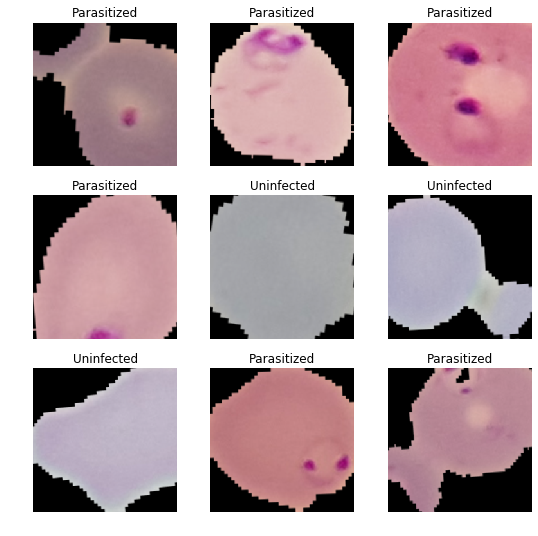

In [5]:
data = data_block.dataloaders(path, bs=64)
data.show_batch()

In [14]:
learn = cnn_learner(data, xresnet34, metrics=[accuracy]).to_fp16()

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/checkpoints/xrn50_940.pth


In [15]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,time
0,0.369400,0.238104,0.909998,01:24


epoch,train_loss,valid_loss,accuracy,time
0,0.246617,0.172213,0.943567,01:41
1,0.214349,0.179542,0.934313,01:41
2,0.200095,0.143943,0.949193,01:41
3,0.187918,0.134845,0.955181,01:41
4,0.174490,0.130787,0.955543,01:41
5,0.156932,0.128625,0.957358,01:41
6,0.143873,0.149448,0.946108,01:41
7,0.154330,0.107237,0.962802,01:42
8,0.137811,0.106105,0.961713,01:40
9,0.123597,0.103954,0.963890,01:40


In [0]:
learn.save('stage-1')

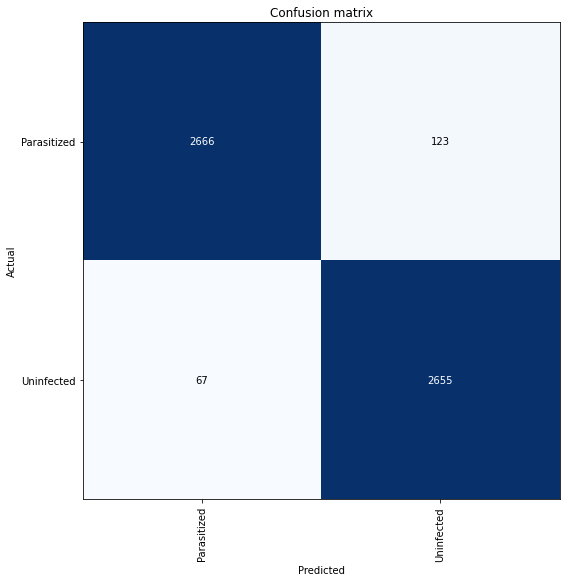

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))

In [18]:
preds, y_true=learn.get_preds()
y_true.shape, preds.shape

(torch.Size([5511]), torch.Size([5511, 2]))

In [20]:
classes = list(data.vocab)
report = classification_report(y_true, preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

 Parasitized       0.98      0.96      0.97      2789
  Uninfected       0.96      0.98      0.97      2722

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511



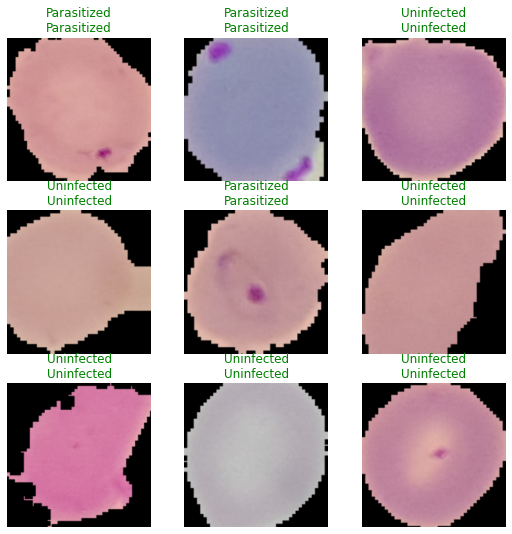

In [21]:
learn.show_results()